François GOUJON

# Laboratoire 3
# SVM, ensembles et apprentissage non-supervisé
## Classification, régression et régroupement (FER et FG-NET)

### GTI771 - Apprentissage machine avancé
#### Département du génie logiciel et des technologies de l’information

#### Version 1.0 mars 2020
#### <font color=blue> Version 2.0 - 22 mars 2020 </font>
#### <font color=magenta> Version 3.0 - 3 avril 2020 </font>

##### Prof. Alessandro L. Koerich

# Introduction

Ce troisième laboratoire porte sur l’utilisation des machines à vecteurs de support (SVM) et régresseurs à vecteurs de support (SVR), la combinaison de modèles d’apprentissage et le regroupement.

Dans ce laboratoire, vous êtes amenés à utiliser de nouvelles approches à l’aide de ces algorithmes/approches afin de résoudre le problème de classification des émotions (FER dataset) et le problème de régression des âges (FG-NET dataset). De plus, dans ce laboratoire, vous êtes amené aussi à considérer les algorithmes d’apprentissage non supervisé.

Vous devrez utiliser les primitives développées aux premiers laboratoires lorsque celles-ci ne sont pas redondantes. Vous devrez également étudier les hyperparamètres du modèle. Tout comme les deux premiers laboratoires de ce cours, vous réaliserez ce troisième travail avec la technologie Python3 conjointement avec la librairie d’apprentissage machine scikit-learn.

Votre Jupyter notebook devra contenir les réponses aux questions. Il devra notamment avoir une analyse détaillée des résultats de classification obtenus par les différents modèles et leurs variations d’hyperparamètres.

L’évaluation de ce laboratoire sera basée sur la qualité des modèles entraînés, la comparaison des performances réalisées par les différents modèles, les réponses aux questions dans cette notebook ainsi que l’organisation de votre code source (SVP, n’oubliez pas des commentaires dans le code!).

# Objectifs

Les principaux objectifs de ce laboratoire sont :
1. Produire un code source utilisant les technologies Python et des techniques d’apprentissage machine permettant de classifier des échantillons de données automatiquement;
2. Se familiariser avec les algorithmes SVM et SVR;
3. Analyser l’impact des hyperparamètres et des différents noyaux utilisés;
4. De construire un véritable système intelligent avec une combinaison de modèles (et/ou primitives);
5. Se familiariser avec les algorithmes d’apprentissage non supervisé;
6. Analyser et interpréter les sorties des algorithmes non supervisés;
7. Se familiariser avec le langage de programmation Python et les outils et librairies scientifiques d’apprentissage machine;

* #### Partie 1: SVM - Classification et régression
* SVM lineaire
* SVM noyau polynomial
* SVM noyau RBF
<font color=blue>
* SVR lineaire ou SVR noyau polynomial ou SVR noyau RBF
</font>    
<br>
* #### Partie 2: Ensembles
<font color=blue>
* Bagging, Boosting / Adaboost
* Votation, Min, Max, Average, Product, Weighted Rules
</font>        
<br>
* #### Partie 3: Regroupement
<font color=magenta>
* k-Means
* Autre méthode de regroupement
</font>    

## Partie 0: Imports

### (0a) Import de libraries

##### À faire:
1. Ajouter toutes les bibliothèques que vous avez utilisées pour compléter ce notebook dans une cellule avec une petite description.

In [1]:
import numpy as np  # package for scientific computing with Python.
import matplotlib.pyplot as plt # 2D plotting library
import matplotlib.ticker as ticker
import os
import random
from tqdm import tqdm
import seaborn as sns
import time
import pandas as pd #Bibliothèque de tableaux
import cv2 #Bibliothèque de visualisation
from PIL import Image
import glob

#Bibliothèque de traitement des images pour l'extraction de primitive
from skimage.transform import resize
from skimage.feature import hog
from skimage import io

#Bibliothèque de traitement des données (Normalisation, Reduction de dimension, Création de modèle)
from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV

# PYtorch : librairie pour faire du deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from sklearn.pipeline import make_pipeline
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision.transforms as T


# Partie 2
from sklearn import svm, metrics
from sklearn.base import clone
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix, mean_squared_error, mean_absolute_error
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC, SVR
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

# Tensorflow et keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
plt.style.use('seaborn-darkgrid')

### (0b) Charger le fichier de données

##### À faire:
1. Ajouter le code pour lire les fichiers de données.

### Chemins utilisés pour la lecture des fichiers

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
FGNET_IMAGES_PATH = '/content/drive/MyDrive/ColabNotebooks/GTI771/FGNET/images/*.*'
FGNET_data_path = '/content/drive/MyDrive/Colab Notebooks/datasets/FGNET_data.npy'
FGNET_labels_path = '/content/drive/MyDrive/Colab Notebooks/datasets/FGNET_labels.npy'
FER2013_path = '/content/drive/MyDrive/Colab Notebooks/datasets/fer2013.csv'

### Lecture des images FGNET

Nous convertissons les images en couleur en echelle des gris et nous isolons l'age du nom du fichier pour chaque image. Ensuite nous créons deux listes, une avec les pixels des images et l'autre avec les ages correspondantes. Ces deux listes serviront comme base pour créer les dataset d'entrainement, validation et test.

In [6]:
fgnet_images_list = []
fgnet_labels_list = []
SIZE = 48

if not os.path.isfile(FGNET_data_path):
    for my_file in tqdm(glob.glob(FGNET_IMAGES_PATH)):
        filename = os.path.basename(my_file)[:-4]
        image = cv2.imread(my_file, cv2.IMREAD_UNCHANGED)

        if len(image.shape) == 3: # Colored image
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        image = cv2.resize(image, (SIZE, SIZE))
        fgnet_images_list.append(image)

        # Get Age from filename
        index_A = filename.find('A')
        age = filename[index_A + 1:]
        # Remove last character if str. Ex: 36a, 36b, 02c, etc.
        # It also handles cases where age > 99, ex 100a
        if not age[-1].isdigit():
            age = age[:-1]

        fgnet_labels_list.append(age)

    fgnet_images_list = np.array(fgnet_images_list, dtype=np.uint8)
    fgnet_labels_list = np.array(fgnet_labels_list, dtype=np.uint8)

    # Write image data and labels to numpy files
    with open('/content/drive/MyDrive/ColabNotebooks/GTI771/FGNET_data.npy', 'wb') as f:
        np.save(f, fgnet_images_list)

    with open('/content/drive/MyDrive/ColabNotebooks/GTI771/FGNET_labels.npy', 'wb') as f:
        np.save(f, fgnet_labels_list)
        
else: # Read numpy files
    with open(FGNET_data_path, 'rb') as f:
        fgnet_images_list = np.load(f)

    with open(FGNET_labels_path, 'rb') as f:
        fgnet_labels_list = np.load(f)

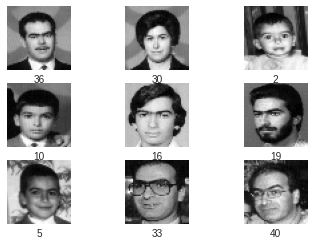

In [7]:
for i in range(9):
    plt.subplot(331 + i) # 3 rows, 3 cols, index 1 (first index can't be 0)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(fgnet_labels_list[i])
    plt.imshow(fgnet_images_list[i], cmap='gray')
plt.show()

In [8]:
age_df = pd.DataFrame(fgnet_labels_list, columns=['age'])

In [11]:
age_df.describe().T

count       mean       std  min  25%   50%   75%   max
age  1002.0  15.840319  12.86728  0.0  6.0  13.0  22.0  69.0

In [14]:
print(age_df.value_counts().sort_values(ascending=False))

age
18     47
0      43
3      42
4      42
6      41
       ..
60      1
58      1
62      1
63      1
69      1
Length: 63, dtype: int64


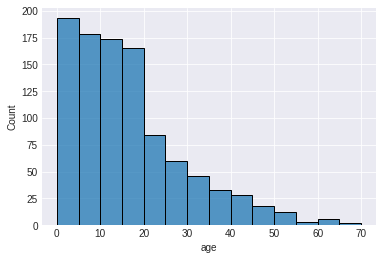

In [15]:
sns.histplot(x='age', data=age_df, bins=range(0, 75, 5))

D'après les statistiques des ages, nous pouvons remarquer que la distribution des images n'est pas balancée. En effet, nous avons beacoup des données entres les ages 0 à 20 et une minorité dans les ages > 20 donc, ceci peut influencer la performance et l'efficacité du modèle. 

De plus, avec l'ensemble des données que nous avons, ce modèle ne va pas performer pour des prédictions au delà de l'age de 69 ans car effectivement, l'age plus élévée de notre ensemble est 69.

Il faudrait donc spécifier que ce modèle sera entrainé pour predire des ages entre 0 et 69 ans seulement.

### Séparation des données en train, validation, test

In [16]:
Xtrain_FGNET, Xtest_FGNET, ytrain_FGNET, ytest_FGNET = train_test_split(fgnet_images_list, fgnet_labels_list, test_size=0.20, random_state=42)

In [17]:
print("Shapes:")
print("Xtrain_FGNET: ", Xtrain_FGNET.shape)
print("Xtest_FGNET: ", Xtest_FGNET.shape)
print("ytrain_FGNET: ", ytrain_FGNET.shape)
print("ytest_FGNET: ", ytest_FGNET.shape)

Shapes:
Xtrain_FGNET:  (801, 48, 48)
Xtest_FGNET:  (201, 48, 48)
ytrain_FGNET:  (801,)
ytest_FGNET:  (201,)


#### FER

In [18]:
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
SIZE = 48

FER2013_data = np.loadtxt(FER2013_path, delimiter=',', dtype=str)

Xtrain_FER = np.ones((28709,2304), np.uint8)
for i in tqdm(range(1, 28710)):
    Xtrain_FER[i-1] = FER2013_data[i,1].split(' ')
ytrain_FER = FER2013_data[1:28710,0].astype(np.uint8)

Xval_FER = np.ones((3589,2304), np.uint8)
for i in tqdm(range(28710, 32299)):
    Xval_FER[i-28710] = FER2013_data[i,1].split(' ')
yval_FER = FER2013_data[28710:32299,0].astype(np.uint8)

Xtest_FER = np.ones((3589,2304), np.uint8)
for i in tqdm(range(32299, 35888)):
    Xtest_FER[i-32299] = FER2013_data[i,1].split(' ')
ytest_FER = FER2013_data[32299:,0].astype(np.uint8)

100%|██████████| 3589/3589 [00:01<00:00, 2417.97it/s]


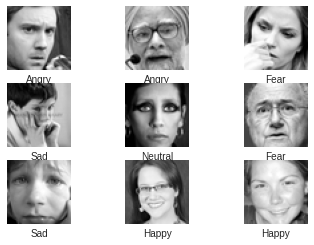

In [19]:
for i in range(9):
    plt.subplot(331 + i) # 3 rows, 3 cols, index 1 (first index can't be 0)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(labels[ytrain_FER[i]])
    plt.imshow(Xtrain_FER[i].reshape((SIZE, SIZE)), cmap='gray')
plt.show()

In [20]:
Xtrain_FER_df = pd.DataFrame(Xtrain_FER)
Xval_FER_df = pd.DataFrame(Xval_FER)
Xtest_FER_df = pd.DataFrame(Xtest_FER)

# Partie 1: Machines à vecteurs de support (SVM)
## (FER et FG-NET dataset)

Dans cette partie vous devez explorer les <b> différentes noyaux du SVM </b> disponibles dans LIBSVM, comme linéaire, polynomial et RBF.

Vous devez comparer la performance de ces algorithmes pour les ensemble FER (classification) et FG-NET (régression)

## (1a) Créer et évaluer des modèles SVM de classification
### (FER dataset)

[Scikit-learn LibSVM](https://scikit-learn.org/stable/modules/svm.html)

##### À faire:
1. Vecteurs de primitives << artisanales >> (handcrafted sans/avec réduction) du laboratoire 1. Choisir une seule représentation (p. ex. LBP après PCA). N’oubliez pas de normaliser les vecteurs (entrées) entre 0 et 1. 
2. Vecteurs de primitives << deep >> (CNN features sans/avec réduction) du laboratoire 2. Choisir une seule représentation (p. ex. 1re couche entièrement connectée du CNN simple). Vous pouvez également appliquer un algorithme de réduction de la dimensionnalité pour réduire la dimension de ce vecteur. N’oubliez pas de normaliser les vecteurs (entrées) entre 0 et 1.
3. Pour chaque représentation (artisanale et deep):<br> 
3a. Entraîner et optimiser (C) un SVM linéaire <br>
3b. Entraîner et optimiser (C et ordre) un SVM polynomial <br>
3c. Entraîner et optimiser (C et gamma) un SVM RBF (Gaussian) <br>
4. Analyser les résultats et présenter vos conclusions sur les modèles SVM.

|  Primitive   | Noyau       |   Paramètres    |  % App | % Val  | % Tst  | 
|--------------|-------------|-----------------|--------|--------|--------|
| LBP avec PCA | lineaire    | C=10            | XXX.XX | XXX.XX |        |
| LBP avec PCA | polynomial  | C=1,d=3         |  10.45 |        |        |
| LBP avec PCA | RBF         | C=256, g=0.05   | XXX.XX | XXX.XX | XXX.XX |
| CNN 4096     | lineaire    | C=10            | XXX.XX | XXX.XX |        |
| CNN 4096     | polynomial  | C=1,d=3         |  10.45 |        |        |
| CNN 4096     | RBF         | C=256, g=0.05   | XXX.XX | XXX.XX |        |


### (1a): Code:

#### 1. Vecteurs des primitives "artisanales" avec PCA

In [21]:
Xtrain_hog = []
Xval_hog = []
Xtest_hog = []

In [22]:
for i in tqdm(range(len(Xtrain_FER))):
    Xtrain_hog.append(hog(Xtrain_FER[i].reshape((SIZE, SIZE))))

for i in tqdm(range(len(Xval_FER))):
    Xval_hog.append(hog(Xval_FER[i].reshape((SIZE, SIZE))))
    Xtest_hog.append(hog(Xtest_FER[i].reshape((SIZE, SIZE))))

100%|██████████| 3589/3589 [00:06<00:00, 525.11it/s]


In [23]:
Xtrain_hog = np.array(Xtrain_hog)
Xval_hog = np.array(Xval_hog)
Xtest_hog = np.array(Xtest_hog)

In [24]:
Xtrain_hog.shape

(28709, 1296)

Nous avons 1296 features extraites avec HOG

In [25]:
pca_transformer = make_pipeline(MinMaxScaler(), PCA(n_components=40), MinMaxScaler())

In [26]:
Xtrain_hog_pca = pca_transformer.fit_transform(Xtrain_hog)
Xval_hog_pca = pca_transformer.transform(Xval_hog)
Xtest_hog_pca = pca_transformer.transform(Xtest_hog)

In [27]:
Xtrain_hog_pca.shape

(28709, 40)

Après avoir executé la réduction de dimentionalité avec PCA, nous avons maintenant 40 features.

#### 2. Vecteur couche deep CNN

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device '+str(device))

Using device cpu


In [29]:
class CNN1(nn.Module):  

    def __init__(self):
        super(CNN1,self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1)#Couche convolutionelle    48-3 +1 =46
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1)#Couche convolutionelle    46-3 +1 =44 
        self.relu2 = nn.ReLU()
        self.maxpl1 = nn.MaxPool2d(kernel_size = (2,2)) #     22
        #sortie de taille (48-2-2) /2 = 22
        
        # Out = (In - Kernel + 2p)/stride +1 D'ou le 20
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1)#Couche convolutionelle     20
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1)#Couche convolutionelle     18
        self.relu4 = nn.ReLU()
        self.maxpl2 = nn.MaxPool2d(kernel_size = (2,2)) ### 9
        self.maxpl3 = nn.MaxPool2d(kernel_size = (6,6)) ### 9
        
        
        
        #Classifier
        self.fc1 = nn.Linear(256*9*9,128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128,7)

     
    def forward(self,x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpl1(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.maxpl2(x)
    
        x = x.view( x.size(0), -1)
        x = self.fc1(x)  
        x = self.relu3(x)  
        x = self.fc2(x)   
        return x
    
    def get_feature_intermediaire(self,x) :
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpl1(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.maxpl3(x)
    
        x = x.view( x.size(0), -1)
        
        return x #Sortie de taille (taille du batch, 256*9*9 )

In [30]:
Xtrain_CNN_FER = np.reshape(Xtrain_FER , (Xtrain_FER.shape[0],1,48,48))
Xval_CNN_FER = np.reshape(Xval_FER , (Xval_FER.shape[0],1,48,48))
Xtest_CNN_FER = np.reshape(Xtest_FER , (Xtest_FER.shape[0],1,48,48))

#On charge le modèle : 
model_CNN = CNN1() # initialize the neural network
model_CNN.to(device=device)
loaded_cpt = torch.load('/content/drive/MyDrive/ColabNotebooks/GTI771/model_CNNFER.pt', map_location=torch.device('cpu'))
model_CNN.load_state_dict(loaded_cpt)

<All keys matched successfully>

In [31]:
size_batches=128
tensor_x = torch.Tensor(Xtrain_CNN_FER) # transform to torch tensor
tensor_y = torch.Tensor(ytrain_FER)

train_loader = DataLoader(TensorDataset(tensor_x,tensor_y),batch_size=size_batches) # create your dataloader

tensor_x = torch.Tensor(Xval_CNN_FER) # transform to torch tensor
tensor_y = torch.Tensor(yval_FER)

valid_loader = DataLoader(TensorDataset(tensor_x,tensor_y),batch_size=size_batches) # create your dataloader

tensor_x = torch.Tensor(Xtest_CNN_FER) # transform to torch tensor
tensor_y = torch.Tensor(ytest_FER)

test_loader = DataLoader(TensorDataset(tensor_x,tensor_y),batch_size=size_batches) # create your dataloader

In [32]:
size_feature=256*3*3
Xtrain_feature_CNN_fer=np.zeros((Xtrain_CNN_FER.shape[0],size_feature),dtype=np.float32)
Xtest_feature_CNN_fer=np.zeros((Xtest_CNN_FER.shape[0],size_feature),dtype=np.float32)
Xval_feature_CNN_fer=np.zeros((Xval_CNN_FER.shape[0],size_feature),dtype=np.float32)

model_CNN.eval()
i=0
for (data, label) in valid_loader:
    
    data = data.to(device=device, dtype=torch.float32)

    output = model_CNN.get_feature_intermediaire(data)
    
    Xval_feature_CNN_fer[size_batches*i:min(size_batches*(i+1),Xval_CNN_FER.shape[0])]= output.cpu().detach().numpy()
    i+=1
    
i=0
for (data, label) in train_loader:     
    data = data.to(device=device, dtype=torch.float32)
    output = model_CNN.get_feature_intermediaire(data)
    Xtrain_feature_CNN_fer[size_batches*i:min(size_batches*(i+1),Xtrain_CNN_FER.shape[0])]= output.cpu().detach().numpy()
    i+=1
i=0 
for (data, label) in test_loader:     
    data = data.to(device=device, dtype=torch.float32)
    output = model_CNN.get_feature_intermediaire(data)
    Xtest_feature_CNN_fer[size_batches*i:min(size_batches*(i+1),Xtest_CNN_FER.shape[0])]= output.cpu().detach().numpy()
    i+=1

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [33]:
print(Xtrain_feature_CNN_fer.shape)
print(Xval_feature_CNN_fer.shape)
print(Xtest_feature_CNN_fer.shape)

(28709, 2304)
(3589, 2304)
(3589, 2304)


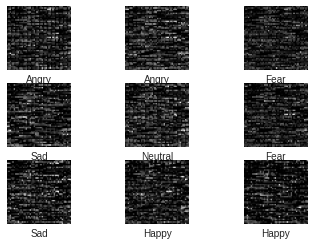

In [34]:
for i in range(9):
    plt.subplot(331 + i) # 3 rows, 3 cols, index 1 (first index can't be 0)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(labels[ytrain_FER[i]])
    plt.imshow(Xtrain_feature_CNN_fer[i].reshape((SIZE, SIZE)), cmap='gray')
plt.show()

In [35]:
Xtrain_feature_CNN_fer[0]

array([ 15.557751,  12.519884,  84.797424, ..., 156.80804 , 253.98059 ,
       117.298584], dtype=float32)

In [36]:
pca_transformer_cnn = make_pipeline(MinMaxScaler(), PCA(n_components=40), MinMaxScaler())

Xtrain_CNN_pca_FER = pca_transformer.fit_transform(Xtrain_feature_CNN_fer)
Xval_CNN_pca_FER = pca_transformer.transform(Xval_feature_CNN_fer)
Xtest_CNN_pca_FER = pca_transformer.transform(Xtest_feature_CNN_fer)

Pour le pipeline utilisé, nous effectuons une normalisation des données avant de passer par le PCA car celui-ci est affeté par la variance des données. Ensuite nous effectuons encore une fois une normalisation car ces données vont etre utilisés avec un modèle SVM qui lui aussi est affecté par la variance des données.

In [37]:
Xtrain_CNN_pca_FER.shape

(28709, 40)

### 3a. Entrainement et optimisation du vecteur "artisanal"

In [38]:
parametres_linear = [{'C': [0.5, 1, 10, 100]}]
parametres_poly = [{'C': [0.5, 1, 10, 100], 'degree': [2, 3, 4]}]
parametres_gaussian = [{'C': [0.5, 1, 10, 100], 'gamma': [1e-3, 1e-4, 1e-5]}]

Nous avons essayé d'utiliser GridSearchCV afin d'optimiser les modèles mais ceci prennait beacoup du temps à cause des méthodes que GridSearchCV utilise pour faire la validation. Ceci prend beacoup de temps de calcul. Nous avons decidé de faire cette optimisation sans l'aide de GridSearchCV.

SVC Linéraire por Primitives HOG PCA

In [39]:
c_values = [0.5, 1, 10, 100]

scores_train_lineaires = []
scores_val_lineaires = []
scores_test_lineaires = []
predictions_train = []
predictions_val = []
predictions_test = []
modeles_lineaires = []
params_lineaire = []

# Pour chaque valeur de C dans le modèle linéraire
for c_value in tqdm(c_values):
    modeles_lineaires.append(f"HOG_linear")
    params_lineaire.append(f"C={c_value}")
    model = LinearSVC(C=c_value, class_weight='balanced', max_iter=5000, tol=0.1, random_state=42)
    model.fit(Xtrain_hog_pca, ytrain_FER)

    ypred_train = model.predict(Xtrain_hog_pca)
    ypred_val = model.predict(Xval_hog_pca)
    ypred_test = model.predict(Xtest_hog_pca)
    score_train = metrics.balanced_accuracy_score(ytrain_FER, ypred_train)
    score_val = metrics.balanced_accuracy_score(yval_FER, ypred_val)
    score_test = metrics.balanced_accuracy_score(ytest_FER, ypred_test)

    predictions_train.append(ypred_train)
    predictions_val.append(ypred_val)
    predictions_test.append(ypred_test)
    scores_train_lineaires.append(score_train)
    scores_val_lineaires.append(score_val)
    scores_test_lineaires.append(score_test)

 50%|█████     | 2/4 [00:14<00:12,  6.15s/it]/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
 75%|███████▌  | 3/4 [01:24<00:25, 25.49s/it]/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
100%|██████████| 4/4 [05:35<00:00, 83.87s/it]


In [40]:
errors_lineraires_train = 1 - np.array(scores_train_lineaires)
errors_lineraires_val = 1 - np.array(scores_val_lineaires)
errors_lineraires_test = 1 - np.array(scores_test_lineaires)

In [41]:
scores_lineaires_df = pd.DataFrame([modeles_lineaires, params_lineaire, errors_lineraires_train * 100, errors_lineraires_val * 100, errors_lineraires_test * 100])

In [42]:
scores_lineaires = scores_lineaires_df.T
scores_lineaires.columns = ['Noyau', 'Parametres', '% Erreur App', '% Erreur Val', '% Erreur Test']
scores_lineaires

Noyau Parametres % Erreur App % Erreur Val % Erreur Test
0  HOG_linear      C=0.5       62.144      61.3009       61.9355
1  HOG_linear        C=1      62.2012      61.0182       61.8386
2  HOG_linear       C=10      62.1403      61.0823       62.2065
3  HOG_linear      C=100      66.5999      66.4823       68.2654

Ici, on peut constater que lorsqu'on a diminué la regularisation avec la valeur de C, nous avons obtenu une seuil de decision plus simple mais qui peut ne pas bien performer pour des valeurs encore plus petites (la precision peut être affecté grandement au prix de plus de simplicité). Par contre, lorsqu'on a augmenté la valeur de C, une marge plus petite est utilisé dans la price de decisions donc on aura un modèle plus stricte et qui donnera une meilleure performance, tel qu'on le voit dans les résultats avec une valeur de C=10, mais au côut d'une plus grande complexité lors de la prise de décisions. Finalement, on peut aussi constater qu'en augmentant grandement la valeur de C ne fait pas necessairement le modèle plus performant, au contraire, il peut devenir beacoup moins performant qu'au début.

SVM Polynomial pour primitives HOG PCA

In [43]:
c_values = [0.5, 1, 10, 100]
degree_values = [2, 3, 4]

scores_train_poly = []
scores_val_poly = []
scores_test_poly = []
predictions_train = []
predictions_val = []
predictions_test = []
modeles_poly = []
params_poly = []

# Pour chaque valeur de C dans le modèele linéraire
for c_value in tqdm(c_values):
    for degree_value in tqdm(degree_values):
        modeles_poly.append(f"HOG_Poly")
        params_poly.append(f"C={c_value}, ordre={degree_value}")
        model = SVC(kernel='poly', C=c_value, degree=degree_value, class_weight='balanced', max_iter=5000, tol=0.1, random_state=42, cache_size=500)
        model.fit(Xtrain_hog_pca, ytrain_FER)

        ypred_train = model.predict(Xtrain_hog_pca)
        ypred_val = model.predict(Xval_hog_pca)
        ypred_test = model.predict(Xtest_hog_pca)
        score_train = metrics.balanced_accuracy_score(ytrain_FER, ypred_train)
        score_val = metrics.balanced_accuracy_score(yval_FER, ypred_val)
        score_test = metrics.balanced_accuracy_score(ytest_FER, ypred_test)

        predictions_train.append(ypred_train)
        predictions_val.append(ypred_val)
        predictions_test.append(ypred_test)
        scores_train_poly.append(score_train)
        scores_val_poly.append(score_val)
        scores_test_poly.append(score_test)

  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)

 33%|███▎      | 1/3 [01:42<03:24, 102.29s/it]/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)

 67%|██████▋   | 2/3 [03:22<01:41, 101.58s/it]/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)

  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=5

In [44]:
errors_poly_train = 1 - np.array(scores_train_poly)
errors_poly_val = 1 - np.array(scores_val_poly)
errors_poly_test = 1 - np.array(scores_test_poly)

In [45]:
scores_poly_df = pd.DataFrame([modeles_poly, params_poly, errors_poly_train * 100, errors_poly_val * 100, errors_poly_test * 100])
scores_poly = scores_poly_df.T
scores_poly.columns = ['Noyau', 'Parametres', '% Erreur App', '% Erreur Val', '% Erreur Test']
scores_poly

Noyau      Parametres % Erreur App % Erreur Val % Erreur Test
0   HOG_Poly  C=0.5, ordre=2      66.2989      68.0401       68.0288
1   HOG_Poly  C=0.5, ordre=3      75.6889      77.1662       78.3997
2   HOG_Poly  C=0.5, ordre=4      69.5992      74.6101       72.0694
3   HOG_Poly    C=1, ordre=2      73.7827      75.4766       73.8566
4   HOG_Poly    C=1, ordre=3      76.2827      77.8862       78.3746
5   HOG_Poly    C=1, ordre=4      69.4361      73.9486       72.5598
6   HOG_Poly   C=10, ordre=2      75.7503      77.3624       78.0034
7   HOG_Poly   C=10, ordre=3      75.2963        77.31       78.3136
8   HOG_Poly   C=10, ordre=4      69.3604      73.9836       72.4728
9   HOG_Poly  C=100, ordre=2       75.383      77.0064       77.4587
10  HOG_Poly  C=100, ordre=3      75.2963        77.31       78.3136
11  HOG_Poly  C=100, ordre=4      69.3604      73.9836       72.4728

On remarque ici qu'en utilisant une regularization moins stricte, donc une prise de decision plus simple, nous avons obtenu un meilleur résultat qu'en utilisant des valeurs de C plus grandres. Également, parmi les ordres de 2, 3 et 4, celui qui a le mieux performe est l'ordre 4 et celui qui a le moins bien performé est l'ordre 2, sans compter le modèle qui a utilisé une valeur de C=0.5
Finalement, ce modèle a pris beacoup plus de temps pour s'entrainer sans pourtant donner un meilleur résultat que le modèle lineaire, donc, le modèle lineaire reste plus performant et plus rapide que le modèle polynomiale.

SVM RBF pour primitives HOG PCA

In [46]:
c_values = [0.5, 1, 10, 100]
gamma_values = [1e-3, 1e-4, 1e-5]

scores_train_rbf = []
scores_val_rbf = []
scores_test_rbf = []
predictions_train = []
predictions_val = []
predictions_test = []
modeles_rbf = []
params_rfb = []

# Pour chaque valeur de C dans le modèele linéraire
for c_value in tqdm(c_values):
    for gamma_value in tqdm(gamma_values):
        modeles_rbf.append(f"HOG_RBF")
        params_rfb.append(f"C={c_value}, gamma={gamma_value}")
        model = SVC(kernel='rbf', C=c_value, gamma=gamma_value, class_weight='balanced', tol=0.1, random_state=42, cache_size=500)
        model.fit(Xtrain_hog_pca, ytrain_FER)

        ypred_train = model.predict(Xtrain_hog_pca)
        ypred_val = model.predict(Xval_hog_pca)
        ypred_test = model.predict(Xtest_hog_pca)
        score_train = metrics.balanced_accuracy_score(ytrain_FER, ypred_train)
        score_val = metrics.balanced_accuracy_score(yval_FER, ypred_val)
        score_test = metrics.balanced_accuracy_score(ytest_FER, ypred_test)

        predictions_train.append(ypred_train)
        predictions_val.append(ypred_val)
        predictions_test.append(ypred_test)
        scores_train_rbf.append(score_train)
        scores_val_rbf.append(score_val)
        scores_test_rbf.append(score_test)

100%|██████████| 4/4 [53:34<00:00, 803.60s/it]


In [47]:
errors_rbf_train = 1 - np.array(scores_train_rbf)
errors_rbf_val = 1 - np.array(scores_val_rbf)
errors_rbf_test = 1 - np.array(scores_test_rbf)

In [48]:
scores_rbf_df = pd.DataFrame([modeles_rbf, params_rfb, errors_rbf_train * 100, errors_rbf_val * 100, errors_rbf_test * 100])
scores_rbf = scores_rbf_df.T
scores_rbf.columns = ['Noyau', 'Parametres', '% Erreur App', '% Erreur Val', '% Erreur Test']
scores_rbf

Noyau           Parametres % Erreur App % Erreur Val % Erreur Test
0   HOG_RBF   C=0.5, gamma=0.001      85.7143      85.7143       85.7143
1   HOG_RBF  C=0.5, gamma=0.0001      85.7143      85.7143       85.7143
2   HOG_RBF   C=0.5, gamma=1e-05      85.7143      85.7143       85.7143
3   HOG_RBF     C=1, gamma=0.001      74.0976      72.6081       71.3035
4   HOG_RBF    C=1, gamma=0.0001      85.7143      85.7143       85.7143
5   HOG_RBF     C=1, gamma=1e-05      85.7143      85.7143       85.7143
6   HOG_RBF    C=10, gamma=0.001      60.8199       59.662        58.813
7   HOG_RBF   C=10, gamma=0.0001       79.237      77.7101       77.4067
8   HOG_RBF    C=10, gamma=1e-05      85.7143      85.7143       85.7143
9   HOG_RBF   C=100, gamma=0.001      60.1548      58.8018       60.0162
10  HOG_RBF  C=100, gamma=0.0001      60.7556      59.3612       58.7667
11  HOG_RBF   C=100, gamma=1e-05      78.7593      76.7052       77.0319

On observe ici que les modèles qui on mieux performé sont les modèles avec une valeur de gamma de 0.001 combiné avec une valeur de C 10 et 100. On observe également que lorsqu'on utilise des valeurs de gamma tres petits avec des valeurs de C très petits ou très grands, le modèle n'as pas bien performé et le taux d'erreur est très grand. Il faut donc tenir compte de la valeur de C et de gamma ensemble afin de trouver les meilleurs valeurs qui vont donner un résultat satisfaisant.

### 3b. Entrainement et optimisation du vecteur deep CNN

#### SVM linéaire pour primitives de couche deep CNN

In [50]:
c_values = [0.5, 1, 10, 100]

scores_CNN_train_lineaires = []
scores_CNN_val_lineaires = []
scores_CNN_test_lineaires = []
predictions_CNN_train = []
predictions_CNN_val = []
predictions_CNN_test = []
modeles_CNN_lineaires = []
params_CNN_lineaire = []

# Pour chaque valeur de C dans le modèele linéraire
for c_value in tqdm(c_values):
    modeles_CNN_lineaires.append(f"CNN_linear_C_{c_value}")
    params_CNN_lineaire.append(f"C={c_value}")
    model = LinearSVC(C=c_value, class_weight='balanced', max_iter=5000, tol=0.1, random_state=42)
    model.fit(Xtrain_CNN_pca_FER, ytrain_FER)

    ypred_train = model.predict(Xtrain_CNN_pca_FER)
    ypred_val = model.predict(Xval_CNN_pca_FER)
    ypred_test = model.predict(Xtest_CNN_pca_FER)
    score_train = metrics.balanced_accuracy_score(ytrain_FER, ypred_train)
    score_val = metrics.balanced_accuracy_score(yval_FER, ypred_val)
    score_test = metrics.balanced_accuracy_score(ytest_FER, ypred_test)

    predictions_CNN_train.append(ypred_train)
    predictions_CNN_val.append(ypred_val)
    predictions_CNN_test.append(ypred_test)
    scores_CNN_train_lineaires.append(score_train)
    scores_CNN_val_lineaires.append(score_val)
    scores_CNN_test_lineaires.append(score_test)

 50%|█████     | 2/4 [00:16<00:14,  7.37s/it]/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
 75%|███████▌  | 3/4 [01:35<00:28, 28.65s/it]/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
100%|██████████| 4/4 [06:15<00:00, 93.86s/it] 


In [51]:
errors_lineaire_CNN_train = 1 - np.array(scores_CNN_train_lineaires)
errors_lineaire_CNN_val = 1 - np.array(scores_CNN_val_lineaires)
errors_lineaire_CNN_test = 1 - np.array(scores_CNN_test_lineaires)

In [52]:
scores_lineaire_CNN_df = pd.DataFrame([modeles_CNN_lineaires, params_CNN_lineaire, errors_lineaire_CNN_train * 100, errors_lineaire_CNN_val * 100, errors_lineaire_CNN_test * 100])
scores_lineaire_CNN = scores_lineaire_CNN_df.T
scores_lineaire_CNN.columns = ['Noyau', 'Parametres', '% Erreur App', '% Erreur Val', '% Erreur Test']
scores_lineaire_CNN

Noyau Parametres % Erreur App % Erreur Val % Erreur Test
0  CNN_linear_C_0.5      C=0.5      60.4357      60.5556       60.1428
1    CNN_linear_C_1        C=1      60.7337      60.3297       60.4263
2   CNN_linear_C_10       C=10      60.5679      59.9235       60.3911
3  CNN_linear_C_100      C=100      64.6066      64.3178       64.7336

SVM Polynomial pour primitives couche deep CNN

In [53]:
c_values = [0.5, 1, 10, 100]
degree_values = [2, 3, 4]

scores_CNN_train_poly = []
scores_CNN_val_poly = []
scores_CNN_test_poly = []
predictions_CNN_train = []
predictions_CNN_val = []
predictions_CNN_test = []
modeles_CNN_poly = []
params_CNN_poly = []

# Pour chaque valeur de C dans le modèele linéraire
for c_value in tqdm(c_values):
    for degree_value in tqdm(degree_values):
        modeles_CNN_poly.append(f"CNN_poly_C_{c_value}_degree_{degree_value}")
        params_CNN_poly.append(f"C={c_value}, ordre={degree_value}")
        model = SVC(kernel='poly', C=c_value, degree=degree_value, class_weight='balanced', max_iter=5000, tol=0.1, random_state=42, cache_size=500)
        model.fit(Xtrain_CNN_pca_FER, ytrain_FER)

        ypred_train = model.predict(Xtrain_CNN_pca_FER)
        ypred_val = model.predict(Xval_CNN_pca_FER)
        ypred_test = model.predict(Xtest_CNN_pca_FER)
        score_train = metrics.balanced_accuracy_score(ytrain_FER, ypred_train)
        score_val = metrics.balanced_accuracy_score(yval_FER, ypred_val)
        score_test = metrics.balanced_accuracy_score(ytest_FER, ypred_test)

        predictions_CNN_train.append(ypred_train)
        predictions_CNN_val.append(ypred_val)
        predictions_CNN_test.append(ypred_test)
        scores_CNN_train_poly.append(score_train)
        scores_CNN_val_poly.append(score_val)
        scores_CNN_test_poly.append(score_test)

  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)

 33%|███▎      | 1/3 [01:42<03:24, 102.11s/it]/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)

 67%|██████▋   | 2/3 [03:22<01:41, 101.62s/it]/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)

  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=5

In [54]:
errors_poly_CNN_train = 1 - np.array(scores_CNN_train_poly)
errors_poly_CNN_val = 1 - np.array(scores_CNN_val_poly)
errors_poly_CNN_test = 1 - np.array(scores_CNN_test_poly)

In [55]:
scores_poly_CNN_df = pd.DataFrame([modeles_CNN_poly, params_CNN_poly, errors_poly_CNN_train * 100, errors_poly_CNN_val * 100, errors_poly_CNN_test * 100])
scores_poly_CNN = scores_poly_CNN_df.T
scores_poly_CNN.columns = ['Noyau', 'Parametres', '% Erreur App', '% Erreur Val', '% Erreur Test']
scores_poly_CNN

Noyau      Parametres  ... % Erreur Val % Erreur Test
0   CNN_poly_C_0.5_degree_2  C=0.5, ordre=2  ...      73.9067       72.2238
1   CNN_poly_C_0.5_degree_3  C=0.5, ordre=3  ...      77.9515       74.3766
2   CNN_poly_C_0.5_degree_4  C=0.5, ordre=4  ...      74.8223       74.7253
3     CNN_poly_C_1_degree_2    C=1, ordre=2  ...      76.0833       75.2441
4     CNN_poly_C_1_degree_3    C=1, ordre=3  ...       75.312       75.3743
5     CNN_poly_C_1_degree_4    C=1, ordre=4  ...      75.0925       74.7457
6    CNN_poly_C_10_degree_2   C=10, ordre=2  ...      78.4367       78.2442
7    CNN_poly_C_10_degree_3   C=10, ordre=3  ...      75.5278       74.8431
8    CNN_poly_C_10_degree_4   C=10, ordre=4  ...      75.6047       75.3593
9   CNN_poly_C_100_degree_2  C=100, ordre=2  ...      78.2777       77.0333
10  CNN_poly_C_100_degree_3  C=100, ordre=3  ...       74.284        74.563
11  CNN_poly_C_100_degree_4  C=100, ordre=4  ...      75.6865       75.3272

[12 rows x 5 columns]

SVM RBF pour primitives couche deep CNN

In [56]:
c_values = [1, 10, 100]
gamma_values = [1e-3, 1e-4]

scores_CNN_train_rbf = []
scores_CNN_val_rbf = []
scores_CNN_test_rbf = []
predictions_CNN_train = []
predictions_CNN_val = []
predictions_CNN_test = []
modeles_CNN_rbf = []
params_CNN_rbf = []

# Pour chaque valeur de C dans le modèele linéraire
for c_value in tqdm(c_values):
    for gamma_value in tqdm(gamma_values):
        modeles_CNN_rbf.append(f"CNN_RBF_C_{c_value}_gamma_{gamma_value}")
        params_CNN_rbf.append(f"C={c_value}, gamma={gamma_value}")
        model = SVC(kernel='rbf', C=c_value, gamma=gamma_value, class_weight='balanced', max_iter=5000, tol=0.1, random_state=42, cache_size=500)
        model.fit(Xtrain_CNN_pca_FER, ytrain_FER)

        ypred_train = model.predict(Xtrain_CNN_pca_FER)
        ypred_val = model.predict(Xval_CNN_pca_FER)
        ypred_test = model.predict(Xtest_CNN_pca_FER)
        score_train = metrics.balanced_accuracy_score(ytrain_FER, ypred_train)
        score_val = metrics.balanced_accuracy_score(yval_FER, ypred_val)
        score_test = metrics.balanced_accuracy_score(ytest_FER, ypred_test)

        predictions_CNN_train.append(ypred_train)
        predictions_CNN_val.append(ypred_val)
        predictions_CNN_test.append(ypred_test)
        scores_CNN_train_rbf.append(score_train)
        scores_CNN_val_rbf.append(score_val)
        scores_CNN_test_rbf.append(score_test)

  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)

 50%|█████     | 1/2 [03:17<03:17, 197.61s/it]/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)

  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)

 50%|█████     | 1/2 [03:07<03:07, 187.36s/it]/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=5

In [57]:
errors_rbf_CNN_train = 1 - np.array(scores_CNN_train_rbf)
errors_rbf_CNN_val = 1 - np.array(scores_CNN_val_rbf)
errors_rbf_CNN_test = 1 - np.array(scores_CNN_test_rbf)

In [58]:
scores_rbf_CNN_df = pd.DataFrame([modeles_CNN_rbf, params_CNN_rbf, errors_rbf_CNN_train * 100, errors_rbf_CNN_val * 100, errors_rbf_CNN_test * 100])
scores_rbf_CNN = scores_rbf_CNN_df.T
scores_rbf_CNN.columns = ['Noyau', 'Parametres', '% Erreur App', '% Erreur Val', '% Erreur Test']
scores_rbf_CNN

Noyau           Parametres  ... % Erreur Val % Erreur Test
0     CNN_RBF_C_1_gamma_0.001     C=1, gamma=0.001  ...      85.7143       85.7143
1    CNN_RBF_C_1_gamma_0.0001    C=1, gamma=0.0001  ...      85.7143       85.7143
2    CNN_RBF_C_10_gamma_0.001    C=10, gamma=0.001  ...      73.6491        72.992
3   CNN_RBF_C_10_gamma_0.0001   C=10, gamma=0.0001  ...      85.7143       85.7143
4   CNN_RBF_C_100_gamma_0.001   C=100, gamma=0.001  ...      70.0225       68.6549
5  CNN_RBF_C_100_gamma_0.0001  C=100, gamma=0.0001  ...      74.1311       73.3779

[6 rows x 5 columns]

### (1a): Résultats et résponses:

En analysant les résultats pour les primitives HOG et la couche deep CNN, nous remarquons que le meillleur résultat à été le modèle SVM pour les primitives **HOG** avec une réduction PCA à 40 composantes, un kernel **RBF** et les paramètres **C=100** et **gamma=0.0001**. Ce modèle a donné les pourcentages d'erreur suivants:

- **60.7624%** d'erreur dans l'ensemble d'apprentissage
- **58.8953%** d'erreur dans l'ensemble de validation
- **59.1308%** d'erreur dans l'ensemble de test

## (1b) Créer et évaluer des modèles de régression
### (FG-NET dataset)

Idéalement, vous devez tout refaire pour ce nouvel ensemble de données / tâche. Alors, pour simplifier ce TP, vous pouvez créer, optimiser et évaluer un seul modèle de régression. Vous pouvez choisir la meilleure combinaison représentation / SVM de la partie 1a. 
<font color=blue>
##### À faire:
1. Choisir une combinaison primitive/kernel (Cellui qu'a meilleur performé dans la partie 1). 
2. Entraîner et optimiser (C, epsilon, ???) un SRV (linéaire ou polynomial ou Gaussian)
3. Analyser les résultats et présenter vos conclusions sur le modèle SVR.

|  Primitive   | Noyau    |   Paramètres       |  MAE   |  MSE   | 
|--------------|----------|--------------------|--------|--------|
| LBP avec PCA |  RBF     | C=256,g=15,ep=0.1  | XXX.XX | XXX.XX |
</font>    

### (1b): Code:

Nous avons choisi la combinaison primitive/kernel suivante:
- Primitive: HOG avec réduction PCA
- kernel: RBF

In [60]:
Xtrain_HOG_FGNET = []
Xtest_HOG_FGNET = []

In [61]:
Xtrain_FGNET.shape

(801, 48, 48)

In [62]:
for i in tqdm(range(len(Xtrain_FGNET))):
    Xtrain_HOG_FGNET.append(hog(Xtrain_FGNET[i]))

for i in tqdm(range(len(Xtest_FGNET))):
    Xtest_HOG_FGNET.append(hog(Xtest_FGNET[i]))

100%|██████████| 201/201 [00:00<00:00, 1006.94it/s]


In [63]:
Xtrain_HOG_FGNET = np.array(Xtrain_HOG_FGNET)
Xtest_HOG_FGNET = np.array(Xtest_HOG_FGNET)

Xtrain_HOG_FGNET.shape

(801, 1296)

In [64]:
pca_transformer = make_pipeline(MinMaxScaler(), PCA(n_components=40), MinMaxScaler())

In [65]:
Xtrain_HOG_FGNET_PCA = pca_transformer.fit_transform(Xtrain_HOG_FGNET, ytrain_FGNET)
Xtest_HOG_FGNET_PCA = pca_transformer.transform(Xtest_HOG_FGNET)

In [66]:
c_values = [0.5, 1, 10, 100, 256]
gamma_values = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
epsilon_values = [1e-3, 1e-2, 1e-1, 1, 10, 100]

scores_train_rbf = []
scores_val_rbf = []
scores_test_rbf = []
predictions_train = []
predictions_val = []
predictions_test = []
modeles_rbf = []
params_rfb = []

# Pour chaque valeur de C dans le modèele linéraire
for c_value in tqdm(c_values):
    for gamma_value in tqdm(gamma_values):
        for epsilon_value in tqdm(epsilon_values):
            modeles_rbf.append(f"HOG_PCA_SRV_RBF")
            params_rfb.append(f"C={c_value}, gamma={gamma_value}, epsilon={epsilon_value}")
            model = SVR(kernel='rbf', C=c_value, gamma=gamma_value, epsilon=epsilon_value, cache_size=500, max_iter=5000)
            model.fit(Xtrain_HOG_FGNET_PCA, ytrain_FGNET)

            ypred_train = model.predict(Xtrain_HOG_FGNET_PCA)
            ypred_test = model.predict(Xtest_HOG_FGNET_PCA)
            score_train = metrics.mean_squared_error(ytrain_FGNET, ypred_train)
            score_test = metrics.mean_squared_error(ytest_FGNET, ypred_test)

            predictions_train.append(ypred_train)
            predictions_test.append(ypred_test)
            scores_train_rbf.append(score_train)
            scores_test_rbf.append(score_test)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:00,  7.02it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.99it/s]

 50%|█████     | 3/6 [00:00<00:00,  6.90it/s]

100%|██████████| 6/6 [00:00<00:00,  9.42it/s]

 12%|█▎        | 1/8 [00:00<00:04,  1.55it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:00,  7.02it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.01it/s]

 50%|█████     | 3/6 [00:00<00:00,  6.92it/s]

100%|██████████| 6/6 [00:00<00:00,  9.36it/s]

 25%|██▌       | 2/8 [00:01<00:03,  1.54it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:00,  6.93it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.92it/s]

 50%|█████     | 3/6 [00:00<00:00,  6.97it/s]

100%|██████████| 6/6 [00:00<00:00,  9.40it/s]

 38%|███▊      | 3/8 [00:01<00:03,  1.54it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:00,  6.85it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.86it/s]

 50%|█

In [67]:
scores_rbf_df = pd.DataFrame([modeles_rbf, params_rfb, scores_train_rbf, scores_test_rbf])
scores_rbf = scores_rbf_df.T
scores_rbf.columns = ['Noyau', 'Parametres', 'MSE App', 'MSE Test']
scores_rbf.to_csv('/content/drive/MyDrive/ColabNotebooks/GTI771/scores_rbf.csv',index=False)
scores_rbf.sort_values(by=['MSE Test'])

Noyau                       Parametres  MSE App MSE Test
172  HOG_PCA_SRV_RBF     C=100, gamma=0.1, epsilon=10  97.2285  123.297
129  HOG_PCA_SRV_RBF         C=10, gamma=1, epsilon=1  58.3349  123.381
128  HOG_PCA_SRV_RBF       C=10, gamma=1, epsilon=0.1  58.7186  123.965
127  HOG_PCA_SRV_RBF      C=10, gamma=1, epsilon=0.01  58.7856  124.008
126  HOG_PCA_SRV_RBF     C=10, gamma=1, epsilon=0.001  58.7928  124.012
..               ...                              ...      ...      ...
125  HOG_PCA_SRV_RBF     C=10, gamma=0.1, epsilon=100  514.128  511.424
113  HOG_PCA_SRV_RBF   C=10, gamma=0.001, epsilon=100  514.128  511.424
107  HOG_PCA_SRV_RBF  C=10, gamma=0.0001, epsilon=100  514.128  511.424
149  HOG_PCA_SRV_RBF  C=100, gamma=1e-05, epsilon=100  514.128  511.424
239  HOG_PCA_SRV_RBF    C=256, gamma=100, epsilon=100  514.128  511.424

[240 rows x 4 columns]

In [68]:
C_values = np.logspace(-2, 4, 20)
gamma_values = np.logspace(-5, 3, 20)
epsilon_values = np.logspace(-5, 3, 20)
params = dict(gamma=gamma_values, epsilon=epsilon_values, C=C_values)
grid = GridSearchCV(SVR(kernel='rbf', cache_size=500, max_iter=5000), param_grid=params, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid.fit(Xtrain_HOG_FGNET_PCA, ytrain_FGNET)

Fitting 5 folds for each of 8000 candidates, totalling 40000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 370 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 870 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done 2501 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3826 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 6686 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 9068 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 12682 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 15506 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 20152 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 24744 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 29052 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done 33528 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done 39008 tasks      | elapsed: 23.2min
[Parallel(n_jobs=-1)]: Done 40000 out 

GridSearchCV(cv=None, error_score=nan,
             estimator=SVR(C=1.0, cache_size=500, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=5000, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([1.00000000e-02, 2.06913808e-02, 4.28133240e-02, 8.85866790e-02,
       1.83298071e-01, 3.79269019e-01, 7.84759970e-01, 1.62377674e...
                         'gamma': array([1.00000000e-05, 2.63665090e-05, 6.95192796e-05, 1.83298071e-04,
       4.83293024e-04, 1.27427499e-03, 3.35981829e-03, 8.85866790e-03,
       2.33572147e-02, 6.15848211e-02, 1.62377674e-01, 4.28133240e-01,
       1.12883789e+00, 2.97635144e+00, 7.84759970e+00, 2.06913808e+01,
       5.45559478e+01, 1.43844989e+02, 3.79269019e+02, 1.00000000e+03])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_me

In [69]:
print(f"Meilleurs paramètres: {grid.best_params_}, {-grid.best_score_}")

Meilleurs paramètres: {'C': 29.76351441631316, 'epsilon': 1.1288378916846884, 'gamma': 1.1288378916846884}, 113.60115694703282


In [70]:
best_model = grid.best_estimator_
best_model

SVR(C=29.76351441631316, cache_size=500, coef0=0.0, degree=3,
    epsilon=1.1288378916846884, gamma=1.1288378916846884, kernel='rbf',
    max_iter=5000, shrinking=True, tol=0.001, verbose=False)

In [71]:
ypred_train = best_model.predict(Xtrain_HOG_FGNET_PCA)
ypred_test = best_model.predict(Xtest_HOG_FGNET_PCA)
score_train = metrics.mean_squared_error(ytrain_FGNET, ypred_train)
score_test = metrics.mean_squared_error(ytest_FGNET, ypred_test)

In [72]:
print('MSE dataset apprentissage avec GridSearchCV meilleurs paramètres: ', score_train)
print('MSE dataset test avec GridSearchCV meilleurs paramètres: ', score_test)

MSE dataset apprentissage avec GridSearchCV meilleurs paramètres:  16.361482103157332
MSE dataset test avec GridSearchCV meilleurs paramètres:  119.7978048706259


On observe alors que le meilleur modèle apres une recherche exhaustive des parametres a donné comme résultat un MSE pour les données de Xtrain de 16.4 et un MSE pour les données de test de 119.8. Ce sont déjà des résultats plus performants que le réseau CNN du laboratoire #2 donc on peut dire que, soit que le réseaux CNN du laboratoire #2 peut être personalisé encore plus, soit en ajoutant plus de couches convolutives ou bien en ajoutant du Dropout et en gardant le même nombre de couches denses pour faire la classification. Ou bien, on peut utilisér la sortie de cette convolution dans le modèle SVM optimisé et obtenir un resultat assez satisfaisant. Finalement, il faut tenir en compte que le temps d'execution du modèle SVM peut être plus grand que celui d'un CNN et aussi, ce dernier peut être executé plus rapidement à l'aide des cartes graphiques (GPU) ce qui peut améliorer le temps d'execution et la performance generale du modèle.

### (1b): Résultats et résponses:

En analysant les résultats obtenus par la première méthode (boucle for et resultats dans fichier *scores_rbf.csv*), nous constatons les faits suivants:
* Avec une valeur de C très petite et des valeurs gamma < 1, la valeur d'epsilon qui performait le mieux était 10. Parcontre, lorsque gamma était >= 1, les valeurs d'epsilon < 1 ont mieux performé cette fois.
* Tourjours avec un valeur de C petite et si on augmente gamma graduellement, la valeur d'epsilon égale à 10 continuait de performer le mieux avec un MSE plus petit que les autres évaluations.
* Avec C = 1, les valeurs de gamma = 1 et epsilon = 0.01 ont le mieux performé.
* Avec C = 10, les valeurs de gamma = 10 et epsilon = 1 ont mieux performé sur l'ensemble d'apprentissage mais le résultat n'a pas améliore dans l'ensemble de test, on commence a remarquer alors du surentrainement du modèle.
* Donc pour C = 10, le modèle qui a mieux performe tout en évitant de tomber sur le surentrainement a été le modèle avec les parametres: **C = 1, gamma = 0.1 et epsilon = 10** avec une difference de **0.7874** points seulement entre l'ensemble d'apprentissage et l'ensemble de test.

*Modèle SVM avec kernel RBF et paramètres: C = 1, gamma = 0.1 et epsilon = 10*  
MSE Apprentissage: 152.1100  
MSE Test: 152.8974

* Pour les valeurs de C = 100 et 256, on a remarqué souvent que le modèle était surentrainé lorsqu'on augmentait la valeur de gamma.

Finalement, les classificateurs SVM sont très performants lorsque les données ont une certaine linéarité et lorsque on peut trouver d'une facon relativement simple des valeurs de C, d'ordre et gamme, qui permettent de donner un bon résultat. Cependant, il existe d'autres algorithmes qui sont plus performants et qui donnent un meilleur résultat tels que XGboost, ou des réseaux neuronaux profonds, et ceci avec un temps d'execution plus petit que celui des modèles SVM.

# Partie 2: Combinaison des algorithmes d'apprentissage
## (FER dataset)

Vous devrez intégrer une notion supplémentaire acquise récemment dans le cours théorique, à savoir la combinaison de modèles d’apprentissage. Contrairement aux laboratoires précédents dans lesquelles vous travailliez avec des modèles indépendants sur un seul ensemble de données, vous devez dans ce présent laboratoire combiner des algorithmes d’apprentissage afin de classifier les échantillons d’un ensemble de données regroupant plusieurs sortes de primitives (feature sets). Vous implémenterez ce système avec les librairies TensorFlow ou scikit-learn. Finalement, vous aurez à proposer une stratégie combinatoire de classificateurs tel que vote de majorité, moyenne, produit, médiane, etc.

## (2a) Créer et évaluer des ensembles Bagging et Boosting

<font color=blue>
    
##### À faire:
1. Choisir un algorithme de base (AD, NB, KNN) pour construire des ensembles avec "bagging" et "boosting"
2. Entraîner et optimiser les ensembles bagging et Adaboost
3. Comparer la performance des ensembles avec des classificateurs individuels.     
4. Analyser les résultats et présenter vos conclusions sur les ensembles bagging et boosting.

|  Primitive   | Classificateur | Ensemble |  paramètres |  % App | % Val  | % Tst  | 
|--------------|----------------|----------|-------------|--------|--------|--------|
| LBP avec PCA |       AD       | bagging  |ms=0.4,ne=50 | XXX.XX | XXX.XX | XXX.XX |
| LBP avec PCA |       AD       | adaboost |lr=1.0,ne=200| XXX.XX | XXX.XX | XXX.XX |    
| ...          |                |                        | XXX.XX | XXX.XX | XXX.XX |    
</font>    








### <font color=blue> (2a) Code: </font> 

In [73]:
n_estimators = [50, 100]
max_samples = [0.5]
max_features = [0.2]
learning_rates = [1e-3, 1e-2, 0.1, 1]
n_neighbors = [3, 5]

scores_train = []
scores_val = []
scores_test = []
params = []

# Train and optimize BagginClassifier
for n in tqdm(n_estimators):
    for ms in max_samples:
        for mf in max_features:
            for nn in n_neighbors:
                model = BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=nn), n_estimators=n, max_samples=ms, max_features=mf, random_state=42, n_jobs=-1)
                params.append(f'max_samples={ms}, max_features={mf}, n_estimators={n}, n_neighbors={nn}')
                print(f'max_samples={ms}, max_features={mf}, n_estimators={n}, n_neighbors={nn}')
                model.fit(Xtrain_hog_pca, ytrain_FER)

                ypred_train = model.predict(Xtrain_hog_pca)
                ypred_val = model.predict(Xval_hog_pca)
                ypred_test = model.predict(Xtest_hog_pca)
                score_train = metrics.balanced_accuracy_score(ytrain_FER, ypred_train)
                score_val = metrics.balanced_accuracy_score(yval_FER, ypred_val)
                score_test = metrics.balanced_accuracy_score(ytest_FER, ypred_test)

                scores_train.append(score_train)
                scores_val.append(score_val)
                scores_test.append(score_test)

  0%|          | 0/2 [00:00<?, ?it/s]

max_samples=0.5, max_features=0.2, n_estimators=50, n_neighbors=3
max_samples=0.5, max_features=0.2, n_estimators=50, n_neighbors=5


 50%|█████     | 1/2 [03:40<03:40, 220.87s/it]

max_samples=0.5, max_features=0.2, n_estimators=100, n_neighbors=3


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


max_samples=0.5, max_features=0.2, n_estimators=100, n_neighbors=5


100%|██████████| 2/2 [11:05<00:00, 332.71s/it]


In [74]:
errors_train = 1 - np.array(scores_train)
errors_val = 1 - np.array(scores_val)
errors_test = 1 - np.array(scores_test)

In [75]:
scores_df = pd.DataFrame([params, errors_train * 100, errors_val * 100, errors_test * 100])
scores_finaux = scores_df.T
scores_finaux.columns = ['Parametres', '% Erreur App', '% Erreur Val', '% Erreur Test']
scores_finaux

Parametres  ... % Erreur Test
0  max_samples=0.5, max_features=0.2, n_estimator...  ...       62.2162
1  max_samples=0.5, max_features=0.2, n_estimator...  ...       65.0052
2  max_samples=0.5, max_features=0.2, n_estimator...  ...       62.3134
3  max_samples=0.5, max_features=0.2, n_estimator...  ...       65.7805

[4 rows x 4 columns]

In [76]:
params

['max_samples=0.5, max_features=0.2, n_estimators=50, n_neighbors=3',
 'max_samples=0.5, max_features=0.2, n_estimators=50, n_neighbors=5',
 'max_samples=0.5, max_features=0.2, n_estimators=100, n_neighbors=3',
 'max_samples=0.5, max_features=0.2, n_estimators=100, n_neighbors=5']

On observe que le meilleur modèle utilise les paramètres max_samples=0.5, max_features=0.2, n_estimators=50, n_neighbors=3 avec en moyenne une erreur dans les ensembles de validation et test d'environ 63%. Parcontre pour l'ensemble d'apprentissage, on peut constater un surapprentissage en grande magnitude du fait que son pourcentage d'erreur est très distant de celui des autres ensembles (12.6% seulement).

In [77]:
scores_train = []
scores_val = []
scores_test = []
params = []

# Train and optimize AdaboostClassifier
for n in tqdm(n_estimators):
    for lr in tqdm(learning_rates):
        model = AdaBoostClassifier(n_estimators=n, learning_rate=lr)
        params.append(f'learning_rate={lr}, n_estimators={n}')
        model.fit(Xtrain_hog_pca, ytrain_FER)

        ypred_train = model.predict(Xtrain_hog_pca)
        ypred_val = model.predict(Xval_hog_pca)
        ypred_test = model.predict(Xtest_hog_pca)
        score_train = metrics.balanced_accuracy_score(ytrain_FER, ypred_train)
        score_val = metrics.balanced_accuracy_score(yval_FER, ypred_val)
        score_test = metrics.balanced_accuracy_score(ytest_FER, ypred_test)

        scores_train.append(score_train)
        scores_val.append(score_val)
        scores_test.append(score_test)

100%|██████████| 2/2 [02:18<00:00, 69.07s/it]


In [78]:
errors_train = 1 - np.array(scores_train)
errors_val = 1 - np.array(scores_val)
errors_test = 1 - np.array(scores_test)

In [79]:
scores_df = pd.DataFrame([params, errors_train * 100, errors_val * 100, errors_test * 100])
scores_finaux = scores_df.T
scores_finaux.columns = ['Parametres', '% Erreur App', '% Erreur Val', '% Erreur Test']
scores_finaux

Parametres  ... % Erreur Test
0   learning_rate=0.001, n_estimators=50  ...       83.9295
1    learning_rate=0.01, n_estimators=50  ...       83.9786
2     learning_rate=0.1, n_estimators=50  ...       77.4377
3       learning_rate=1, n_estimators=50  ...       68.6965
4  learning_rate=0.001, n_estimators=100  ...       83.9295
5   learning_rate=0.01, n_estimators=100  ...       84.2037
6    learning_rate=0.1, n_estimators=100  ...       74.8946
7      learning_rate=1, n_estimators=100  ...       66.6245

[8 rows x 4 columns]

On remarque ici que le parametre learning_rate=1 a donné des resultats plus satisfaisants que les autres modèles entrainés, et ceci, peu importe le nombre d'estimateurs spécifiés. Le modèle que a performé le mieux est celui avec les parametres: learning_rate=1 et n_estimators=100 avec en moyenne un taux d'erreur de 66%, une valeur beacoup plus petite que les autres modèles boosting et bagging.

## Comparaison avec d'autres modèles individuels

In [80]:
scores_train = []
scores_val = []
scores_test = []
params = []

# Train and optimize RandomForestClassifier
for n in tqdm(n_estimators):
    model = RandomForestClassifier(n_estimators=n, random_state=42)
    model.fit(Xtrain_hog_pca, ytrain_FER)
    params.append(f'n_estimators={n}')
    ypred_train = model.predict(Xtrain_hog_pca)
    ypred_val = model.predict(Xval_hog_pca)
    ypred_test = model.predict(Xtest_hog_pca)
    score_train = metrics.balanced_accuracy_score(ytrain_FER, ypred_train)
    score_val = metrics.balanced_accuracy_score(yval_FER, ypred_val)
    score_test = metrics.balanced_accuracy_score(ytest_FER, ypred_test)

    scores_train.append(score_train)
    scores_val.append(score_val)
    scores_test.append(score_test)

100%|██████████| 2/2 [00:34<00:00, 17.48s/it]


In [81]:
errors_train = 1 - np.array(scores_train)
errors_val = 1 - np.array(scores_val)
errors_test = 1 - np.array(scores_test)

In [82]:
scores_df = pd.DataFrame([params, errors_train * 100, errors_val * 100, errors_test * 100])
scores_finaux = scores_df.T
scores_finaux.columns = ['Parametres', '% Erreur App', '% Erreur Val', '% Erreur Test']
scores_finaux

Parametres % Erreur App % Erreur Val % Erreur Test
0   n_estimators=50     0.174665       58.501       57.4426
1  n_estimators=100     0.174362       57.362       55.9237

In [83]:
scores_train = []
scores_val = []
scores_test = []
params = []

# Train and optimize KNeighborsClassifier
for n in tqdm(n_neighbors):
    model = KNeighborsClassifier(n_neighbors=n)
    model.fit(Xtrain_hog_pca, ytrain_FER)
    params.append(f'n_neighbors={n}')
    ypred_train = model.predict(Xtrain_hog_pca)
    ypred_val = model.predict(Xval_hog_pca)
    ypred_test = model.predict(Xtest_hog_pca)
    score_train = metrics.balanced_accuracy_score(ytrain_FER, ypred_train)
    score_val = metrics.balanced_accuracy_score(yval_FER, ypred_val)
    score_test = metrics.balanced_accuracy_score(ytest_FER, ypred_test)

    scores_train.append(score_train)
    scores_val.append(score_val)
    scores_test.append(score_test)

100%|██████████| 2/2 [02:54<00:00, 87.41s/it]


In [84]:
errors_train = 1 - np.array(scores_train)
errors_val = 1 - np.array(scores_val)
errors_test = 1 - np.array(scores_test)

In [85]:
scores_df = pd.DataFrame([params, errors_train * 100, errors_val * 100, errors_test * 100])
scores_finaux = scores_df.T
scores_finaux.columns = ['Parametres', '% Erreur App', '% Erreur Val', '% Erreur Test']
scores_finaux

Parametres % Erreur App % Erreur Val % Erreur Test
0  n_neighbors=3      29.9423      55.5831       56.7035
1  n_neighbors=5       38.613      56.7399         57.01

On constate que le classifieur individuel a performé mieux que les modèles bagging et boosting, mais il y a eu un surentrainement subi par ce modèle, surtout lorsqu'on utilise n_neighbors=3, ce resultat était attendu du fait qu'en utilisant 3 voisins, on predisposait celui-ci à memoriser les distances pour chaque donnée de l'ensemble d'apprentissage mais ceci ne serait pas refleté dans les ensembles de validation et test, comme on peut voir notamment avec les pourcentages d'erreur qui different grandement avec celui de l'ensemble d'apprentissage.

Aussi, en comparant avec le modèle de BaggingClassifier avec un estimateur de base KNN, le modèle KNN individuel a subi un plus petite surapprentissage que le modèle Bagging, ceci est surement dû au fait qu'avec le modèle Bagging, on utilise 50% des données et 20% des features pour effectuer l'apprentissage sur les 50 et 100 modèles de base KNN (n_estimators=[50, 100]).

### <font color=blue> (2a): Résultats et résponses: </font> 


En conslusion, les ensembles Bagging sont des ensembles qui permettent d'avoir un effet de levier lors de l'apprentissage. Ceci, en permettant de spécifier le modèle de base à utiliser, le nombre d'estimateurs voulus, le nombre d'echantillons à prendre du dataset X et le nombre de features à utiliser. Ce type d'ensemble permet de moyenner la precision des estimateurs afin d'obtenir un resultat plus generalisé. Donc il peut etre interessant d'utiliser ce modèle lorsque nous avons un ensemble de données qui n'est pas très representatif ou lorsqu'on a pas beacoup des données disponibles pour l'entrainement et validation. Par contre, un modèle individuel peut rester aussi très performant si nous avons assez des données et si elles sont bien pretraités.

D'un autre côté, pour les ensembles Boosting, tel qu'AdaboostClassifier, ce type ensemble utilise des arbres de décision faibles, c'est-à-dire, qui ont une precision et efficacité faible (juste un peu mieux qu'un estimateur au hasard). Ce qui est different est le fait que ce type d'ensemble utilise la descente de gradient pour mettre à jour les poids au début faibles en incrementant le poids pour les classes plus difficiles à predire et en diminuant le poids des classes plus faciles, donc ceci permet à cet ensemble de se concentrer sur les patrons les plus difficiles à trouver à l'interieur des données. Alors, AdaboostClassifier peut être utilisé dans des modèles ou l'ensemble des données et très diverse et n'est pas équilibré afin de donner plus d'importance aux classes plus difficiles de prédire.

## <font color=blue> (2b) Créer et évaluer des combinaison de modèles </font>

<font color=blue>
    
##### À faire:

1. Réalisez une combinaison de au moins 3 modèles d’apprentissage (p.ex. AD, NB et kNN). Pour ce faire, vous pouvez
combiner des modèles précédemment élaborés ou en générer d’autres. Au moins 3
modèles doivent faire partie de votre combinaison.
2. Choisir au moins deux règles de combinaison. Votre règle de décision peut être inspirée des notes de cours ou de la librairie scikit-learn et de sa documentation, pourvu que vous justifiiez le choix de celle-ci.
3. Produisez un diagramme afin d’illustrer votre stratégie d’ensemble qui permet clairement de voir quels ensembles de primitives vous avez choisis d’inclurent, quels classificateurs font partie de votre solution et quelle stratégie de combinaison vous avez choisie. Joignez-le à ce notebook.

<img src="picture.png" style="height:600px">
    
4. Exportez vos modèles. Cet exemple vous aidera à exporter vos modèles à l’aide de la librairie scikit-learn, alors que ce lien vous aidera avec TensorFlow.
5. Comparer la performance des ensembles avec des classificateurs individuels et des ensembles (partie 1).     
6. Analyser les résultats et présenter vos conclusions sur les combinaisons de modèles.
</font>

|  Primitive   | Classificateurs |   Règle  |  paramètres |  % App | % Val  | % Tst  | 
|--------------|-----------------|----------|-------------|--------|--------|--------|
| LBP avec PCA |  AD, kNN, NB    | votation | 0.1,0.5,0.4 | XXX.XX | XXX.XX | XXX.XX |
| ...          |                 |          |             | XXX.XX | XXX.XX | XXX.XX |    

###  (2b): Code:

In [ ]:
# Votre code ici

###  (2b): Résultats et résponses:

In [ ]:
# Vos résultats ici:

# Partie 3: Régroupement
## (FER dataset)


Dans cette partie, nous allons ignorer les tâches <font color=magenta>de classification ou régression</font> les et les étiquettes. Nous allons supposer que les données sont non supervisées (non étiquetées).

Le but est de découvrir l’organisation des données, c.-à-d. découvrir les similitudes et les différences entre les données et d’en tirer des conclusions utiles (trouver des groupes cohérents).

Les tâches de regroupement
<font color=magenta>
- Identifier des groupes « naturels » dans les données;
- Discretiser un espace $\mathcal{R}^D$, en le séparant en $K$ régions. C'est equivalent à partitionner l’espace d’entrée en un certain nombre de « catégories » en se basant sur un ensemble d’apprentissage fini.
</font>


<font color=black>

### Partie (3a): Code régroupement (FER):
    
##### À faire :
1. Utiliser les algorithmes de regroupement de [scikit-learn clustering](https://scikit-learn.org/stable/modules/clustering.html#clustering)
2. Choisir deux algorithmes de regroupement <br>
    <font color=magenta>Vous devez également regarder le tableau [Overview of clustering methods](https://scikit-learn.org/stable/modules/clustering.html#overview-of-clustering-methods) pour voir quels sont les algorithmes de regroupement les plus appropriés en fonction des caractéristiques de l'ensemble de données FER (surtout « scalability » et « usecase »). (P.ex. $K$-means et hierarchical agglomerative. Voir le notebook exemple.)<br>
3. Entraîner et optimiser les paramètres des algorithmes de regroupement choisis. Utiliser l'ensemble de validation pour cette optimisation.<br>
4. Utiliser également l'ensemble de validation pour interpréter les résultats du regroupement. En regardant quelques exemples de chaque groupe, pouvons-nous assigner une étiquette fiable pour chaque groupe? P.ex. « Le groupe 0 représente l'émotion contente. Le groupe 1 représente l'émotion triste, etc. ».<br>
5. Faire une analyse des résultats et présenter vos conclusions sur l'interprétation des groupes trouvées. <br>
 - Analyser les groupes en supposant que les vraies étiquettes sont inconnues. <br>
 - Analyser les groupes en supposant que les vraies étiquettes sont connues.
     - Attention avec la consistance des étiquettes, c.-à-d., vous devez vous assurer d'avoir la bonne codification, chiffre = émotion.<br>
     - Dans le ground-truth nous avons 0 = Angry, 1 = Disgust, 2 = Fear, 3 = Happy, 4 = Sad, 5 = Surprise, 6 = Neutral, mais probablement vous n'allez pas avoir nécessairement cette même codification comme sortie d'algorithme de regroupement.
        
</font>    
</font>

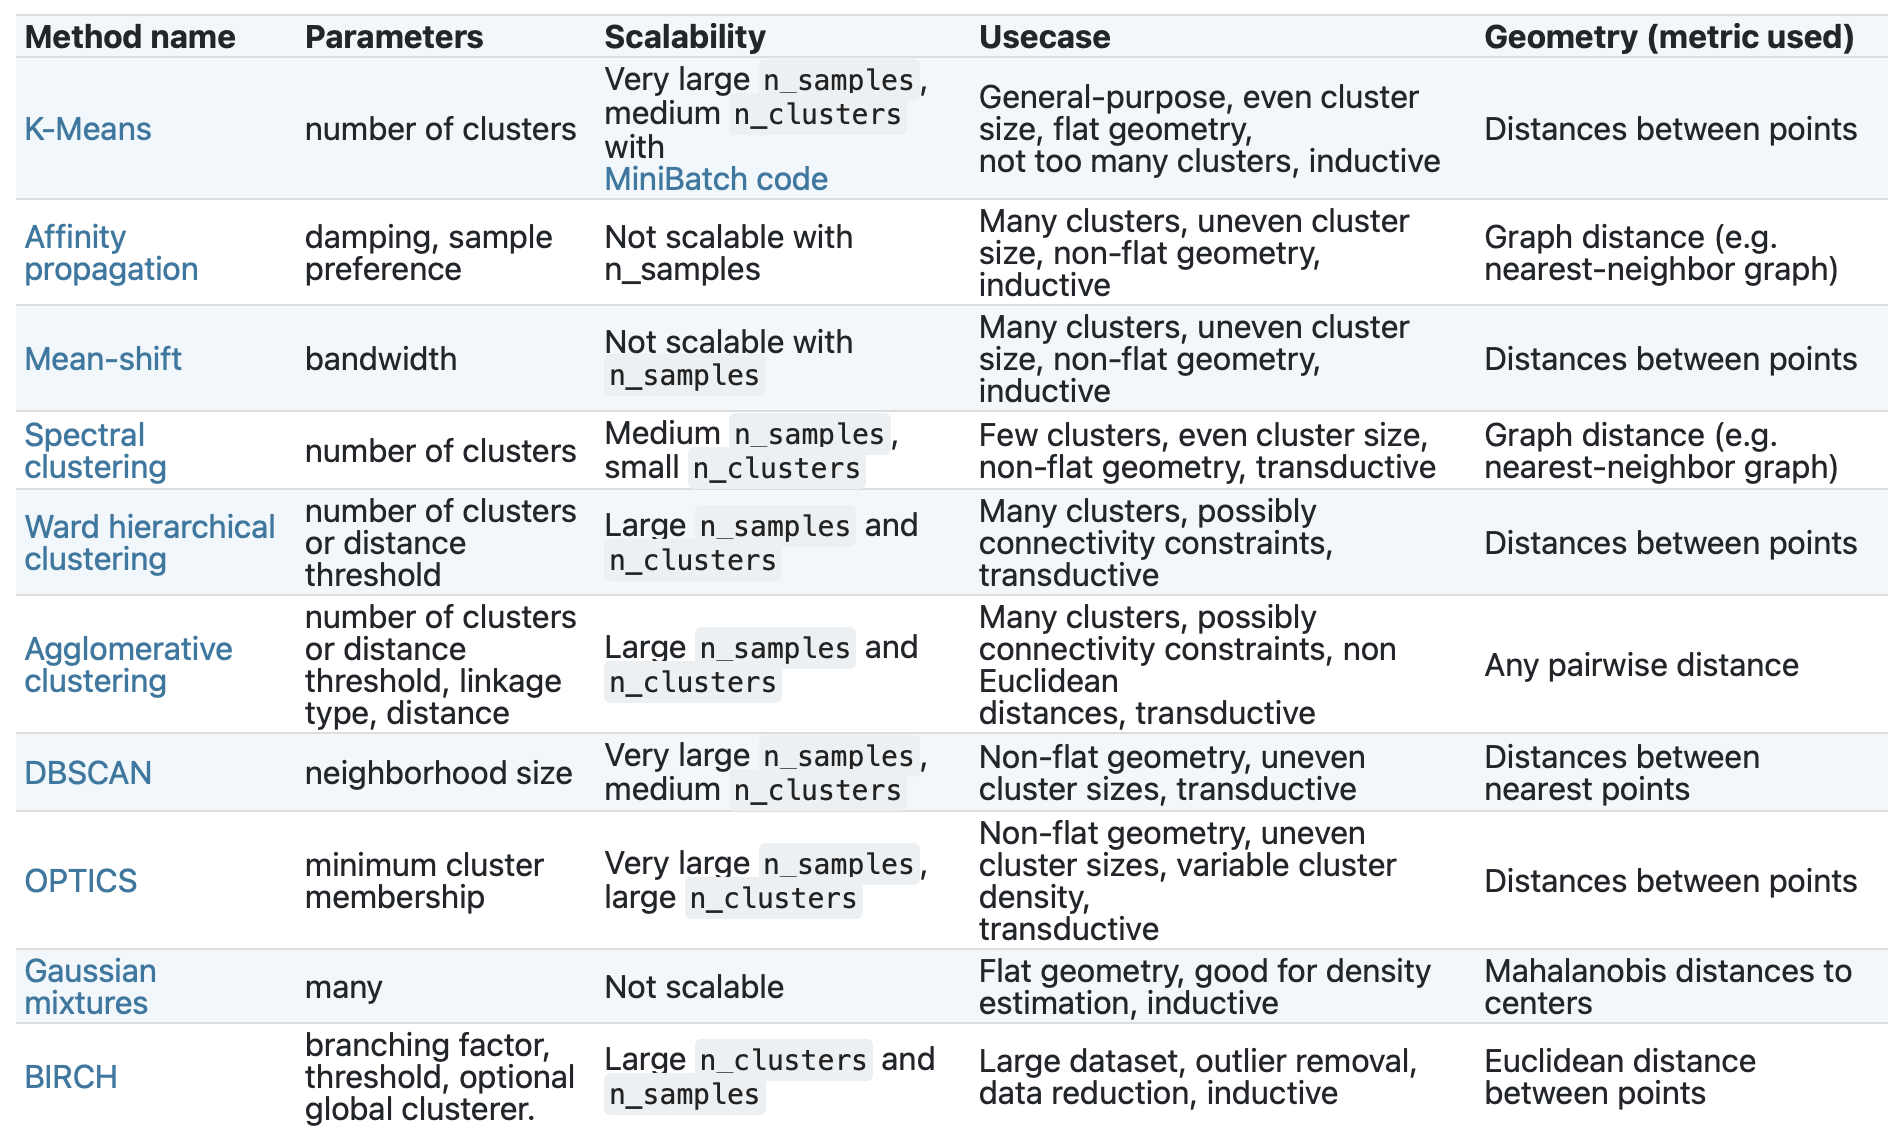

Plusieurs algorithmes possibles :
    
    - K-Means : nombre de clusters connu (7), grand dataset avec des clusters de moyenne taille, pas trop de clusters
        Problème : "Even cluster size" alors que nos classes de son pas bien réparties 
        Conclusion : Correspond bien
        
    - Affinity propagation : Not scalable
    - Mean-shift : Not scalable
    - Spectral clustering : nombre de clusters connu (7), moyen dataset, pas trop de clusters
        Problème : Petits cluster et toujours "even cluster size"
        Conclusion : Nous avons certaines classes avec beaucoup d'éléments ce qui pourrait être un problème
        
    - Ward hierarchical clustering : nombre de clusters connu (7), grand dataset avec des clusters de moyenne
        taille, pas trop de clusters
        Conclusion : Aucun problème, correspond bien
    - Agglomerative clustering : Autre version de Ward hierarchical clustering avec plus de paramètres
    - DBSCAN : Très grand dataset
    - OPTICS : Très grand dataset
    - Gaussian mixtures : Not scalable
    - BIRCH : Pourrait bien correspondre également mais paramètres moins adaptés
    
    
Nous utilisons K-Means(MiniBatchKMeans qui est meilleur pour des dataset de plus de 10,000 échantillons) et Ward Hierarchical Clustering(Agglomerative clustering)

On essaiera également Spectral Clustering

Conseils : Utiliser PCA avant KMeans

In [3]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering

In [4]:
ferData = np.loadtxt('fer2013.csv', delimiter=',', dtype=str )

Xtrain_FER = np.ones((28709,2304), np.uint8)
for i in range(1, 28710):
    Xtrain_FER[i-1] = ferData[i,1].split(' ')
ytrain_FER = ferData[1:28710,0].astype(np.uint8)

Xval_FER = np.ones((3589,2304), np.uint8)
for i in range(28710, 32299):
    Xval_FER[i-28710] = ferData[i,1].split(' ')
yval_FER = ferData[28710:32299,0].astype(np.uint8)

Xtest_FER = np.ones((3589,2304), np.uint8)
for i in range(32299, 35888):
    Xtest_FER[i-32299] = ferData[i,1].split(' ')
ytest_FER = ferData[32299:,0].astype(np.uint8)

WIDTH = 48
HEIGHT = 48

scaler = MinMaxScaler()
scaler.fit(Xtrain_FER)
Xtrain_scaled_FER = scaler.transform(Xtrain_FER)
Xval_scaled_FER = scaler.transform(Xval_FER)
Xtest_scaled_FER = scaler.transform(Xtest_FER)

Xtrain_CNN_FER = np.reshape(Xtrain_scaled_FER , (Xtrain_scaled_FER.shape[0],1,48,48))
Xval_CNN_FER = np.reshape(Xval_scaled_FER , (Xval_scaled_FER.shape[0],1,48,48))
Xtest_CNN_FER = np.reshape(Xtest_scaled_FER , (Xtest_scaled_FER.shape[0],1,48,48))

In [5]:
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Méthode pour la détermination des émotions de chaque cluster
# Matrice de distribution des émotions dans les clusters
def emotionCluster(pred_cluster, y):
    nb_images = len(pred_cluster)
    matrice = np.zeros( (7,7), dtype=int) # Cluster en ligne, emotion en colonne
    for i in range(nb_images):
        cluster = pred_cluster[i]
        emotion = y[i]
        matrice[cluster, emotion] += 1
        
    print(matrice) 
    
    return matrice 

# Méthode pour connaître le pourcentage de chaque classe présent dans chaque cluster
# matrice[i,j] donne le pourcentage d'éléments de la classe j présents dans le cluster i
def matriceEnPourcent(matrice):
    sommes = np.zeros(7)
    copy = np.copy(matrice)
    copy = copy.astype(float)
    for j in range(7):
        sommes[j] = np.sum(matrice[:,j])
    
    for i in range(7):
        for j in range(7):
            copy[i,j] = round((matrice[i,j])*100/sommes[j],1)
    
    print(copy)
    
    return copy


# Prediction de l'émotion du cluster grâce à l'émotion dominante dans chaque cluster
# Le résultat est un tableau tel que res[i] donne l'émotion du cluster i
def predClusterMEIC(matrice):
    res = np.zeros(7, dtype=int)
    for i in range(7):
        res[i] = np.argmax(matrice[i])
    
    resString = []
    for j in range(7):
        resString.append(labels[res[j]])
        
    print(res)
    print(resString)
    
    return res, resString


# Prediction de l'émotion du cluster grâce au cluster dominant pour chaque émotion
# Le résultat est un tableau tel que res[i] donne le cluster de l'émotion i
def predClusterMCIE(matrice):
    res = np.zeros(7, dtype=int)
    for i in range(7):
        res[i] = np.argmax(matrice[:,i])
        
    print(res)
    
    return res

    

def comparaison_prediction(predictions, y):
    nb_correctes = 0
    nb_fausses = 0
    nb_images = len(predictions)
    matrice = np.zeros( (7,7), dtype=int) # reel en ligne, prediction en colonne
    for i in range(nb_images):
        matrice[y[i], predictions[i]] += 1
        if predictions[i]==y[i]:
            nb_correctes += 1
        else :
            nb_fausses += 1
    
    print(" Matrice de confusion" )
    print(matrice)
    print("##################")
    print("##################")
    print("Nombre correctes : " + str(nb_correctes))
    print("Nombre fausses : " + str(nb_fausses))

In [6]:
# Fonction de réduction des primitives sur 2 composantes via PCA
"""If n_components == 'mle' and svd_solver == 'full',
Minka’s MLE is used to guess the dimension.
Use of n_components == 'mle' will interpret svd_solver == 'auto' as svd_solver == 'full'.

If 0 < n_components < 1 and svd_solver == 'full',
select the number of components such that the amount of variance that needs
to be explained is greater than the percentage specified by n_components."""

def reducPCA(X, components, svd_solver='auto') :
    if len(X.shape) == 2 : 
        Xreshape = X.astype('uint8')
    if len(X.shape) == 3 :
        Xreshape = X.reshape(X.shape[0], X.shape[1]*X.shape[2]).astype('uint8')
    if len(X.shape) == 4 : 
        Xreshape = X.reshape(X.shape[0], X.shape[1]*X.shape[2]*X.shape[3]).astype('uint8')
    pca = PCA(n_components=components, svd_solver = svd_solver)
    X_pca = pca.fit(Xreshape).transform(Xreshape)
    
    return X_pca, pca


# Fonction d'affichage du PCA des primitives en 2D

def affichagePCA(pca, train_pca, ytrain, nomdonnee="FER"):
    # Pourcentage de variance expliqué par chaque composante
    print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

    plt.figure()
    colors = ['navy', 'turquoise', 'darkorange', 'red', 'chartreuse', 'yellow', 'hotpink']
    lw = 2

    for color, i, target_name in zip(colors, [0, 1, 2, 3, 4, 5 , 6], labels):
        plt.scatter(train_pca[ytrain == i, 0], train_pca[ytrain == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title("PCA on " + nomdonnee + " dataset")

    plt.show()

## K-Means

In [ ]:
#Implementation MiniBatchK-Means

# Sans PCA : 

    # Non scaled

kmeans_FER = MiniBatchKMeans(n_clusters=7, verbose=1).fit(Xtrain_FER)


Init 1/3 with method: k-means++
Inertia for init 1/3: 1903803022.425644
Init 2/3 with method: k-means++
Inertia for init 2/3: 1970566784.513152
Init 3/3 with method: k-means++
Inertia for init 3/3: 2016174512.819518
Minibatch iteration 1/28800: mean batch inertia: 6262527.673678, ewa inertia: 6262527.673678 
Minibatch iteration 2/28800: mean batch inertia: 6363207.523620, ewa inertia: 6263229.031044 
Minibatch iteration 3/28800: mean batch inertia: 6102841.251599, ewa inertia: 6262111.735472 
Minibatch iteration 4/28800: mean batch inertia: 6278234.522969, ewa inertia: 6262224.050257 
Minibatch iteration 5/28800: mean batch inertia: 6465563.246323, ewa inertia: 6263640.554584 
Minibatch iteration 6/28800: mean batch inertia: 6351425.299870, ewa inertia: 6264252.081893 
Minibatch iteration 7/28800: mean batch inertia: 6127188.099963, ewa inertia: 6263297.264882 
Minibatch iteration 8/28800: mean batch inertia: 6213615.772627, ewa inertia: 6262951.172982 
Minibatch iteration 9/28800: mea

In [ ]:
pred_KM_FER = kmeans_FER.predict(Xtrain_FER)
print(pred_KM_FER)

Computing label assignment and total inertia
[5 3 6 ... 3 3 0]


In [ ]:
pred_km_fer_val = kmeans_FER.predict(Xval_FER)
print(pred_km_fer_val)
matrice1 = emotionCluster(pred_km_fer_val, yval_FER)
print("res[i] donne le cluster de l'émotion i")
predClusterMCIE(matrice1)
print("res[i] donne l'émotion du cluster i")
predClusterMEIC(matrice1)

Computing label assignment and total inertia
[6 3 2 ... 0 5 4]
[[ 57  12 107 114  68 133  76]
 [ 85  13  65 149 136  42 102]
 [ 66   9  60 102 106  50  79]
 [ 75  10  97 124  86  75  81]
 [ 66   2  53 128 128  13 104]
 [ 46   4  46 114  66  41  69]
 [ 72   6  68 164  63  61  96]]
res[i] donne le cluster de l'émotion i
[1 1 0 6 1 0 4]
res[i] donne l'émotion du cluster i
[5 3 4 3 3 3 3]
['Surprise', 'Happy', 'Sad', 'Happy', 'Happy', 'Happy', 'Happy']


(array([5, 3, 4, 3, 3, 3, 3]),
 ['Surprise', 'Happy', 'Sad', 'Happy', 'Happy', 'Happy', 'Happy'])

In [ ]:
matricePR1 = matriceEnPourcent(matrice1)
print("res[i] donne l'émotion du cluster i")
predClusterMEIC(matricePR1)

[[12.2 21.4 21.6 12.7 10.4 32.  12.5]
 [18.2 23.2 13.1 16.6 20.8 10.1 16.8]
 [14.1 16.1 12.1 11.4 16.2 12.  13. ]
 [16.1 17.9 19.6 13.9 13.2 18.1 13.3]
 [14.1  3.6 10.7 14.3 19.6  3.1 17.1]
 [ 9.9  7.1  9.3 12.7 10.1  9.9 11.4]
 [15.4 10.7 13.7 18.3  9.6 14.7 15.8]]
res[i] donne l'émotion du cluster i
[5 1 4 2 4 3 3]
['Surprise', 'Disgust', 'Sad', 'Fear', 'Sad', 'Happy', 'Happy']


(array([5, 1, 4, 2, 4, 3, 3]),
 ['Surprise', 'Disgust', 'Sad', 'Fear', 'Sad', 'Happy', 'Happy'])

Le fait d'avoir un dataset non équilibré complique la prédiction automatique de chaque cluster.
En utilisant une méthode par pourcentage on peut cependant deviner la classe de chaque cluster.
matrice[i,j] donne le pourcentage d'éléments de la classe j présents dans le cluster i, ainsi en prenant la classe qui a la majorité de de ses données dans un cluster on peut attribuer cette classe à ce cluster.

labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

Ici, la répartition avec l'ensemble de validation est :

   - Cluster 0 : Suprise (32% des "Surprise" dans ce cluster)
   - Cluster 1 : Disgust (23.2% des "Disgust" dans ce cluster)
   - Cluster 2 : Sad (16.2% des "Sad" dans ce cluster)
   - Cluster 3 : Fear (19.6% des "Fear" dans ce cluster)
   - Cluster 4 : Sad (19,6% des "Sad" dans ce cluster)
   - Cluster 5 : Happy (12.7% des "Surprise" dans ce cluster)
   - Cluster 6 : Happy (18.3% des "Happy" dans ce cluster)
   
Cette répartition présente 2 émotions representées par 2 clusters : Sad et Happy et oublie 2 émotions : Angry et Neutral.
Nous allons donc finir à la main la répartition en regardant l'écart en les pourcentages dans chaque cluster :
   - Cluster 0 : Suprise : Pas de doute, écart large
   - Cluster 1 : Disgust : Pas de doute, écart assez large
   - Cluster 2 : Sad : Doute avec classe 0(Angry) et classe 1(Disgust : Déjà choisie) => Angry car Sad est cluster4
   - Cluster 3 : Fear : Pas de doute car assez proche de classe 5 (Surprise : Déjà choisie) et classe 1(Disgust : Déjà choisie) mais les deux sont déjà choisies
   - Cluster 4 : Sad : Assez large, ce cluster semble bien être "Sad"
   - Cluster 5 : Happy : Doute avec classe 6(Neutral) => Neutral car Happy est cluster 6
   - Cluster 6 : Happy : Assez large, ce cluster semble bien être "Sad"
   
On remarque que les émotions pour lesquels il y des doutes sont des émotions qui sont proches :
Sad, Angry et disgust ; Happy et Neutral ; Surprise et Fear

Finalement : 
   - Cluster 0 : Suprise
   - Cluster 1 : Disgust
   - Cluster 2 : Angry 
   - Cluster 3 : Fear 
   - Cluster 4 : Sad 
   - Cluster 5 : Neutral
   - Cluster 6 : Happy
   

In [ ]:
# Correspondance
labels1 = ['Surprise','Disgust','Angry', 'Fear','Sad', 'Neutral', 'Happy']

In [ ]:
# Essai sans max_no_improvement pour traiter l'ensemble du jeu de données
kmeans_FER_0 = MiniBatchKMeans(n_clusters=7, verbose=1, max_no_improvement=None).fit(Xtrain_FER)
pred_KM_FER_0 = kmeans_FER_0.predict(Xtrain_FER)
print(pred_KM_FER_0)
pred_km_fer_val_0 = kmeans_FER_0.predict(Xval_FER)
print("#################")
print(pred_km_fer_val_0)
print("#################")
matrice0 = emotionCluster(pred_km_fer_val_0, yval_FER)
print("#################")
print("res[i] donne le cluster de l'émotion i")
print("#################")
predClusterMCIE(matrice0)
print("#################")
print("res[i] donne l'émotion du cluster i")
print("#################")
predClusterMEIC(matrice0)
print("#################")
matricePR0 = matriceEnPourcent(matrice0)
print("#################")
print("res[i] donne l'émotion du cluster i")
print("#################")
predClusterMEIC(matricePR0)

Init 1/3 with method: k-means++
Inertia for init 1/3: 1912798267.980690
Init 2/3 with method: k-means++
Inertia for init 2/3: 1951837906.888664
Init 3/3 with method: k-means++
Inertia for init 3/3: 1845608565.351623
Minibatch iteration 1/28800: mean batch inertia: 6205354.858918, ewa inertia: 6205354.858918 
Minibatch iteration 2/28800: mean batch inertia: 6555578.998912, ewa inertia: 6207794.595177 
Minibatch iteration 3/28800: mean batch inertia: 6173591.655037, ewa inertia: 6207556.330181 
Minibatch iteration 4/28800: mean batch inertia: 5938987.357726, ewa inertia: 6205685.421282 
Minibatch iteration 5/28800: mean batch inertia: 6105912.281134, ewa inertia: 6204990.380250 
Minibatch iteration 6/28800: mean batch inertia: 6068860.614634, ewa inertia: 6204042.071190 
Minibatch iteration 7/28800: mean batch inertia: 5672622.936309, ewa inertia: 6200340.091846 
Minibatch iteration 8/28800: mean batch inertia: 6018763.191497, ewa inertia: 6199075.188325 
Minibatch iteration 9/28800: mea

Minibatch iteration 104/28800: mean batch inertia: 6125514.931350, ewa inertia: 6183983.429817 
Minibatch iteration 105/28800: mean batch inertia: 6364995.465473, ewa inertia: 6185244.398369 
Minibatch iteration 106/28800: mean batch inertia: 6665263.752042, ewa inertia: 6188588.315845 
Minibatch iteration 107/28800: mean batch inertia: 6104546.562234, ewa inertia: 6188002.863016 
Minibatch iteration 108/28800: mean batch inertia: 6036500.978098, ewa inertia: 6186947.468485 
Minibatch iteration 109/28800: mean batch inertia: 5860782.121059, ewa inertia: 6184675.330920 
Minibatch iteration 110/28800: mean batch inertia: 5726307.604094, ewa inertia: 6181482.243307 
Minibatch iteration 111/28800: mean batch inertia: 6159338.053585, ewa inertia: 6181327.982146 
Minibatch iteration 112/28800: mean batch inertia: 6392381.187330, ewa inertia: 6182798.223909 
Minibatch iteration 113/28800: mean batch inertia: 6112203.022652, ewa inertia: 6182306.442640 
Minibatch iteration 114/28800: mean batc

Minibatch iteration 221/28800: mean batch inertia: 6506879.174434, ewa inertia: 6156944.778433 
Minibatch iteration 222/28800: mean batch inertia: 6355149.963398, ewa inertia: 6158325.518140 
Minibatch iteration 223/28800: mean batch inertia: 5939698.755312, ewa inertia: 6156802.517354 
Minibatch iteration 224/28800: mean batch inertia: 6284061.291452, ewa inertia: 6157689.029190 
Minibatch iteration 225/28800: mean batch inertia: 6643827.694719, ewa inertia: 6161075.575102 
Minibatch iteration 226/28800: mean batch inertia: 6557419.995897, ewa inertia: 6163836.595100 
Minibatch iteration 227/28800: mean batch inertia: 5853684.818792, ewa inertia: 6161676.011496 
Minibatch iteration 228/28800: mean batch inertia: 5594806.443844, ewa inertia: 6157727.076856 
Minibatch iteration 229/28800: mean batch inertia: 5965192.634797, ewa inertia: 6156385.840757 
Minibatch iteration 230/28800: mean batch inertia: 5952852.214718, ewa inertia: 6154967.981989 
Minibatch iteration 231/28800: mean batc

Minibatch iteration 319/28800: mean batch inertia: 6173352.799648, ewa inertia: 6158431.325940 
Minibatch iteration 320/28800: mean batch inertia: 6326115.822196, ewa inertia: 6159599.452002 
Minibatch iteration 321/28800: mean batch inertia: 6630826.645181, ewa inertia: 6162882.121408 
Minibatch iteration 322/28800: mean batch inertia: 6067584.856491, ewa inertia: 6162218.260280 
Minibatch iteration 323/28800: mean batch inertia: 6029568.035785, ewa inertia: 6161294.190447 
Minibatch iteration 324/28800: mean batch inertia: 6306805.865176, ewa inertia: 6162307.855893 
Minibatch iteration 325/28800: mean batch inertia: 6473592.870292, ewa inertia: 6164476.333875 
Minibatch iteration 326/28800: mean batch inertia: 5785513.409226, ewa inertia: 6161836.397096 
Minibatch iteration 327/28800: mean batch inertia: 5767646.556665, ewa inertia: 6159090.386365 
Minibatch iteration 328/28800: mean batch inertia: 5786046.315742, ewa inertia: 6156491.681589 
Minibatch iteration 329/28800: mean batc

Minibatch iteration 424/28800: mean batch inertia: 6198686.455475, ewa inertia: 6129627.902905 
Minibatch iteration 425/28800: mean batch inertia: 6214705.360972, ewa inertia: 6130220.570673 
Minibatch iteration 426/28800: mean batch inertia: 6551785.541663, ewa inertia: 6133157.282418 
Minibatch iteration 427/28800: mean batch inertia: 6461460.108391, ewa inertia: 6135444.310116 
Minibatch iteration 428/28800: mean batch inertia: 6348637.086400, ewa inertia: 6136929.456589 
Minibatch iteration 429/28800: mean batch inertia: 6609374.940175, ewa inertia: 6140220.612866 
Minibatch iteration 430/28800: mean batch inertia: 5625989.824001, ewa inertia: 6136638.371216 
Minibatch iteration 431/28800: mean batch inertia: 6265509.826518, ewa inertia: 6137536.117335 
Minibatch iteration 432/28800: mean batch inertia: 6074227.917337, ewa inertia: 6137095.098874 
Minibatch iteration 433/28800: mean batch inertia: 6592324.537303, ewa inertia: 6140266.324499 
Minibatch iteration 434/28800: mean batc

Minibatch iteration 555/28800: mean batch inertia: 6660927.260661, ewa inertia: 6134528.090015 
Minibatch iteration 556/28800: mean batch inertia: 6087444.889751, ewa inertia: 6134200.098372 
Minibatch iteration 557/28800: mean batch inertia: 5924173.991650, ewa inertia: 6132737.011596 
Minibatch iteration 558/28800: mean batch inertia: 5965871.575131, ewa inertia: 6131574.591280 
Minibatch iteration 559/28800: mean batch inertia: 5561139.792235, ewa inertia: 6127600.820475 
Minibatch iteration 560/28800: mean batch inertia: 6615494.760641, ewa inertia: 6130999.594004 
Minibatch iteration 561/28800: mean batch inertia: 5626881.218103, ewa inertia: 6127487.797586 
Minibatch iteration 562/28800: mean batch inertia: 6383457.429911, ewa inertia: 6129270.936787 
Minibatch iteration 563/28800: mean batch inertia: 6022464.404950, ewa inertia: 6128526.899644 
Minibatch iteration 564/28800: mean batch inertia: 6527542.363641, ewa inertia: 6131306.526701 
Minibatch iteration 565/28800: mean batc

Minibatch iteration 660/28800: mean batch inertia: 6455130.991555, ewa inertia: 6119984.281004 
Minibatch iteration 661/28800: mean batch inertia: 6079353.815065, ewa inertia: 6119701.240489 
Minibatch iteration 662/28800: mean batch inertia: 6222223.002575, ewa inertia: 6120415.429009 
Minibatch iteration 663/28800: mean batch inertia: 6002971.067523, ewa inertia: 6119597.286470 
Minibatch iteration 664/28800: mean batch inertia: 6107930.123455, ewa inertia: 6119516.010517 
Minibatch iteration 665/28800: mean batch inertia: 6080204.506193, ewa inertia: 6119242.158171 
Minibatch iteration 666/28800: mean batch inertia: 6314384.877507, ewa inertia: 6120601.564087 
Minibatch iteration 667/28800: mean batch inertia: 6049216.013110, ewa inertia: 6120104.277073 
Minibatch iteration 668/28800: mean batch inertia: 5906412.596197, ewa inertia: 6118615.655123 
Minibatch iteration 669/28800: mean batch inertia: 6115281.878995, ewa inertia: 6118592.431325 
Minibatch iteration 670/28800: mean batc

Minibatch iteration 785/28800: mean batch inertia: 6236695.987368, ewa inertia: 6143879.258738 
Minibatch iteration 786/28800: mean batch inertia: 5956636.300107, ewa inertia: 6142574.884243 
Minibatch iteration 787/28800: mean batch inertia: 6128655.710156, ewa inertia: 6142477.920300 
Minibatch iteration 788/28800: mean batch inertia: 5997131.138324, ewa inertia: 6141465.403532 
Minibatch iteration 789/28800: mean batch inertia: 6359825.147017, ewa inertia: 6142986.544205 
Minibatch iteration 790/28800: mean batch inertia: 5802258.726269, ewa inertia: 6140612.961356 
Minibatch iteration 791/28800: mean batch inertia: 6679561.324785, ewa inertia: 6144367.390916 
Minibatch iteration 792/28800: mean batch inertia: 6447426.989772, ewa inertia: 6146478.568895 
Minibatch iteration 793/28800: mean batch inertia: 5710354.784712, ewa inertia: 6143440.437344 
Minibatch iteration 794/28800: mean batch inertia: 6654688.849644, ewa inertia: 6147001.903121 
Minibatch iteration 795/28800: mean batc

Minibatch iteration 918/28800: mean batch inertia: 6292912.250254, ewa inertia: 6125486.018280 
Minibatch iteration 919/28800: mean batch inertia: 6080761.986125, ewa inertia: 6125174.461107 
Minibatch iteration 920/28800: mean batch inertia: 6204585.923844, ewa inertia: 6125727.658340 
Minibatch iteration 921/28800: mean batch inertia: 6272773.886098, ewa inertia: 6126752.013810 
Minibatch iteration 922/28800: mean batch inertia: 5659832.042129, ewa inertia: 6123499.349430 
Minibatch iteration 923/28800: mean batch inertia: 6222701.691452, ewa inertia: 6124190.414161 
Minibatch iteration 924/28800: mean batch inertia: 6291743.647139, ewa inertia: 6125357.625815 
Minibatch iteration 925/28800: mean batch inertia: 6231441.779625, ewa inertia: 6126096.630718 
Minibatch iteration 926/28800: mean batch inertia: 5876069.194117, ewa inertia: 6124354.886123 
Minibatch iteration 927/28800: mean batch inertia: 6518841.065045, ewa inertia: 6127102.961211 
Minibatch iteration 928/28800: mean batc

Minibatch iteration 1051/28800: mean batch inertia: 6086314.726475, ewa inertia: 6126198.560493 
Minibatch iteration 1052/28800: mean batch inertia: 6258277.510435, ewa inertia: 6127118.650705 
Minibatch iteration 1053/28800: mean batch inertia: 5921275.069119, ewa inertia: 6125684.700293 
Minibatch iteration 1054/28800: mean batch inertia: 6213483.399395, ewa inertia: 6126296.324808 
Minibatch iteration 1055/28800: mean batch inertia: 6188379.051200, ewa inertia: 6126728.806357 
Minibatch iteration 1056/28800: mean batch inertia: 6161966.422824, ewa inertia: 6126974.279130 
Minibatch iteration 1057/28800: mean batch inertia: 6072730.143152, ewa inertia: 6126596.402878 
Minibatch iteration 1058/28800: mean batch inertia: 6716588.463706, ewa inertia: 6130706.413751 
Minibatch iteration 1059/28800: mean batch inertia: 5861420.784633, ewa inertia: 6128830.512468 
Minibatch iteration 1060/28800: mean batch inertia: 6288342.326253, ewa inertia: 6129941.705877 
Minibatch iteration 1061/28800

Minibatch iteration 1170/28800: mean batch inertia: 5674172.381534, ewa inertia: 6107272.228551 
Minibatch iteration 1171/28800: mean batch inertia: 6636260.550171, ewa inertia: 6110957.274331 
Minibatch iteration 1172/28800: mean batch inertia: 5981021.547996, ewa inertia: 6110052.114273 
Minibatch iteration 1173/28800: mean batch inertia: 6261881.994127, ewa inertia: 6111109.793686 
Minibatch iteration 1174/28800: mean batch inertia: 6016185.190679, ewa inertia: 6110448.528601 
Minibatch iteration 1175/28800: mean batch inertia: 5787133.332795, ewa inertia: 6108196.245802 
Minibatch iteration 1176/28800: mean batch inertia: 6111666.823267, ewa inertia: 6108220.422587 
Minibatch iteration 1177/28800: mean batch inertia: 5897672.161966, ewa inertia: 6106753.698375 
Minibatch iteration 1178/28800: mean batch inertia: 6236398.750351, ewa inertia: 6107656.833533 
Minibatch iteration 1179/28800: mean batch inertia: 6096476.682398, ewa inertia: 6107578.950209 
Minibatch iteration 1180/28800

Minibatch iteration 1274/28800: mean batch inertia: 5700471.169523, ewa inertia: 6117878.184385 
Minibatch iteration 1275/28800: mean batch inertia: 6274719.315411, ewa inertia: 6118970.773246 
Minibatch iteration 1276/28800: mean batch inertia: 6575753.586235, ewa inertia: 6122152.820010 
Minibatch iteration 1277/28800: mean batch inertia: 6310376.703657, ewa inertia: 6123464.027838 
Minibatch iteration 1278/28800: mean batch inertia: 6353720.127294, ewa inertia: 6125068.041070 
Minibatch iteration 1279/28800: mean batch inertia: 6474895.901109, ewa inertia: 6127505.016758 
Minibatch iteration 1280/28800: mean batch inertia: 6028015.374790, ewa inertia: 6126811.950635 
Minibatch iteration 1281/28800: mean batch inertia: 6321550.634413, ewa inertia: 6128168.541953 
Minibatch iteration 1282/28800: mean batch inertia: 6161301.631455, ewa inertia: 6128399.354141 
Minibatch iteration 1283/28800: mean batch inertia: 6216639.128076, ewa inertia: 6129014.051277 
Minibatch iteration 1284/28800

Minibatch iteration 1402/28800: mean batch inertia: 6469974.596546, ewa inertia: 6131438.876909 
Minibatch iteration 1403/28800: mean batch inertia: 6312294.116556, ewa inertia: 6132698.753187 
Minibatch iteration 1404/28800: mean batch inertia: 6149107.185929, ewa inertia: 6132813.057838 
Minibatch iteration 1405/28800: mean batch inertia: 6145367.522218, ewa inertia: 6132900.514922 
Minibatch iteration 1406/28800: mean batch inertia: 6050979.460543, ewa inertia: 6132329.835337 
Minibatch iteration 1407/28800: mean batch inertia: 5757677.538329, ewa inertia: 6129719.927312 
Minibatch iteration 1408/28800: mean batch inertia: 6425458.972019, ewa inertia: 6131780.108745 
Minibatch iteration 1409/28800: mean batch inertia: 5606557.348952, ewa inertia: 6128121.294675 
Minibatch iteration 1410/28800: mean batch inertia: 6045041.057977, ewa inertia: 6127542.539978 
Minibatch iteration 1411/28800: mean batch inertia: 6473364.983525, ewa inertia: 6129951.613079 
Minibatch iteration 1412/28800

Minibatch iteration 1517/28800: mean batch inertia: 6479823.854579, ewa inertia: 6134729.109754 
Minibatch iteration 1518/28800: mean batch inertia: 6171783.275047, ewa inertia: 6134987.236994 
Minibatch iteration 1519/28800: mean batch inertia: 5967707.639185, ewa inertia: 6133821.931540 
Minibatch iteration 1520/28800: mean batch inertia: 6165054.619317, ewa inertia: 6134039.505123 
Minibatch iteration 1521/28800: mean batch inertia: 5908612.066427, ewa inertia: 6132469.129374 
Minibatch iteration 1522/28800: mean batch inertia: 6531390.089399, ewa inertia: 6135248.098096 
Minibatch iteration 1523/28800: mean batch inertia: 6613573.875611, ewa inertia: 6138580.217759 
Minibatch iteration 1524/28800: mean batch inertia: 6113344.505367, ewa inertia: 6138404.420389 
Minibatch iteration 1525/28800: mean batch inertia: 6384053.361665, ewa inertia: 6140115.663449 
Minibatch iteration 1526/28800: mean batch inertia: 6031032.586966, ewa inertia: 6139355.767410 
Minibatch iteration 1527/28800

Minibatch iteration 1651/28800: mean batch inertia: 5894067.688918, ewa inertia: 6119927.912886 
Minibatch iteration 1652/28800: mean batch inertia: 6079186.382949, ewa inertia: 6119644.098676 
Minibatch iteration 1653/28800: mean batch inertia: 5919803.341256, ewa inertia: 6118251.965221 
Minibatch iteration 1654/28800: mean batch inertia: 6656593.624342, ewa inertia: 6122002.168350 
Minibatch iteration 1655/28800: mean batch inertia: 6158736.380882, ewa inertia: 6122258.066730 
Minibatch iteration 1656/28800: mean batch inertia: 6279253.037773, ewa inertia: 6123351.727274 
Minibatch iteration 1657/28800: mean batch inertia: 6762010.810927, ewa inertia: 6127800.763036 
Minibatch iteration 1658/28800: mean batch inertia: 6258593.523438, ewa inertia: 6128711.893377 
Minibatch iteration 1659/28800: mean batch inertia: 6161568.330589, ewa inertia: 6128940.778345 
Minibatch iteration 1660/28800: mean batch inertia: 6415410.640276, ewa inertia: 6130936.388668 
Minibatch iteration 1661/28800

Minibatch iteration 1785/28800: mean batch inertia: 6464981.131081, ewa inertia: 6144069.486090 
Minibatch iteration 1786/28800: mean batch inertia: 5944657.022272, ewa inertia: 6142680.336220 
Minibatch iteration 1787/28800: mean batch inertia: 6589324.021318, ewa inertia: 6145791.751651 
Minibatch iteration 1788/28800: mean batch inertia: 6160564.925654, ewa inertia: 6145894.664740 
Minibatch iteration 1789/28800: mean batch inertia: 6120173.217969, ewa inertia: 6145715.483641 
Minibatch iteration 1790/28800: mean batch inertia: 6227046.357813, ewa inertia: 6146282.051904 
Minibatch iteration 1791/28800: mean batch inertia: 6227997.219145, ewa inertia: 6146851.297235 
Minibatch iteration 1792/28800: mean batch inertia: 6206335.818622, ewa inertia: 6147265.679133 
Minibatch iteration 1793/28800: mean batch inertia: 6558600.874016, ewa inertia: 6150131.128070 
Minibatch iteration 1794/28800: mean batch inertia: 6008495.612897, ewa inertia: 6149144.464780 
Minibatch iteration 1795/28800

Minibatch iteration 1915/28800: mean batch inertia: 6360304.931946, ewa inertia: 6143248.649104 
Minibatch iteration 1916/28800: mean batch inertia: 6674920.891979, ewa inertia: 6146952.391653 
Minibatch iteration 1917/28800: mean batch inertia: 5841044.208011, ewa inertia: 6144821.369823 
Minibatch iteration 1918/28800: mean batch inertia: 6013649.085529, ewa inertia: 6143907.595638 
Minibatch iteration 1919/28800: mean batch inertia: 6232953.663726, ewa inertia: 6144527.909592 
Minibatch iteration 1920/28800: mean batch inertia: 6243500.108896, ewa inertia: 6145217.371099 
Minibatch iteration 1921/28800: mean batch inertia: 5957461.504630, ewa inertia: 6143909.423579 
Minibatch iteration 1922/28800: mean batch inertia: 5924018.001501, ewa inertia: 6142377.612906 
Minibatch iteration 1923/28800: mean batch inertia: 6341561.934392, ewa inertia: 6143765.173488 
Minibatch iteration 1924/28800: mean batch inertia: 6434894.888540, ewa inertia: 6145793.245345 
Minibatch iteration 1925/28800

Minibatch iteration 2045/28800: mean batch inertia: 6120985.369250, ewa inertia: 6143644.964276 
Minibatch iteration 2046/28800: mean batch inertia: 6654643.907704, ewa inertia: 6147204.692199 
Minibatch iteration 2047/28800: mean batch inertia: 6226992.699381, ewa inertia: 6147760.512521 
Minibatch iteration 2048/28800: mean batch inertia: 5973614.422701, ewa inertia: 6146547.373616 
Minibatch iteration 2049/28800: mean batch inertia: 6057151.092791, ewa inertia: 6145924.620005 
Minibatch iteration 2050/28800: mean batch inertia: 5802034.951612, ewa inertia: 6143529.011030 
Minibatch iteration 2051/28800: mean batch inertia: 6511032.030927, ewa inertia: 6146089.115662 
Minibatch iteration 2052/28800: mean batch inertia: 6392245.585875, ewa inertia: 6147803.894277 
Minibatch iteration 2053/28800: mean batch inertia: 6138039.594523, ewa inertia: 6147735.874077 
Minibatch iteration 2054/28800: mean batch inertia: 6054847.861079, ewa inertia: 6147088.796313 
Minibatch iteration 2055/28800

Minibatch iteration 2165/28800: mean batch inertia: 6130432.199582, ewa inertia: 6128404.662755 
Minibatch iteration 2166/28800: mean batch inertia: 6079235.523122, ewa inertia: 6128062.140012 
Minibatch iteration 2167/28800: mean batch inertia: 5892652.101465, ewa inertia: 6126422.223338 
Minibatch iteration 2168/28800: mean batch inertia: 5965560.433073, ewa inertia: 6125301.625705 
Minibatch iteration 2169/28800: mean batch inertia: 6548797.758886, ewa inertia: 6128251.790339 
Minibatch iteration 2170/28800: mean batch inertia: 5643516.026532, ewa inertia: 6124875.017341 
Minibatch iteration 2171/28800: mean batch inertia: 6107917.211054, ewa inertia: 6124756.885636 
Minibatch iteration 2172/28800: mean batch inertia: 6176946.339088, ewa inertia: 6125120.448530 
Minibatch iteration 2173/28800: mean batch inertia: 6165197.669457, ewa inertia: 6125399.635022 
Minibatch iteration 2174/28800: mean batch inertia: 6013150.391683, ewa inertia: 6124617.682787 
Minibatch iteration 2175/28800

Minibatch iteration 2286/28800: mean batch inertia: 6488388.788743, ewa inertia: 6138309.243977 
Minibatch iteration 2287/28800: mean batch inertia: 5791908.942108, ewa inertia: 6135896.145392 
Minibatch iteration 2288/28800: mean batch inertia: 6496038.890192, ewa inertia: 6138404.976774 
Minibatch iteration 2289/28800: mean batch inertia: 6058457.133128, ewa inertia: 6137848.042997 
Minibatch iteration 2290/28800: mean batch inertia: 6598802.441546, ewa inertia: 6141059.149918 
Minibatch iteration 2291/28800: mean batch inertia: 6164252.841720, ewa inertia: 6141220.722135 
Minibatch iteration 2292/28800: mean batch inertia: 6123375.652327, ewa inertia: 6141096.409563 
Minibatch iteration 2293/28800: mean batch inertia: 5708906.447645, ewa inertia: 6138085.681859 
Minibatch iteration 2294/28800: mean batch inertia: 6831675.115326, ewa inertia: 6142917.374185 
Minibatch iteration 2295/28800: mean batch inertia: 5966639.529688, ewa inertia: 6141689.385021 
Minibatch iteration 2296/28800

Minibatch iteration 2415/28800: mean batch inertia: 6020124.758679, ewa inertia: 6149523.993562 
Minibatch iteration 2416/28800: mean batch inertia: 6366953.178729, ewa inertia: 6151038.651766 
Minibatch iteration 2417/28800: mean batch inertia: 6087517.783396, ewa inertia: 6150596.151812 
Minibatch iteration 2418/28800: mean batch inertia: 6135992.810446, ewa inertia: 6150494.421813 
Minibatch iteration 2419/28800: mean batch inertia: 5672418.673203, ewa inertia: 6147164.043905 
Minibatch iteration 2420/28800: mean batch inertia: 5953803.968688, ewa inertia: 6145817.056269 
Minibatch iteration 2421/28800: mean batch inertia: 6239183.568669, ewa inertia: 6146467.467362 
Minibatch iteration 2422/28800: mean batch inertia: 6175687.006120, ewa inertia: 6146671.016918 
Minibatch iteration 2423/28800: mean batch inertia: 5945005.567857, ewa inertia: 6145266.172271 
Minibatch iteration 2424/28800: mean batch inertia: 6227814.324483, ewa inertia: 6145841.220353 
Minibatch iteration 2425/28800

Minibatch iteration 2533/28800: mean batch inertia: 6204372.914415, ewa inertia: 6154372.544416 
Minibatch iteration 2534/28800: mean batch inertia: 5913869.569856, ewa inertia: 6152697.149261 
Minibatch iteration 2535/28800: mean batch inertia: 5756199.369470, ewa inertia: 6149935.060930 
Minibatch iteration 2536/28800: mean batch inertia: 6159132.475186, ewa inertia: 6149999.132085 
Minibatch iteration 2537/28800: mean batch inertia: 6283229.614669, ewa inertia: 6150927.244120 
Minibatch iteration 2538/28800: mean batch inertia: 5762094.012959, ewa inertia: 6148218.548675 
Minibatch iteration 2539/28800: mean batch inertia: 6168398.010545, ewa inertia: 6148359.123122 
Minibatch iteration 2540/28800: mean batch inertia: 6130340.955647, ewa inertia: 6148233.604714 
Minibatch iteration 2541/28800: mean batch inertia: 6048256.826526, ewa inertia: 6147537.145095 
Minibatch iteration 2542/28800: mean batch inertia: 6132416.225984, ewa inertia: 6147431.809539 
Minibatch iteration 2543/28800

Minibatch iteration 2653/28800: mean batch inertia: 5833676.536306, ewa inertia: 6137573.531706 
Minibatch iteration 2654/28800: mean batch inertia: 6048317.424048, ewa inertia: 6136951.754572 
Minibatch iteration 2655/28800: mean batch inertia: 5830595.502996, ewa inertia: 6134817.611405 
Minibatch iteration 2656/28800: mean batch inertia: 6145901.971326, ewa inertia: 6134894.827427 
Minibatch iteration 2657/28800: mean batch inertia: 6409465.202562, ewa inertia: 6136807.543380 
Minibatch iteration 2658/28800: mean batch inertia: 5542969.776205, ewa inertia: 6132670.742494 
Minibatch iteration 2659/28800: mean batch inertia: 6251629.093218, ewa inertia: 6133499.431806 
Minibatch iteration 2660/28800: mean batch inertia: 6100388.053044, ewa inertia: 6133268.770860 
Minibatch iteration 2661/28800: mean batch inertia: 6319246.841909, ewa inertia: 6134564.333877 
Minibatch iteration 2662/28800: mean batch inertia: 6090584.083942, ewa inertia: 6134257.958050 
Minibatch iteration 2663/28800

Minibatch iteration 2776/28800: mean batch inertia: 6291424.266384, ewa inertia: 6151206.129404 
Minibatch iteration 2777/28800: mean batch inertia: 6091710.724073, ewa inertia: 6150791.671687 
Minibatch iteration 2778/28800: mean batch inertia: 6246871.588432, ewa inertia: 6151460.984935 
Minibatch iteration 2779/28800: mean batch inertia: 6618926.180758, ewa inertia: 6154717.447462 
Minibatch iteration 2780/28800: mean batch inertia: 6045759.621448, ewa inertia: 6153958.423944 
Minibatch iteration 2781/28800: mean batch inertia: 6163345.681885, ewa inertia: 6154023.817591 
Minibatch iteration 2782/28800: mean batch inertia: 6277338.768289, ewa inertia: 6154882.855910 
Minibatch iteration 2783/28800: mean batch inertia: 6229378.858251, ewa inertia: 6155401.810994 
Minibatch iteration 2784/28800: mean batch inertia: 6184736.043315, ewa inertia: 6155606.159530 
Minibatch iteration 2785/28800: mean batch inertia: 5889757.878045, ewa inertia: 6153754.203546 
Minibatch iteration 2786/28800

Minibatch iteration 2896/28800: mean batch inertia: 6092799.235013, ewa inertia: 6156682.608321 
Minibatch iteration 2897/28800: mean batch inertia: 5694118.399370, ewa inertia: 6153460.287116 
Minibatch iteration 2898/28800: mean batch inertia: 6124696.296235, ewa inertia: 6153259.911004 
Minibatch iteration 2899/28800: mean batch inertia: 5744875.119240, ewa inertia: 6150415.015207 
Minibatch iteration 2900/28800: mean batch inertia: 6582923.430866, ewa inertia: 6153427.961328 
Minibatch iteration 2901/28800: mean batch inertia: 5881720.406587, ewa inertia: 6151535.188393 
Minibatch iteration 2902/28800: mean batch inertia: 6088350.697584, ewa inertia: 6151095.031717 
Minibatch iteration 2903/28800: mean batch inertia: 6180726.205120, ewa inertia: 6151301.448808 
Minibatch iteration 2904/28800: mean batch inertia: 6304653.345540, ewa inertia: 6152369.730917 
Minibatch iteration 2905/28800: mean batch inertia: 6334562.949860, ewa inertia: 6153638.927845 
Minibatch iteration 2906/28800

Minibatch iteration 3014/28800: mean batch inertia: 6148685.240419, ewa inertia: 6137916.152171 
Minibatch iteration 3015/28800: mean batch inertia: 5602649.886838, ewa inertia: 6134187.372893 
Minibatch iteration 3016/28800: mean batch inertia: 5743203.440853, ewa inertia: 6131463.695205 
Minibatch iteration 3017/28800: mean batch inertia: 6340011.964608, ewa inertia: 6132916.487051 
Minibatch iteration 3018/28800: mean batch inertia: 6015169.157002, ewa inertia: 6132096.233968 
Minibatch iteration 3019/28800: mean batch inertia: 6306943.670102, ewa inertia: 6133314.258601 
Minibatch iteration 3020/28800: mean batch inertia: 6206202.783321, ewa inertia: 6133822.015653 
Minibatch iteration 3021/28800: mean batch inertia: 6974198.500767, ewa inertia: 6139676.257973 
Minibatch iteration 3022/28800: mean batch inertia: 6466054.715402, ewa inertia: 6141949.880108 
Minibatch iteration 3023/28800: mean batch inertia: 5848972.590143, ewa inertia: 6139908.937649 
Minibatch iteration 3024/28800

Minibatch iteration 3130/28800: mean batch inertia: 6548686.976454, ewa inertia: 6105385.371199 
Minibatch iteration 3131/28800: mean batch inertia: 6013294.786032, ewa inertia: 6104743.848488 
Minibatch iteration 3132/28800: mean batch inertia: 6396075.150055, ewa inertia: 6106773.324639 
Minibatch iteration 3133/28800: mean batch inertia: 6106648.398899, ewa inertia: 6106772.454380 
Minibatch iteration 3134/28800: mean batch inertia: 5863114.484228, ewa inertia: 6105075.080850 
Minibatch iteration 3135/28800: mean batch inertia: 6318664.729502, ewa inertia: 6106562.992022 
Minibatch iteration 3136/28800: mean batch inertia: 5991170.368419, ewa inertia: 6105759.142327 
Minibatch iteration 3137/28800: mean batch inertia: 5849971.945731, ewa inertia: 6103977.274013 
Minibatch iteration 3138/28800: mean batch inertia: 6366541.659272, ewa inertia: 6105806.353673 
Minibatch iteration 3139/28800: mean batch inertia: 6580977.586406, ewa inertia: 6109116.498102 
Minibatch iteration 3140/28800

Minibatch iteration 3250/28800: mean batch inertia: 6153734.289616, ewa inertia: 6081755.122288 
Minibatch iteration 3251/28800: mean batch inertia: 6210230.062816, ewa inertia: 6082650.106200 
Minibatch iteration 3252/28800: mean batch inertia: 6191498.482130, ewa inertia: 6083408.367265 
Minibatch iteration 3253/28800: mean batch inertia: 6448174.929490, ewa inertia: 6085949.409148 
Minibatch iteration 3254/28800: mean batch inertia: 5881097.583135, ewa inertia: 6084522.367518 
Minibatch iteration 3255/28800: mean batch inertia: 6068329.147472, ewa inertia: 6084409.562084 
Minibatch iteration 3256/28800: mean batch inertia: 6033641.982403, ewa inertia: 6084055.904266 
Minibatch iteration 3257/28800: mean batch inertia: 6151883.526851, ewa inertia: 6084528.405991 
Minibatch iteration 3258/28800: mean batch inertia: 5736139.131279, ewa inertia: 6082101.451796 
Minibatch iteration 3259/28800: mean batch inertia: 5907566.739374, ewa inertia: 6080885.605663 
Minibatch iteration 3260/28800

Minibatch iteration 3371/28800: mean batch inertia: 5569958.792188, ewa inertia: 6133832.425438 
Minibatch iteration 3372/28800: mean batch inertia: 6302209.836495, ewa inertia: 6135005.378493 
Minibatch iteration 3373/28800: mean batch inertia: 6114657.363136, ewa inertia: 6134863.629867 
Minibatch iteration 3374/28800: mean batch inertia: 5804290.645945, ewa inertia: 6132560.787763 
Minibatch iteration 3375/28800: mean batch inertia: 6078074.438311, ewa inertia: 6132181.224201 
Minibatch iteration 3376/28800: mean batch inertia: 6458149.120137, ewa inertia: 6134451.986276 
Minibatch iteration 3377/28800: mean batch inertia: 6691946.924763, ewa inertia: 6138335.615245 
Minibatch iteration 3378/28800: mean batch inertia: 5950687.964512, ewa inertia: 6137028.421579 
Minibatch iteration 3379/28800: mean batch inertia: 5982006.407400, ewa inertia: 6135948.505075 
Minibatch iteration 3380/28800: mean batch inertia: 6187330.778053, ewa inertia: 6136306.444977 
Minibatch iteration 3381/28800

Minibatch iteration 3489/28800: mean batch inertia: 6231919.196914, ewa inertia: 6111810.492765 
Minibatch iteration 3490/28800: mean batch inertia: 5719345.774222, ewa inertia: 6109076.499602 
Minibatch iteration 3491/28800: mean batch inertia: 5858340.208644, ewa inertia: 6107329.816976 
Minibatch iteration 3492/28800: mean batch inertia: 6216951.970036, ewa inertia: 6108093.468338 
Minibatch iteration 3493/28800: mean batch inertia: 6207281.693919, ewa inertia: 6108784.434730 
Minibatch iteration 3494/28800: mean batch inertia: 6168647.341259, ewa inertia: 6109201.452540 
Minibatch iteration 3495/28800: mean batch inertia: 6086436.112630, ewa inertia: 6109042.864313 
Minibatch iteration 3496/28800: mean batch inertia: 6082123.411062, ewa inertia: 6108855.337645 
Minibatch iteration 3497/28800: mean batch inertia: 6206776.155104, ewa inertia: 6109537.475001 
Minibatch iteration 3498/28800: mean batch inertia: 6108388.010193, ewa inertia: 6109529.467583 
Minibatch iteration 3499/28800

Minibatch iteration 3607/28800: mean batch inertia: 5888660.599161, ewa inertia: 6099868.720232 
Minibatch iteration 3608/28800: mean batch inertia: 6493492.110958, ewa inertia: 6102610.784953 
Minibatch iteration 3609/28800: mean batch inertia: 6349425.235775, ewa inertia: 6104330.147202 
Minibatch iteration 3610/28800: mean batch inertia: 6262056.015354, ewa inertia: 6105428.899331 
Minibatch iteration 3611/28800: mean batch inertia: 6598611.917380, ewa inertia: 6108864.517708 
Minibatch iteration 3612/28800: mean batch inertia: 5956581.279081, ewa inertia: 6107803.680100 
Minibatch iteration 3613/28800: mean batch inertia: 5808040.483846, ewa inertia: 6105715.465567 
Minibatch iteration 3614/28800: mean batch inertia: 6468428.986602, ewa inertia: 6108242.205525 
Minibatch iteration 3615/28800: mean batch inertia: 6170881.829017, ewa inertia: 6108678.566539 
Minibatch iteration 3616/28800: mean batch inertia: 6386866.176459, ewa inertia: 6110616.480924 
Minibatch iteration 3617/28800

Minibatch iteration 3725/28800: mean batch inertia: 5763774.729787, ewa inertia: 6136544.046596 
Minibatch iteration 3726/28800: mean batch inertia: 6307118.535213, ewa inertia: 6137732.304964 
Minibatch iteration 3727/28800: mean batch inertia: 5926525.330284, ewa inertia: 6136260.992009 
Minibatch iteration 3728/28800: mean batch inertia: 6293206.475796, ewa inertia: 6137354.307813 
Minibatch iteration 3729/28800: mean batch inertia: 5927881.653401, ewa inertia: 6135895.076504 
Minibatch iteration 3730/28800: mean batch inertia: 6079833.652644, ewa inertia: 6135504.540636 
Minibatch iteration 3731/28800: mean batch inertia: 6429052.350291, ewa inertia: 6137549.457457 
Minibatch iteration 3732/28800: mean batch inertia: 6313291.963541, ewa inertia: 6138773.717339 
Minibatch iteration 3733/28800: mean batch inertia: 6162725.876453, ewa inertia: 6138940.573202 
Minibatch iteration 3734/28800: mean batch inertia: 6178170.945308, ewa inertia: 6139213.860364 
Minibatch iteration 3735/28800

Minibatch iteration 3846/28800: mean batch inertia: 6242038.106879, ewa inertia: 6124268.548668 
Minibatch iteration 3847/28800: mean batch inertia: 6075755.015900, ewa inertia: 6123930.593024 
Minibatch iteration 3848/28800: mean batch inertia: 5814783.467150, ewa inertia: 6121777.008030 
Minibatch iteration 3849/28800: mean batch inertia: 6406828.868637, ewa inertia: 6123762.740253 
Minibatch iteration 3850/28800: mean batch inertia: 5828337.844793, ewa inertia: 6121704.747251 
Minibatch iteration 3851/28800: mean batch inertia: 6196615.988341, ewa inertia: 6122226.594977 
Minibatch iteration 3852/28800: mean batch inertia: 5925324.930376, ewa inertia: 6120854.935871 
Minibatch iteration 3853/28800: mean batch inertia: 6292723.827669, ewa inertia: 6122052.211328 
Minibatch iteration 3854/28800: mean batch inertia: 5893528.532284, ewa inertia: 6120460.266507 
Minibatch iteration 3855/28800: mean batch inertia: 5768309.404650, ewa inertia: 6118007.108292 
Minibatch iteration 3856/28800

Minibatch iteration 3965/28800: mean batch inertia: 6172725.104647, ewa inertia: 6116614.727096 
Minibatch iteration 3966/28800: mean batch inertia: 6356147.835794, ewa inertia: 6118283.365958 
Minibatch iteration 3967/28800: mean batch inertia: 5872102.853370, ewa inertia: 6116568.419859 
Minibatch iteration 3968/28800: mean batch inertia: 6514767.703428, ewa inertia: 6119342.361228 
Minibatch iteration 3969/28800: mean batch inertia: 6006222.867582, ewa inertia: 6118554.346643 
Minibatch iteration 3970/28800: mean batch inertia: 6167005.421509, ewa inertia: 6118891.867193 
Minibatch iteration 3971/28800: mean batch inertia: 6168438.533755, ewa inertia: 6119237.019868 
Minibatch iteration 3972/28800: mean batch inertia: 6144961.245425, ewa inertia: 6119416.220325 
Minibatch iteration 3973/28800: mean batch inertia: 6208184.209510, ewa inertia: 6120034.597122 
Minibatch iteration 3974/28800: mean batch inertia: 5699032.895084, ewa inertia: 6117101.809229 
Minibatch iteration 3975/28800

Minibatch iteration 4091/28800: mean batch inertia: 6726626.688457, ewa inertia: 6124024.517238 
Minibatch iteration 4092/28800: mean batch inertia: 5558108.964680, ewa inertia: 6120082.228471 
Minibatch iteration 4093/28800: mean batch inertia: 6322365.713393, ewa inertia: 6121491.378488 
Minibatch iteration 4094/28800: mean batch inertia: 5932295.082953, ewa inertia: 6120173.396631 
Minibatch iteration 4095/28800: mean batch inertia: 5943720.946951, ewa inertia: 6118944.191130 
Minibatch iteration 4096/28800: mean batch inertia: 6102894.731707, ewa inertia: 6118832.387163 
Minibatch iteration 4097/28800: mean batch inertia: 5764413.783982, ewa inertia: 6116363.431376 
Minibatch iteration 4098/28800: mean batch inertia: 6236682.197290, ewa inertia: 6117201.597631 
Minibatch iteration 4099/28800: mean batch inertia: 6530367.293899, ewa inertia: 6120079.798232 
Minibatch iteration 4100/28800: mean batch inertia: 5889769.823071, ewa inertia: 6118475.409691 
Minibatch iteration 4101/28800

Minibatch iteration 4210/28800: mean batch inertia: 5955437.432516, ewa inertia: 6153247.675418 
Minibatch iteration 4211/28800: mean batch inertia: 6721957.754920, ewa inertia: 6157209.431458 
Minibatch iteration 4212/28800: mean batch inertia: 6565448.282911, ewa inertia: 6160053.310604 
Minibatch iteration 4213/28800: mean batch inertia: 6195553.184063, ewa inertia: 6160300.610315 
Minibatch iteration 4214/28800: mean batch inertia: 6018192.046336, ewa inertia: 6159310.651667 
Minibatch iteration 4215/28800: mean batch inertia: 6168856.662549, ewa inertia: 6159377.151220 
Minibatch iteration 4216/28800: mean batch inertia: 6243504.733410, ewa inertia: 6159963.201949 
Minibatch iteration 4217/28800: mean batch inertia: 5844830.021127, ewa inertia: 6157767.916816 
Minibatch iteration 4218/28800: mean batch inertia: 5982431.341149, ewa inertia: 6156546.484732 
Minibatch iteration 4219/28800: mean batch inertia: 6614280.732990, ewa inertia: 6159735.159398 
Minibatch iteration 4220/28800

Minibatch iteration 4329/28800: mean batch inertia: 6241441.248356, ewa inertia: 6164857.629267 
Minibatch iteration 4330/28800: mean batch inertia: 6469526.569829, ewa inertia: 6166980.018265 
Minibatch iteration 4331/28800: mean batch inertia: 5920169.889169, ewa inertia: 6165260.686122 
Minibatch iteration 4332/28800: mean batch inertia: 6047649.024291, ewa inertia: 6164441.378133 
Minibatch iteration 4333/28800: mean batch inertia: 6148416.418713, ewa inertia: 6164329.744838 
Minibatch iteration 4334/28800: mean batch inertia: 6061731.745799, ewa inertia: 6163615.025235 
Minibatch iteration 4335/28800: mean batch inertia: 6249849.378321, ewa inertia: 6164215.752181 
Minibatch iteration 4336/28800: mean batch inertia: 6060746.858983, ewa inertia: 6163494.965743 
Minibatch iteration 4337/28800: mean batch inertia: 6066484.356170, ewa inertia: 6162819.169090 
Minibatch iteration 4338/28800: mean batch inertia: 6388318.318488, ewa inertia: 6164390.044390 
Minibatch iteration 4339/28800

Minibatch iteration 4449/28800: mean batch inertia: 6153608.399091, ewa inertia: 6151085.665225 
Minibatch iteration 4450/28800: mean batch inertia: 5771274.659692, ewa inertia: 6148439.820533 
Minibatch iteration 4451/28800: mean batch inertia: 6140279.224361, ewa inertia: 6148382.972075 
Minibatch iteration 4452/28800: mean batch inertia: 5459019.178755, ewa inertia: 6143580.716461 
Minibatch iteration 4453/28800: mean batch inertia: 6496154.522193, ewa inertia: 6146036.820995 
Minibatch iteration 4454/28800: mean batch inertia: 6171528.851289, ewa inertia: 6146214.403929 
Minibatch iteration 4455/28800: mean batch inertia: 5913047.208690, ewa inertia: 6144590.111382 
Minibatch iteration 4456/28800: mean batch inertia: 5938140.888791, ewa inertia: 6143151.941945 
Minibatch iteration 4457/28800: mean batch inertia: 6503680.208497, ewa inertia: 6145663.458954 
Minibatch iteration 4458/28800: mean batch inertia: 6071083.448493, ewa inertia: 6145143.918651 
Minibatch iteration 4459/28800

Minibatch iteration 4568/28800: mean batch inertia: 6300696.881165, ewa inertia: 6129744.281999 
Minibatch iteration 4569/28800: mean batch inertia: 6476909.430918, ewa inertia: 6132162.708672 
Minibatch iteration 4570/28800: mean batch inertia: 6151658.626076, ewa inertia: 6132298.521402 
Minibatch iteration 4571/28800: mean batch inertia: 6365502.307096, ewa inertia: 6133923.068847 
Minibatch iteration 4572/28800: mean batch inertia: 6191195.102461, ewa inertia: 6134322.038081 
Minibatch iteration 4573/28800: mean batch inertia: 6466314.705390, ewa inertia: 6136634.770003 
Minibatch iteration 4574/28800: mean batch inertia: 5947519.629355, ewa inertia: 6135317.353488 
Minibatch iteration 4575/28800: mean batch inertia: 5778870.439119, ewa inertia: 6132834.268052 
Minibatch iteration 4576/28800: mean batch inertia: 6541388.020380, ewa inertia: 6135680.340865 
Minibatch iteration 4577/28800: mean batch inertia: 6093692.950486, ewa inertia: 6135387.847724 
Minibatch iteration 4578/28800

Minibatch iteration 4694/28800: mean batch inertia: 6286039.974324, ewa inertia: 6138585.844354 
Minibatch iteration 4695/28800: mean batch inertia: 6212848.552243, ewa inertia: 6139103.174259 
Minibatch iteration 4696/28800: mean batch inertia: 5721322.636700, ewa inertia: 6136192.825687 
Minibatch iteration 4697/28800: mean batch inertia: 6171091.443352, ewa inertia: 6136435.936921 
Minibatch iteration 4698/28800: mean batch inertia: 6224935.356552, ewa inertia: 6137052.442805 
Minibatch iteration 4699/28800: mean batch inertia: 6642878.383841, ewa inertia: 6140576.134487 
Minibatch iteration 4700/28800: mean batch inertia: 6262403.873373, ewa inertia: 6141424.812571 
Minibatch iteration 4701/28800: mean batch inertia: 6103034.116547, ewa inertia: 6141157.374772 
Minibatch iteration 4702/28800: mean batch inertia: 5911057.800998, ewa inertia: 6139554.451931 
Minibatch iteration 4703/28800: mean batch inertia: 6197693.821463, ewa inertia: 6139959.463213 
Minibatch iteration 4704/28800

Minibatch iteration 4817/28800: mean batch inertia: 5779613.566048, ewa inertia: 6159398.323918 
Minibatch iteration 4818/28800: mean batch inertia: 5831154.702009, ewa inertia: 6157111.708649 
Minibatch iteration 4819/28800: mean batch inertia: 5945303.716412, ewa inertia: 6155636.208877 
Minibatch iteration 4820/28800: mean batch inertia: 6052548.645234, ewa inertia: 6154918.078862 
Minibatch iteration 4821/28800: mean batch inertia: 6344516.481329, ewa inertia: 6156238.861881 
Minibatch iteration 4822/28800: mean batch inertia: 6343883.558129, ewa inertia: 6157546.034966 
Minibatch iteration 4823/28800: mean batch inertia: 6447297.741633, ewa inertia: 6159564.507322 
Minibatch iteration 4824/28800: mean batch inertia: 6359818.622702, ewa inertia: 6160959.520316 
Minibatch iteration 4825/28800: mean batch inertia: 6244899.849375, ewa inertia: 6161544.266600 
Minibatch iteration 4826/28800: mean batch inertia: 6355140.972149, ewa inertia: 6162892.902654 
Minibatch iteration 4827/28800

Minibatch iteration 4940/28800: mean batch inertia: 6322603.819099, ewa inertia: 6134292.906297 
Minibatch iteration 4941/28800: mean batch inertia: 6267502.119584, ewa inertia: 6135220.870166 
Minibatch iteration 4942/28800: mean batch inertia: 6130749.036045, ewa inertia: 6135189.718413 
Minibatch iteration 4943/28800: mean batch inertia: 5734001.302333, ewa inertia: 6132394.954107 
Minibatch iteration 4944/28800: mean batch inertia: 5885156.589131, ewa inertia: 6130672.638782 
Minibatch iteration 4945/28800: mean batch inertia: 6181686.326860, ewa inertia: 6131028.011043 
Minibatch iteration 4946/28800: mean batch inertia: 6024532.186889, ewa inertia: 6130286.138356 
Minibatch iteration 4947/28800: mean batch inertia: 6370290.292889, ewa inertia: 6131958.058625 
Minibatch iteration 4948/28800: mean batch inertia: 6063727.563921, ewa inertia: 6131482.750406 
Minibatch iteration 4949/28800: mean batch inertia: 6038583.185547, ewa inertia: 6130835.592170 
Minibatch iteration 4950/28800

Minibatch iteration 5064/28800: mean batch inertia: 6055628.169790, ewa inertia: 6094131.663796 
Minibatch iteration 5065/28800: mean batch inertia: 6198559.494837, ewa inertia: 6094859.130400 
Minibatch iteration 5066/28800: mean batch inertia: 5655761.021662, ewa inertia: 6091800.279068 
Minibatch iteration 5067/28800: mean batch inertia: 6201836.657003, ewa inertia: 6092566.816010 
Minibatch iteration 5068/28800: mean batch inertia: 5889864.734168, ewa inertia: 6091154.749957 
Minibatch iteration 5069/28800: mean batch inertia: 5805623.608951, ewa inertia: 6089165.678964 
Minibatch iteration 5070/28800: mean batch inertia: 6178458.275729, ewa inertia: 6089787.710290 
Minibatch iteration 5071/28800: mean batch inertia: 6071719.144198, ewa inertia: 6089661.840794 
Minibatch iteration 5072/28800: mean batch inertia: 6040544.796342, ewa inertia: 6089319.680958 
Minibatch iteration 5073/28800: mean batch inertia: 6194080.370171, ewa inertia: 6090049.466324 
Minibatch iteration 5074/28800

Minibatch iteration 5186/28800: mean batch inertia: 5953365.926238, ewa inertia: 6103978.714659 
Minibatch iteration 5187/28800: mean batch inertia: 6214648.169710, ewa inertia: 6104749.661751 
Minibatch iteration 5188/28800: mean batch inertia: 6227456.396582, ewa inertia: 6105604.463108 
Minibatch iteration 5189/28800: mean batch inertia: 5896571.776452, ewa inertia: 6104148.296709 
Minibatch iteration 5190/28800: mean batch inertia: 5972723.159219, ewa inertia: 6103232.761094 
Minibatch iteration 5191/28800: mean batch inertia: 5976616.890917, ewa inertia: 6102350.727864 
Minibatch iteration 5192/28800: mean batch inertia: 6290394.114781, ewa inertia: 6103660.678313 
Minibatch iteration 5193/28800: mean batch inertia: 6001856.427547, ewa inertia: 6102951.488130 
Minibatch iteration 5194/28800: mean batch inertia: 6202547.272986, ewa inertia: 6103645.293667 
Minibatch iteration 5195/28800: mean batch inertia: 6081039.978374, ewa inertia: 6103487.820206 
Minibatch iteration 5196/28800

Minibatch iteration 5305/28800: mean batch inertia: 6763550.095886, ewa inertia: 6105954.270846 
Minibatch iteration 5306/28800: mean batch inertia: 6103164.619523, ewa inertia: 6105934.837539 
Minibatch iteration 5307/28800: mean batch inertia: 6772538.335592, ewa inertia: 6110578.540068 
Minibatch iteration 5308/28800: mean batch inertia: 5962861.760113, ewa inertia: 6109549.513388 
Minibatch iteration 5309/28800: mean batch inertia: 6332635.051396, ewa inertia: 6111103.574955 
Minibatch iteration 5310/28800: mean batch inertia: 6199143.649056, ewa inertia: 6111716.880940 
Minibatch iteration 5311/28800: mean batch inertia: 6182403.162226, ewa inertia: 6112209.296692 
Minibatch iteration 5312/28800: mean batch inertia: 5749236.365109, ewa inertia: 6109680.749624 
Minibatch iteration 5313/28800: mean batch inertia: 5992858.613201, ewa inertia: 6108866.941638 
Minibatch iteration 5314/28800: mean batch inertia: 6720352.524711, ewa inertia: 6113126.680984 
Minibatch iteration 5315/28800

Minibatch iteration 5441/28800: mean batch inertia: 6398084.617520, ewa inertia: 6146726.905957 
Minibatch iteration 5442/28800: mean batch inertia: 6412147.779295, ewa inertia: 6148575.884525 
Minibatch iteration 5443/28800: mean batch inertia: 5884093.411563, ewa inertia: 6146733.443055 
Minibatch iteration 5444/28800: mean batch inertia: 6578531.023553, ewa inertia: 6149741.437346 
Minibatch iteration 5445/28800: mean batch inertia: 5742463.382421, ewa inertia: 6146904.251314 
Minibatch iteration 5446/28800: mean batch inertia: 6268092.163738, ewa inertia: 6147748.472230 
Minibatch iteration 5447/28800: mean batch inertia: 5963904.779400, ewa inertia: 6146467.777748 
Minibatch iteration 5448/28800: mean batch inertia: 5793649.716158, ewa inertia: 6144009.971676 
Minibatch iteration 5449/28800: mean batch inertia: 5889778.123854, ewa inertia: 6142238.938254 
Minibatch iteration 5450/28800: mean batch inertia: 6625193.185810, ewa inertia: 6145603.300828 
Minibatch iteration 5451/28800

Minibatch iteration 5570/28800: mean batch inertia: 5932455.367623, ewa inertia: 6113697.858392 
Minibatch iteration 5571/28800: mean batch inertia: 6325268.530121, ewa inertia: 6115171.704939 
Minibatch iteration 5572/28800: mean batch inertia: 6758511.536853, ewa inertia: 6119653.347794 
Minibatch iteration 5573/28800: mean batch inertia: 6093650.108986, ewa inertia: 6119472.203672 
Minibatch iteration 5574/28800: mean batch inertia: 5773095.957293, ewa inertia: 6117059.272662 
Minibatch iteration 5575/28800: mean batch inertia: 6396217.983515, ewa inertia: 6119003.951944 
Minibatch iteration 5576/28800: mean batch inertia: 6164700.009233, ewa inertia: 6119322.280451 
Minibatch iteration 5577/28800: mean batch inertia: 6259420.287970, ewa inertia: 6120298.233134 
Minibatch iteration 5578/28800: mean batch inertia: 6078262.446574, ewa inertia: 6120005.402855 
Minibatch iteration 5579/28800: mean batch inertia: 6126570.854661, ewa inertia: 6120051.139196 
Minibatch iteration 5580/28800

Minibatch iteration 5678/28800: mean batch inertia: 6450093.685325, ewa inertia: 6116550.707208 
Minibatch iteration 5679/28800: mean batch inertia: 6198842.451461, ewa inertia: 6117123.969098 
Minibatch iteration 5680/28800: mean batch inertia: 5902917.212983, ewa inertia: 6115631.759024 
Minibatch iteration 5681/28800: mean batch inertia: 5744323.530045, ewa inertia: 6113045.146492 
Minibatch iteration 5682/28800: mean batch inertia: 5921676.757594, ewa inertia: 6111712.033368 
Minibatch iteration 5683/28800: mean batch inertia: 6058913.364521, ewa inertia: 6111344.226549 
Minibatch iteration 5684/28800: mean batch inertia: 5509074.965431, ewa inertia: 6107148.690073 
Minibatch iteration 5685/28800: mean batch inertia: 6193549.540902, ewa inertia: 6107750.576878 
Minibatch iteration 5686/28800: mean batch inertia: 5956469.157507, ewa inertia: 6106696.718157 
Minibatch iteration 5687/28800: mean batch inertia: 5715103.420277, ewa inertia: 6103968.795497 
Minibatch iteration 5688/28800

Minibatch iteration 5813/28800: mean batch inertia: 6051537.925772, ewa inertia: 6130239.966018 
Minibatch iteration 5814/28800: mean batch inertia: 6061410.366052, ewa inertia: 6129760.484305 
Minibatch iteration 5815/28800: mean batch inertia: 5721700.453716, ewa inertia: 6126917.850863 
Minibatch iteration 5816/28800: mean batch inertia: 6021491.795736, ewa inertia: 6126183.430416 
Minibatch iteration 5817/28800: mean batch inertia: 5813597.764162, ewa inertia: 6124005.891815 
Minibatch iteration 5818/28800: mean batch inertia: 6200717.514788, ewa inertia: 6124540.281386 
Minibatch iteration 5819/28800: mean batch inertia: 5782714.949932, ewa inertia: 6122159.053023 
Minibatch iteration 5820/28800: mean batch inertia: 5824701.629000, ewa inertia: 6120086.900993 
Minibatch iteration 5821/28800: mean batch inertia: 5800392.563574, ewa inertia: 6117859.841867 
Minibatch iteration 5822/28800: mean batch inertia: 6188585.853417, ewa inertia: 6118352.534390 
Minibatch iteration 5823/28800

Minibatch iteration 5940/28800: mean batch inertia: 6104822.015574, ewa inertia: 6128698.524150 
Minibatch iteration 5941/28800: mean batch inertia: 6042571.657350, ewa inertia: 6128098.545977 
Minibatch iteration 5942/28800: mean batch inertia: 6026391.389870, ewa inertia: 6127390.032176 
Minibatch iteration 5943/28800: mean batch inertia: 6318561.004304, ewa inertia: 6128721.770052 
Minibatch iteration 5944/28800: mean batch inertia: 6085465.812890, ewa inertia: 6128420.439804 
Minibatch iteration 5945/28800: mean batch inertia: 6256459.488389, ewa inertia: 6129312.387199 
Minibatch iteration 5946/28800: mean batch inertia: 6629370.775083, ewa inertia: 6132795.900873 
Minibatch iteration 5947/28800: mean batch inertia: 5840844.818027, ewa inertia: 6130762.107192 
Minibatch iteration 5948/28800: mean batch inertia: 5930697.761875, ewa inertia: 6129368.416177 
Minibatch iteration 5949/28800: mean batch inertia: 6491880.550195, ewa inertia: 6131893.753230 
Minibatch iteration 5950/28800

Minibatch iteration 6075/28800: mean batch inertia: 6074092.845020, ewa inertia: 6148191.116991 
Minibatch iteration 6076/28800: mean batch inertia: 5889521.689224, ewa inertia: 6146389.170437 
Minibatch iteration 6077/28800: mean batch inertia: 5914482.309801, ewa inertia: 6144773.657650 
Minibatch iteration 6078/28800: mean batch inertia: 6351283.942423, ewa inertia: 6146212.252458 
Minibatch iteration 6079/28800: mean batch inertia: 6231924.075277, ewa inertia: 6146809.339346 
Minibatch iteration 6080/28800: mean batch inertia: 6018307.131937, ewa inertia: 6145914.165488 
Minibatch iteration 6081/28800: mean batch inertia: 6296471.978705, ewa inertia: 6146962.983413 
Minibatch iteration 6082/28800: mean batch inertia: 5601406.820821, ewa inertia: 6143162.522511 
Minibatch iteration 6083/28800: mean batch inertia: 6364744.253836, ewa inertia: 6144706.108239 
Minibatch iteration 6084/28800: mean batch inertia: 6445396.084818, ewa inertia: 6146800.778922 
Minibatch iteration 6085/28800

Minibatch iteration 6205/28800: mean batch inertia: 6047948.762207, ewa inertia: 6152967.652733 
Minibatch iteration 6206/28800: mean batch inertia: 6634563.263166, ewa inertia: 6156322.550751 
Minibatch iteration 6207/28800: mean batch inertia: 6028810.260284, ewa inertia: 6155434.272865 
Minibatch iteration 6208/28800: mean batch inertia: 6431720.087703, ewa inertia: 6157358.938938 
Minibatch iteration 6209/28800: mean batch inertia: 6140040.940329, ewa inertia: 6157238.298056 
Minibatch iteration 6210/28800: mean batch inertia: 5833024.334157, ewa inertia: 6154979.754247 
Minibatch iteration 6211/28800: mean batch inertia: 6026295.598840, ewa inertia: 6154083.312899 
Minibatch iteration 6212/28800: mean batch inertia: 5961821.442365, ewa inertia: 6152743.975592 
Minibatch iteration 6213/28800: mean batch inertia: 5960128.113900, ewa inertia: 6151402.172306 
Minibatch iteration 6214/28800: mean batch inertia: 6069800.448363, ewa inertia: 6150833.717245 
Minibatch iteration 6215/28800

Minibatch iteration 6338/28800: mean batch inertia: 5975457.700428, ewa inertia: 6123372.458773 
Minibatch iteration 6339/28800: mean batch inertia: 6313374.073015, ewa inertia: 6124696.050652 
Minibatch iteration 6340/28800: mean batch inertia: 5929558.552296, ewa inertia: 6123336.681106 
Minibatch iteration 6341/28800: mean batch inertia: 6481505.939589, ewa inertia: 6125831.764760 
Minibatch iteration 6342/28800: mean batch inertia: 6235540.009076, ewa inertia: 6126596.015852 
Minibatch iteration 6343/28800: mean batch inertia: 6305913.862698, ewa inertia: 6127845.182323 
Minibatch iteration 6344/28800: mean batch inertia: 6128658.369650, ewa inertia: 6127850.847159 
Minibatch iteration 6345/28800: mean batch inertia: 6491144.400542, ewa inertia: 6130381.627747 
Minibatch iteration 6346/28800: mean batch inertia: 5603731.673355, ewa inertia: 6126712.871534 
Minibatch iteration 6347/28800: mean batch inertia: 6426581.089771, ewa inertia: 6128801.817673 
Minibatch iteration 6348/28800

Minibatch iteration 6476/28800: mean batch inertia: 6803852.537543, ewa inertia: 6132021.670383 
Minibatch iteration 6477/28800: mean batch inertia: 6028207.097188, ewa inertia: 6131298.475865 
Minibatch iteration 6478/28800: mean batch inertia: 6057821.022543, ewa inertia: 6130786.616211 
Minibatch iteration 6479/28800: mean batch inertia: 5972539.447628, ewa inertia: 6129684.232591 
Minibatch iteration 6480/28800: mean batch inertia: 5812322.136895, ewa inertia: 6127473.420361 
Minibatch iteration 6481/28800: mean batch inertia: 6488700.153231, ewa inertia: 6129989.803035 
Minibatch iteration 6482/28800: mean batch inertia: 5840033.416214, ewa inertia: 6127969.904833 
Minibatch iteration 6483/28800: mean batch inertia: 6056291.442776, ewa inertia: 6127470.577337 
Minibatch iteration 6484/28800: mean batch inertia: 6538963.606358, ewa inertia: 6130337.125780 
Minibatch iteration 6485/28800: mean batch inertia: 5976838.724445, ewa inertia: 6129267.823089 
Minibatch iteration 6486/28800

Minibatch iteration 6610/28800: mean batch inertia: 5848083.844912, ewa inertia: 6145731.507173 
Minibatch iteration 6611/28800: mean batch inertia: 6296049.807849, ewa inertia: 6146778.656603 
Minibatch iteration 6612/28800: mean batch inertia: 6245244.208612, ewa inertia: 6147464.588697 
Minibatch iteration 6613/28800: mean batch inertia: 6397496.760544, ewa inertia: 6149206.366278 
Minibatch iteration 6614/28800: mean batch inertia: 6293940.546740, ewa inertia: 6150214.615533 
Minibatch iteration 6615/28800: mean batch inertia: 6332695.049656, ewa inertia: 6151485.813262 
Minibatch iteration 6616/28800: mean batch inertia: 6473490.163219, ewa inertia: 6153728.964429 
Minibatch iteration 6617/28800: mean batch inertia: 6519164.788097, ewa inertia: 6156274.668530 
Minibatch iteration 6618/28800: mean batch inertia: 5771916.155527, ewa inertia: 6153597.144928 
Minibatch iteration 6619/28800: mean batch inertia: 5902557.743667, ewa inertia: 6151848.350771 
Minibatch iteration 6620/28800

Minibatch iteration 6742/28800: mean batch inertia: 6101974.101391, ewa inertia: 6106791.751791 
Minibatch iteration 6743/28800: mean batch inertia: 6210966.377306, ewa inertia: 6107517.454511 
Minibatch iteration 6744/28800: mean batch inertia: 5830741.991620, ewa inertia: 6105589.377445 
Minibatch iteration 6745/28800: mean batch inertia: 6140672.978165, ewa inertia: 6105833.777310 
Minibatch iteration 6746/28800: mean batch inertia: 6242571.893977, ewa inertia: 6106786.324274 
Minibatch iteration 6747/28800: mean batch inertia: 6010038.524772, ewa inertia: 6106112.358412 
Minibatch iteration 6748/28800: mean batch inertia: 6053764.254195, ewa inertia: 6105747.690323 
Minibatch iteration 6749/28800: mean batch inertia: 6264453.880910, ewa inertia: 6106853.271588 
Minibatch iteration 6750/28800: mean batch inertia: 6615081.272504, ewa inertia: 6110393.696533 
Minibatch iteration 6751/28800: mean batch inertia: 6876976.476567, ewa inertia: 6115733.876122 
Minibatch iteration 6752/28800

Minibatch iteration 6877/28800: mean batch inertia: 6160533.008446, ewa inertia: 6115943.408379 
Minibatch iteration 6878/28800: mean batch inertia: 6008008.578396, ewa inertia: 6115191.511270 
Minibatch iteration 6879/28800: mean batch inertia: 6784043.967996, ewa inertia: 6119850.880526 
Minibatch iteration 6880/28800: mean batch inertia: 6082017.886381, ewa inertia: 6119587.327798 
Minibatch iteration 6881/28800: mean batch inertia: 6175409.628023, ewa inertia: 6119976.197879 
Minibatch iteration 6882/28800: mean batch inertia: 5557298.617514, ewa inertia: 6116056.465519 
Minibatch iteration 6883/28800: mean batch inertia: 6315290.061749, ewa inertia: 6117444.369359 
Minibatch iteration 6884/28800: mean batch inertia: 6056926.468736, ewa inertia: 6117022.788720 
Minibatch iteration 6885/28800: mean batch inertia: 6018657.547328, ewa inertia: 6116337.555412 
Minibatch iteration 6886/28800: mean batch inertia: 6437177.873730, ewa inertia: 6118572.597685 
Minibatch iteration 6887/28800

Minibatch iteration 7011/28800: mean batch inertia: 6494861.948073, ewa inertia: 6112999.089359 
Minibatch iteration 7012/28800: mean batch inertia: 5790161.318284, ewa inertia: 6110750.132403 
Minibatch iteration 7013/28800: mean batch inertia: 6147387.948423, ewa inertia: 6111005.359264 
Minibatch iteration 7014/28800: mean batch inertia: 5707526.434352, ewa inertia: 6108194.638784 
Minibatch iteration 7015/28800: mean batch inertia: 5882727.248169, ewa inertia: 6106623.984722 
Minibatch iteration 7016/28800: mean batch inertia: 5947517.064613, ewa inertia: 6105515.611890 
Minibatch iteration 7017/28800: mean batch inertia: 6461221.734537, ewa inertia: 6107993.536812 
Minibatch iteration 7018/28800: mean batch inertia: 6055905.454930, ewa inertia: 6107630.680094 
Minibatch iteration 7019/28800: mean batch inertia: 6348881.255235, ewa inertia: 6109311.283195 
Minibatch iteration 7020/28800: mean batch inertia: 6020448.227515, ewa inertia: 6108692.244145 
Minibatch iteration 7021/28800

Minibatch iteration 7148/28800: mean batch inertia: 5918882.852142, ewa inertia: 6124565.179916 
Minibatch iteration 7149/28800: mean batch inertia: 6067830.222133, ewa inertia: 6124169.952066 
Minibatch iteration 7150/28800: mean batch inertia: 6117967.136441, ewa inertia: 6124126.741926 
Minibatch iteration 7151/28800: mean batch inertia: 5906024.181552, ewa inertia: 6122607.392847 
Minibatch iteration 7152/28800: mean batch inertia: 5916428.182117, ewa inertia: 6121171.104371 
Minibatch iteration 7153/28800: mean batch inertia: 6076646.981720, ewa inertia: 6120860.939810 
Minibatch iteration 7154/28800: mean batch inertia: 6242432.865687, ewa inertia: 6121707.835846 
Minibatch iteration 7155/28800: mean batch inertia: 5910472.140976, ewa inertia: 6120236.322820 
Minibatch iteration 7156/28800: mean batch inertia: 6080158.687283, ewa inertia: 6119957.133439 
Minibatch iteration 7157/28800: mean batch inertia: 6210182.820735, ewa inertia: 6120585.664873 
Minibatch iteration 7158/28800

Minibatch iteration 7284/28800: mean batch inertia: 5992036.985752, ewa inertia: 6123286.816179 
Minibatch iteration 7285/28800: mean batch inertia: 6171255.691990, ewa inertia: 6123620.977627 
Minibatch iteration 7286/28800: mean batch inertia: 6736529.529266, ewa inertia: 6127890.629676 
Minibatch iteration 7287/28800: mean batch inertia: 5578498.130832, ewa inertia: 6124063.444034 
Minibatch iteration 7288/28800: mean batch inertia: 6200448.369096, ewa inertia: 6124595.557758 
Minibatch iteration 7289/28800: mean batch inertia: 6151552.935787, ewa inertia: 6124783.348619 
Minibatch iteration 7290/28800: mean batch inertia: 6220730.609207, ewa inertia: 6125451.737755 
Minibatch iteration 7291/28800: mean batch inertia: 5817352.175299, ewa inertia: 6123305.450312 
Minibatch iteration 7292/28800: mean batch inertia: 6291074.783923, ewa inertia: 6124474.167370 
Minibatch iteration 7293/28800: mean batch inertia: 6349577.045353, ewa inertia: 6126042.282159 
Minibatch iteration 7294/28800

Minibatch iteration 7423/28800: mean batch inertia: 6102079.961990, ewa inertia: 6139372.244010 
Minibatch iteration 7424/28800: mean batch inertia: 6182303.847533, ewa inertia: 6139671.314741 
Minibatch iteration 7425/28800: mean batch inertia: 6143963.282269, ewa inertia: 6139701.213505 
Minibatch iteration 7426/28800: mean batch inertia: 6155572.173303, ewa inertia: 6139811.774005 
Minibatch iteration 7427/28800: mean batch inertia: 6304672.297684, ewa inertia: 6140960.227671 
Minibatch iteration 7428/28800: mean batch inertia: 6139768.566593, ewa inertia: 6140951.926305 
Minibatch iteration 7429/28800: mean batch inertia: 6368424.532421, ewa inertia: 6142536.549127 
Minibatch iteration 7430/28800: mean batch inertia: 6790843.373295, ewa inertia: 6147052.793113 
Minibatch iteration 7431/28800: mean batch inertia: 6032700.426741, ewa inertia: 6146256.190073 
Minibatch iteration 7432/28800: mean batch inertia: 6400128.749845, ewa inertia: 6148024.720618 
Minibatch iteration 7433/28800

Minibatch iteration 7552/28800: mean batch inertia: 6273404.396803, ewa inertia: 6116721.920758 
Minibatch iteration 7553/28800: mean batch inertia: 6109939.235394, ewa inertia: 6116674.671121 
Minibatch iteration 7554/28800: mean batch inertia: 6263270.540063, ewa inertia: 6117695.889296 
Minibatch iteration 7555/28800: mean batch inertia: 5846130.122151, ewa inertia: 6115804.104084 
Minibatch iteration 7556/28800: mean batch inertia: 6312400.542105, ewa inertia: 6117173.636916 
Minibatch iteration 7557/28800: mean batch inertia: 5771061.218855, ewa inertia: 6114762.543791 
Minibatch iteration 7558/28800: mean batch inertia: 6044881.489951, ewa inertia: 6114275.737425 
Minibatch iteration 7559/28800: mean batch inertia: 6442113.972819, ewa inertia: 6116559.528685 
Minibatch iteration 7560/28800: mean batch inertia: 6232761.501297, ewa inertia: 6117369.016478 
Minibatch iteration 7561/28800: mean batch inertia: 6139820.711508, ewa inertia: 6117525.419787 
Minibatch iteration 7562/28800

Minibatch iteration 7689/28800: mean batch inertia: 5939086.934555, ewa inertia: 6126192.707957 
Minibatch iteration 7690/28800: mean batch inertia: 6377332.879013, ewa inertia: 6127942.204098 
Minibatch iteration 7691/28800: mean batch inertia: 6662408.361255, ewa inertia: 6131665.409651 
Minibatch iteration 7692/28800: mean batch inertia: 5897549.169183, ewa inertia: 6130034.505851 
Minibatch iteration 7693/28800: mean batch inertia: 6195315.520798, ewa inertia: 6130489.267362 
Minibatch iteration 7694/28800: mean batch inertia: 6094895.015574, ewa inertia: 6130241.310192 
Minibatch iteration 7695/28800: mean batch inertia: 6017541.946029, ewa inertia: 6129456.222319 
Minibatch iteration 7696/28800: mean batch inertia: 6329340.957334, ewa inertia: 6130848.662131 
Minibatch iteration 7697/28800: mean batch inertia: 5697137.353352, ewa inertia: 6127827.336399 
Minibatch iteration 7698/28800: mean batch inertia: 5594709.839642, ewa inertia: 6124113.525903 
Minibatch iteration 7699/28800

Minibatch iteration 7823/28800: mean batch inertia: 5751832.921393, ewa inertia: 6111877.058467 
Minibatch iteration 7824/28800: mean batch inertia: 6130139.866700, ewa inertia: 6112004.281095 
Minibatch iteration 7825/28800: mean batch inertia: 6009237.230092, ewa inertia: 6111288.383840 
Minibatch iteration 7826/28800: mean batch inertia: 5924378.053468, ewa inertia: 6109986.326505 
Minibatch iteration 7827/28800: mean batch inertia: 6736675.738770, ewa inertia: 6114351.978976 
Minibatch iteration 7828/28800: mean batch inertia: 6254814.618532, ewa inertia: 6115330.471763 
Minibatch iteration 7829/28800: mean batch inertia: 5438432.107943, ewa inertia: 6110615.052998 
Minibatch iteration 7830/28800: mean batch inertia: 6328849.233526, ewa inertia: 6112135.318971 
Minibatch iteration 7831/28800: mean batch inertia: 6112167.125211, ewa inertia: 6112135.540540 
Minibatch iteration 7832/28800: mean batch inertia: 5681931.792542, ewa inertia: 6109138.649227 
Minibatch iteration 7833/28800

Minibatch iteration 7961/28800: mean batch inertia: 5702957.292710, ewa inertia: 6120869.508423 
Minibatch iteration 7962/28800: mean batch inertia: 6026367.851408, ewa inertia: 6120211.189670 
Minibatch iteration 7963/28800: mean batch inertia: 6120800.638641, ewa inertia: 6120215.295897 
Minibatch iteration 7964/28800: mean batch inertia: 5857881.318337, ewa inertia: 6118387.821306 
Minibatch iteration 7965/28800: mean batch inertia: 6030126.985706, ewa inertia: 6117772.977450 
Minibatch iteration 7966/28800: mean batch inertia: 5776400.718556, ewa inertia: 6115394.905288 
Minibatch iteration 7967/28800: mean batch inertia: 6168852.574196, ewa inertia: 6115767.302842 
Minibatch iteration 7968/28800: mean batch inertia: 6079757.400382, ewa inertia: 6115516.450160 
Minibatch iteration 7969/28800: mean batch inertia: 6135657.940631, ewa inertia: 6115656.760090 
Minibatch iteration 7970/28800: mean batch inertia: 6177682.629226, ewa inertia: 6116088.845560 
Minibatch iteration 7971/28800

Minibatch iteration 8097/28800: mean batch inertia: 5811156.340842, ewa inertia: 6150986.963951 
Minibatch iteration 8098/28800: mean batch inertia: 5908195.730016, ewa inertia: 6149295.628291 
Minibatch iteration 8099/28800: mean batch inertia: 5959454.337142, ewa inertia: 6147973.153257 
Minibatch iteration 8100/28800: mean batch inertia: 6247174.009301, ewa inertia: 6148664.207636 
Minibatch iteration 8101/28800: mean batch inertia: 5769285.349421, ewa inertia: 6146021.373374 
Minibatch iteration 8102/28800: mean batch inertia: 5916074.838067, ewa inertia: 6144419.516632 
Minibatch iteration 8103/28800: mean batch inertia: 5855421.522628, ewa inertia: 6142406.294800 
Minibatch iteration 8104/28800: mean batch inertia: 6220395.477513, ewa inertia: 6142949.584126 
Minibatch iteration 8105/28800: mean batch inertia: 6248864.703164, ewa inertia: 6143687.411496 
Minibatch iteration 8106/28800: mean batch inertia: 6340598.688402, ewa inertia: 6145059.137563 
Minibatch iteration 8107/28800

Minibatch iteration 8229/28800: mean batch inertia: 6154949.111992, ewa inertia: 6143437.959780 
Minibatch iteration 8230/28800: mean batch inertia: 6164539.442454, ewa inertia: 6143584.957221 
Minibatch iteration 8231/28800: mean batch inertia: 6062710.000646, ewa inertia: 6143021.564977 
Minibatch iteration 8232/28800: mean batch inertia: 5522380.749643, ewa inertia: 6138698.048326 
Minibatch iteration 8233/28800: mean batch inertia: 6037388.446518, ewa inertia: 6137992.303973 
Minibatch iteration 8234/28800: mean batch inertia: 6240696.569193, ewa inertia: 6138707.763849 
Minibatch iteration 8235/28800: mean batch inertia: 5456278.742517, ewa inertia: 6133953.817341 
Minibatch iteration 8236/28800: mean batch inertia: 5833188.811786, ewa inertia: 6131858.623990 
Minibatch iteration 8237/28800: mean batch inertia: 6359986.439999, ewa inertia: 6133447.811144 
Minibatch iteration 8238/28800: mean batch inertia: 6530396.227209, ewa inertia: 6136213.038703 
Minibatch iteration 8239/28800

Minibatch iteration 8361/28800: mean batch inertia: 6490849.517862, ewa inertia: 6146285.009780 
Minibatch iteration 8362/28800: mean batch inertia: 6133145.255543, ewa inertia: 6146193.475442 
Minibatch iteration 8363/28800: mean batch inertia: 6173514.666640, ewa inertia: 6146383.800703 
Minibatch iteration 8364/28800: mean batch inertia: 6126336.510291, ewa inertia: 6146244.146991 
Minibatch iteration 8365/28800: mean batch inertia: 5829843.618133, ewa inertia: 6144040.033240 
Minibatch iteration 8366/28800: mean batch inertia: 5884467.925798, ewa inertia: 6142231.798427 
Minibatch iteration 8367/28800: mean batch inertia: 6125272.654293, ewa inertia: 6142113.657402 
Minibatch iteration 8368/28800: mean batch inertia: 6441917.690754, ewa inertia: 6144202.156415 
Minibatch iteration 8369/28800: mean batch inertia: 6405116.254235, ewa inertia: 6146019.739821 
Minibatch iteration 8370/28800: mean batch inertia: 6455823.066909, ewa inertia: 6148177.896052 
Minibatch iteration 8371/28800

Minibatch iteration 8498/28800: mean batch inertia: 6293519.900379, ewa inertia: 6117288.140226 
Minibatch iteration 8499/28800: mean batch inertia: 6356435.493713, ewa inertia: 6118954.091835 
Minibatch iteration 8500/28800: mean batch inertia: 5705240.039652, ewa inertia: 6116072.071269 
Minibatch iteration 8501/28800: mean batch inertia: 6114320.186115, ewa inertia: 6116059.867263 
Minibatch iteration 8502/28800: mean batch inertia: 5677644.729974, ewa inertia: 6113005.773656 
Minibatch iteration 8503/28800: mean batch inertia: 6536064.882806, ewa inertia: 6115952.893887 
Minibatch iteration 8504/28800: mean batch inertia: 5539874.189882, ewa inertia: 6111939.806433 
Minibatch iteration 8505/28800: mean batch inertia: 6190136.730279, ewa inertia: 6112484.542928 
Minibatch iteration 8506/28800: mean batch inertia: 6243334.931255, ewa inertia: 6113396.074717 
Minibatch iteration 8507/28800: mean batch inertia: 6484223.338105, ewa inertia: 6115979.336740 
Minibatch iteration 8508/28800

Minibatch iteration 8632/28800: mean batch inertia: 5772041.540569, ewa inertia: 6108363.764394 
Minibatch iteration 8633/28800: mean batch inertia: 6080142.598799, ewa inertia: 6108167.169719 
Minibatch iteration 8634/28800: mean batch inertia: 6037856.889935, ewa inertia: 6107677.373274 
Minibatch iteration 8635/28800: mean batch inertia: 5932130.586980, ewa inertia: 6106454.476817 
Minibatch iteration 8636/28800: mean batch inertia: 6243138.390990, ewa inertia: 6107406.646195 
Minibatch iteration 8637/28800: mean batch inertia: 5926546.839432, ewa inertia: 6106146.738102 
Minibatch iteration 8638/28800: mean batch inertia: 6250454.879771, ewa inertia: 6107152.019479 
Minibatch iteration 8639/28800: mean batch inertia: 6500730.711621, ewa inertia: 6109893.772820 
Minibatch iteration 8640/28800: mean batch inertia: 6235012.705114, ewa inertia: 6110765.378061 
Minibatch iteration 8641/28800: mean batch inertia: 5800738.149067, ewa inertia: 6108605.662081 
Minibatch iteration 8642/28800

Minibatch iteration 8768/28800: mean batch inertia: 6074452.808958, ewa inertia: 6123227.178147 
Minibatch iteration 8769/28800: mean batch inertia: 6136544.645110, ewa inertia: 6123319.950470 
Minibatch iteration 8770/28800: mean batch inertia: 6020622.668547, ewa inertia: 6122604.539241 
Minibatch iteration 8771/28800: mean batch inertia: 5872428.647818, ewa inertia: 6120861.760478 
Minibatch iteration 8772/28800: mean batch inertia: 6337398.328631, ewa inertia: 6122370.200521 
Minibatch iteration 8773/28800: mean batch inertia: 6416937.810001, ewa inertia: 6124422.221486 
Minibatch iteration 8774/28800: mean batch inertia: 6165304.999458, ewa inertia: 6124707.019660 
Minibatch iteration 8775/28800: mean batch inertia: 6239665.109713, ewa inertia: 6125507.842301 
Minibatch iteration 8776/28800: mean batch inertia: 6481642.099160, ewa inertia: 6127988.749698 
Minibatch iteration 8777/28800: mean batch inertia: 6486654.098417, ewa inertia: 6130487.289222 
Minibatch iteration 8778/28800

Minibatch iteration 8901/28800: mean batch inertia: 6468594.294940, ewa inertia: 6117612.512576 
Minibatch iteration 8902/28800: mean batch inertia: 6112429.162797, ewa inertia: 6117576.404253 
Minibatch iteration 8903/28800: mean batch inertia: 6618299.170786, ewa inertia: 6121064.546131 
Minibatch iteration 8904/28800: mean batch inertia: 6017784.907549, ewa inertia: 6120345.078081 
Minibatch iteration 8905/28800: mean batch inertia: 6231761.810815, ewa inertia: 6121121.230869 
Minibatch iteration 8906/28800: mean batch inertia: 5995894.934671, ewa inertia: 6120248.877708 
Minibatch iteration 8907/28800: mean batch inertia: 6354613.911865, ewa inertia: 6121881.514658 
Minibatch iteration 8908/28800: mean batch inertia: 5684494.841937, ewa inertia: 6118834.585555 
Minibatch iteration 8909/28800: mean batch inertia: 5964536.000331, ewa inertia: 6117759.708612 
Minibatch iteration 8910/28800: mean batch inertia: 6069790.592016, ewa inertia: 6117425.545487 
Minibatch iteration 8911/28800

Minibatch iteration 9036/28800: mean batch inertia: 6342802.782685, ewa inertia: 6115957.899741 
Minibatch iteration 9037/28800: mean batch inertia: 6513311.524717, ewa inertia: 6118725.950072 
Minibatch iteration 9038/28800: mean batch inertia: 6060642.269555, ewa inertia: 6118321.326731 
Minibatch iteration 9039/28800: mean batch inertia: 6062929.400739, ewa inertia: 6117935.454729 
Minibatch iteration 9040/28800: mean batch inertia: 5862032.293300, ewa inertia: 6116152.778578 
Minibatch iteration 9041/28800: mean batch inertia: 6372597.818391, ewa inertia: 6117939.229569 
Minibatch iteration 9042/28800: mean batch inertia: 6412477.870087, ewa inertia: 6119991.048730 
Minibatch iteration 9043/28800: mean batch inertia: 6013597.879453, ewa inertia: 6119249.891159 
Minibatch iteration 9044/28800: mean batch inertia: 6475002.062416, ewa inertia: 6121728.136867 
Minibatch iteration 9045/28800: mean batch inertia: 6015570.550632, ewa inertia: 6120988.620418 
Minibatch iteration 9046/28800

Minibatch iteration 9172/28800: mean batch inertia: 5950863.882629, ewa inertia: 6117387.117968 
Minibatch iteration 9173/28800: mean batch inertia: 5920307.174853, ewa inertia: 6116014.216936 
Minibatch iteration 9174/28800: mean batch inertia: 6538383.174791, ewa inertia: 6118956.529425 
Minibatch iteration 9175/28800: mean batch inertia: 5956527.576044, ewa inertia: 6117825.014598 
Minibatch iteration 9176/28800: mean batch inertia: 6587108.758088, ewa inertia: 6121094.145518 
Minibatch iteration 9177/28800: mean batch inertia: 6017538.501275, ewa inertia: 6120372.754753 
Minibatch iteration 9178/28800: mean batch inertia: 5646847.392873, ewa inertia: 6117074.075813 
Minibatch iteration 9179/28800: mean batch inertia: 6584964.128445, ewa inertia: 6120333.497984 
Minibatch iteration 9180/28800: mean batch inertia: 6635157.878702, ewa inertia: 6123919.874722 
Minibatch iteration 9181/28800: mean batch inertia: 6350706.055595, ewa inertia: 6125499.715759 
Minibatch iteration 9182/28800

Minibatch iteration 9306/28800: mean batch inertia: 5951503.221683, ewa inertia: 6119782.385657 
Minibatch iteration 9307/28800: mean batch inertia: 6083804.267432, ewa inertia: 6119531.754391 
Minibatch iteration 9308/28800: mean batch inertia: 6421473.660284, ewa inertia: 6121635.146282 
Minibatch iteration 9309/28800: mean batch inertia: 5681706.962607, ewa inertia: 6118570.512470 
Minibatch iteration 9310/28800: mean batch inertia: 6143348.748334, ewa inertia: 6118743.122960 
Minibatch iteration 9311/28800: mean batch inertia: 5942738.813303, ewa inertia: 6117517.039298 
Minibatch iteration 9312/28800: mean batch inertia: 6271794.835235, ewa inertia: 6118591.771419 
Minibatch iteration 9313/28800: mean batch inertia: 6108543.616547, ewa inertia: 6118521.773823 
Minibatch iteration 9314/28800: mean batch inertia: 6028291.616614, ewa inertia: 6117893.211251 
Minibatch iteration 9315/28800: mean batch inertia: 5967171.851971, ewa inertia: 6116843.254029 
Minibatch iteration 9316/28800

Minibatch iteration 9439/28800: mean batch inertia: 5887185.771447, ewa inertia: 6100188.964627 
Minibatch iteration 9440/28800: mean batch inertia: 6655538.397478, ewa inertia: 6104057.647545 
Minibatch iteration 9441/28800: mean batch inertia: 6621675.318691, ewa inertia: 6107663.482941 
Minibatch iteration 9442/28800: mean batch inertia: 6061212.457831, ewa inertia: 6107339.895166 
Minibatch iteration 9443/28800: mean batch inertia: 5483764.409923, ewa inertia: 6102995.934976 
Minibatch iteration 9444/28800: mean batch inertia: 6118377.671835, ewa inertia: 6103103.087445 
Minibatch iteration 9445/28800: mean batch inertia: 5973954.586327, ewa inertia: 6102203.411366 
Minibatch iteration 9446/28800: mean batch inertia: 6350609.474133, ewa inertia: 6103933.861124 
Minibatch iteration 9447/28800: mean batch inertia: 6468591.712594, ewa inertia: 6106474.145704 
Minibatch iteration 9448/28800: mean batch inertia: 5685118.583355, ewa inertia: 6103538.892745 
Minibatch iteration 9449/28800

Minibatch iteration 9575/28800: mean batch inertia: 6361311.144202, ewa inertia: 6122645.780329 
Minibatch iteration 9576/28800: mean batch inertia: 5843267.736000, ewa inertia: 6120699.573124 
Minibatch iteration 9577/28800: mean batch inertia: 5980708.800018, ewa inertia: 6119724.367459 
Minibatch iteration 9578/28800: mean batch inertia: 6267459.202114, ewa inertia: 6120753.519912 
Minibatch iteration 9579/28800: mean batch inertia: 6454551.256811, ewa inertia: 6123078.826335 
Minibatch iteration 9580/28800: mean batch inertia: 6254044.296353, ewa inertia: 6123991.159807 
Minibatch iteration 9581/28800: mean batch inertia: 6277327.950000, ewa inertia: 6125059.336681 
Minibatch iteration 9582/28800: mean batch inertia: 6226745.583875, ewa inertia: 6125767.704826 
Minibatch iteration 9583/28800: mean batch inertia: 6215060.052114, ewa inertia: 6126389.734413 
Minibatch iteration 9584/28800: mean batch inertia: 6398688.046736, ewa inertia: 6128286.622691 
Minibatch iteration 9585/28800

Minibatch iteration 9699/28800: mean batch inertia: 6180895.416783, ewa inertia: 6136420.816308 
Minibatch iteration 9700/28800: mean batch inertia: 5837160.373748, ewa inertia: 6134336.104064 
Minibatch iteration 9701/28800: mean batch inertia: 6021001.946715, ewa inertia: 6133546.594086 
Minibatch iteration 9702/28800: mean batch inertia: 6098983.906182, ewa inertia: 6133305.823010 
Minibatch iteration 9703/28800: mean batch inertia: 6183145.529501, ewa inertia: 6133653.017065 
Minibatch iteration 9704/28800: mean batch inertia: 5923781.899413, ewa inertia: 6132191.009976 
Minibatch iteration 9705/28800: mean batch inertia: 6737719.430962, ewa inertia: 6136409.250456 
Minibatch iteration 9706/28800: mean batch inertia: 6354107.835070, ewa inertia: 6137925.785354 
Minibatch iteration 9707/28800: mean batch inertia: 5859354.926822, ewa inertia: 6135985.201178 
Minibatch iteration 9708/28800: mean batch inertia: 6915534.621977, ewa inertia: 6141415.709160 
Minibatch iteration 9709/28800

Minibatch iteration 9835/28800: mean batch inertia: 6079466.351682, ewa inertia: 6127666.521224 
Minibatch iteration 9836/28800: mean batch inertia: 6510067.893919, ewa inertia: 6130330.410968 
Minibatch iteration 9837/28800: mean batch inertia: 6224890.825289, ewa inertia: 6130989.139037 
Minibatch iteration 9838/28800: mean batch inertia: 6036205.107583, ewa inertia: 6130328.853203 
Minibatch iteration 9839/28800: mean batch inertia: 5942155.818810, ewa inertia: 6129017.999602 
Minibatch iteration 9840/28800: mean batch inertia: 6185571.977573, ewa inertia: 6129411.966708 
Minibatch iteration 9841/28800: mean batch inertia: 6234142.149602, ewa inertia: 6130141.539559 
Minibatch iteration 9842/28800: mean batch inertia: 5503818.124887, ewa inertia: 6125778.436706 
Minibatch iteration 9843/28800: mean batch inertia: 6179782.154869, ewa inertia: 6126154.638156 
Minibatch iteration 9844/28800: mean batch inertia: 6212069.241140, ewa inertia: 6126753.137654 
Minibatch iteration 9845/28800

Minibatch iteration 9968/28800: mean batch inertia: 5989398.467098, ewa inertia: 6115120.504189 
Minibatch iteration 9969/28800: mean batch inertia: 6024596.236481, ewa inertia: 6114489.892781 
Minibatch iteration 9970/28800: mean batch inertia: 6192501.927858, ewa inertia: 6115033.341301 
Minibatch iteration 9971/28800: mean batch inertia: 6728542.495721, ewa inertia: 6119307.177277 
Minibatch iteration 9972/28800: mean batch inertia: 6189996.050154, ewa inertia: 6119799.611083 
Minibatch iteration 9973/28800: mean batch inertia: 6030447.009320, ewa inertia: 6119177.161750 
Minibatch iteration 9974/28800: mean batch inertia: 6326778.869752, ewa inertia: 6120623.359647 
Minibatch iteration 9975/28800: mean batch inertia: 6353374.696217, ewa inertia: 6122244.755234 
Minibatch iteration 9976/28800: mean batch inertia: 6078884.840268, ewa inertia: 6121942.700793 
Minibatch iteration 9977/28800: mean batch inertia: 6278249.135696, ewa inertia: 6123031.564847 
Minibatch iteration 9978/28800

Minibatch iteration 10104/28800: mean batch inertia: 5905552.861249, ewa inertia: 6116745.551099 
Minibatch iteration 10105/28800: mean batch inertia: 6036242.033432, ewa inertia: 6116184.746378 
Minibatch iteration 10106/28800: mean batch inertia: 6028428.807268, ewa inertia: 6115573.419739 
Minibatch iteration 10107/28800: mean batch inertia: 6185497.366256, ewa inertia: 6116060.524904 
Minibatch iteration 10108/28800: mean batch inertia: 5582980.195911, ewa inertia: 6112346.973327 
Minibatch iteration 10109/28800: mean batch inertia: 6159592.968906, ewa inertia: 6112676.099036 
Minibatch iteration 10110/28800: mean batch inertia: 5935844.533800, ewa inertia: 6111444.252535 
Minibatch iteration 10111/28800: mean batch inertia: 6136924.583186, ewa inertia: 6111621.753967 
Minibatch iteration 10112/28800: mean batch inertia: 5893169.167275, ewa inertia: 6110099.966530 
Minibatch iteration 10113/28800: mean batch inertia: 6579202.571366, ewa inertia: 6113367.835598 
Minibatch iteration 

Minibatch iteration 10236/28800: mean batch inertia: 6205792.650000, ewa inertia: 6142556.681166 
Minibatch iteration 10237/28800: mean batch inertia: 6096536.208721, ewa inertia: 6142236.092713 
Minibatch iteration 10238/28800: mean batch inertia: 6368123.680318, ewa inertia: 6143809.673957 
Minibatch iteration 10239/28800: mean batch inertia: 5747787.696184, ewa inertia: 6141050.900166 
Minibatch iteration 10240/28800: mean batch inertia: 6359586.035141, ewa inertia: 6142573.262652 
Minibatch iteration 10241/28800: mean batch inertia: 5668061.994047, ewa inertia: 6139267.715675 
Minibatch iteration 10242/28800: mean batch inertia: 6002649.454897, ewa inertia: 6138316.003653 
Minibatch iteration 10243/28800: mean batch inertia: 6281672.643969, ewa inertia: 6139314.656668 
Minibatch iteration 10244/28800: mean batch inertia: 6020891.033858, ewa inertia: 6138489.692385 
Minibatch iteration 10245/28800: mean batch inertia: 6253110.459917, ewa inertia: 6139288.165165 
Minibatch iteration 

Minibatch iteration 10372/28800: mean batch inertia: 6336764.380961, ewa inertia: 6133410.075899 
Minibatch iteration 10373/28800: mean batch inertia: 6007415.088628, ewa inertia: 6132532.367872 
Minibatch iteration 10374/28800: mean batch inertia: 5903453.793253, ewa inertia: 6130936.557530 
Minibatch iteration 10375/28800: mean batch inertia: 6079139.953175, ewa inertia: 6130575.731307 
Minibatch iteration 10376/28800: mean batch inertia: 6570528.836108, ewa inertia: 6133640.538724 
Minibatch iteration 10377/28800: mean batch inertia: 5710793.119042, ewa inertia: 6130694.893168 
Minibatch iteration 10378/28800: mean batch inertia: 5976310.650012, ewa inertia: 6129619.419513 
Minibatch iteration 10379/28800: mean batch inertia: 6210696.373747, ewa inertia: 6130184.218915 
Minibatch iteration 10380/28800: mean batch inertia: 5886998.319485, ewa inertia: 6128490.133931 
Minibatch iteration 10381/28800: mean batch inertia: 6176311.796211, ewa inertia: 6128823.269858 
Minibatch iteration 

Minibatch iteration 10505/28800: mean batch inertia: 6735944.308663, ewa inertia: 6141582.344103 
Minibatch iteration 10506/28800: mean batch inertia: 6001258.461503, ewa inertia: 6140604.817927 
Minibatch iteration 10507/28800: mean batch inertia: 5793283.780748, ewa inertia: 6138185.305303 
Minibatch iteration 10508/28800: mean batch inertia: 5922680.681795, ewa inertia: 6136684.054007 
Minibatch iteration 10509/28800: mean batch inertia: 6089476.625884, ewa inertia: 6136355.196967 
Minibatch iteration 10510/28800: mean batch inertia: 6460533.225874, ewa inertia: 6138613.490446 
Minibatch iteration 10511/28800: mean batch inertia: 5778871.762319, ewa inertia: 6136107.452632 
Minibatch iteration 10512/28800: mean batch inertia: 6173920.466639, ewa inertia: 6136370.866175 
Minibatch iteration 10513/28800: mean batch inertia: 6347954.656590, ewa inertia: 6137844.804109 
Minibatch iteration 10514/28800: mean batch inertia: 6331680.708838, ewa inertia: 6139195.106475 
Minibatch iteration 

Minibatch iteration 10635/28800: mean batch inertia: 6129778.216745, ewa inertia: 6134019.594043 
Minibatch iteration 10636/28800: mean batch inertia: 6672876.161160, ewa inertia: 6137773.384131 
Minibatch iteration 10637/28800: mean batch inertia: 6064667.571729, ewa inertia: 6137264.113407 
Minibatch iteration 10638/28800: mean batch inertia: 6639512.541784, ewa inertia: 6140762.883372 
Minibatch iteration 10639/28800: mean batch inertia: 6615487.154578, ewa inertia: 6144069.914171 
Minibatch iteration 10640/28800: mean batch inertia: 6308324.007054, ewa inertia: 6145214.143310 
Minibatch iteration 10641/28800: mean batch inertia: 6064305.663153, ewa inertia: 6144650.517533 
Minibatch iteration 10642/28800: mean batch inertia: 5993797.486617, ewa inertia: 6143599.643058 
Minibatch iteration 10643/28800: mean batch inertia: 6148094.688432, ewa inertia: 6143630.956506 
Minibatch iteration 10644/28800: mean batch inertia: 5961425.891743, ewa inertia: 6142361.677058 
Minibatch iteration 

Minibatch iteration 10772/28800: mean batch inertia: 6462688.374197, ewa inertia: 6152199.610732 
Minibatch iteration 10773/28800: mean batch inertia: 5767192.106719, ewa inertia: 6149517.566121 
Minibatch iteration 10774/28800: mean batch inertia: 5906413.568438, ewa inertia: 6147824.051682 
Minibatch iteration 10775/28800: mean batch inertia: 6570653.757534, ewa inertia: 6150769.573840 
Minibatch iteration 10776/28800: mean batch inertia: 6184030.291550, ewa inertia: 6151001.275113 
Minibatch iteration 10777/28800: mean batch inertia: 7106066.062465, ewa inertia: 6157654.460675 
Minibatch iteration 10778/28800: mean batch inertia: 6345297.405354, ewa inertia: 6158961.621557 
Minibatch iteration 10779/28800: mean batch inertia: 5824916.212408, ewa inertia: 6156634.589797 
Minibatch iteration 10780/28800: mean batch inertia: 5648951.234970, ewa inertia: 6153097.958973 
Minibatch iteration 10781/28800: mean batch inertia: 5769209.477549, ewa inertia: 6150423.709712 
Minibatch iteration 

Minibatch iteration 10908/28800: mean batch inertia: 5390656.212777, ewa inertia: 6107006.515389 
Minibatch iteration 10909/28800: mean batch inertia: 5963816.909468, ewa inertia: 6106009.025971 
Minibatch iteration 10910/28800: mean batch inertia: 5871613.759746, ewa inertia: 6104376.178418 
Minibatch iteration 10911/28800: mean batch inertia: 6423623.905788, ewa inertia: 6106600.126362 
Minibatch iteration 10912/28800: mean batch inertia: 5916289.249126, ewa inertia: 6105274.380091 
Minibatch iteration 10913/28800: mean batch inertia: 6296530.993635, ewa inertia: 6106606.714564 
Minibatch iteration 10914/28800: mean batch inertia: 6082900.086040, ewa inertia: 6106441.569120 
Minibatch iteration 10915/28800: mean batch inertia: 6374255.033684, ewa inertia: 6108307.214989 
Minibatch iteration 10916/28800: mean batch inertia: 6824912.831615, ewa inertia: 6113299.242970 
Minibatch iteration 10917/28800: mean batch inertia: 6108495.539287, ewa inertia: 6113265.779343 
Minibatch iteration 

Minibatch iteration 11043/28800: mean batch inertia: 5879631.311805, ewa inertia: 6126138.415044 
Minibatch iteration 11044/28800: mean batch inertia: 6259944.535015, ewa inertia: 6127070.537092 
Minibatch iteration 11045/28800: mean batch inertia: 6395870.018552, ewa inertia: 6128943.051766 
Minibatch iteration 11046/28800: mean batch inertia: 6171677.851146, ewa inertia: 6129240.751518 
Minibatch iteration 11047/28800: mean batch inertia: 5982513.272830, ewa inertia: 6128218.616522 
Minibatch iteration 11048/28800: mean batch inertia: 5691240.378251, ewa inertia: 6125174.532660 
Minibatch iteration 11049/28800: mean batch inertia: 6657562.182569, ewa inertia: 6128883.258888 
Minibatch iteration 11050/28800: mean batch inertia: 5446799.819876, ewa inertia: 6124131.719779 
Minibatch iteration 11051/28800: mean batch inertia: 6233206.384936, ewa inertia: 6124891.557224 
Minibatch iteration 11052/28800: mean batch inertia: 6007798.681619, ewa inertia: 6124075.863210 
Minibatch iteration 

Minibatch iteration 11178/28800: mean batch inertia: 6116911.590405, ewa inertia: 6134390.200224 
Minibatch iteration 11179/28800: mean batch inertia: 6029521.073252, ewa inertia: 6133659.659458 
Minibatch iteration 11180/28800: mean batch inertia: 6349389.945441, ewa inertia: 6135162.482767 
Minibatch iteration 11181/28800: mean batch inertia: 6005614.214641, ewa inertia: 6134260.021826 
Minibatch iteration 11182/28800: mean batch inertia: 6045231.747184, ewa inertia: 6133639.831825 
Minibatch iteration 11183/28800: mean batch inertia: 6262217.666565, ewa inertia: 6134535.532520 
Minibatch iteration 11184/28800: mean batch inertia: 5908849.943503, ewa inertia: 6132963.358441 
Minibatch iteration 11185/28800: mean batch inertia: 5794809.680021, ewa inertia: 6130607.707598 
Minibatch iteration 11186/28800: mean batch inertia: 6194252.441379, ewa inertia: 6131051.070425 
Minibatch iteration 11187/28800: mean batch inertia: 6208585.544663, ewa inertia: 6131591.192154 
Minibatch iteration 

Minibatch iteration 11310/28800: mean batch inertia: 6680323.312857, ewa inertia: 6136143.323447 
Minibatch iteration 11311/28800: mean batch inertia: 6102490.511965, ewa inertia: 6135908.890765 
Minibatch iteration 11312/28800: mean batch inertia: 5896120.154894, ewa inertia: 6134238.471149 
Minibatch iteration 11313/28800: mean batch inertia: 5532612.211401, ewa inertia: 6130047.413958 
Minibatch iteration 11314/28800: mean batch inertia: 5691493.964818, ewa inertia: 6126992.356841 
Minibatch iteration 11315/28800: mean batch inertia: 5838897.054851, ewa inertia: 6124985.423355 
Minibatch iteration 11316/28800: mean batch inertia: 6013807.940462, ewa inertia: 6124210.937232 
Minibatch iteration 11317/28800: mean batch inertia: 6167647.832454, ewa inertia: 6124513.527934 
Minibatch iteration 11318/28800: mean batch inertia: 6042895.840989, ewa inertia: 6123944.961671 
Minibatch iteration 11319/28800: mean batch inertia: 6544795.371214, ewa inertia: 6126876.695629 
Minibatch iteration 

Minibatch iteration 11446/28800: mean batch inertia: 6073738.860111, ewa inertia: 6147264.515373 
Minibatch iteration 11447/28800: mean batch inertia: 5818704.146403, ewa inertia: 6144975.693576 
Minibatch iteration 11448/28800: mean batch inertia: 5969963.696720, ewa inertia: 6143756.522577 
Minibatch iteration 11449/28800: mean batch inertia: 6249479.423532, ewa inertia: 6144493.010915 
Minibatch iteration 11450/28800: mean batch inertia: 6258502.293547, ewa inertia: 6145287.223960 
Minibatch iteration 11451/28800: mean batch inertia: 6088328.299292, ewa inertia: 6144890.435910 
Minibatch iteration 11452/28800: mean batch inertia: 6197162.662379, ewa inertia: 6145254.575418 
Minibatch iteration 11453/28800: mean batch inertia: 5695951.337488, ewa inertia: 6142124.632974 
Minibatch iteration 11454/28800: mean batch inertia: 5974944.530144, ewa inertia: 6140960.020624 
Minibatch iteration 11455/28800: mean batch inertia: 6455130.717175, ewa inertia: 6143148.600885 
Minibatch iteration 

Minibatch iteration 11574/28800: mean batch inertia: 5908314.627139, ewa inertia: 6143436.782001 
Minibatch iteration 11575/28800: mean batch inertia: 5684144.250938, ewa inertia: 6140237.252004 
Minibatch iteration 11576/28800: mean batch inertia: 6406503.097556, ewa inertia: 6142092.116828 
Minibatch iteration 11577/28800: mean batch inertia: 6307186.184427, ewa inertia: 6143242.197411 
Minibatch iteration 11578/28800: mean batch inertia: 5792795.698324, ewa inertia: 6140800.912151 
Minibatch iteration 11579/28800: mean batch inertia: 5696007.455315, ewa inertia: 6137702.385806 
Minibatch iteration 11580/28800: mean batch inertia: 6400202.773790, ewa inertia: 6139531.019647 
Minibatch iteration 11581/28800: mean batch inertia: 6524192.393098, ewa inertia: 6142210.653040 
Minibatch iteration 11582/28800: mean batch inertia: 6231975.895481, ewa inertia: 6142835.976916 
Minibatch iteration 11583/28800: mean batch inertia: 6076888.015269, ewa inertia: 6142376.569311 
Minibatch iteration 

Minibatch iteration 11710/28800: mean batch inertia: 6656266.152012, ewa inertia: 6135658.144957 
Minibatch iteration 11711/28800: mean batch inertia: 6179018.334909, ewa inertia: 6135960.201313 
Minibatch iteration 11712/28800: mean batch inertia: 6552325.242729, ewa inertia: 6138860.689236 
Minibatch iteration 11713/28800: mean batch inertia: 5487551.834492, ewa inertia: 6134323.532464 
Minibatch iteration 11714/28800: mean batch inertia: 6062747.837917, ewa inertia: 6133824.920868 
Minibatch iteration 11715/28800: mean batch inertia: 6305738.335308, ewa inertia: 6135022.506479 
Minibatch iteration 11716/28800: mean batch inertia: 5658149.946958, ewa inertia: 6131700.510244 
Minibatch iteration 11717/28800: mean batch inertia: 6333550.083363, ewa inertia: 6133106.637538 
Minibatch iteration 11718/28800: mean batch inertia: 6587841.835669, ewa inertia: 6136274.420179 
Minibatch iteration 11719/28800: mean batch inertia: 6167495.245425, ewa inertia: 6136491.911125 
Minibatch iteration 

Minibatch iteration 11843/28800: mean batch inertia: 6188994.300260, ewa inertia: 6142047.939624 
Minibatch iteration 11844/28800: mean batch inertia: 5962654.039270, ewa inertia: 6140798.243348 
Minibatch iteration 11845/28800: mean batch inertia: 6506161.654925, ewa inertia: 6143343.443011 
Minibatch iteration 11846/28800: mean batch inertia: 5969552.098307, ewa inertia: 6142132.775336 
Minibatch iteration 11847/28800: mean batch inertia: 5751821.849442, ewa inertia: 6139413.785953 
Minibatch iteration 11848/28800: mean batch inertia: 6171406.095029, ewa inertia: 6139636.651220 
Minibatch iteration 11849/28800: mean batch inertia: 5897395.523508, ewa inertia: 6137949.147718 
Minibatch iteration 11850/28800: mean batch inertia: 5956815.037196, ewa inertia: 6136687.328767 
Minibatch iteration 11851/28800: mean batch inertia: 5807125.190023, ewa inertia: 6134391.528427 
Minibatch iteration 11852/28800: mean batch inertia: 5965645.906421, ewa inertia: 6133216.010336 
Minibatch iteration 

Minibatch iteration 11981/28800: mean batch inertia: 6336398.791678, ewa inertia: 6115070.226875 
Minibatch iteration 11982/28800: mean batch inertia: 6441154.595722, ewa inertia: 6117341.800326 
Minibatch iteration 11983/28800: mean batch inertia: 5721722.184682, ewa inertia: 6114585.829475 
Minibatch iteration 11984/28800: mean batch inertia: 5877334.722185, ewa inertia: 6112933.087523 
Minibatch iteration 11985/28800: mean batch inertia: 6414915.674030, ewa inertia: 6115036.762803 
Minibatch iteration 11986/28800: mean batch inertia: 6292587.123988, ewa inertia: 6116273.616590 
Minibatch iteration 11987/28800: mean batch inertia: 5723741.511980, ewa inertia: 6113539.154002 
Minibatch iteration 11988/28800: mean batch inertia: 5997330.172325, ewa inertia: 6112729.617383 
Minibatch iteration 11989/28800: mean batch inertia: 6152391.646453, ewa inertia: 6113005.911559 
Minibatch iteration 11990/28800: mean batch inertia: 6157094.833242, ewa inertia: 6113313.044417 
Minibatch iteration 

Minibatch iteration 12119/28800: mean batch inertia: 5713567.081932, ewa inertia: 6133069.595053 
Minibatch iteration 12120/28800: mean batch inertia: 6075330.696094, ewa inertia: 6132667.373535 
Minibatch iteration 12121/28800: mean batch inertia: 5533166.858436, ewa inertia: 6128491.124736 
Minibatch iteration 12122/28800: mean batch inertia: 6282660.874852, ewa inertia: 6129565.104186 
Minibatch iteration 12123/28800: mean batch inertia: 5826492.331688, ewa inertia: 6127453.834437 
Minibatch iteration 12124/28800: mean batch inertia: 6737710.880320, ewa inertia: 6131705.015530 
Minibatch iteration 12125/28800: mean batch inertia: 6064120.700122, ewa inertia: 6131234.208735 
Minibatch iteration 12126/28800: mean batch inertia: 6745193.776449, ewa inertia: 6135511.182387 
Minibatch iteration 12127/28800: mean batch inertia: 5878098.898734, ewa inertia: 6133717.993368 
Minibatch iteration 12128/28800: mean batch inertia: 6095382.885269, ewa inertia: 6133450.942806 
Minibatch iteration 

Minibatch iteration 12251/28800: mean batch inertia: 6212106.059253, ewa inertia: 6127029.423736 
Minibatch iteration 12252/28800: mean batch inertia: 6159214.376990, ewa inertia: 6127253.631003 
Minibatch iteration 12253/28800: mean batch inertia: 6173418.009965, ewa inertia: 6127575.221940 
Minibatch iteration 12254/28800: mean batch inertia: 6481519.195361, ewa inertia: 6130040.871354 
Minibatch iteration 12255/28800: mean batch inertia: 6243065.192158, ewa inertia: 6130828.222944 
Minibatch iteration 12256/28800: mean batch inertia: 6038735.723727, ewa inertia: 6130186.686900 
Minibatch iteration 12257/28800: mean batch inertia: 5865063.365117, ewa inertia: 6128339.781140 
Minibatch iteration 12258/28800: mean batch inertia: 6200383.508011, ewa inertia: 6128841.653149 
Minibatch iteration 12259/28800: mean batch inertia: 6055951.076684, ewa inertia: 6128333.881805 
Minibatch iteration 12260/28800: mean batch inertia: 6021111.783415, ewa inertia: 6127586.949737 
Minibatch iteration 

Minibatch iteration 12383/28800: mean batch inertia: 7072380.224749, ewa inertia: 6115175.738977 
Minibatch iteration 12384/28800: mean batch inertia: 6721690.149990, ewa inertia: 6119400.848075 
Minibatch iteration 12385/28800: mean batch inertia: 5886349.342165, ewa inertia: 6117777.361444 
Minibatch iteration 12386/28800: mean batch inertia: 6374449.011160, ewa inertia: 6119565.391048 
Minibatch iteration 12387/28800: mean batch inertia: 6508090.026537, ewa inertia: 6122271.936750 
Minibatch iteration 12388/28800: mean batch inertia: 5829628.751768, ewa inertia: 6120233.321738 
Minibatch iteration 12389/28800: mean batch inertia: 5909672.053964, ewa inertia: 6118766.506915 
Minibatch iteration 12390/28800: mean batch inertia: 6329228.858674, ewa inertia: 6120232.632668 
Minibatch iteration 12391/28800: mean batch inertia: 5954986.468541, ewa inertia: 6119081.492548 
Minibatch iteration 12392/28800: mean batch inertia: 6316966.540070, ewa inertia: 6120460.002110 
Minibatch iteration 

Minibatch iteration 12515/28800: mean batch inertia: 5891832.586941, ewa inertia: 6108552.126286 
Minibatch iteration 12516/28800: mean batch inertia: 5934666.277403, ewa inertia: 6107340.800275 
Minibatch iteration 12517/28800: mean batch inertia: 6309817.737319, ewa inertia: 6108751.297920 
Minibatch iteration 12518/28800: mean batch inertia: 5762854.267168, ewa inertia: 6106341.705230 
Minibatch iteration 12519/28800: mean batch inertia: 5937844.999781, ewa inertia: 6105167.921144 
Minibatch iteration 12520/28800: mean batch inertia: 6766024.527061, ewa inertia: 6109771.589594 
Minibatch iteration 12521/28800: mean batch inertia: 6305168.478349, ewa inertia: 6111132.766109 
Minibatch iteration 12522/28800: mean batch inertia: 6228627.135974, ewa inertia: 6111951.257017 
Minibatch iteration 12523/28800: mean batch inertia: 6334130.297901, ewa inertia: 6113499.003732 
Minibatch iteration 12524/28800: mean batch inertia: 5867037.440644, ewa inertia: 6111782.099774 
Minibatch iteration 

Minibatch iteration 12651/28800: mean batch inertia: 5658080.722759, ewa inertia: 6109621.297984 
Minibatch iteration 12652/28800: mean batch inertia: 6232362.004250, ewa inertia: 6110476.335993 
Minibatch iteration 12653/28800: mean batch inertia: 6343196.243997, ewa inertia: 6112097.512643 
Minibatch iteration 12654/28800: mean batch inertia: 6002672.785833, ewa inertia: 6111335.236594 
Minibatch iteration 12655/28800: mean batch inertia: 6189155.312106, ewa inertia: 6111877.347883 
Minibatch iteration 12656/28800: mean batch inertia: 5524065.729456, ewa inertia: 6107782.526438 
Minibatch iteration 12657/28800: mean batch inertia: 6362135.479521, ewa inertia: 6109554.403505 
Minibatch iteration 12658/28800: mean batch inertia: 6227906.189483, ewa inertia: 6110378.867358 
Minibatch iteration 12659/28800: mean batch inertia: 5827853.299822, ewa inertia: 6108410.733832 
Minibatch iteration 12660/28800: mean batch inertia: 5721460.807341, ewa inertia: 6105715.157890 
Minibatch iteration 

Minibatch iteration 12787/28800: mean batch inertia: 6417470.418546, ewa inertia: 6124368.226182 
Minibatch iteration 12788/28800: mean batch inertia: 6374332.394984, ewa inertia: 6126109.530040 
Minibatch iteration 12789/28800: mean batch inertia: 5732485.218468, ewa inertia: 6123367.458904 
Minibatch iteration 12790/28800: mean batch inertia: 6162661.029677, ewa inertia: 6123641.186322 
Minibatch iteration 12791/28800: mean batch inertia: 6466934.697819, ewa inertia: 6126032.642340 
Minibatch iteration 12792/28800: mean batch inertia: 6295927.551893, ewa inertia: 6127216.166615 
Minibatch iteration 12793/28800: mean batch inertia: 5954900.446338, ewa inertia: 6126015.778455 
Minibatch iteration 12794/28800: mean batch inertia: 6033516.686637, ewa inertia: 6125371.409999 
Minibatch iteration 12795/28800: mean batch inertia: 6244930.844282, ewa inertia: 6126204.286588 
Minibatch iteration 12796/28800: mean batch inertia: 6245472.219262, ewa inertia: 6127035.132514 
Minibatch iteration 

Minibatch iteration 12925/28800: mean batch inertia: 6152915.807301, ewa inertia: 6132096.908820 
Minibatch iteration 12926/28800: mean batch inertia: 5776011.253502, ewa inertia: 6129616.339991 
Minibatch iteration 12927/28800: mean batch inertia: 5981988.287208, ewa inertia: 6128587.931403 
Minibatch iteration 12928/28800: mean batch inertia: 6197776.891067, ewa inertia: 6129069.916493 
Minibatch iteration 12929/28800: mean batch inertia: 6157331.084048, ewa inertia: 6129266.789830 
Minibatch iteration 12930/28800: mean batch inertia: 5923372.423761, ewa inertia: 6127832.485643 
Minibatch iteration 12931/28800: mean batch inertia: 6425609.596570, ewa inertia: 6129906.864681 
Minibatch iteration 12932/28800: mean batch inertia: 6329521.006478, ewa inertia: 6131297.419483 
Minibatch iteration 12933/28800: mean batch inertia: 6454774.311627, ewa inertia: 6133550.828694 
Minibatch iteration 12934/28800: mean batch inertia: 6232672.507316, ewa inertia: 6134241.331505 
Minibatch iteration 

Minibatch iteration 13059/28800: mean batch inertia: 6179922.432417, ewa inertia: 6128578.643113 
Minibatch iteration 13060/28800: mean batch inertia: 6308043.226906, ewa inertia: 6129828.831784 
Minibatch iteration 13061/28800: mean batch inertia: 5753699.524835, ewa inertia: 6127208.634592 
Minibatch iteration 13062/28800: mean batch inertia: 6143745.879483, ewa inertia: 6127323.836577 
Minibatch iteration 13063/28800: mean batch inertia: 6168935.040125, ewa inertia: 6127613.709120 
Minibatch iteration 13064/28800: mean batch inertia: 5946446.696643, ewa inertia: 6126351.660966 
Minibatch iteration 13065/28800: mean batch inertia: 6016052.586255, ewa inertia: 6125583.294023 
Minibatch iteration 13066/28800: mean batch inertia: 6195190.329974, ewa inertia: 6126068.191521 
Minibatch iteration 13067/28800: mean batch inertia: 6115408.296137, ewa inertia: 6125993.932410 
Minibatch iteration 13068/28800: mean batch inertia: 5598782.119859, ewa inertia: 6122321.262173 
Minibatch iteration 

Minibatch iteration 13196/28800: mean batch inertia: 5927402.512692, ewa inertia: 6127146.697506 
Minibatch iteration 13197/28800: mean batch inertia: 6028340.507465, ewa inertia: 6126458.392455 
Minibatch iteration 13198/28800: mean batch inertia: 5845611.507368, ewa inertia: 6124501.952991 
Minibatch iteration 13199/28800: mean batch inertia: 5799332.282364, ewa inertia: 6122236.751524 
Minibatch iteration 13200/28800: mean batch inertia: 6310252.233317, ewa inertia: 6123546.507579 
Minibatch iteration 13201/28800: mean batch inertia: 6501987.839545, ewa inertia: 6126182.810832 
Minibatch iteration 13202/28800: mean batch inertia: 5778797.627568, ewa inertia: 6123762.851353 
Minibatch iteration 13203/28800: mean batch inertia: 5899291.930843, ewa inertia: 6122199.138915 
Minibatch iteration 13204/28800: mean batch inertia: 6210731.840652, ewa inertia: 6122815.876649 
Minibatch iteration 13205/28800: mean batch inertia: 5836184.473866, ewa inertia: 6120819.140997 
Minibatch iteration 

Minibatch iteration 13332/28800: mean batch inertia: 6048234.255389, ewa inertia: 6126905.788293 
Minibatch iteration 13333/28800: mean batch inertia: 5966271.853502, ewa inertia: 6125786.777950 
Minibatch iteration 13334/28800: mean batch inertia: 6150722.906953, ewa inertia: 6125960.488357 
Minibatch iteration 13335/28800: mean batch inertia: 6174156.182796, ewa inertia: 6126296.229872 
Minibatch iteration 13336/28800: mean batch inertia: 6329118.995612, ewa inertia: 6127709.136634 
Minibatch iteration 13337/28800: mean batch inertia: 6798833.942150, ewa inertia: 6132384.335558 
Minibatch iteration 13338/28800: mean batch inertia: 6141991.515740, ewa inertia: 6132451.261230 
Minibatch iteration 13339/28800: mean batch inertia: 5805944.979374, ewa inertia: 6130176.748643 
Minibatch iteration 13340/28800: mean batch inertia: 6501886.645524, ewa inertia: 6132766.159280 
Minibatch iteration 13341/28800: mean batch inertia: 5727655.416126, ewa inertia: 6129944.071205 
Minibatch iteration 

Minibatch iteration 13467/28800: mean batch inertia: 6773548.468717, ewa inertia: 6144933.998412 
Minibatch iteration 13468/28800: mean batch inertia: 6190490.272928, ewa inertia: 6145251.353163 
Minibatch iteration 13469/28800: mean batch inertia: 5734562.753397, ewa inertia: 6142390.408546 
Minibatch iteration 13470/28800: mean batch inertia: 5766119.699515, ewa inertia: 6139769.226317 
Minibatch iteration 13471/28800: mean batch inertia: 6117722.344193, ewa inertia: 6139615.643021 
Minibatch iteration 13472/28800: mean batch inertia: 6356542.394209, ewa inertia: 6141126.801162 
Minibatch iteration 13473/28800: mean batch inertia: 6731827.721034, ewa inertia: 6145241.750099 
Minibatch iteration 13474/28800: mean batch inertia: 6167617.249851, ewa inertia: 6145397.622616 
Minibatch iteration 13475/28800: mean batch inertia: 5976559.655379, ewa inertia: 6144221.461228 
Minibatch iteration 13476/28800: mean batch inertia: 5571926.870987, ewa inertia: 6140234.734720 
Minibatch iteration 

Minibatch iteration 13601/28800: mean batch inertia: 6004075.328892, ewa inertia: 6129150.157753 
Minibatch iteration 13602/28800: mean batch inertia: 6132909.059536, ewa inertia: 6129176.343067 
Minibatch iteration 13603/28800: mean batch inertia: 6194053.644162, ewa inertia: 6129628.292221 
Minibatch iteration 13604/28800: mean batch inertia: 6071234.867959, ewa inertia: 6129221.511139 
Minibatch iteration 13605/28800: mean batch inertia: 6511136.013137, ewa inertia: 6131882.009238 
Minibatch iteration 13606/28800: mean batch inertia: 6008708.049700, ewa inertia: 6131023.953093 
Minibatch iteration 13607/28800: mean batch inertia: 5951703.687640, ewa inertia: 6129774.769774 
Minibatch iteration 13608/28800: mean batch inertia: 6494788.404943, ewa inertia: 6132317.532820 
Minibatch iteration 13609/28800: mean batch inertia: 5866456.091989, ewa inertia: 6130465.485165 
Minibatch iteration 13610/28800: mean batch inertia: 6404720.707422, ewa inertia: 6132376.005696 
Minibatch iteration 

Minibatch iteration 13737/28800: mean batch inertia: 6164280.068257, ewa inertia: 6146995.296392 
Minibatch iteration 13738/28800: mean batch inertia: 6418500.028382, ewa inertia: 6148886.656420 
Minibatch iteration 13739/28800: mean batch inertia: 6443894.857100, ewa inertia: 6150941.746637 
Minibatch iteration 13740/28800: mean batch inertia: 6491851.729869, ewa inertia: 6153316.598488 
Minibatch iteration 13741/28800: mean batch inertia: 6038288.303945, ewa inertia: 6152515.286788 
Minibatch iteration 13742/28800: mean batch inertia: 6004811.136488, ewa inertia: 6151486.348088 
Minibatch iteration 13743/28800: mean batch inertia: 6568415.914345, ewa inertia: 6154390.768613 
Minibatch iteration 13744/28800: mean batch inertia: 5841988.298448, ewa inertia: 6152214.506194 
Minibatch iteration 13745/28800: mean batch inertia: 6084945.461948, ewa inertia: 6151745.895646 
Minibatch iteration 13746/28800: mean batch inertia: 5874276.636194, ewa inertia: 6149812.985444 
Minibatch iteration 

Minibatch iteration 13871/28800: mean batch inertia: 6430315.437139, ewa inertia: 6145814.965277 
Minibatch iteration 13872/28800: mean batch inertia: 6114181.461811, ewa inertia: 6145594.599526 
Minibatch iteration 13873/28800: mean batch inertia: 6218819.350936, ewa inertia: 6146104.698805 
Minibatch iteration 13874/28800: mean batch inertia: 6270436.920181, ewa inertia: 6146970.823649 
Minibatch iteration 13875/28800: mean batch inertia: 6261038.173845, ewa inertia: 6147765.441205 
Minibatch iteration 13876/28800: mean batch inertia: 6493236.150088, ewa inertia: 6150172.064047 
Minibatch iteration 13877/28800: mean batch inertia: 6002017.046174, ewa inertia: 6149139.984507 
Minibatch iteration 13878/28800: mean batch inertia: 6369554.729292, ewa inertia: 6150675.440758 
Minibatch iteration 13879/28800: mean batch inertia: 6375904.327751, ewa inertia: 6152244.433353 
Minibatch iteration 13880/28800: mean batch inertia: 6243666.581166, ewa inertia: 6152881.299586 
Minibatch iteration 

Minibatch iteration 14009/28800: mean batch inertia: 6493531.856064, ewa inertia: 6115972.001319 
Minibatch iteration 14010/28800: mean batch inertia: 6752877.674570, ewa inertia: 6120408.822449 
Minibatch iteration 14011/28800: mean batch inertia: 6338301.090792, ewa inertia: 6121926.706590 
Minibatch iteration 14012/28800: mean batch inertia: 6026829.096384, ewa inertia: 6121264.236299 
Minibatch iteration 14013/28800: mean batch inertia: 5917839.737197, ewa inertia: 6119847.137733 
Minibatch iteration 14014/28800: mean batch inertia: 6248614.088769, ewa inertia: 6120744.155853 
Minibatch iteration 14015/28800: mean batch inertia: 6290187.783974, ewa inertia: 6121924.536404 
Minibatch iteration 14016/28800: mean batch inertia: 6685077.536857, ewa inertia: 6125847.580643 
Minibatch iteration 14017/28800: mean batch inertia: 6484282.318722, ewa inertia: 6128344.513684 
Minibatch iteration 14018/28800: mean batch inertia: 5846011.840677, ewa inertia: 6126377.723903 
Minibatch iteration 

Minibatch iteration 14146/28800: mean batch inertia: 6367464.543901, ewa inertia: 6141069.132186 
Minibatch iteration 14147/28800: mean batch inertia: 5911202.284434, ewa inertia: 6139467.830565 
Minibatch iteration 14148/28800: mean batch inertia: 6249345.611652, ewa inertia: 6140233.262687 
Minibatch iteration 14149/28800: mean batch inertia: 6409893.840404, ewa inertia: 6142111.775941 
Minibatch iteration 14150/28800: mean batch inertia: 6203307.221465, ewa inertia: 6142538.076502 
Minibatch iteration 14151/28800: mean batch inertia: 6628599.317157, ewa inertia: 6145924.083055 
Minibatch iteration 14152/28800: mean batch inertia: 5778196.047461, ewa inertia: 6143362.410916 
Minibatch iteration 14153/28800: mean batch inertia: 6682374.468550, ewa inertia: 6147117.284184 
Minibatch iteration 14154/28800: mean batch inertia: 6195375.967716, ewa inertia: 6147453.464494 
Minibatch iteration 14155/28800: mean batch inertia: 6848124.957771, ewa inertia: 6152334.491964 
Minibatch iteration 

Minibatch iteration 14279/28800: mean batch inertia: 5970384.434374, ewa inertia: 6108521.706212 
Minibatch iteration 14280/28800: mean batch inertia: 6598003.447506, ewa inertia: 6111931.540704 
Minibatch iteration 14281/28800: mean batch inertia: 6033385.829701, ewa inertia: 6111384.374483 
Minibatch iteration 14282/28800: mean batch inertia: 6152460.797925, ewa inertia: 6111670.521634 
Minibatch iteration 14283/28800: mean batch inertia: 5996789.862049, ewa inertia: 6110870.238390 
Minibatch iteration 14284/28800: mean batch inertia: 6553181.409540, ewa inertia: 6113951.472602 
Minibatch iteration 14285/28800: mean batch inertia: 6043141.237250, ewa inertia: 6113458.193359 
Minibatch iteration 14286/28800: mean batch inertia: 6127763.705139, ewa inertia: 6113557.848614 
Minibatch iteration 14287/28800: mean batch inertia: 6601470.680222, ewa inertia: 6116956.753745 
Minibatch iteration 14288/28800: mean batch inertia: 6117949.845226, ewa inertia: 6116963.671833 
Minibatch iteration 

Minibatch iteration 14415/28800: mean batch inertia: 5941972.536847, ewa inertia: 6144582.260193 
Minibatch iteration 14416/28800: mean batch inertia: 5986783.939701, ewa inertia: 6143483.003345 
Minibatch iteration 14417/28800: mean batch inertia: 5881532.900467, ewa inertia: 6141658.202907 
Minibatch iteration 14418/28800: mean batch inertia: 6550068.122810, ewa inertia: 6144503.273753 
Minibatch iteration 14419/28800: mean batch inertia: 6700505.615658, ewa inertia: 6148376.504975 
Minibatch iteration 14420/28800: mean batch inertia: 5400975.966277, ewa inertia: 6143169.952981 
Minibatch iteration 14421/28800: mean batch inertia: 6014477.261798, ewa inertia: 6142273.452172 
Minibatch iteration 14422/28800: mean batch inertia: 5835118.619274, ewa inertia: 6140133.745917 
Minibatch iteration 14423/28800: mean batch inertia: 6418490.101051, ewa inertia: 6142072.835817 
Minibatch iteration 14424/28800: mean batch inertia: 6199377.629316, ewa inertia: 6142472.033263 
Minibatch iteration 

Minibatch iteration 14551/28800: mean batch inertia: 6259108.568874, ewa inertia: 6128273.415644 
Minibatch iteration 14552/28800: mean batch inertia: 6306729.681911, ewa inertia: 6129516.580160 
Minibatch iteration 14553/28800: mean batch inertia: 6069768.799101, ewa inertia: 6129100.364339 
Minibatch iteration 14554/28800: mean batch inertia: 6607512.159141, ewa inertia: 6132433.083216 
Minibatch iteration 14555/28800: mean batch inertia: 6288862.066075, ewa inertia: 6133522.800965 
Minibatch iteration 14556/28800: mean batch inertia: 5515905.034032, ewa inertia: 6129220.343515 
Minibatch iteration 14557/28800: mean batch inertia: 6332473.821802, ewa inertia: 6130636.250714 
Minibatch iteration 14558/28800: mean batch inertia: 5912163.524853, ewa inertia: 6129114.322982 
Minibatch iteration 14559/28800: mean batch inertia: 6169783.807755, ewa inertia: 6129397.635311 
Minibatch iteration 14560/28800: mean batch inertia: 6260842.069544, ewa inertia: 6130313.305351 
Minibatch iteration 

Minibatch iteration 14687/28800: mean batch inertia: 6281254.004397, ewa inertia: 6132726.835548 
Minibatch iteration 14688/28800: mean batch inertia: 6219298.726735, ewa inertia: 6133329.913857 
Minibatch iteration 14689/28800: mean batch inertia: 5722211.280088, ewa inertia: 6130465.973531 
Minibatch iteration 14690/28800: mean batch inertia: 6149740.670701, ewa inertia: 6130600.245194 
Minibatch iteration 14691/28800: mean batch inertia: 6121405.712329, ewa inertia: 6130536.194111 
Minibatch iteration 14692/28800: mean batch inertia: 6100389.069310, ewa inertia: 6130326.182793 
Minibatch iteration 14693/28800: mean batch inertia: 6065541.613967, ewa inertia: 6129874.879631 
Minibatch iteration 14694/28800: mean batch inertia: 6306001.156495, ewa inertia: 6131101.812943 
Minibatch iteration 14695/28800: mean batch inertia: 6213180.029525, ewa inertia: 6131673.587353 
Minibatch iteration 14696/28800: mean batch inertia: 5940791.211110, ewa inertia: 6130343.859897 
Minibatch iteration 

Minibatch iteration 14807/28800: mean batch inertia: 6295016.504969, ewa inertia: 6125486.687601 
Minibatch iteration 14808/28800: mean batch inertia: 6299700.704288, ewa inertia: 6126700.299699 
Minibatch iteration 14809/28800: mean batch inertia: 6396763.922775, ewa inertia: 6128581.620654 
Minibatch iteration 14810/28800: mean batch inertia: 6090205.466021, ewa inertia: 6128314.284154 
Minibatch iteration 14811/28800: mean batch inertia: 5922923.421051, ewa inertia: 6126883.487476 
Minibatch iteration 14812/28800: mean batch inertia: 5910252.528524, ewa inertia: 6125374.389887 
Minibatch iteration 14813/28800: mean batch inertia: 6156067.902495, ewa inertia: 6125588.207460 
Minibatch iteration 14814/28800: mean batch inertia: 6203204.434001, ewa inertia: 6126128.898693 
Minibatch iteration 14815/28800: mean batch inertia: 5737598.916073, ewa inertia: 6123422.315742 
Minibatch iteration 14816/28800: mean batch inertia: 6183944.377319, ewa inertia: 6123843.925366 
Minibatch iteration 

Minibatch iteration 14939/28800: mean batch inertia: 6054688.969937, ewa inertia: 6123203.125610 
Minibatch iteration 14940/28800: mean batch inertia: 5775099.728193, ewa inertia: 6120778.162898 
Minibatch iteration 14941/28800: mean batch inertia: 6089433.216377, ewa inertia: 6120559.807297 
Minibatch iteration 14942/28800: mean batch inertia: 6322712.208890, ewa inertia: 6121968.044159 
Minibatch iteration 14943/28800: mean batch inertia: 5228101.335477, ewa inertia: 6115741.177502 
Minibatch iteration 14944/28800: mean batch inertia: 6146097.040103, ewa inertia: 6115952.642932 
Minibatch iteration 14945/28800: mean batch inertia: 6878063.904829, ewa inertia: 6121261.672970 
Minibatch iteration 14946/28800: mean batch inertia: 6438409.217720, ewa inertia: 6123470.990593 
Minibatch iteration 14947/28800: mean batch inertia: 6150680.559889, ewa inertia: 6123660.538272 
Minibatch iteration 14948/28800: mean batch inertia: 6212223.634398, ewa inertia: 6124277.487740 
Minibatch iteration 

Minibatch iteration 15074/28800: mean batch inertia: 5784299.492686, ewa inertia: 6111550.977975 
Minibatch iteration 15075/28800: mean batch inertia: 5814938.900040, ewa inertia: 6109484.714806 
Minibatch iteration 15076/28800: mean batch inertia: 6342573.596848, ewa inertia: 6111108.461807 
Minibatch iteration 15077/28800: mean batch inertia: 6373776.550103, ewa inertia: 6112938.263885 
Minibatch iteration 15078/28800: mean batch inertia: 6336048.260050, ewa inertia: 6114492.495833 
Minibatch iteration 15079/28800: mean batch inertia: 6347816.780184, ewa inertia: 6116117.882697 
Minibatch iteration 15080/28800: mean batch inertia: 6348986.110226, ewa inertia: 6117740.092572 
Minibatch iteration 15081/28800: mean batch inertia: 6245150.986103, ewa inertia: 6118627.664105 
Minibatch iteration 15082/28800: mean batch inertia: 6103910.970397, ewa inertia: 6118525.144469 
Minibatch iteration 15083/28800: mean batch inertia: 6256442.747544, ewa inertia: 6119485.907988 
Minibatch iteration 

Minibatch iteration 15209/28800: mean batch inertia: 6083088.710599, ewa inertia: 6109413.357424 
Minibatch iteration 15210/28800: mean batch inertia: 6187831.466663, ewa inertia: 6109959.634744 
Minibatch iteration 15211/28800: mean batch inertia: 6285421.981095, ewa inertia: 6111181.942973 
Minibatch iteration 15212/28800: mean batch inertia: 6575156.441733, ewa inertia: 6114414.088558 
Minibatch iteration 15213/28800: mean batch inertia: 6539830.938592, ewa inertia: 6117377.633316 
Minibatch iteration 15214/28800: mean batch inertia: 6287106.045844, ewa inertia: 6118559.997737 
Minibatch iteration 15215/28800: mean batch inertia: 6111038.239959, ewa inertia: 6118507.599563 
Minibatch iteration 15216/28800: mean batch inertia: 5855754.898052, ewa inertia: 6116677.208052 
Minibatch iteration 15217/28800: mean batch inertia: 6350237.148205, ewa inertia: 6118304.236545 
Minibatch iteration 15218/28800: mean batch inertia: 5836607.567114, ewa inertia: 6116341.877301 
Minibatch iteration 

Minibatch iteration 15339/28800: mean batch inertia: 6152694.576792, ewa inertia: 6129538.879179 
Minibatch iteration 15340/28800: mean batch inertia: 6208205.948044, ewa inertia: 6130086.890804 
Minibatch iteration 15341/28800: mean batch inertia: 6600728.041727, ewa inertia: 6133365.477714 
Minibatch iteration 15342/28800: mean batch inertia: 5982010.128206, ewa inertia: 6132311.103980 
Minibatch iteration 15343/28800: mean batch inertia: 6098664.070802, ewa inertia: 6132076.711551 
Minibatch iteration 15344/28800: mean batch inertia: 6115843.271753, ewa inertia: 6131963.625938 
Minibatch iteration 15345/28800: mean batch inertia: 6204254.016138, ewa inertia: 6132467.216256 
Minibatch iteration 15346/28800: mean batch inertia: 5808647.060998, ewa inertia: 6130211.415802 
Minibatch iteration 15347/28800: mean batch inertia: 6214157.219171, ewa inertia: 6130796.200221 
Minibatch iteration 15348/28800: mean batch inertia: 6728613.368243, ewa inertia: 6134960.722464 
Minibatch iteration 

Minibatch iteration 15472/28800: mean batch inertia: 5594585.867266, ewa inertia: 6125255.783025 
Minibatch iteration 15473/28800: mean batch inertia: 6211910.885564, ewa inertia: 6125859.441001 
Minibatch iteration 15474/28800: mean batch inertia: 6532747.817444, ewa inertia: 6128693.912450 
Minibatch iteration 15475/28800: mean batch inertia: 5383864.987364, ewa inertia: 6123505.274867 
Minibatch iteration 15476/28800: mean batch inertia: 5925486.809522, ewa inertia: 6122125.835888 
Minibatch iteration 15477/28800: mean batch inertia: 6334475.975898, ewa inertia: 6123605.112377 
Minibatch iteration 15478/28800: mean batch inertia: 6192716.142223, ewa inertia: 6124086.554592 
Minibatch iteration 15479/28800: mean batch inertia: 5920504.756697, ewa inertia: 6122668.360249 
Minibatch iteration 15480/28800: mean batch inertia: 6536057.477795, ewa inertia: 6125548.117250 
Minibatch iteration 15481/28800: mean batch inertia: 5430517.187520, ewa inertia: 6120706.383152 
Minibatch iteration 

Minibatch iteration 15610/28800: mean batch inertia: 5945175.135757, ewa inertia: 6136420.728939 
Minibatch iteration 15611/28800: mean batch inertia: 6101245.023934, ewa inertia: 6136175.687456 
Minibatch iteration 15612/28800: mean batch inertia: 6457891.698352, ewa inertia: 6138416.829991 
Minibatch iteration 15613/28800: mean batch inertia: 6096173.316580, ewa inertia: 6138122.552642 
Minibatch iteration 15614/28800: mean batch inertia: 5839894.057126, ewa inertia: 6136045.029162 
Minibatch iteration 15615/28800: mean batch inertia: 6587315.730565, ewa inertia: 6139188.677378 
Minibatch iteration 15616/28800: mean batch inertia: 6446529.237455, ewa inertia: 6141329.677448 
Minibatch iteration 15617/28800: mean batch inertia: 6320249.232493, ewa inertia: 6142576.069333 
Minibatch iteration 15618/28800: mean batch inertia: 5827204.088619, ewa inertia: 6140379.120669 
Minibatch iteration 15619/28800: mean batch inertia: 6795471.280787, ewa inertia: 6144942.632756 
Minibatch iteration 

Minibatch iteration 15745/28800: mean batch inertia: 5578346.200847, ewa inertia: 6124252.790301 
Minibatch iteration 15746/28800: mean batch inertia: 6030155.107908, ewa inertia: 6123597.285721 
Minibatch iteration 15747/28800: mean batch inertia: 6103024.341395, ewa inertia: 6123453.970191 
Minibatch iteration 15748/28800: mean batch inertia: 6293859.532645, ewa inertia: 6124641.051783 
Minibatch iteration 15749/28800: mean batch inertia: 6080781.018907, ewa inertia: 6124335.513414 
Minibatch iteration 15750/28800: mean batch inertia: 6318181.225092, ewa inertia: 6125685.884098 
Minibatch iteration 15751/28800: mean batch inertia: 6416453.277909, ewa inertia: 6127711.431947 
Minibatch iteration 15752/28800: mean batch inertia: 6280930.897673, ewa inertia: 6128778.791514 
Minibatch iteration 15753/28800: mean batch inertia: 5963005.519743, ewa inertia: 6127623.979450 
Minibatch iteration 15754/28800: mean batch inertia: 6033241.323268, ewa inertia: 6126966.489682 
Minibatch iteration 

Minibatch iteration 15883/28800: mean batch inertia: 6014065.385139, ewa inertia: 6126811.798854 
Minibatch iteration 15884/28800: mean batch inertia: 5888959.387956, ewa inertia: 6125154.868092 
Minibatch iteration 15885/28800: mean batch inertia: 6305154.233753, ewa inertia: 6126408.782168 
Minibatch iteration 15886/28800: mean batch inertia: 5855183.933598, ewa inertia: 6124519.371868 
Minibatch iteration 15887/28800: mean batch inertia: 6637583.282457, ewa inertia: 6128093.484795 
Minibatch iteration 15888/28800: mean batch inertia: 5841989.655087, ewa inertia: 6126100.424330 
Minibatch iteration 15889/28800: mean batch inertia: 6208870.080872, ewa inertia: 6126677.015459 
Minibatch iteration 15890/28800: mean batch inertia: 6381454.194049, ewa inertia: 6128451.847772 
Minibatch iteration 15891/28800: mean batch inertia: 6133494.428415, ewa inertia: 6128486.975467 
Minibatch iteration 15892/28800: mean batch inertia: 5869891.028725, ewa inertia: 6126685.540798 
Minibatch iteration 

Minibatch iteration 16018/28800: mean batch inertia: 6948900.217551, ewa inertia: 6137703.724282 
Minibatch iteration 16019/28800: mean batch inertia: 6479271.131551, ewa inertia: 6140083.155889 
Minibatch iteration 16020/28800: mean batch inertia: 6152484.758939, ewa inertia: 6140169.548108 
Minibatch iteration 16021/28800: mean batch inertia: 5597990.721819, ewa inertia: 6136392.614453 
Minibatch iteration 16022/28800: mean batch inertia: 5685628.341135, ewa inertia: 6133252.494123 
Minibatch iteration 16023/28800: mean batch inertia: 6212798.219503, ewa inertia: 6133806.626658 
Minibatch iteration 16024/28800: mean batch inertia: 5575343.333474, ewa inertia: 6129916.251923 
Minibatch iteration 16025/28800: mean batch inertia: 6058013.949273, ewa inertia: 6129415.365106 
Minibatch iteration 16026/28800: mean batch inertia: 6176335.447674, ewa inertia: 6129742.220435 
Minibatch iteration 16027/28800: mean batch inertia: 6163576.420865, ewa inertia: 6129977.916711 
Minibatch iteration 

Minibatch iteration 16155/28800: mean batch inertia: 5761062.505658, ewa inertia: 6106624.260058 
Minibatch iteration 16156/28800: mean batch inertia: 5517908.648726, ewa inertia: 6102523.141205 
Minibatch iteration 16157/28800: mean batch inertia: 6051401.730457, ewa inertia: 6102167.018525 
Minibatch iteration 16158/28800: mean batch inertia: 5912448.332817, ewa inertia: 6100845.397586 
Minibatch iteration 16159/28800: mean batch inertia: 5992409.410968, ewa inertia: 6100090.009313 
Minibatch iteration 16160/28800: mean batch inertia: 6182116.398178, ewa inertia: 6100661.422680 
Minibatch iteration 16161/28800: mean batch inertia: 5716118.635955, ewa inertia: 6097982.615389 
Minibatch iteration 16162/28800: mean batch inertia: 6512399.851744, ewa inertia: 6100869.534485 
Minibatch iteration 16163/28800: mean batch inertia: 6601612.046519, ewa inertia: 6104357.813914 
Minibatch iteration 16164/28800: mean batch inertia: 6092267.748668, ewa inertia: 6104273.591934 
Minibatch iteration 

Minibatch iteration 16285/28800: mean batch inertia: 6557438.982359, ewa inertia: 6129749.038363 
Minibatch iteration 16286/28800: mean batch inertia: 6113965.134492, ewa inertia: 6129639.084313 
Minibatch iteration 16287/28800: mean batch inertia: 5904073.990144, ewa inertia: 6128067.749627 
Minibatch iteration 16288/28800: mean batch inertia: 6257004.964503, ewa inertia: 6128965.953841 
Minibatch iteration 16289/28800: mean batch inertia: 5920649.145850, ewa inertia: 6127514.774405 
Minibatch iteration 16290/28800: mean batch inertia: 6637446.397911, ewa inertia: 6131067.067150 
Minibatch iteration 16291/28800: mean batch inertia: 6321612.321542, ewa inertia: 6132394.446142 
Minibatch iteration 16292/28800: mean batch inertia: 5900183.534298, ewa inertia: 6130776.815269 
Minibatch iteration 16293/28800: mean batch inertia: 5733686.451857, ewa inertia: 6128010.598875 
Minibatch iteration 16294/28800: mean batch inertia: 6571733.859816, ewa inertia: 6131101.670006 
Minibatch iteration 

Minibatch iteration 16422/28800: mean batch inertia: 5662985.064290, ewa inertia: 6121958.121613 
Minibatch iteration 16423/28800: mean batch inertia: 6660033.253783, ewa inertia: 6125706.468058 
Minibatch iteration 16424/28800: mean batch inertia: 6133173.274928, ewa inertia: 6125758.483431 
Minibatch iteration 16425/28800: mean batch inertia: 6488225.987614, ewa inertia: 6128283.509584 
Minibatch iteration 16426/28800: mean batch inertia: 5888562.966876, ewa inertia: 6126613.565016 
Minibatch iteration 16427/28800: mean batch inertia: 5917228.017705, ewa inertia: 6125154.940513 
Minibatch iteration 16428/28800: mean batch inertia: 6252866.990179, ewa inertia: 6126044.609964 
Minibatch iteration 16429/28800: mean batch inertia: 6299564.501435, ewa inertia: 6127253.386638 
Minibatch iteration 16430/28800: mean batch inertia: 6217473.236889, ewa inertia: 6127881.877409 
Minibatch iteration 16431/28800: mean batch inertia: 6233741.242066, ewa inertia: 6128619.316383 
Minibatch iteration 

Minibatch iteration 16558/28800: mean batch inertia: 6337773.835919, ewa inertia: 6121237.102924 
Minibatch iteration 16559/28800: mean batch inertia: 6200257.426112, ewa inertia: 6121787.575395 
Minibatch iteration 16560/28800: mean batch inertia: 6331660.486841, ewa inertia: 6123249.594980 
Minibatch iteration 16561/28800: mean batch inertia: 6021013.418524, ewa inertia: 6122537.395910 
Minibatch iteration 16562/28800: mean batch inertia: 6288522.013002, ewa inertia: 6123693.680251 
Minibatch iteration 16563/28800: mean batch inertia: 5829435.693483, ewa inertia: 6121643.816184 
Minibatch iteration 16564/28800: mean batch inertia: 6937280.460986, ewa inertia: 6127325.715486 
Minibatch iteration 16565/28800: mean batch inertia: 6126308.056450, ewa inertia: 6127318.626256 
Minibatch iteration 16566/28800: mean batch inertia: 6375232.709907, ewa inertia: 6129045.648782 
Minibatch iteration 16567/28800: mean batch inertia: 5834296.017616, ewa inertia: 6126992.359815 
Minibatch iteration 

Minibatch iteration 16685/28800: mean batch inertia: 6142490.152892, ewa inertia: 6133367.880632 
Minibatch iteration 16686/28800: mean batch inertia: 5979370.607076, ewa inertia: 6132295.102690 
Minibatch iteration 16687/28800: mean batch inertia: 6256839.380661, ewa inertia: 6133162.704765 
Minibatch iteration 16688/28800: mean batch inertia: 6047719.016918, ewa inertia: 6132567.485763 
Minibatch iteration 16689/28800: mean batch inertia: 5388705.225973, ewa inertia: 6127385.582177 
Minibatch iteration 16690/28800: mean batch inertia: 6053146.032218, ewa inertia: 6126868.413594 
Minibatch iteration 16691/28800: mean batch inertia: 6532865.750516, ewa inertia: 6129696.677871 
Minibatch iteration 16692/28800: mean batch inertia: 6178331.590626, ewa inertia: 6130035.479075 
Minibatch iteration 16693/28800: mean batch inertia: 6742563.435300, ewa inertia: 6134302.479815 
Minibatch iteration 16694/28800: mean batch inertia: 6672842.001630, ewa inertia: 6138054.061297 
Minibatch iteration 

Minibatch iteration 16819/28800: mean batch inertia: 6068504.004063, ewa inertia: 6124556.366009 
Minibatch iteration 16820/28800: mean batch inertia: 6070073.933550, ewa inertia: 6124176.829732 
Minibatch iteration 16821/28800: mean batch inertia: 5770884.234730, ewa inertia: 6121715.717959 
Minibatch iteration 16822/28800: mean batch inertia: 6434768.251058, ewa inertia: 6123896.508855 
Minibatch iteration 16823/28800: mean batch inertia: 6178502.845216, ewa inertia: 6124276.908273 
Minibatch iteration 16824/28800: mean batch inertia: 6520204.281543, ewa inertia: 6127035.023029 
Minibatch iteration 16825/28800: mean batch inertia: 6193375.128195, ewa inertia: 6127497.162389 
Minibatch iteration 16826/28800: mean batch inertia: 6133728.680390, ewa inertia: 6127540.572476 
Minibatch iteration 16827/28800: mean batch inertia: 5916762.573949, ewa inertia: 6126072.247861 
Minibatch iteration 16828/28800: mean batch inertia: 6266096.603365, ewa inertia: 6127047.687467 
Minibatch iteration 

Minibatch iteration 16947/28800: mean batch inertia: 5592408.875679, ewa inertia: 6137008.605532 
Minibatch iteration 16948/28800: mean batch inertia: 5953590.624100, ewa inertia: 6135730.876647 
Minibatch iteration 16949/28800: mean batch inertia: 6171677.030718, ewa inertia: 6135981.285244 
Minibatch iteration 16950/28800: mean batch inertia: 6167095.424167, ewa inertia: 6136198.032990 
Minibatch iteration 16951/28800: mean batch inertia: 6043678.765556, ewa inertia: 6135553.523987 
Minibatch iteration 16952/28800: mean batch inertia: 6432621.827124, ewa inertia: 6137622.965318 
Minibatch iteration 16953/28800: mean batch inertia: 6264758.611859, ewa inertia: 6138508.619422 
Minibatch iteration 16954/28800: mean batch inertia: 5814425.626145, ewa inertia: 6136250.987981 
Minibatch iteration 16955/28800: mean batch inertia: 6592365.879563, ewa inertia: 6139428.381862 
Minibatch iteration 16956/28800: mean batch inertia: 6056610.857990, ewa inertia: 6138851.457279 
Minibatch iteration 

Minibatch iteration 17079/28800: mean batch inertia: 5756427.571401, ewa inertia: 6124185.981573 
Minibatch iteration 17080/28800: mean batch inertia: 6024458.941317, ewa inertia: 6123491.261683 
Minibatch iteration 17081/28800: mean batch inertia: 6248813.156283, ewa inertia: 6124364.280802 
Minibatch iteration 17082/28800: mean batch inertia: 5933577.254136, ewa inertia: 6123035.217572 
Minibatch iteration 17083/28800: mean batch inertia: 6747618.858603, ewa inertia: 6127386.200791 
Minibatch iteration 17084/28800: mean batch inertia: 6205190.406545, ewa inertia: 6127928.201528 
Minibatch iteration 17085/28800: mean batch inertia: 6226998.177086, ewa inertia: 6128618.344165 
Minibatch iteration 17086/28800: mean batch inertia: 6109487.229711, ewa inertia: 6128485.072730 
Minibatch iteration 17087/28800: mean batch inertia: 6393535.006705, ewa inertia: 6130331.467254 
Minibatch iteration 17088/28800: mean batch inertia: 6530035.443823, ewa inertia: 6133115.890637 
Minibatch iteration 

Minibatch iteration 17213/28800: mean batch inertia: 6479780.110839, ewa inertia: 6142239.107131 
Minibatch iteration 17214/28800: mean batch inertia: 5916343.689098, ewa inertia: 6140665.471339 
Minibatch iteration 17215/28800: mean batch inertia: 5480017.352136, ewa inertia: 6136063.255252 
Minibatch iteration 17216/28800: mean batch inertia: 6599811.678218, ewa inertia: 6139293.825945 
Minibatch iteration 17217/28800: mean batch inertia: 5898209.248818, ewa inertia: 6137614.379222 
Minibatch iteration 17218/28800: mean batch inertia: 6689035.975069, ewa inertia: 6141455.699987 
Minibatch iteration 17219/28800: mean batch inertia: 6644429.924913, ewa inertia: 6144959.526005 
Minibatch iteration 17220/28800: mean batch inertia: 5945907.258595, ewa inertia: 6143572.885341 
Minibatch iteration 17221/28800: mean batch inertia: 6197798.747261, ewa inertia: 6143950.634292 
Minibatch iteration 17222/28800: mean batch inertia: 6154153.343744, ewa inertia: 6144021.708548 
Minibatch iteration 

Minibatch iteration 17350/28800: mean batch inertia: 6778629.852670, ewa inertia: 6122866.913957 
Minibatch iteration 17351/28800: mean batch inertia: 6401461.864395, ewa inertia: 6124807.665963 
Minibatch iteration 17352/28800: mean batch inertia: 5762942.475551, ewa inertia: 6122286.835657 
Minibatch iteration 17353/28800: mean batch inertia: 6136497.241173, ewa inertia: 6122385.828381 
Minibatch iteration 17354/28800: mean batch inertia: 6124228.578033, ewa inertia: 6122398.665369 
Minibatch iteration 17355/28800: mean batch inertia: 5809377.721824, ewa inertia: 6120218.094533 
Minibatch iteration 17356/28800: mean batch inertia: 5986182.738472, ewa inertia: 6119284.375577 
Minibatch iteration 17357/28800: mean batch inertia: 5902853.042434, ewa inertia: 6117776.668624 
Minibatch iteration 17358/28800: mean batch inertia: 5873611.339548, ewa inertia: 6116075.760724 
Minibatch iteration 17359/28800: mean batch inertia: 6185359.149643, ewa inertia: 6116558.403628 
Minibatch iteration 

Minibatch iteration 17486/28800: mean batch inertia: 6390606.891240, ewa inertia: 6147429.763181 
Minibatch iteration 17487/28800: mean batch inertia: 5975084.279658, ewa inertia: 6146229.167684 
Minibatch iteration 17488/28800: mean batch inertia: 6038406.357035, ewa inertia: 6145478.050926 
Minibatch iteration 17489/28800: mean batch inertia: 6244326.482273, ewa inertia: 6146166.650239 
Minibatch iteration 17490/28800: mean batch inertia: 6196110.477996, ewa inertia: 6146514.569624 
Minibatch iteration 17491/28800: mean batch inertia: 6041230.388803, ewa inertia: 6145781.137504 
Minibatch iteration 17492/28800: mean batch inertia: 6243786.892593, ewa inertia: 6146463.866554 
Minibatch iteration 17493/28800: mean batch inertia: 6132620.727955, ewa inertia: 6146367.432290 
Minibatch iteration 17494/28800: mean batch inertia: 6463202.752388, ewa inertia: 6148574.574889 
Minibatch iteration 17495/28800: mean batch inertia: 6774030.720402, ewa inertia: 6152931.636160 
Minibatch iteration 

Minibatch iteration 17622/28800: mean batch inertia: 5813872.813704, ewa inertia: 6137490.401453 
Minibatch iteration 17623/28800: mean batch inertia: 6193493.866721, ewa inertia: 6137880.533570 
Minibatch iteration 17624/28800: mean batch inertia: 5971149.976133, ewa inertia: 6136719.052849 
Minibatch iteration 17625/28800: mean batch inertia: 5794999.941219, ewa inertia: 6134338.564436 
Minibatch iteration 17626/28800: mean batch inertia: 6438122.982860, ewa inertia: 6136454.791663 
Minibatch iteration 17627/28800: mean batch inertia: 6379902.096253, ewa inertia: 6138150.697651 
Minibatch iteration 17628/28800: mean batch inertia: 5954241.535620, ewa inertia: 6136869.547097 
Minibatch iteration 17629/28800: mean batch inertia: 5939401.820581, ewa inertia: 6135493.944683 
Minibatch iteration 17630/28800: mean batch inertia: 5976089.089937, ewa inertia: 6134383.496375 
Minibatch iteration 17631/28800: mean batch inertia: 5992319.643992, ewa inertia: 6133393.849197 
Minibatch iteration 

Minibatch iteration 17758/28800: mean batch inertia: 5941040.860850, ewa inertia: 6123729.187447 
Minibatch iteration 17759/28800: mean batch inertia: 5723522.872057, ewa inertia: 6120941.264665 
Minibatch iteration 17760/28800: mean batch inertia: 6041291.940388, ewa inertia: 6120386.410438 
Minibatch iteration 17761/28800: mean batch inertia: 5882646.719931, ewa inertia: 6118730.264910 
Minibatch iteration 17762/28800: mean batch inertia: 6098391.694046, ewa inertia: 6118588.582076 
Minibatch iteration 17763/28800: mean batch inertia: 6553027.765024, ewa inertia: 6121614.978335 
Minibatch iteration 17764/28800: mean batch inertia: 6822641.763139, ewa inertia: 6126498.480841 
Minibatch iteration 17765/28800: mean batch inertia: 6093937.474864, ewa inertia: 6126271.653910 
Minibatch iteration 17766/28800: mean batch inertia: 6668760.662403, ewa inertia: 6130050.748362 
Minibatch iteration 17767/28800: mean batch inertia: 6369717.013208, ewa inertia: 6131720.314818 
Minibatch iteration 

Minibatch iteration 17896/28800: mean batch inertia: 6274239.022920, ewa inertia: 6116785.973707 
Minibatch iteration 17897/28800: mean batch inertia: 6438910.725183, ewa inertia: 6119029.963616 
Minibatch iteration 17898/28800: mean batch inertia: 5755777.426074, ewa inertia: 6116499.468754 
Minibatch iteration 17899/28800: mean batch inertia: 6177723.054488, ewa inertia: 6116925.965345 
Minibatch iteration 17900/28800: mean batch inertia: 6519573.155697, ewa inertia: 6119730.891785 
Minibatch iteration 17901/28800: mean batch inertia: 5907208.460989, ewa inertia: 6118250.415081 
Minibatch iteration 17902/28800: mean batch inertia: 6302561.636481, ewa inertia: 6119534.366467 
Minibatch iteration 17903/28800: mean batch inertia: 5729560.094185, ewa inertia: 6116817.722285 
Minibatch iteration 17904/28800: mean batch inertia: 5904966.650226, ewa inertia: 6115341.922410 
Minibatch iteration 17905/28800: mean batch inertia: 5993082.998895, ewa inertia: 6114490.240602 
Minibatch iteration 

Minibatch iteration 18030/28800: mean batch inertia: 6104947.409383, ewa inertia: 6139517.520657 
Minibatch iteration 18031/28800: mean batch inertia: 5773295.976930, ewa inertia: 6136966.343062 
Minibatch iteration 18032/28800: mean batch inertia: 6356674.342840, ewa inertia: 6138496.875976 
Minibatch iteration 18033/28800: mean batch inertia: 6067148.075729, ewa inertia: 6137999.844974 
Minibatch iteration 18034/28800: mean batch inertia: 6017784.956423, ewa inertia: 6137162.402351 
Minibatch iteration 18035/28800: mean batch inertia: 5837161.224719, ewa inertia: 6135072.529989 
Minibatch iteration 18036/28800: mean batch inertia: 5734529.958630, ewa inertia: 6132282.264776 
Minibatch iteration 18037/28800: mean batch inertia: 5740475.869003, ewa inertia: 6129552.857630 
Minibatch iteration 18038/28800: mean batch inertia: 6458471.364716, ewa inertia: 6131844.174294 
Minibatch iteration 18039/28800: mean batch inertia: 6371402.500679, ewa inertia: 6133512.988828 
Minibatch iteration 

Minibatch iteration 18166/28800: mean batch inertia: 6394876.536370, ewa inertia: 6131101.548663 
Minibatch iteration 18167/28800: mean batch inertia: 6188354.675017, ewa inertia: 6131500.386186 
Minibatch iteration 18168/28800: mean batch inertia: 6497443.278516, ewa inertia: 6134049.622635 
Minibatch iteration 18169/28800: mean batch inertia: 6289308.934794, ewa inertia: 6135131.192208 
Minibatch iteration 18170/28800: mean batch inertia: 6592936.890371, ewa inertia: 6138320.364609 
Minibatch iteration 18171/28800: mean batch inertia: 5667580.577931, ewa inertia: 6135041.090581 
Minibatch iteration 18172/28800: mean batch inertia: 6781766.004287, ewa inertia: 6139546.314640 
Minibatch iteration 18173/28800: mean batch inertia: 5890580.598636, ewa inertia: 6137811.966218 
Minibatch iteration 18174/28800: mean batch inertia: 6098635.563479, ewa inertia: 6137539.055018 
Minibatch iteration 18175/28800: mean batch inertia: 6078916.762669, ewa inertia: 6137130.679593 
Minibatch iteration 

Minibatch iteration 18304/28800: mean batch inertia: 6584667.115059, ewa inertia: 6115633.794329 
Minibatch iteration 18305/28800: mean batch inertia: 6205148.669034, ewa inertia: 6116257.374090 
Minibatch iteration 18306/28800: mean batch inertia: 6006036.158255, ewa inertia: 6115489.549529 
Minibatch iteration 18307/28800: mean batch inertia: 6255490.336663, ewa inertia: 6116464.824953 
Minibatch iteration 18308/28800: mean batch inertia: 6341361.212770, ewa inertia: 6118031.501287 
Minibatch iteration 18309/28800: mean batch inertia: 6219274.988240, ewa inertia: 6118736.785070 
Minibatch iteration 18310/28800: mean batch inertia: 5783581.177480, ewa inertia: 6116402.019430 
Minibatch iteration 18311/28800: mean batch inertia: 6206963.627038, ewa inertia: 6117032.890956 
Minibatch iteration 18312/28800: mean batch inertia: 5742400.424887, ewa inertia: 6114423.121078 
Minibatch iteration 18313/28800: mean batch inertia: 6229310.961978, ewa inertia: 6115223.454348 
Minibatch iteration 

Minibatch iteration 18441/28800: mean batch inertia: 5705513.524934, ewa inertia: 6146591.499681 
Minibatch iteration 18442/28800: mean batch inertia: 6045601.363942, ewa inertia: 6145887.980798 
Minibatch iteration 18443/28800: mean batch inertia: 6181816.218827, ewa inertia: 6146138.264588 
Minibatch iteration 18444/28800: mean batch inertia: 6152461.008120, ewa inertia: 6146182.310171 
Minibatch iteration 18445/28800: mean batch inertia: 5788733.733454, ewa inertia: 6143692.246941 
Minibatch iteration 18446/28800: mean batch inertia: 6037210.000612, ewa inertia: 6142950.468840 
Minibatch iteration 18447/28800: mean batch inertia: 6094758.400825, ewa inertia: 6142614.752588 
Minibatch iteration 18448/28800: mean batch inertia: 5709493.563571, ewa inertia: 6139597.537757 
Minibatch iteration 18449/28800: mean batch inertia: 6174464.814803, ewa inertia: 6139840.430666 
Minibatch iteration 18450/28800: mean batch inertia: 5637085.357765, ewa inertia: 6136338.131307 
Minibatch iteration 

Minibatch iteration 18574/28800: mean batch inertia: 5493216.449994, ewa inertia: 6128774.951696 
Minibatch iteration 18575/28800: mean batch inertia: 6137441.134067, ewa inertia: 6128835.322175 
Minibatch iteration 18576/28800: mean batch inertia: 6178959.456315, ewa inertia: 6129184.497613 
Minibatch iteration 18577/28800: mean batch inertia: 6380965.325206, ewa inertia: 6130938.456705 
Minibatch iteration 18578/28800: mean batch inertia: 6115357.226132, ewa inertia: 6130829.914521 
Minibatch iteration 18579/28800: mean batch inertia: 6085910.088785, ewa inertia: 6130516.993408 
Minibatch iteration 18580/28800: mean batch inertia: 5572757.869577, ewa inertia: 6126631.524067 
Minibatch iteration 18581/28800: mean batch inertia: 6212803.981867, ewa inertia: 6127231.819837 
Minibatch iteration 18582/28800: mean batch inertia: 6249882.602280, ewa inertia: 6128086.231418 
Minibatch iteration 18583/28800: mean batch inertia: 6175818.422674, ewa inertia: 6128418.744071 
Minibatch iteration 

Minibatch iteration 18709/28800: mean batch inertia: 6325777.268744, ewa inertia: 6142004.306055 
Minibatch iteration 18710/28800: mean batch inertia: 6125562.678786, ewa inertia: 6141889.770163 
Minibatch iteration 18711/28800: mean batch inertia: 6189152.881923, ewa inertia: 6142219.015108 
Minibatch iteration 18712/28800: mean batch inertia: 6472984.688437, ewa inertia: 6144523.199527 
Minibatch iteration 18713/28800: mean batch inertia: 5751790.892425, ewa inertia: 6141787.342284 
Minibatch iteration 18714/28800: mean batch inertia: 5820384.376239, ewa inertia: 6139548.380487 
Minibatch iteration 18715/28800: mean batch inertia: 6294445.203039, ewa inertia: 6140627.424879 
Minibatch iteration 18716/28800: mean batch inertia: 6530667.633009, ewa inertia: 6143344.528384 
Minibatch iteration 18717/28800: mean batch inertia: 5877052.212210, ewa inertia: 6141489.479160 
Minibatch iteration 18718/28800: mean batch inertia: 6067626.105954, ewa inertia: 6140974.931105 
Minibatch iteration 

Minibatch iteration 18845/28800: mean batch inertia: 6025614.164407, ewa inertia: 6149480.983773 
Minibatch iteration 18846/28800: mean batch inertia: 6223902.585252, ewa inertia: 6149999.420565 
Minibatch iteration 18847/28800: mean batch inertia: 6508162.289148, ewa inertia: 6152494.459705 
Minibatch iteration 18848/28800: mean batch inertia: 6339859.194728, ewa inertia: 6153799.682520 
Minibatch iteration 18849/28800: mean batch inertia: 6256772.185081, ewa inertia: 6154517.010995 
Minibatch iteration 18850/28800: mean batch inertia: 6142402.551083, ewa inertia: 6154432.619076 
Minibatch iteration 18851/28800: mean batch inertia: 6281431.297538, ewa inertia: 6155317.319031 
Minibatch iteration 18852/28800: mean batch inertia: 6346120.317640, ewa inertia: 6156646.493525 
Minibatch iteration 18853/28800: mean batch inertia: 5901367.052424, ewa inertia: 6154868.162343 
Minibatch iteration 18854/28800: mean batch inertia: 5582161.837912, ewa inertia: 6150878.567607 
Minibatch iteration 

Minibatch iteration 18980/28800: mean batch inertia: 5814730.318052, ewa inertia: 6126418.623337 
Minibatch iteration 18981/28800: mean batch inertia: 6174947.560128, ewa inertia: 6126756.686289 
Minibatch iteration 18982/28800: mean batch inertia: 5931016.305958, ewa inertia: 6125393.116938 
Minibatch iteration 18983/28800: mean batch inertia: 6150817.044303, ewa inertia: 6125570.225454 
Minibatch iteration 18984/28800: mean batch inertia: 6262367.460124, ewa inertia: 6126523.184246 
Minibatch iteration 18985/28800: mean batch inertia: 6925756.326273, ewa inertia: 6132090.813240 
Minibatch iteration 18986/28800: mean batch inertia: 5614424.790008, ewa inertia: 6128484.641012 
Minibatch iteration 18987/28800: mean batch inertia: 6215153.303312, ewa inertia: 6129088.393449 
Minibatch iteration 18988/28800: mean batch inertia: 6500547.150812, ewa inertia: 6131676.054594 
Minibatch iteration 18989/28800: mean batch inertia: 5848417.382966, ewa inertia: 6129702.814109 
Minibatch iteration 

Minibatch iteration 19113/28800: mean batch inertia: 6166824.025400, ewa inertia: 6094717.867502 
Minibatch iteration 19114/28800: mean batch inertia: 6325115.236049, ewa inertia: 6096322.864845 
Minibatch iteration 19115/28800: mean batch inertia: 6243074.705672, ewa inertia: 6097345.169553 
Minibatch iteration 19116/28800: mean batch inertia: 5842064.852799, ewa inertia: 6095566.832272 
Minibatch iteration 19117/28800: mean batch inertia: 5645372.685759, ewa inertia: 6092430.683567 
Minibatch iteration 19118/28800: mean batch inertia: 5710583.522159, ewa inertia: 6089770.654578 
Minibatch iteration 19119/28800: mean batch inertia: 6343426.861594, ewa inertia: 6091537.677964 
Minibatch iteration 19120/28800: mean batch inertia: 6008360.209191, ewa inertia: 6090958.245928 
Minibatch iteration 19121/28800: mean batch inertia: 5909387.407794, ewa inertia: 6089693.384638 
Minibatch iteration 19122/28800: mean batch inertia: 5518537.311082, ewa inertia: 6085714.589280 
Minibatch iteration 

Minibatch iteration 19251/28800: mean batch inertia: 5745344.284710, ewa inertia: 6114612.598252 
Minibatch iteration 19252/28800: mean batch inertia: 5824006.022929, ewa inertia: 6112588.170699 
Minibatch iteration 19253/28800: mean batch inertia: 6032250.125983, ewa inertia: 6112028.518698 
Minibatch iteration 19254/28800: mean batch inertia: 6197997.045898, ewa inertia: 6112627.393844 
Minibatch iteration 19255/28800: mean batch inertia: 5847202.108796, ewa inertia: 6110778.384543 
Minibatch iteration 19256/28800: mean batch inertia: 5976629.814672, ewa inertia: 6109843.876916 
Minibatch iteration 19257/28800: mean batch inertia: 6522103.927934, ewa inertia: 6112715.768599 
Minibatch iteration 19258/28800: mean batch inertia: 6354629.014294, ewa inertia: 6114400.988005 
Minibatch iteration 19259/28800: mean batch inertia: 6138291.098858, ewa inertia: 6114567.411626 
Minibatch iteration 19260/28800: mean batch inertia: 5920900.549860, ewa inertia: 6113218.286849 
Minibatch iteration 

Minibatch iteration 19387/28800: mean batch inertia: 6525209.202906, ewa inertia: 6111082.066880 
Minibatch iteration 19388/28800: mean batch inertia: 5839920.388438, ewa inertia: 6109193.096637 
Minibatch iteration 19389/28800: mean batch inertia: 6279203.489259, ewa inertia: 6110377.425391 
Minibatch iteration 19390/28800: mean batch inertia: 6245361.559165, ewa inertia: 6111317.753735 
Minibatch iteration 19391/28800: mean batch inertia: 6216211.409869, ewa inertia: 6112048.465376 
Minibatch iteration 19392/28800: mean batch inertia: 5840842.564992, ewa inertia: 6110159.187073 
Minibatch iteration 19393/28800: mean batch inertia: 6369769.346177, ewa inertia: 6111967.686962 
Minibatch iteration 19394/28800: mean batch inertia: 5991272.041039, ewa inertia: 6111126.895281 
Minibatch iteration 19395/28800: mean batch inertia: 5953621.157701, ewa inertia: 6110029.676628 
Minibatch iteration 19396/28800: mean batch inertia: 6204206.751934, ewa inertia: 6110685.734276 
Minibatch iteration 

Minibatch iteration 19523/28800: mean batch inertia: 6046939.326462, ewa inertia: 6137931.693429 
Minibatch iteration 19524/28800: mean batch inertia: 5674223.453591, ewa inertia: 6134701.402660 
Minibatch iteration 19525/28800: mean batch inertia: 5716901.761646, ewa inertia: 6131790.921009 
Minibatch iteration 19526/28800: mean batch inertia: 5667266.222084, ewa inertia: 6128554.942612 
Minibatch iteration 19527/28800: mean batch inertia: 6276357.124315, ewa inertia: 6129584.564219 
Minibatch iteration 19528/28800: mean batch inertia: 5950835.817287, ewa inertia: 6128339.362220 
Minibatch iteration 19529/28800: mean batch inertia: 5976287.911609, ewa inertia: 6127280.139297 
Minibatch iteration 19530/28800: mean batch inertia: 6338806.825563, ewa inertia: 6128753.679432 
Minibatch iteration 19531/28800: mean batch inertia: 5697674.641614, ewa inertia: 6125750.690662 
Minibatch iteration 19532/28800: mean batch inertia: 6406399.424152, ewa inertia: 6127705.749760 
Minibatch iteration 

Minibatch iteration 19656/28800: mean batch inertia: 5769612.622539, ewa inertia: 6108818.492079 
Minibatch iteration 19657/28800: mean batch inertia: 6011664.130546, ewa inertia: 6108141.694019 
Minibatch iteration 19658/28800: mean batch inertia: 6037604.758519, ewa inertia: 6107650.318641 
Minibatch iteration 19659/28800: mean batch inertia: 6082613.014025, ewa inertia: 6107475.903422 
Minibatch iteration 19660/28800: mean batch inertia: 5812018.898315, ewa inertia: 6105417.686737 
Minibatch iteration 19661/28800: mean batch inertia: 6342808.934766, ewa inertia: 6107071.404940 
Minibatch iteration 19662/28800: mean batch inertia: 5941736.378526, ewa inertia: 6105919.645787 
Minibatch iteration 19663/28800: mean batch inertia: 6409485.168356, ewa inertia: 6108034.348139 
Minibatch iteration 19664/28800: mean batch inertia: 5759408.244745, ewa inertia: 6105605.744144 
Minibatch iteration 19665/28800: mean batch inertia: 6166101.276751, ewa inertia: 6106027.168962 
Minibatch iteration 

Minibatch iteration 19791/28800: mean batch inertia: 5642769.398329, ewa inertia: 6121002.031763 
Minibatch iteration 19792/28800: mean batch inertia: 5927792.844754, ewa inertia: 6119656.095246 
Minibatch iteration 19793/28800: mean batch inertia: 6103651.861618, ewa inertia: 6119544.606332 
Minibatch iteration 19794/28800: mean batch inertia: 6280179.081345, ewa inertia: 6120663.620438 
Minibatch iteration 19795/28800: mean batch inertia: 5999352.469805, ewa inertia: 6119818.541019 
Minibatch iteration 19796/28800: mean batch inertia: 5520961.112720, ewa inertia: 6115646.772100 
Minibatch iteration 19797/28800: mean batch inertia: 6284218.837973, ewa inertia: 6116821.081162 
Minibatch iteration 19798/28800: mean batch inertia: 6684395.474288, ewa inertia: 6120774.925768 
Minibatch iteration 19799/28800: mean batch inertia: 6281980.328159, ewa inertia: 6121897.917077 
Minibatch iteration 19800/28800: mean batch inertia: 5760130.177555, ewa inertia: 6119377.765635 
Minibatch iteration 

Minibatch iteration 19928/28800: mean batch inertia: 6130705.687396, ewa inertia: 6111347.221868 
Minibatch iteration 19929/28800: mean batch inertia: 6000138.914777, ewa inertia: 6110572.521018 
Minibatch iteration 19930/28800: mean batch inertia: 6762775.171923, ewa inertia: 6115115.904166 
Minibatch iteration 19931/28800: mean batch inertia: 6044493.615536, ewa inertia: 6114623.934200 
Minibatch iteration 19932/28800: mean batch inertia: 5758308.995055, ewa inertia: 6112141.768131 
Minibatch iteration 19933/28800: mean batch inertia: 6261372.395188, ewa inertia: 6113181.340594 
Minibatch iteration 19934/28800: mean batch inertia: 6615866.348325, ewa inertia: 6116683.151864 
Minibatch iteration 19935/28800: mean batch inertia: 6483938.035460, ewa inertia: 6119241.527925 
Minibatch iteration 19936/28800: mean batch inertia: 5702376.654928, ewa inertia: 6116337.558068 
Minibatch iteration 19937/28800: mean batch inertia: 5829972.089216, ewa inertia: 6114342.674969 
Minibatch iteration 

Minibatch iteration 20059/28800: mean batch inertia: 6232930.903459, ewa inertia: 6121118.242050 
Minibatch iteration 20060/28800: mean batch inertia: 6668194.255468, ewa inertia: 6124929.290559 
Minibatch iteration 20061/28800: mean batch inertia: 6229116.052663, ewa inertia: 6125655.077825 
Minibatch iteration 20062/28800: mean batch inertia: 5863276.007763, ewa inertia: 6123827.289110 
Minibatch iteration 20063/28800: mean batch inertia: 5495564.041906, ewa inertia: 6119450.672968 
Minibatch iteration 20064/28800: mean batch inertia: 6483039.066870, ewa inertia: 6121983.507478 
Minibatch iteration 20065/28800: mean batch inertia: 6219232.865192, ewa inertia: 6122660.967302 
Minibatch iteration 20066/28800: mean batch inertia: 6155732.019954, ewa inertia: 6122891.347327 
Minibatch iteration 20067/28800: mean batch inertia: 6049882.030959, ewa inertia: 6122382.748816 
Minibatch iteration 20068/28800: mean batch inertia: 6393569.821645, ewa inertia: 6124271.895962 
Minibatch iteration 

Minibatch iteration 20196/28800: mean batch inertia: 6392998.451263, ewa inertia: 6125551.094846 
Minibatch iteration 20197/28800: mean batch inertia: 5902824.056122, ewa inertia: 6123999.530662 
Minibatch iteration 20198/28800: mean batch inertia: 6141134.978948, ewa inertia: 6124118.899859 
Minibatch iteration 20199/28800: mean batch inertia: 6086813.288453, ewa inertia: 6123859.020992 
Minibatch iteration 20200/28800: mean batch inertia: 6303678.474001, ewa inertia: 6125111.681758 
Minibatch iteration 20201/28800: mean batch inertia: 6325241.011281, ewa inertia: 6126505.825468 
Minibatch iteration 20202/28800: mean batch inertia: 6058947.507296, ewa inertia: 6126035.199775 
Minibatch iteration 20203/28800: mean batch inertia: 6268463.379577, ewa inertia: 6127027.384936 
Minibatch iteration 20204/28800: mean batch inertia: 5618042.733269, ewa inertia: 6123481.688999 
Minibatch iteration 20205/28800: mean batch inertia: 6154293.068441, ewa inertia: 6123696.327658 
Minibatch iteration 

Minibatch iteration 20332/28800: mean batch inertia: 6279081.291773, ewa inertia: 6108937.003044 
Minibatch iteration 20333/28800: mean batch inertia: 5779747.041851, ewa inertia: 6106643.795373 
Minibatch iteration 20334/28800: mean batch inertia: 6014178.991592, ewa inertia: 6105999.665775 
Minibatch iteration 20335/28800: mean batch inertia: 6004336.762939, ewa inertia: 6105291.460252 
Minibatch iteration 20336/28800: mean batch inertia: 5796066.730503, ewa inertia: 6103137.334653 
Minibatch iteration 20337/28800: mean batch inertia: 6056514.654289, ewa inertia: 6102812.551091 
Minibatch iteration 20338/28800: mean batch inertia: 6245538.018808, ewa inertia: 6103806.807222 
Minibatch iteration 20339/28800: mean batch inertia: 5725341.186791, ewa inertia: 6101170.334771 
Minibatch iteration 20340/28800: mean batch inertia: 6381370.036409, ewa inertia: 6103122.265817 
Minibatch iteration 20341/28800: mean batch inertia: 6030932.585545, ewa inertia: 6102619.377065 
Minibatch iteration 

Minibatch iteration 20470/28800: mean batch inertia: 6277674.693190, ewa inertia: 6115352.831399 
Minibatch iteration 20471/28800: mean batch inertia: 6029952.114230, ewa inertia: 6114757.911739 
Minibatch iteration 20472/28800: mean batch inertia: 5806615.930966, ewa inertia: 6112611.328801 
Minibatch iteration 20473/28800: mean batch inertia: 6197778.429254, ewa inertia: 6113204.621037 
Minibatch iteration 20474/28800: mean batch inertia: 6479780.965109, ewa inertia: 6115758.270247 
Minibatch iteration 20475/28800: mean batch inertia: 6385135.185059, ewa inertia: 6117634.807445 
Minibatch iteration 20476/28800: mean batch inertia: 6032969.028605, ewa inertia: 6117045.007523 
Minibatch iteration 20477/28800: mean batch inertia: 6546864.006984, ewa inertia: 6120039.218595 
Minibatch iteration 20478/28800: mean batch inertia: 6424808.931568, ewa inertia: 6122162.309595 
Minibatch iteration 20479/28800: mean batch inertia: 6074483.091708, ewa inertia: 6121830.165966 
Minibatch iteration 

Minibatch iteration 20605/28800: mean batch inertia: 5822597.859680, ewa inertia: 6129837.538209 
Minibatch iteration 20606/28800: mean batch inertia: 6227706.606956, ewa inertia: 6130519.315073 
Minibatch iteration 20607/28800: mean batch inertia: 6000010.492106, ewa inertia: 6129610.162701 
Minibatch iteration 20608/28800: mean batch inertia: 5682266.936507, ewa inertia: 6126493.874117 
Minibatch iteration 20609/28800: mean batch inertia: 6059533.198854, ewa inertia: 6126027.411733 
Minibatch iteration 20610/28800: mean batch inertia: 6384189.364416, ewa inertia: 6127825.823107 
Minibatch iteration 20611/28800: mean batch inertia: 6043780.719034, ewa inertia: 6127240.346938 
Minibatch iteration 20612/28800: mean batch inertia: 6308194.501400, ewa inertia: 6128500.912277 
Minibatch iteration 20613/28800: mean batch inertia: 6907330.667142, ewa inertia: 6133926.406912 
Minibatch iteration 20614/28800: mean batch inertia: 6081692.444935, ewa inertia: 6133562.533962 
Minibatch iteration 

Minibatch iteration 20743/28800: mean batch inertia: 6233655.406165, ewa inertia: 6130152.835334 
Minibatch iteration 20744/28800: mean batch inertia: 6146690.341319, ewa inertia: 6130268.039138 
Minibatch iteration 20745/28800: mean batch inertia: 6640366.736375, ewa inertia: 6133821.495754 
Minibatch iteration 20746/28800: mean batch inertia: 5950298.146777, ewa inertia: 6132543.032856 
Minibatch iteration 20747/28800: mean batch inertia: 6429357.816956, ewa inertia: 6134610.708119 
Minibatch iteration 20748/28800: mean batch inertia: 6171073.349877, ewa inertia: 6134864.714680 
Minibatch iteration 20749/28800: mean batch inertia: 6549232.345276, ewa inertia: 6137751.288212 
Minibatch iteration 20750/28800: mean batch inertia: 5995299.508466, ewa inertia: 6136758.938650 
Minibatch iteration 20751/28800: mean batch inertia: 6302414.904249, ewa inertia: 6137912.933534 
Minibatch iteration 20752/28800: mean batch inertia: 6319056.461041, ewa inertia: 6139174.818086 
Minibatch iteration 

Minibatch iteration 20874/28800: mean batch inertia: 6145253.073970, ewa inertia: 6156939.776546 
Minibatch iteration 20875/28800: mean batch inertia: 6377292.422438, ewa inertia: 6158474.800202 
Minibatch iteration 20876/28800: mean batch inertia: 6438628.462082, ewa inertia: 6160426.410525 
Minibatch iteration 20877/28800: mean batch inertia: 6504164.202305, ewa inertia: 6162820.961496 
Minibatch iteration 20878/28800: mean batch inertia: 6536591.117516, ewa inertia: 6165424.724338 
Minibatch iteration 20879/28800: mean batch inertia: 5922116.417809, ewa inertia: 6163729.786640 
Minibatch iteration 20880/28800: mean batch inertia: 6105136.305739, ewa inertia: 6163321.611921 
Minibatch iteration 20881/28800: mean batch inertia: 5729528.838844, ewa inertia: 6160299.718692 
Minibatch iteration 20882/28800: mean batch inertia: 6370446.626971, ewa inertia: 6161763.646997 
Minibatch iteration 20883/28800: mean batch inertia: 6226254.224063, ewa inertia: 6162212.902149 
Minibatch iteration 

Minibatch iteration 21007/28800: mean batch inertia: 5958284.210590, ewa inertia: 6172793.486617 
Minibatch iteration 21008/28800: mean batch inertia: 5831899.461309, ewa inertia: 6170418.745932 
Minibatch iteration 21009/28800: mean batch inertia: 6523477.754301, ewa inertia: 6172878.230491 
Minibatch iteration 21010/28800: mean batch inertia: 6146290.239019, ewa inertia: 6172693.012856 
Minibatch iteration 21011/28800: mean batch inertia: 6228018.044253, ewa inertia: 6173078.418857 
Minibatch iteration 21012/28800: mean batch inertia: 6371495.658229, ewa inertia: 6174460.635780 
Minibatch iteration 21013/28800: mean batch inertia: 5848494.669143, ewa inertia: 6172189.887145 
Minibatch iteration 21014/28800: mean batch inertia: 6006371.800867, ewa inertia: 6171034.762893 
Minibatch iteration 21015/28800: mean batch inertia: 5956923.499482, ewa inertia: 6169543.218042 
Minibatch iteration 21016/28800: mean batch inertia: 5962219.833546, ewa inertia: 6168098.959007 
Minibatch iteration 

Minibatch iteration 21134/28800: mean batch inertia: 5764398.518653, ewa inertia: 6168039.582083 
Minibatch iteration 21135/28800: mean batch inertia: 6083479.762851, ewa inertia: 6167450.520298 
Minibatch iteration 21136/28800: mean batch inertia: 6266452.902252, ewa inertia: 6168140.192064 
Minibatch iteration 21137/28800: mean batch inertia: 6013154.574029, ewa inertia: 6167060.529103 
Minibatch iteration 21138/28800: mean batch inertia: 6030555.874389, ewa inertia: 6166109.608485 
Minibatch iteration 21139/28800: mean batch inertia: 6055481.726092, ewa inertia: 6165338.950997 
Minibatch iteration 21140/28800: mean batch inertia: 6071217.158858, ewa inertia: 6164683.278464 
Minibatch iteration 21141/28800: mean batch inertia: 6477263.528807, ewa inertia: 6166860.779337 
Minibatch iteration 21142/28800: mean batch inertia: 5989769.610290, ewa inertia: 6165627.124380 
Minibatch iteration 21143/28800: mean batch inertia: 6163802.936644, ewa inertia: 6165614.416699 
Minibatch iteration 

Minibatch iteration 21264/28800: mean batch inertia: 6450080.349915, ewa inertia: 6115596.555691 
Minibatch iteration 21265/28800: mean batch inertia: 6280989.821647, ewa inertia: 6116748.720553 
Minibatch iteration 21266/28800: mean batch inertia: 6131195.319373, ewa inertia: 6116849.358650 
Minibatch iteration 21267/28800: mean batch inertia: 6297613.265981, ewa inertia: 6118108.598687 
Minibatch iteration 21268/28800: mean batch inertia: 5738675.235914, ewa inertia: 6115465.384736 
Minibatch iteration 21269/28800: mean batch inertia: 6584422.171254, ewa inertia: 6118732.238003 
Minibatch iteration 21270/28800: mean batch inertia: 6119298.650935, ewa inertia: 6118736.183757 
Minibatch iteration 21271/28800: mean batch inertia: 5951994.574413, ewa inertia: 6117574.626046 
Minibatch iteration 21272/28800: mean batch inertia: 5800670.362447, ewa inertia: 6115367.003172 
Minibatch iteration 21273/28800: mean batch inertia: 6198057.519213, ewa inertia: 6115943.042991 
Minibatch iteration 

Minibatch iteration 21402/28800: mean batch inertia: 6172766.891693, ewa inertia: 6128737.957921 
Minibatch iteration 21403/28800: mean batch inertia: 6457487.997518, ewa inertia: 6131028.101005 
Minibatch iteration 21404/28800: mean batch inertia: 5913228.898057, ewa inertia: 6129510.865178 
Minibatch iteration 21405/28800: mean batch inertia: 5890644.122029, ewa inertia: 6127846.868360 
Minibatch iteration 21406/28800: mean batch inertia: 6370216.352347, ewa inertia: 6129535.266019 
Minibatch iteration 21407/28800: mean batch inertia: 6316397.074974, ewa inertia: 6130836.985343 
Minibatch iteration 21408/28800: mean batch inertia: 6099824.010789, ewa inertia: 6130620.942330 
Minibatch iteration 21409/28800: mean batch inertia: 6110170.501032, ewa inertia: 6130478.480183 
Minibatch iteration 21410/28800: mean batch inertia: 5841706.304221, ewa inertia: 6128466.831447 
Minibatch iteration 21411/28800: mean batch inertia: 6249100.382650, ewa inertia: 6129307.190564 
Minibatch iteration 

Minibatch iteration 21528/28800: mean batch inertia: 5850456.660083, ewa inertia: 6101977.174936 
Minibatch iteration 21529/28800: mean batch inertia: 5917586.588903, ewa inertia: 6100692.670679 
Minibatch iteration 21530/28800: mean batch inertia: 6154508.087867, ewa inertia: 6101067.560384 
Minibatch iteration 21531/28800: mean batch inertia: 6293043.046692, ewa inertia: 6102404.902678 
Minibatch iteration 21532/28800: mean batch inertia: 6087627.182914, ewa inertia: 6102301.957922 
Minibatch iteration 21533/28800: mean batch inertia: 6108906.481018, ewa inertia: 6102347.966443 
Minibatch iteration 21534/28800: mean batch inertia: 5679545.818092, ewa inertia: 6099402.636255 
Minibatch iteration 21535/28800: mean batch inertia: 6103802.928903, ewa inertia: 6099433.289635 
Minibatch iteration 21536/28800: mean batch inertia: 6293681.333036, ewa inertia: 6100786.463048 
Minibatch iteration 21537/28800: mean batch inertia: 5598827.882094, ewa inertia: 6097289.712223 
Minibatch iteration 

Minibatch iteration 21660/28800: mean batch inertia: 6018828.415769, ewa inertia: 6105308.086826 
Minibatch iteration 21661/28800: mean batch inertia: 5951774.126961, ewa inertia: 6104238.536426 
Minibatch iteration 21662/28800: mean batch inertia: 6351445.984209, ewa inertia: 6105960.636376 
Minibatch iteration 21663/28800: mean batch inertia: 5876977.845774, ewa inertia: 6104365.493286 
Minibatch iteration 21664/28800: mean batch inertia: 5998679.776939, ewa inertia: 6103629.263983 
Minibatch iteration 21665/28800: mean batch inertia: 6625641.623990, ewa inertia: 6107265.713722 
Minibatch iteration 21666/28800: mean batch inertia: 6196151.726413, ewa inertia: 6107884.912696 
Minibatch iteration 21667/28800: mean batch inertia: 5723314.691771, ewa inertia: 6105205.914292 
Minibatch iteration 21668/28800: mean batch inertia: 5807090.167314, ewa inertia: 6103129.176243 
Minibatch iteration 21669/28800: mean batch inertia: 6179296.769139, ewa inertia: 6103659.775984 
Minibatch iteration 

Minibatch iteration 21796/28800: mean batch inertia: 6304254.896598, ewa inertia: 6126745.543301 
Minibatch iteration 21797/28800: mean batch inertia: 6051128.320987, ewa inertia: 6126218.777559 
Minibatch iteration 21798/28800: mean batch inertia: 6173707.248232, ewa inertia: 6126549.592401 
Minibatch iteration 21799/28800: mean batch inertia: 6343379.309138, ewa inertia: 6128060.074580 
Minibatch iteration 21800/28800: mean batch inertia: 6276022.092571, ewa inertia: 6129090.809641 
Minibatch iteration 21801/28800: mean batch inertia: 6316352.543385, ewa inertia: 6130395.314926 
Minibatch iteration 21802/28800: mean batch inertia: 6277194.948412, ewa inertia: 6131417.952568 
Minibatch iteration 21803/28800: mean batch inertia: 6456410.907769, ewa inertia: 6133681.922998 
Minibatch iteration 21804/28800: mean batch inertia: 6044551.370025, ewa inertia: 6133061.020504 
Minibatch iteration 21805/28800: mean batch inertia: 6336776.889651, ewa inertia: 6134480.148816 
Minibatch iteration 

Minibatch iteration 21931/28800: mean batch inertia: 6363561.881188, ewa inertia: 6105277.352299 
Minibatch iteration 21932/28800: mean batch inertia: 5893266.736784, ewa inertia: 6103800.441011 
Minibatch iteration 21933/28800: mean batch inertia: 6403803.627524, ewa inertia: 6105890.327367 
Minibatch iteration 21934/28800: mean batch inertia: 6117260.540682, ewa inertia: 6105969.534705 
Minibatch iteration 21935/28800: mean batch inertia: 5707615.385075, ewa inertia: 6103194.514506 
Minibatch iteration 21936/28800: mean batch inertia: 6180794.689051, ewa inertia: 6103735.093917 
Minibatch iteration 21937/28800: mean batch inertia: 6394988.807714, ewa inertia: 6105764.029576 
Minibatch iteration 21938/28800: mean batch inertia: 5724237.141829, ewa inertia: 6103106.231681 
Minibatch iteration 21939/28800: mean batch inertia: 5977926.770449, ewa inertia: 6102234.204783 
Minibatch iteration 21940/28800: mean batch inertia: 6424895.773762, ewa inertia: 6104481.934278 
Minibatch iteration 

Minibatch iteration 22068/28800: mean batch inertia: 5883600.489788, ewa inertia: 6102994.600922 
Minibatch iteration 22069/28800: mean batch inertia: 6209268.348972, ewa inertia: 6103734.926579 
Minibatch iteration 22070/28800: mean batch inertia: 6176241.623080, ewa inertia: 6104240.023733 
Minibatch iteration 22071/28800: mean batch inertia: 5690629.624426, ewa inertia: 6101358.725235 
Minibatch iteration 22072/28800: mean batch inertia: 6623936.913548, ewa inertia: 6104999.116655 
Minibatch iteration 22073/28800: mean batch inertia: 5668657.494402, ewa inertia: 6101959.467597 
Minibatch iteration 22074/28800: mean batch inertia: 6062633.322063, ewa inertia: 6101685.513257 
Minibatch iteration 22075/28800: mean batch inertia: 6572429.651080, ewa inertia: 6104964.817596 
Minibatch iteration 22076/28800: mean batch inertia: 5983565.601645, ewa inertia: 6104119.124695 
Minibatch iteration 22077/28800: mean batch inertia: 6329759.987868, ewa inertia: 6105690.987204 
Minibatch iteration 

Minibatch iteration 22202/28800: mean batch inertia: 6343844.795001, ewa inertia: 6107121.731265 
Minibatch iteration 22203/28800: mean batch inertia: 6157009.526111, ewa inertia: 6107469.260313 
Minibatch iteration 22204/28800: mean batch inertia: 6048312.419590, ewa inertia: 6107057.161109 
Minibatch iteration 22205/28800: mean batch inertia: 6120147.502853, ewa inertia: 6107148.351229 
Minibatch iteration 22206/28800: mean batch inertia: 6571569.909386, ewa inertia: 6110383.611125 
Minibatch iteration 22207/28800: mean batch inertia: 5983393.991385, ewa inertia: 6109498.974276 
Minibatch iteration 22208/28800: mean batch inertia: 5934222.933656, ewa inertia: 6108277.963892 
Minibatch iteration 22209/28800: mean batch inertia: 5961380.166284, ewa inertia: 6107254.642418 
Minibatch iteration 22210/28800: mean batch inertia: 6389530.619253, ewa inertia: 6109221.037241 
Minibatch iteration 22211/28800: mean batch inertia: 5906582.439702, ewa inertia: 6107809.413434 
Minibatch iteration 

Minibatch iteration 22340/28800: mean batch inertia: 6374027.624962, ewa inertia: 6114273.330226 
Minibatch iteration 22341/28800: mean batch inertia: 5742410.698091, ewa inertia: 6111682.855603 
Minibatch iteration 22342/28800: mean batch inertia: 5655018.718119, ewa inertia: 6108501.635558 
Minibatch iteration 22343/28800: mean batch inertia: 5859442.806405, ewa inertia: 6106766.638489 
Minibatch iteration 22344/28800: mean batch inertia: 5478550.624760, ewa inertia: 6102390.351386 
Minibatch iteration 22345/28800: mean batch inertia: 6274087.317480, ewa inertia: 6103586.429171 
Minibatch iteration 22346/28800: mean batch inertia: 6415841.078385, ewa inertia: 6105761.661837 
Minibatch iteration 22347/28800: mean batch inertia: 6007516.070935, ewa inertia: 6105077.262040 
Minibatch iteration 22348/28800: mean batch inertia: 6397853.684925, ewa inertia: 6107116.805216 
Minibatch iteration 22349/28800: mean batch inertia: 6246901.082038, ewa inertia: 6108090.572383 
Minibatch iteration 

Minibatch iteration 22474/28800: mean batch inertia: 6410317.353074, ewa inertia: 6101355.830073 
Minibatch iteration 22475/28800: mean batch inertia: 5861126.840814, ewa inertia: 6099682.343558 
Minibatch iteration 22476/28800: mean batch inertia: 5954557.337062, ewa inertia: 6098671.371725 
Minibatch iteration 22477/28800: mean batch inertia: 5956039.339457, ewa inertia: 6097677.766485 
Minibatch iteration 22478/28800: mean batch inertia: 6110330.608299, ewa inertia: 6097765.908887 
Minibatch iteration 22479/28800: mean batch inertia: 5723411.087093, ewa inertia: 6095158.073138 
Minibatch iteration 22480/28800: mean batch inertia: 6134364.397487, ewa inertia: 6095431.192778 
Minibatch iteration 22481/28800: mean batch inertia: 6158424.300957, ewa inertia: 6095870.016242 
Minibatch iteration 22482/28800: mean batch inertia: 6638226.506847, ewa inertia: 6099648.187545 
Minibatch iteration 22483/28800: mean batch inertia: 6186034.947183, ewa inertia: 6100249.976187 
Minibatch iteration 

Minibatch iteration 22608/28800: mean batch inertia: 6112515.920699, ewa inertia: 6128853.860287 
Minibatch iteration 22609/28800: mean batch inertia: 6369908.360742, ewa inertia: 6130533.097490 
Minibatch iteration 22610/28800: mean batch inertia: 5591777.164000, ewa inertia: 6126780.008438 
Minibatch iteration 22611/28800: mean batch inertia: 6006294.145401, ewa inertia: 6125940.678148 
Minibatch iteration 22612/28800: mean batch inertia: 5716354.906727, ewa inertia: 6123087.416069 
Minibatch iteration 22613/28800: mean batch inertia: 6469893.970947, ewa inertia: 6125503.344700 
Minibatch iteration 22614/28800: mean batch inertia: 6767292.599214, ewa inertia: 6129974.185902 
Minibatch iteration 22615/28800: mean batch inertia: 5543387.626366, ewa inertia: 6125887.898479 
Minibatch iteration 22616/28800: mean batch inertia: 6255678.452555, ewa inertia: 6126792.047236 
Minibatch iteration 22617/28800: mean batch inertia: 5984043.207922, ewa inertia: 6125797.628293 
Minibatch iteration 

Minibatch iteration 22737/28800: mean batch inertia: 6019338.081028, ewa inertia: 6095084.665504 
Minibatch iteration 22738/28800: mean batch inertia: 6533650.162275, ewa inertia: 6098139.806548 
Minibatch iteration 22739/28800: mean batch inertia: 6216542.275089, ewa inertia: 6098964.623465 
Minibatch iteration 22740/28800: mean batch inertia: 5928300.995101, ewa inertia: 6097775.744131 
Minibatch iteration 22741/28800: mean batch inertia: 5602023.580439, ewa inertia: 6094322.228536 
Minibatch iteration 22742/28800: mean batch inertia: 6042274.966488, ewa inertia: 6093959.656178 
Minibatch iteration 22743/28800: mean batch inertia: 5912067.220853, ewa inertia: 6092692.554573 
Minibatch iteration 22744/28800: mean batch inertia: 6372149.335362, ewa inertia: 6094639.310274 
Minibatch iteration 22745/28800: mean batch inertia: 5745744.466733, ewa inertia: 6092208.834178 
Minibatch iteration 22746/28800: mean batch inertia: 6005031.971057, ewa inertia: 6091601.541506 
Minibatch iteration 

Minibatch iteration 22871/28800: mean batch inertia: 5623445.638081, ewa inertia: 6099539.810983 
Minibatch iteration 22872/28800: mean batch inertia: 6047125.244444, ewa inertia: 6099174.679903 
Minibatch iteration 22873/28800: mean batch inertia: 5910507.106731, ewa inertia: 6097860.381240 
Minibatch iteration 22874/28800: mean batch inertia: 6463450.793016, ewa inertia: 6100407.162234 
Minibatch iteration 22875/28800: mean batch inertia: 6073901.706260, ewa inertia: 6100222.519560 
Minibatch iteration 22876/28800: mean batch inertia: 6507024.761842, ewa inertia: 6103056.390979 
Minibatch iteration 22877/28800: mean batch inertia: 6265928.220541, ewa inertia: 6104190.990976 
Minibatch iteration 22878/28800: mean batch inertia: 5650438.097017, ewa inertia: 6101030.051276 
Minibatch iteration 22879/28800: mean batch inertia: 6555508.079758, ewa inertia: 6104196.042418 
Minibatch iteration 22880/28800: mean batch inertia: 5826682.643656, ewa inertia: 6102262.824733 
Minibatch iteration 

Minibatch iteration 23007/28800: mean batch inertia: 5819131.741804, ewa inertia: 6132783.798579 
Minibatch iteration 23008/28800: mean batch inertia: 6072927.153231, ewa inertia: 6132366.824387 
Minibatch iteration 23009/28800: mean batch inertia: 5950234.936055, ewa inertia: 6131098.054701 
Minibatch iteration 23010/28800: mean batch inertia: 5962763.570496, ewa inertia: 6129925.400684 
Minibatch iteration 23011/28800: mean batch inertia: 6074958.495939, ewa inertia: 6129542.489470 
Minibatch iteration 23012/28800: mean batch inertia: 5971385.554347, ewa inertia: 6128440.734436 
Minibatch iteration 23013/28800: mean batch inertia: 6247280.160167, ewa inertia: 6129268.595291 
Minibatch iteration 23014/28800: mean batch inertia: 6039632.550086, ewa inertia: 6128644.171430 
Minibatch iteration 23015/28800: mean batch inertia: 5949345.853188, ewa inertia: 6127395.141000 
Minibatch iteration 23016/28800: mean batch inertia: 6058087.743477, ewa inertia: 6126912.330847 
Minibatch iteration 

Minibatch iteration 23142/28800: mean batch inertia: 6178406.225721, ewa inertia: 6121528.219935 
Minibatch iteration 23143/28800: mean batch inertia: 6297344.148638, ewa inertia: 6122752.991295 
Minibatch iteration 23144/28800: mean batch inertia: 5653484.979782, ewa inertia: 6119483.969967 
Minibatch iteration 23145/28800: mean batch inertia: 6064768.644260, ewa inertia: 6119102.811307 
Minibatch iteration 23146/28800: mean batch inertia: 6163773.184383, ewa inertia: 6119413.994679 
Minibatch iteration 23147/28800: mean batch inertia: 6757302.058290, ewa inertia: 6123857.659351 
Minibatch iteration 23148/28800: mean batch inertia: 6634544.834453, ewa inertia: 6127415.215429 
Minibatch iteration 23149/28800: mean batch inertia: 6302236.138403, ewa inertia: 6128633.055367 
Minibatch iteration 23150/28800: mean batch inertia: 6673532.924424, ewa inertia: 6132428.944388 
Minibatch iteration 23151/28800: mean batch inertia: 6021112.271268, ewa inertia: 6131653.488637 
Minibatch iteration 

Minibatch iteration 23278/28800: mean batch inertia: 6038553.070266, ewa inertia: 6123553.229561 
Minibatch iteration 23279/28800: mean batch inertia: 6847675.445999, ewa inertia: 6128597.619784 
Minibatch iteration 23280/28800: mean batch inertia: 6049315.371210, ewa inertia: 6128045.322685 
Minibatch iteration 23281/28800: mean batch inertia: 5874810.912384, ewa inertia: 6126281.237625 
Minibatch iteration 23282/28800: mean batch inertia: 5943149.259656, ewa inertia: 6125005.501102 
Minibatch iteration 23283/28800: mean batch inertia: 6418086.420515, ewa inertia: 6127047.165465 
Minibatch iteration 23284/28800: mean batch inertia: 6233694.919694, ewa inertia: 6127790.096529 
Minibatch iteration 23285/28800: mean batch inertia: 5862942.870985, ewa inertia: 6125945.114115 
Minibatch iteration 23286/28800: mean batch inertia: 6879132.221453, ewa inertia: 6131191.976584 
Minibatch iteration 23287/28800: mean batch inertia: 6157262.906097, ewa inertia: 6131373.592254 
Minibatch iteration 

Minibatch iteration 23412/28800: mean batch inertia: 6287534.763405, ewa inertia: 6101887.200009 
Minibatch iteration 23413/28800: mean batch inertia: 5894008.455315, ewa inertia: 6100439.072216 
Minibatch iteration 23414/28800: mean batch inertia: 5701034.974797, ewa inertia: 6097656.737856 
Minibatch iteration 23415/28800: mean batch inertia: 6047562.501620, ewa inertia: 6097307.770693 
Minibatch iteration 23416/28800: mean batch inertia: 6434073.365389, ewa inertia: 6099653.751847 
Minibatch iteration 23417/28800: mean batch inertia: 6434092.355511, ewa inertia: 6101983.522684 
Minibatch iteration 23418/28800: mean batch inertia: 5592326.092435, ewa inertia: 6098433.140029 
Minibatch iteration 23419/28800: mean batch inertia: 5698432.956196, ewa inertia: 6095646.653203 
Minibatch iteration 23420/28800: mean batch inertia: 6401614.134449, ewa inertia: 6097778.088112 
Minibatch iteration 23421/28800: mean batch inertia: 5924423.783999, ewa inertia: 6096570.464956 
Minibatch iteration 

Minibatch iteration 23550/28800: mean batch inertia: 5904050.776570, ewa inertia: 6147499.217398 
Minibatch iteration 23551/28800: mean batch inertia: 6092570.987364, ewa inertia: 6147116.575601 
Minibatch iteration 23552/28800: mean batch inertia: 6493138.990983, ewa inertia: 6149527.041748 
Minibatch iteration 23553/28800: mean batch inertia: 5564250.748594, ewa inertia: 6145449.881921 
Minibatch iteration 23554/28800: mean batch inertia: 6518933.667600, ewa inertia: 6148051.649846 
Minibatch iteration 23555/28800: mean batch inertia: 6051358.391886, ewa inertia: 6147378.063932 
Minibatch iteration 23556/28800: mean batch inertia: 5753058.435293, ewa inertia: 6144631.149069 
Minibatch iteration 23557/28800: mean batch inertia: 6280568.231017, ewa inertia: 6145578.115853 
Minibatch iteration 23558/28800: mean batch inertia: 6066377.540319, ewa inertia: 6145026.387706 
Minibatch iteration 23559/28800: mean batch inertia: 6563241.999009, ewa inertia: 6147939.767095 
Minibatch iteration 

Minibatch iteration 23685/28800: mean batch inertia: 6036964.820595, ewa inertia: 6127038.263144 
Minibatch iteration 23686/28800: mean batch inertia: 5731851.917482, ewa inertia: 6124285.310545 
Minibatch iteration 23687/28800: mean batch inertia: 6232364.107373, ewa inertia: 6125038.210557 
Minibatch iteration 23688/28800: mean batch inertia: 6192792.019392, ewa inertia: 6125510.198080 
Minibatch iteration 23689/28800: mean batch inertia: 5930222.079519, ewa inertia: 6124149.779281 
Minibatch iteration 23690/28800: mean batch inertia: 5453367.717083, ewa inertia: 6119476.967980 
Minibatch iteration 23691/28800: mean batch inertia: 6541471.508144, ewa inertia: 6122416.672196 
Minibatch iteration 23692/28800: mean batch inertia: 6010774.208600, ewa inertia: 6121638.946918 
Minibatch iteration 23693/28800: mean batch inertia: 5372432.742407, ewa inertia: 6116419.816271 
Minibatch iteration 23694/28800: mean batch inertia: 6046353.332327, ewa inertia: 6115931.718159 
Minibatch iteration 

Minibatch iteration 23821/28800: mean batch inertia: 6143037.506811, ewa inertia: 6104209.696795 
Minibatch iteration 23822/28800: mean batch inertia: 6318417.523584, ewa inertia: 6105701.914327 
Minibatch iteration 23823/28800: mean batch inertia: 5866064.494923, ewa inertia: 6104032.548814 
Minibatch iteration 23824/28800: mean batch inertia: 5972441.688564, ewa inertia: 6103115.858739 
Minibatch iteration 23825/28800: mean batch inertia: 6080862.636131, ewa inertia: 6102960.838031 
Minibatch iteration 23826/28800: mean batch inertia: 5843609.820400, ewa inertia: 6101154.143377 
Minibatch iteration 23827/28800: mean batch inertia: 5923894.862117, ewa inertia: 6099919.317315 
Minibatch iteration 23828/28800: mean batch inertia: 6316420.297134, ewa inertia: 6101427.509442 
Minibatch iteration 23829/28800: mean batch inertia: 5820581.593362, ewa inertia: 6099471.076728 
Minibatch iteration 23830/28800: mean batch inertia: 6119687.808224, ewa inertia: 6099611.910803 
Minibatch iteration 

Minibatch iteration 23954/28800: mean batch inertia: 6758501.401818, ewa inertia: 6139419.161318 
Minibatch iteration 23955/28800: mean batch inertia: 6103411.798622, ewa inertia: 6139168.326329 
Minibatch iteration 23956/28800: mean batch inertia: 6020424.483891, ewa inertia: 6138341.131328 
Minibatch iteration 23957/28800: mean batch inertia: 5953241.888674, ewa inertia: 6137051.690418 
Minibatch iteration 23958/28800: mean batch inertia: 6493305.644332, ewa inertia: 6139533.431650 
Minibatch iteration 23959/28800: mean batch inertia: 6639698.639967, ewa inertia: 6143017.689458 
Minibatch iteration 23960/28800: mean batch inertia: 6361791.133388, ewa inertia: 6144541.712056 
Minibatch iteration 23961/28800: mean batch inertia: 6164192.951152, ewa inertia: 6144678.606790 
Minibatch iteration 23962/28800: mean batch inertia: 5928605.652973, ewa inertia: 6143173.396384 
Minibatch iteration 23963/28800: mean batch inertia: 5771853.731570, ewa inertia: 6140586.704187 
Minibatch iteration 

Minibatch iteration 24092/28800: mean batch inertia: 5798596.458998, ewa inertia: 6143999.286445 
Minibatch iteration 24093/28800: mean batch inertia: 6019897.193403, ewa inertia: 6143134.764724 
Minibatch iteration 24094/28800: mean batch inertia: 5917127.110215, ewa inertia: 6141560.347068 
Minibatch iteration 24095/28800: mean batch inertia: 6181425.877142, ewa inertia: 6141838.058877 
Minibatch iteration 24096/28800: mean batch inertia: 6124964.375362, ewa inertia: 6141720.513189 
Minibatch iteration 24097/28800: mean batch inertia: 6461196.376455, ewa inertia: 6143946.050376 
Minibatch iteration 24098/28800: mean batch inertia: 6449093.111397, ewa inertia: 6146071.770063 
Minibatch iteration 24099/28800: mean batch inertia: 5931173.934795, ewa inertia: 6144574.745784 
Minibatch iteration 24100/28800: mean batch inertia: 6232711.371037, ewa inertia: 6145188.724364 
Minibatch iteration 24101/28800: mean batch inertia: 6145827.263592, ewa inertia: 6145193.172565 
Minibatch iteration 

Minibatch iteration 24228/28800: mean batch inertia: 5947065.619260, ewa inertia: 6141547.686980 
Minibatch iteration 24229/28800: mean batch inertia: 5357806.519758, ewa inertia: 6136087.978396 
Minibatch iteration 24230/28800: mean batch inertia: 6125503.603876, ewa inertia: 6136014.245380 
Minibatch iteration 24231/28800: mean batch inertia: 5976040.728802, ewa inertia: 6134899.835651 
Minibatch iteration 24232/28800: mean batch inertia: 6095625.748445, ewa inertia: 6134626.243960 
Minibatch iteration 24233/28800: mean batch inertia: 6234156.719592, ewa inertia: 6135319.594539 
Minibatch iteration 24234/28800: mean batch inertia: 6250631.444246, ewa inertia: 6136122.881545 
Minibatch iteration 24235/28800: mean batch inertia: 5505999.826319, ewa inertia: 6131733.309583 
Minibatch iteration 24236/28800: mean batch inertia: 6220110.064696, ewa inertia: 6132348.960959 
Minibatch iteration 24237/28800: mean batch inertia: 6080487.448196, ewa inertia: 6131987.682570 
Minibatch iteration 

Minibatch iteration 24362/28800: mean batch inertia: 6268520.392136, ewa inertia: 6148176.371848 
Minibatch iteration 24363/28800: mean batch inertia: 5749433.361287, ewa inertia: 6145398.642760 
Minibatch iteration 24364/28800: mean batch inertia: 5986469.178826, ewa inertia: 6144291.506126 
Minibatch iteration 24365/28800: mean batch inertia: 6579722.146523, ewa inertia: 6147324.809089 
Minibatch iteration 24366/28800: mean batch inertia: 5751895.084301, ewa inertia: 6144570.161058 
Minibatch iteration 24367/28800: mean batch inertia: 6177135.279182, ewa inertia: 6144797.016636 
Minibatch iteration 24368/28800: mean batch inertia: 6247610.395613, ewa inertia: 6145513.236622 
Minibatch iteration 24369/28800: mean batch inertia: 6475551.758819, ewa inertia: 6147812.355550 
Minibatch iteration 24370/28800: mean batch inertia: 7029727.346822, ewa inertia: 6153955.963988 
Minibatch iteration 24371/28800: mean batch inertia: 6255061.914841, ewa inertia: 6154660.289665 
Minibatch iteration 

Minibatch iteration 24488/28800: mean batch inertia: 5979674.894350, ewa inertia: 6093873.058397 
Minibatch iteration 24489/28800: mean batch inertia: 6058698.140015, ewa inertia: 6093628.022393 
Minibatch iteration 24490/28800: mean batch inertia: 6332528.249199, ewa inertia: 6095292.252464 
Minibatch iteration 24491/28800: mean batch inertia: 6057572.537585, ewa inertia: 6095029.488864 
Minibatch iteration 24492/28800: mean batch inertia: 6217193.792807, ewa inertia: 6095880.511531 
Minibatch iteration 24493/28800: mean batch inertia: 6695146.809295, ewa inertia: 6100055.128722 
Minibatch iteration 24494/28800: mean batch inertia: 6356921.410849, ewa inertia: 6101844.514178 
Minibatch iteration 24495/28800: mean batch inertia: 6225672.779165, ewa inertia: 6102707.128354 
Minibatch iteration 24496/28800: mean batch inertia: 6087890.676370, ewa inertia: 6102603.913781 
Minibatch iteration 24497/28800: mean batch inertia: 5871528.825957, ewa inertia: 6100994.195301 
Minibatch iteration 

Minibatch iteration 24623/28800: mean batch inertia: 5884614.680416, ewa inertia: 6107747.392577 
Minibatch iteration 24624/28800: mean batch inertia: 6200207.942785, ewa inertia: 6108391.492544 
Minibatch iteration 24625/28800: mean batch inertia: 6573383.834764, ewa inertia: 6111630.728644 
Minibatch iteration 24626/28800: mean batch inertia: 5901193.171258, ewa inertia: 6110164.775615 
Minibatch iteration 24627/28800: mean batch inertia: 6363138.757324, ewa inertia: 6111927.046473 
Minibatch iteration 24628/28800: mean batch inertia: 6244629.066790, ewa inertia: 6112851.477127 
Minibatch iteration 24629/28800: mean batch inertia: 6083177.521559, ewa inertia: 6112644.762006 
Minibatch iteration 24630/28800: mean batch inertia: 5802060.170405, ewa inertia: 6110481.163318 
Minibatch iteration 24631/28800: mean batch inertia: 6397561.364115, ewa inertia: 6112481.025393 
Minibatch iteration 24632/28800: mean batch inertia: 5865181.645746, ewa inertia: 6110758.285026 
Minibatch iteration 

Minibatch iteration 24759/28800: mean batch inertia: 5913160.035940, ewa inertia: 6126520.524080 
Minibatch iteration 24760/28800: mean batch inertia: 6223871.094179, ewa inertia: 6127198.688971 
Minibatch iteration 24761/28800: mean batch inertia: 5931785.718497, ewa inertia: 6125837.400427 
Minibatch iteration 24762/28800: mean batch inertia: 6168934.969203, ewa inertia: 6126137.627308 
Minibatch iteration 24763/28800: mean batch inertia: 6072419.367604, ewa inertia: 6125763.414423 
Minibatch iteration 24764/28800: mean batch inertia: 6350660.231508, ewa inertia: 6127330.093748 
Minibatch iteration 24765/28800: mean batch inertia: 5691168.359548, ewa inertia: 6124291.697829 
Minibatch iteration 24766/28800: mean batch inertia: 5864103.879148, ewa inertia: 6122479.173839 
Minibatch iteration 24767/28800: mean batch inertia: 6218193.653743, ewa inertia: 6123145.941376 
Minibatch iteration 24768/28800: mean batch inertia: 5919936.733125, ewa inertia: 6121730.342572 
Minibatch iteration 

Minibatch iteration 24896/28800: mean batch inertia: 6450137.493020, ewa inertia: 6134628.066878 
Minibatch iteration 24897/28800: mean batch inertia: 5948943.258940, ewa inertia: 6133334.546795 
Minibatch iteration 24898/28800: mean batch inertia: 5642458.139435, ewa inertia: 6129914.996761 
Minibatch iteration 24899/28800: mean batch inertia: 6284877.069110, ewa inertia: 6130994.495697 
Minibatch iteration 24900/28800: mean batch inertia: 5614699.823202, ewa inertia: 6127397.876593 
Minibatch iteration 24901/28800: mean batch inertia: 6422179.833738, ewa inertia: 6129451.390749 
Minibatch iteration 24902/28800: mean batch inertia: 6023499.804255, ewa inertia: 6128713.309338 
Minibatch iteration 24903/28800: mean batch inertia: 6187877.305712, ewa inertia: 6129125.458390 
Minibatch iteration 24904/28800: mean batch inertia: 5771315.652892, ewa inertia: 6126632.878763 
Minibatch iteration 24905/28800: mean batch inertia: 6502605.415002, ewa inertia: 6129251.983857 
Minibatch iteration 

Minibatch iteration 25029/28800: mean batch inertia: 5982246.608523, ewa inertia: 6088549.642155 
Minibatch iteration 25030/28800: mean batch inertia: 5757979.507526, ewa inertia: 6086246.819901 
Minibatch iteration 25031/28800: mean batch inertia: 6531003.714755, ewa inertia: 6089345.091547 
Minibatch iteration 25032/28800: mean batch inertia: 6240611.302078, ewa inertia: 6090398.844320 
Minibatch iteration 25033/28800: mean batch inertia: 5883214.137294, ewa inertia: 6088955.551342 
Minibatch iteration 25034/28800: mean batch inertia: 6161391.450482, ewa inertia: 6089460.155306 
Minibatch iteration 25035/28800: mean batch inertia: 5611357.390367, ewa inertia: 6086129.589197 
Minibatch iteration 25036/28800: mean batch inertia: 6205548.614382, ewa inertia: 6086961.487666 
Minibatch iteration 25037/28800: mean batch inertia: 6103862.037412, ewa inertia: 6087079.220510 
Minibatch iteration 25038/28800: mean batch inertia: 6301623.668244, ewa inertia: 6088573.783016 
Minibatch iteration 

Minibatch iteration 25158/28800: mean batch inertia: 6307482.334429, ewa inertia: 6117292.997220 
Minibatch iteration 25159/28800: mean batch inertia: 5681895.827670, ewa inertia: 6114259.927422 
Minibatch iteration 25160/28800: mean batch inertia: 6228391.651925, ewa inertia: 6115054.993423 
Minibatch iteration 25161/28800: mean batch inertia: 6401933.460299, ewa inertia: 6117053.450176 
Minibatch iteration 25162/28800: mean batch inertia: 6202160.364067, ewa inertia: 6117646.323139 
Minibatch iteration 25163/28800: mean batch inertia: 6020553.596819, ewa inertia: 6116969.954443 
Minibatch iteration 25164/28800: mean batch inertia: 6994393.641390, ewa inertia: 6123082.275495 
Minibatch iteration 25165/28800: mean batch inertia: 6323365.866181, ewa inertia: 6124477.493821 
Minibatch iteration 25166/28800: mean batch inertia: 6295964.282741, ewa inertia: 6125672.107467 
Minibatch iteration 25167/28800: mean batch inertia: 6311160.921607, ewa inertia: 6126964.262216 
Minibatch iteration 

Minibatch iteration 25297/28800: mean batch inertia: 5963007.774773, ewa inertia: 6102036.583577 
Minibatch iteration 25298/28800: mean batch inertia: 5959428.283839, ewa inertia: 6101043.143663 
Minibatch iteration 25299/28800: mean batch inertia: 5804902.158844, ewa inertia: 6098980.162229 
Minibatch iteration 25300/28800: mean batch inertia: 6019576.026133, ewa inertia: 6098427.016035 
Minibatch iteration 25301/28800: mean batch inertia: 6265158.305281, ewa inertia: 6099588.501854 
Minibatch iteration 25302/28800: mean batch inertia: 6073065.010333, ewa inertia: 6099403.733540 
Minibatch iteration 25303/28800: mean batch inertia: 6203508.280826, ewa inertia: 6100128.948080 
Minibatch iteration 25304/28800: mean batch inertia: 6329584.142784, ewa inertia: 6101727.382038 
Minibatch iteration 25305/28800: mean batch inertia: 5727055.142129, ewa inertia: 6099117.335087 
Minibatch iteration 25306/28800: mean batch inertia: 6328714.265762, ewa inertia: 6100716.756408 
Minibatch iteration 

Minibatch iteration 25430/28800: mean batch inertia: 5909382.275795, ewa inertia: 6125009.419822 
Minibatch iteration 25431/28800: mean batch inertia: 6431601.888695, ewa inertia: 6127145.208529 
Minibatch iteration 25432/28800: mean batch inertia: 5645647.994182, ewa inertia: 6123790.995960 
Minibatch iteration 25433/28800: mean batch inertia: 6294872.350107, ewa inertia: 6124982.785261 
Minibatch iteration 25434/28800: mean batch inertia: 6205202.144704, ewa inertia: 6125541.610474 
Minibatch iteration 25435/28800: mean batch inertia: 6281485.712223, ewa inertia: 6126627.950438 
Minibatch iteration 25436/28800: mean batch inertia: 6217797.154264, ewa inertia: 6127263.054609 
Minibatch iteration 25437/28800: mean batch inertia: 6254733.016357, ewa inertia: 6128151.037624 
Minibatch iteration 25438/28800: mean batch inertia: 6527307.026299, ewa inertia: 6130931.643606 
Minibatch iteration 25439/28800: mean batch inertia: 6668406.062563, ewa inertia: 6134675.805354 
Minibatch iteration 

Minibatch iteration 25565/28800: mean batch inertia: 5844833.561021, ewa inertia: 6141427.148777 
Minibatch iteration 25566/28800: mean batch inertia: 6533413.032941, ewa inertia: 6144157.806277 
Minibatch iteration 25567/28800: mean batch inertia: 6992821.029264, ewa inertia: 6150069.775786 
Minibatch iteration 25568/28800: mean batch inertia: 5926161.430963, ewa inertia: 6148509.982370 
Minibatch iteration 25569/28800: mean batch inertia: 6193945.121293, ewa inertia: 6148826.493265 
Minibatch iteration 25570/28800: mean batch inertia: 5948707.008503, ewa inertia: 6147432.418136 
Minibatch iteration 25571/28800: mean batch inertia: 6183872.026306, ewa inertia: 6147686.264239 
Minibatch iteration 25572/28800: mean batch inertia: 5766423.345144, ewa inertia: 6145030.305207 
Minibatch iteration 25573/28800: mean batch inertia: 5824913.137464, ewa inertia: 6142800.300555 
Minibatch iteration 25574/28800: mean batch inertia: 6303118.933129, ewa inertia: 6143917.114436 
Minibatch iteration 

Minibatch iteration 25701/28800: mean batch inertia: 6518341.800127, ewa inertia: 6149702.946012 
Minibatch iteration 25702/28800: mean batch inertia: 5772800.472554, ewa inertia: 6147077.362777 
Minibatch iteration 25703/28800: mean batch inertia: 6426866.442514, ewa inertia: 6149026.433343 
Minibatch iteration 25704/28800: mean batch inertia: 5822109.269550, ewa inertia: 6146749.058464 
Minibatch iteration 25705/28800: mean batch inertia: 6236543.467986, ewa inertia: 6147374.585525 
Minibatch iteration 25706/28800: mean batch inertia: 6486991.473629, ewa inertia: 6149740.429399 
Minibatch iteration 25707/28800: mean batch inertia: 6200040.129298, ewa inertia: 6150090.827865 
Minibatch iteration 25708/28800: mean batch inertia: 5744920.082605, ewa inertia: 6147268.321803 
Minibatch iteration 25709/28800: mean batch inertia: 6224441.073556, ewa inertia: 6147805.923696 
Minibatch iteration 25710/28800: mean batch inertia: 6299662.830300, ewa inertia: 6148863.791384 
Minibatch iteration 

Minibatch iteration 25837/28800: mean batch inertia: 6240316.105982, ewa inertia: 6141276.340540 
Minibatch iteration 25838/28800: mean batch inertia: 5925414.863363, ewa inertia: 6139772.603325 
Minibatch iteration 25839/28800: mean batch inertia: 6503058.522152, ewa inertia: 6142303.330729 
Minibatch iteration 25840/28800: mean batch inertia: 5510799.234718, ewa inertia: 6137904.138141 
Minibatch iteration 25841/28800: mean batch inertia: 6335459.349834, ewa inertia: 6139280.349995 
Minibatch iteration 25842/28800: mean batch inertia: 5918145.345092, ewa inertia: 6137739.876259 
Minibatch iteration 25843/28800: mean batch inertia: 5597171.459197, ewa inertia: 6133974.161058 
Minibatch iteration 25844/28800: mean batch inertia: 6120322.204658, ewa inertia: 6133879.058610 
Minibatch iteration 25845/28800: mean batch inertia: 6323401.697138, ewa inertia: 6135199.313842 
Minibatch iteration 25846/28800: mean batch inertia: 5837484.896902, ewa inertia: 6133125.371543 
Minibatch iteration 

Minibatch iteration 25965/28800: mean batch inertia: 5822356.160856, ewa inertia: 6130814.098561 
Minibatch iteration 25966/28800: mean batch inertia: 5841462.944421, ewa inertia: 6128798.416539 
Minibatch iteration 25967/28800: mean batch inertia: 6123916.764695, ewa inertia: 6128764.409909 
Minibatch iteration 25968/28800: mean batch inertia: 6265454.468488, ewa inertia: 6129716.622090 
Minibatch iteration 25969/28800: mean batch inertia: 6348011.856542, ewa inertia: 6131237.313378 
Minibatch iteration 25970/28800: mean batch inertia: 6014702.152002, ewa inertia: 6130425.504521 
Minibatch iteration 25971/28800: mean batch inertia: 5798686.032397, ewa inertia: 6128114.536412 
Minibatch iteration 25972/28800: mean batch inertia: 6188154.361454, ewa inertia: 6128532.786673 
Minibatch iteration 25973/28800: mean batch inertia: 5728907.471699, ewa inertia: 6125748.911264 
Minibatch iteration 25974/28800: mean batch inertia: 6188420.238417, ewa inertia: 6126185.493132 
Minibatch iteration 

Minibatch iteration 26103/28800: mean batch inertia: 6007434.648746, ewa inertia: 6107190.044525 
Minibatch iteration 26104/28800: mean batch inertia: 6269612.559662, ewa inertia: 6108321.514502 
Minibatch iteration 26105/28800: mean batch inertia: 5950451.977167, ewa inertia: 6107221.761542 
Minibatch iteration 26106/28800: mean batch inertia: 5812418.581558, ewa inertia: 6105168.099543 
Minibatch iteration 26107/28800: mean batch inertia: 6517874.747384, ewa inertia: 6108043.102315 
Minibatch iteration 26108/28800: mean batch inertia: 6932373.232065, ewa inertia: 6113785.562292 
Minibatch iteration 26109/28800: mean batch inertia: 6527769.471555, ewa inertia: 6116669.462740 
Minibatch iteration 26110/28800: mean batch inertia: 5785138.909483, ewa inertia: 6114359.950004 
Minibatch iteration 26111/28800: mean batch inertia: 5771586.652646, ewa inertia: 6111972.117908 
Minibatch iteration 26112/28800: mean batch inertia: 6150406.645686, ewa inertia: 6112239.861048 
Minibatch iteration 

Minibatch iteration 26234/28800: mean batch inertia: 6393403.316656, ewa inertia: 6109641.477535 
Minibatch iteration 26235/28800: mean batch inertia: 5869033.221924, ewa inertia: 6107965.348969 
Minibatch iteration 26236/28800: mean batch inertia: 6677493.317612, ewa inertia: 6111932.802599 
Minibatch iteration 26237/28800: mean batch inertia: 6356636.507510, ewa inertia: 6113637.460941 
Minibatch iteration 26238/28800: mean batch inertia: 5671393.696235, ewa inertia: 6110556.696297 
Minibatch iteration 26239/28800: mean batch inertia: 6326970.364661, ewa inertia: 6112064.280193 
Minibatch iteration 26240/28800: mean batch inertia: 6171302.601048, ewa inertia: 6112476.947005 
Minibatch iteration 26241/28800: mean batch inertia: 5962329.594827, ewa inertia: 6111430.988439 
Minibatch iteration 26242/28800: mean batch inertia: 5892816.412494, ewa inertia: 6109908.072549 
Minibatch iteration 26243/28800: mean batch inertia: 6305559.058954, ewa inertia: 6111271.019163 
Minibatch iteration 

Minibatch iteration 26371/28800: mean batch inertia: 6118548.507244, ewa inertia: 6103380.766430 
Minibatch iteration 26372/28800: mean batch inertia: 5782882.813975, ewa inertia: 6101148.109150 
Minibatch iteration 26373/28800: mean batch inertia: 6078648.711020, ewa inertia: 6100991.373531 
Minibatch iteration 26374/28800: mean batch inertia: 5714030.769432, ewa inertia: 6098295.723206 
Minibatch iteration 26375/28800: mean batch inertia: 5945451.941055, ewa inertia: 6097230.980732 
Minibatch iteration 26376/28800: mean batch inertia: 6269884.191063, ewa inertia: 6098433.719920 
Minibatch iteration 26377/28800: mean batch inertia: 6179840.348241, ewa inertia: 6099000.815902 
Minibatch iteration 26378/28800: mean batch inertia: 5279992.661963, ewa inertia: 6093295.429947 
Minibatch iteration 26379/28800: mean batch inertia: 5868232.857845, ewa inertia: 6091727.595937 
Minibatch iteration 26380/28800: mean batch inertia: 6343368.865479, ewa inertia: 6093480.582837 
Minibatch iteration 

Minibatch iteration 26507/28800: mean batch inertia: 6190166.884559, ewa inertia: 6107903.723063 
Minibatch iteration 26508/28800: mean batch inertia: 5834261.035930, ewa inertia: 6105997.469583 
Minibatch iteration 26509/28800: mean batch inertia: 6025042.372031, ewa inertia: 6105433.519060 
Minibatch iteration 26510/28800: mean batch inertia: 6230471.473110, ewa inertia: 6106304.560189 
Minibatch iteration 26511/28800: mean batch inertia: 6497623.537553, ewa inertia: 6109030.571873 
Minibatch iteration 26512/28800: mean batch inertia: 5760231.980299, ewa inertia: 6106600.766290 
Minibatch iteration 26513/28800: mean batch inertia: 6456196.532239, ewa inertia: 6109036.125161 
Minibatch iteration 26514/28800: mean batch inertia: 6268767.750275, ewa inertia: 6110148.849822 
Minibatch iteration 26515/28800: mean batch inertia: 6542388.123075, ewa inertia: 6113159.921039 
Minibatch iteration 26516/28800: mean batch inertia: 5987006.008660, ewa inertia: 6112281.105906 
Minibatch iteration 

Minibatch iteration 26643/28800: mean batch inertia: 5948682.482624, ewa inertia: 6149547.511662 
Minibatch iteration 26644/28800: mean batch inertia: 6337548.761259, ewa inertia: 6150857.168574 
Minibatch iteration 26645/28800: mean batch inertia: 6577274.895178, ewa inertia: 6153827.685652 
Minibatch iteration 26646/28800: mean batch inertia: 5993993.241930, ewa inertia: 6152714.244734 
Minibatch iteration 26647/28800: mean batch inertia: 6382829.298407, ewa inertia: 6154317.275411 
Minibatch iteration 26648/28800: mean batch inertia: 5527536.750038, ewa inertia: 6149950.988227 
Minibatch iteration 26649/28800: mean batch inertia: 5907273.940975, ewa inertia: 6148260.448016 
Minibatch iteration 26650/28800: mean batch inertia: 5823835.495300, ewa inertia: 6146000.434413 
Minibatch iteration 26651/28800: mean batch inertia: 6326835.630104, ewa inertia: 6147260.171060 
Minibatch iteration 26652/28800: mean batch inertia: 6109552.889791, ewa inertia: 6146997.494074 
Minibatch iteration 

Minibatch iteration 26772/28800: mean batch inertia: 5727306.816588, ewa inertia: 6102351.706942 
Minibatch iteration 26773/28800: mean batch inertia: 5955816.861096, ewa inertia: 6101330.913868 
Minibatch iteration 26774/28800: mean batch inertia: 6256972.873647, ewa inertia: 6102415.149046 
Minibatch iteration 26775/28800: mean batch inertia: 6282606.414863, ewa inertia: 6103670.399940 
Minibatch iteration 26776/28800: mean batch inertia: 5906511.502933, ewa inertia: 6102296.948898 
Minibatch iteration 26777/28800: mean batch inertia: 6366389.981048, ewa inertia: 6104136.677440 
Minibatch iteration 26778/28800: mean batch inertia: 6235308.882394, ewa inertia: 6105050.451072 
Minibatch iteration 26779/28800: mean batch inertia: 5753806.905430, ewa inertia: 6102603.613415 
Minibatch iteration 26780/28800: mean batch inertia: 6180298.896539, ewa inertia: 6103144.855374 
Minibatch iteration 26781/28800: mean batch inertia: 6376467.084463, ewa inertia: 6105048.876475 
Minibatch iteration 

Minibatch iteration 26906/28800: mean batch inertia: 5993991.211447, ewa inertia: 6118871.941657 
Minibatch iteration 26907/28800: mean batch inertia: 6307996.414867, ewa inertia: 6120189.423184 
Minibatch iteration 26908/28800: mean batch inertia: 5803407.438732, ewa inertia: 6117982.652133 
Minibatch iteration 26909/28800: mean batch inertia: 6583288.321670, ewa inertia: 6121224.070938 
Minibatch iteration 26910/28800: mean batch inertia: 6082411.010426, ewa inertia: 6120953.690858 
Minibatch iteration 26911/28800: mean batch inertia: 6546822.957392, ewa inertia: 6123920.387246 
Minibatch iteration 26912/28800: mean batch inertia: 5925328.934032, ewa inertia: 6122536.956712 
Minibatch iteration 26913/28800: mean batch inertia: 5868700.874428, ewa inertia: 6120768.680276 
Minibatch iteration 26914/28800: mean batch inertia: 6455610.161898, ewa inertia: 6123101.257648 
Minibatch iteration 26915/28800: mean batch inertia: 5987654.999101, ewa inertia: 6122157.710044 
Minibatch iteration 

Minibatch iteration 27043/28800: mean batch inertia: 6091507.688705, ewa inertia: 6101459.602922 
Minibatch iteration 27044/28800: mean batch inertia: 5882987.965922, ewa inertia: 6099937.682776 
Minibatch iteration 27045/28800: mean batch inertia: 6074213.402718, ewa inertia: 6099758.481939 
Minibatch iteration 27046/28800: mean batch inertia: 5967057.047680, ewa inertia: 6098834.055368 
Minibatch iteration 27047/28800: mean batch inertia: 6461187.883987, ewa inertia: 6101358.289632 
Minibatch iteration 27048/28800: mean batch inertia: 6073950.227795, ewa inertia: 6101167.359212 
Minibatch iteration 27049/28800: mean batch inertia: 6179377.726276, ewa inertia: 6101712.189355 
Minibatch iteration 27050/28800: mean batch inertia: 5906239.579359, ewa inertia: 6100350.485350 
Minibatch iteration 27051/28800: mean batch inertia: 5931898.319043, ewa inertia: 6099177.011534 
Minibatch iteration 27052/28800: mean batch inertia: 6616853.733605, ewa inertia: 6102783.258291 
Minibatch iteration 

Minibatch iteration 27177/28800: mean batch inertia: 5688774.400703, ewa inertia: 6113654.531524 
Minibatch iteration 27178/28800: mean batch inertia: 6391790.363716, ewa inertia: 6115592.085214 
Minibatch iteration 27179/28800: mean batch inertia: 5997690.087932, ewa inertia: 6114770.754686 
Minibatch iteration 27180/28800: mean batch inertia: 6231281.907414, ewa inertia: 6115582.396293 
Minibatch iteration 27181/28800: mean batch inertia: 6060359.843118, ewa inertia: 6115197.704178 
Minibatch iteration 27182/28800: mean batch inertia: 5763415.938901, ewa inertia: 6112747.117168 
Minibatch iteration 27183/28800: mean batch inertia: 6086944.738288, ewa inertia: 6112567.372278 
Minibatch iteration 27184/28800: mean batch inertia: 5790017.777899, ewa inertia: 6110320.422823 
Minibatch iteration 27185/28800: mean batch inertia: 5734670.651166, ewa inertia: 6107703.566176 
Minibatch iteration 27186/28800: mean batch inertia: 6146327.396872, ewa inertia: 6107972.628041 
Minibatch iteration 

Minibatch iteration 27310/28800: mean batch inertia: 6364886.106525, ewa inertia: 6096736.056066 
Minibatch iteration 27311/28800: mean batch inertia: 5744282.936449, ewa inertia: 6094280.792258 
Minibatch iteration 27312/28800: mean batch inertia: 6162689.771386, ewa inertia: 6094757.343837 
Minibatch iteration 27313/28800: mean batch inertia: 6106116.347363, ewa inertia: 6094836.473085 
Minibatch iteration 27314/28800: mean batch inertia: 6020313.343092, ewa inertia: 6094317.329023 
Minibatch iteration 27315/28800: mean batch inertia: 6110022.697325, ewa inertia: 6094426.735978 
Minibatch iteration 27316/28800: mean batch inertia: 5780828.770423, ewa inertia: 6092242.145483 
Minibatch iteration 27317/28800: mean batch inertia: 6393995.160471, ewa inertia: 6094344.221519 
Minibatch iteration 27318/28800: mean batch inertia: 6204787.172659, ewa inertia: 6095113.590736 
Minibatch iteration 27319/28800: mean batch inertia: 5905842.416742, ewa inertia: 6093795.087260 
Minibatch iteration 

Minibatch iteration 27446/28800: mean batch inertia: 5998183.187959, ewa inertia: 6109166.297080 
Minibatch iteration 27447/28800: mean batch inertia: 6325355.701159, ewa inertia: 6110672.318704 
Minibatch iteration 27448/28800: mean batch inertia: 6031944.404604, ewa inertia: 6110123.883218 
Minibatch iteration 27449/28800: mean batch inertia: 6121009.099416, ewa inertia: 6110199.711961 
Minibatch iteration 27450/28800: mean batch inertia: 5816255.996830, ewa inertia: 6108152.037178 
Minibatch iteration 27451/28800: mean batch inertia: 5681707.700089, ewa inertia: 6105181.334726 
Minibatch iteration 27452/28800: mean batch inertia: 5805510.014047, ewa inertia: 6103093.760217 
Minibatch iteration 27453/28800: mean batch inertia: 6262414.741475, ewa inertia: 6104203.624245 
Minibatch iteration 27454/28800: mean batch inertia: 6302669.874830, ewa inertia: 6105586.182592 
Minibatch iteration 27455/28800: mean batch inertia: 6741967.990938, ewa inertia: 6110019.354367 
Minibatch iteration 

Minibatch iteration 27583/28800: mean batch inertia: 5958868.948737, ewa inertia: 6139621.312509 
Minibatch iteration 27584/28800: mean batch inertia: 6124581.478427, ewa inertia: 6139516.541809 
Minibatch iteration 27585/28800: mean batch inertia: 5978178.582597, ewa inertia: 6138392.627081 
Minibatch iteration 27586/28800: mean batch inertia: 6396562.814835, ewa inertia: 6140191.095821 
Minibatch iteration 27587/28800: mean batch inertia: 6595504.961515, ewa inertia: 6143362.909585 
Minibatch iteration 27588/28800: mean batch inertia: 6258162.213403, ewa inertia: 6144162.626086 
Minibatch iteration 27589/28800: mean batch inertia: 6350289.277114, ewa inertia: 6145598.548420 
Minibatch iteration 27590/28800: mean batch inertia: 5632535.266433, ewa inertia: 6142024.439873 
Minibatch iteration 27591/28800: mean batch inertia: 5915108.034288, ewa inertia: 6140443.691662 
Minibatch iteration 27592/28800: mean batch inertia: 5895264.163814, ewa inertia: 6138735.718637 
Minibatch iteration 

Minibatch iteration 27719/28800: mean batch inertia: 6675301.884684, ewa inertia: 6130977.252670 
Minibatch iteration 27720/28800: mean batch inertia: 5820868.071181, ewa inertia: 6128816.965791 
Minibatch iteration 27721/28800: mean batch inertia: 5720229.901159, ewa inertia: 6125970.660917 
Minibatch iteration 27722/28800: mean batch inertia: 6259234.483997, ewa inertia: 6126899.005209 
Minibatch iteration 27723/28800: mean batch inertia: 6345204.995926, ewa inertia: 6128419.771428 
Minibatch iteration 27724/28800: mean batch inertia: 5974248.904297, ewa inertia: 6127345.784196 
Minibatch iteration 27725/28800: mean batch inertia: 6555814.000243, ewa inertia: 6130330.585422 
Minibatch iteration 27726/28800: mean batch inertia: 5351657.200514, ewa inertia: 6124906.180094 
Minibatch iteration 27727/28800: mean batch inertia: 5580924.893051, ewa inertia: 6121116.690111 
Minibatch iteration 27728/28800: mean batch inertia: 5957122.786100, ewa inertia: 6119974.273503 
Minibatch iteration 

Minibatch iteration 27855/28800: mean batch inertia: 5871986.267631, ewa inertia: 6101727.531143 
Minibatch iteration 27856/28800: mean batch inertia: 6545543.729083, ewa inertia: 6104819.249694 
Minibatch iteration 27857/28800: mean batch inertia: 6311123.577710, ewa inertia: 6106256.409763 
Minibatch iteration 27858/28800: mean batch inertia: 6751101.058458, ewa inertia: 6110748.535494 
Minibatch iteration 27859/28800: mean batch inertia: 6708902.315109, ewa inertia: 6114915.402646 
Minibatch iteration 27860/28800: mean batch inertia: 5847320.057670, ewa inertia: 6113051.276244 
Minibatch iteration 27861/28800: mean batch inertia: 5939199.296421, ewa inertia: 6111840.186172 
Minibatch iteration 27862/28800: mean batch inertia: 5925689.682962, ewa inertia: 6110543.421956 
Minibatch iteration 27863/28800: mean batch inertia: 6318716.115490, ewa inertia: 6111993.597460 
Minibatch iteration 27864/28800: mean batch inertia: 5996461.583203, ewa inertia: 6111188.776741 
Minibatch iteration 

Minibatch iteration 27992/28800: mean batch inertia: 6444441.779111, ewa inertia: 6132933.360798 
Minibatch iteration 27993/28800: mean batch inertia: 6341724.186860, ewa inertia: 6134387.842345 
Minibatch iteration 27994/28800: mean batch inertia: 6482021.838450, ewa inertia: 6136809.535107 
Minibatch iteration 27995/28800: mean batch inertia: 6081866.786877, ewa inertia: 6136426.792173 
Minibatch iteration 27996/28800: mean batch inertia: 6356762.425173, ewa inertia: 6137961.697314 
Minibatch iteration 27997/28800: mean batch inertia: 6024504.754558, ewa inertia: 6137171.331987 
Minibatch iteration 27998/28800: mean batch inertia: 6083872.621888, ewa inertia: 6136800.041774 
Minibatch iteration 27999/28800: mean batch inertia: 5973251.818335, ewa inertia: 6135660.729872 
Minibatch iteration 28000/28800: mean batch inertia: 6631014.683854, ewa inertia: 6139111.471453 
Minibatch iteration 28001/28800: mean batch inertia: 6039113.838415, ewa inertia: 6138414.866556 
Minibatch iteration 

Minibatch iteration 28128/28800: mean batch inertia: 6087711.984586, ewa inertia: 6127061.539807 
Minibatch iteration 28129/28800: mean batch inertia: 6073290.630616, ewa inertia: 6126686.960154 
Minibatch iteration 28130/28800: mean batch inertia: 5922534.470817, ewa inertia: 6125264.790253 
Minibatch iteration 28131/28800: mean batch inertia: 6291375.584687, ewa inertia: 6126421.953572 
Minibatch iteration 28132/28800: mean batch inertia: 5922036.314741, ewa inertia: 6124998.159501 
Minibatch iteration 28133/28800: mean batch inertia: 5768271.545678, ewa inertia: 6122513.125619 
Minibatch iteration 28134/28800: mean batch inertia: 5963860.829900, ewa inertia: 6121407.919797 
Minibatch iteration 28135/28800: mean batch inertia: 6130227.726541, ewa inertia: 6121469.360457 
Minibatch iteration 28136/28800: mean batch inertia: 6260636.178370, ewa inertia: 6122438.826273 
Minibatch iteration 28137/28800: mean batch inertia: 6551946.548018, ewa inertia: 6125430.868919 
Minibatch iteration 

Minibatch iteration 28263/28800: mean batch inertia: 6164899.634389, ewa inertia: 6105293.480772 
Minibatch iteration 28264/28800: mean batch inertia: 5777479.728700, ewa inertia: 6103009.860068 
Minibatch iteration 28265/28800: mean batch inertia: 6175864.564544, ewa inertia: 6103517.381520 
Minibatch iteration 28266/28800: mean batch inertia: 5969934.351811, ewa inertia: 6102586.813567 
Minibatch iteration 28267/28800: mean batch inertia: 6209524.981558, ewa inertia: 6103331.767715 
Minibatch iteration 28268/28800: mean batch inertia: 5819893.737268, ewa inertia: 6101357.277778 
Minibatch iteration 28269/28800: mean batch inertia: 6272294.762352, ewa inertia: 6102548.064853 
Minibatch iteration 28270/28800: mean batch inertia: 6037517.910845, ewa inertia: 6102095.050893 
Minibatch iteration 28271/28800: mean batch inertia: 6181756.461250, ewa inertia: 6102649.989314 
Minibatch iteration 28272/28800: mean batch inertia: 5967029.496814, ewa inertia: 6101705.227959 
Minibatch iteration 

Minibatch iteration 28396/28800: mean batch inertia: 6123166.625572, ewa inertia: 6123874.906826 
Minibatch iteration 28397/28800: mean batch inertia: 6139512.464993, ewa inertia: 6123983.841400 
Minibatch iteration 28398/28800: mean batch inertia: 6137256.976921, ewa inertia: 6124076.304901 
Minibatch iteration 28399/28800: mean batch inertia: 5531630.576956, ewa inertia: 6119949.201258 
Minibatch iteration 28400/28800: mean batch inertia: 6262018.515980, ewa inertia: 6120938.886488 
Minibatch iteration 28401/28800: mean batch inertia: 5972516.239128, ewa inertia: 6119904.942584 
Minibatch iteration 28402/28800: mean batch inertia: 6288892.337835, ewa inertia: 6121082.144919 
Minibatch iteration 28403/28800: mean batch inertia: 5857589.074041, ewa inertia: 6119246.595836 
Minibatch iteration 28404/28800: mean batch inertia: 6177140.259315, ewa inertia: 6119649.895477 
Minibatch iteration 28405/28800: mean batch inertia: 6140094.727648, ewa inertia: 6119792.318551 
Minibatch iteration 

Minibatch iteration 28535/28800: mean batch inertia: 6145558.102626, ewa inertia: 6123721.434743 
Minibatch iteration 28536/28800: mean batch inertia: 6111965.671675, ewa inertia: 6123639.541583 
Minibatch iteration 28537/28800: mean batch inertia: 5675812.406620, ewa inertia: 6120519.881988 
Minibatch iteration 28538/28800: mean batch inertia: 6097364.564454, ewa inertia: 6120358.577094 
Minibatch iteration 28539/28800: mean batch inertia: 5817319.555025, ewa inertia: 6118247.542457 
Minibatch iteration 28540/28800: mean batch inertia: 6267960.071421, ewa inertia: 6119290.471952 
Minibatch iteration 28541/28800: mean batch inertia: 6151893.171558, ewa inertia: 6119517.589330 
Minibatch iteration 28542/28800: mean batch inertia: 6459197.005371, ewa inertia: 6121883.868787 
Minibatch iteration 28543/28800: mean batch inertia: 6252780.626660, ewa inertia: 6122795.723596 
Minibatch iteration 28544/28800: mean batch inertia: 6003264.168589, ewa inertia: 6121963.041221 
Minibatch iteration 

Minibatch iteration 28672/28800: mean batch inertia: 5895859.223894, ewa inertia: 6111848.474062 
Minibatch iteration 28673/28800: mean batch inertia: 6623174.554281, ewa inertia: 6115410.480890 
Minibatch iteration 28674/28800: mean batch inertia: 6323635.478466, ewa inertia: 6116861.020755 
Minibatch iteration 28675/28800: mean batch inertia: 6033619.891010, ewa inertia: 6116281.145243 
Minibatch iteration 28676/28800: mean batch inertia: 6033124.710902, ewa inertia: 6115701.859737 
Minibatch iteration 28677/28800: mean batch inertia: 6227400.304562, ewa inertia: 6116479.974992 
Minibatch iteration 28678/28800: mean batch inertia: 5817524.342671, ewa inertia: 6114397.386122 
Minibatch iteration 28679/28800: mean batch inertia: 5936135.741971, ewa inertia: 6113155.577385 
Minibatch iteration 28680/28800: mean batch inertia: 6733665.018284, ewa inertia: 6117478.178854 
Minibatch iteration 28681/28800: mean batch inertia: 6006231.373958, ewa inertia: 6116703.209820 
Minibatch iteration 

Computing label assignment and total inertia
[0 5 1 ... 3 5 2]
Computing label assignment and total inertia
#################
[1 3 5 ... 2 0 6]
#################
[[ 73  12  57 179 109  54 106]
 [ 65   5  60 141  53  57  93]
 [ 83  14 125 132  89 150  92]
 [ 51   5  66 120  71  50  63]
 [ 58   6  57  93  93  58  73]
 [ 73  13  80 128 122  36  93]
 [ 64   1  51 102 116  10  87]]
#################
res[i] donne le cluster de l'émotion i
#################
[2 2 2 0 5 2 0]
#################
res[i] donne l'émotion du cluster i
#################
[3 3 5 3 3 3 4]
['Happy', 'Happy', 'Surprise', 'Happy', 'Happy', 'Happy', 'Sad']
#################
[[15.6 21.4 11.5 20.  16.7 13.  17.5]
 [13.9  8.9 12.1 15.8  8.1 13.7 15.3]
 [17.8 25.  25.2 14.7 13.6 36.1 15.2]
 [10.9  8.9 13.3 13.4 10.9 12.  10.4]
 [12.4 10.7 11.5 10.4 14.2 14.  12. ]
 [15.6 23.2 16.1 14.3 18.7  8.7 15.3]
 [13.7  1.8 10.3 11.4 17.8  2.4 14.3]]
#################
res[i] donne l'émotion du cluster i
#################
[1 3 5 3 4 1 4]
['D

(array([1, 3, 5, 3, 4, 1, 4]),
 ['Disgust', 'Happy', 'Surprise', 'Happy', 'Sad', 'Disgust', 'Sad'])

In [ ]:
print("#################")
print(pred_km_fer_val_0)
print("#################")
print(matrice0)
print("#################")
print("res[i] donne le cluster de l'émotion i")
print("#################")
predClusterMCIE(matrice0)
print("#################")
print("res[i] donne l'émotion du cluster i")
print("#################")
predClusterMEIC(matrice0)
print("#################")
print(matricePR0)
print("#################")
print("res[i] donne l'émotion du cluster i")
print("#################")
predClusterMEIC(matricePR0)

#################
[1 3 5 ... 2 0 6]
#################
[[ 73  12  57 179 109  54 106]
 [ 65   5  60 141  53  57  93]
 [ 83  14 125 132  89 150  92]
 [ 51   5  66 120  71  50  63]
 [ 58   6  57  93  93  58  73]
 [ 73  13  80 128 122  36  93]
 [ 64   1  51 102 116  10  87]]
#################
res[i] donne le cluster de l'émotion i
#################
[2 2 2 0 5 2 0]
#################
res[i] donne l'émotion du cluster i
#################
[3 3 5 3 3 3 4]
['Happy', 'Happy', 'Surprise', 'Happy', 'Happy', 'Happy', 'Sad']
#################
[[15.6 21.4 11.5 20.  16.7 13.  17.5]
 [13.9  8.9 12.1 15.8  8.1 13.7 15.3]
 [17.8 25.  25.2 14.7 13.6 36.1 15.2]
 [10.9  8.9 13.3 13.4 10.9 12.  10.4]
 [12.4 10.7 11.5 10.4 14.2 14.  12. ]
 [15.6 23.2 16.1 14.3 18.7  8.7 15.3]
 [13.7  1.8 10.3 11.4 17.8  2.4 14.3]]
#################
res[i] donne l'émotion du cluster i
#################
[1 3 5 3 4 1 4]
['Disgust', 'Happy', 'Surprise', 'Happy', 'Sad', 'Disgust', 'Sad']


(array([1, 3, 5, 3, 4, 1, 4]),
 ['Disgust', 'Happy', 'Surprise', 'Happy', 'Sad', 'Disgust', 'Sad'])

Le fait d'avoir un dataset non équilibré complique la prédiction automatique de chaque cluster.
En utilisant une méthode par pourcentage on peut cependant deviner la classe de chaque cluster.
matrice[i,j] donne le pourcentage d'éléments de la classe j présents dans le cluster i, ainsi en prenant la classe qui a la majorité de de ses données dans un cluster on peut attribuer cette classe à ce cluster.

labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

Ici, la répartition avec l'ensemble de validation est :

   - Cluster 0 : Disgust (21.4% des "Disgust" dans ce cluster)
   - Cluster 1 : Happy (15.8% des "Happy" dans ce cluster)
   - Cluster 2 : Surprise (36.1% des "Surprise" dans ce cluster)
   - Cluster 3 : Happy (13.4% des "Happy" dans ce cluster)
   - Cluster 4 : Sad (14.2% des "Sad" dans ce cluster)
   - Cluster 5 : Disgust (23.2% des "Disgust" dans ce cluster)
   - Cluster 6 : Sad (17.8% des "Sad" dans ce cluster)
   
Cette répartition présente 3 émotions representées par 2 clusters : Sad, Happy et Disgust et oublie 3 émotions : Angry, Neutral et Fear.
Nous allons donc finir à la main la répartition en regardant l'écart en les pourcentages dans chaque cluster :

   - Cluster 0 : Disgust : Doute avec classe 4(Happy) => Happy
   - Cluster 1 : Happy : Doute avec classe 6(Neutral) => Neutral
   - Cluster 2 : Suprise : Pas de doute, écart large => Surprise
   - Cluster 3 : Happy : Doute avec classe 2(Fear) => Fear
   - Cluster 4 : Sad : Doute avec classe 5(Disgust : déjà choisie) et classe 0(Angry) => Angry
   - Cluster 5 : Disgust : Assez large, ce cluster semble bien être "Disgust" => Disgust
   - Cluster 6 : Sad : Assez large, ce cluster semble bien être "Sad" => Sad
   
On remarque que les émotions pour lesquels il y des doutes sont des émotions qui sont proches :
Sad, Angry et disgust ; Happy et Neutral ; Surprise et Fear

Finalement : 
   - Cluster 0 : Happy
   - Cluster 1 : Neutral
   - Cluster 2 : Surprise 
   - Cluster 3 : Fear 
   - Cluster 4 : Angry 
   - Cluster 5 : Disgust
   - Cluster 6 : Sad
   

In [ ]:
# Correspondance
labels0 = ['Happy','Neutral','Surprise', 'Fear','Angry', 'Disgust', 'Sad']

In [ ]:
#Xtrain_feature_CNN_fer,Xval_feature_CNN_fer,Xtest_feature_CNN_fer = load_primitive("CNN")

In [ ]:
# Essaie avec les primitives deep
kmeans_FER_01 = MiniBatchKMeans(n_clusters=7, verbose=2).fit(Xtrain_feature_CNN_fer)
pred_KM_FER_01 = kmeans_FER_01.predict(Xtrain_feature_CNN_fer)
print(pred_KM_FER_01)

Init 1/3 with method: k-means++
Inertia for init 1/3: 440496.139712
Init 2/3 with method: k-means++
Inertia for init 2/3: 433186.201921
Init 3/3 with method: k-means++
Inertia for init 3/3: 449470.640971
Minibatch iteration 1/28800: mean batch inertia: 1503.285643, ewa inertia: 1503.285643 
Minibatch iteration 2/28800: mean batch inertia: 1457.671138, ewa inertia: 1502.967883 
Minibatch iteration 3/28800: mean batch inertia: 1393.220428, ewa inertia: 1502.203358 
Minibatch iteration 4/28800: mean batch inertia: 1533.118180, ewa inertia: 1502.418718 
Minibatch iteration 5/28800: mean batch inertia: 1446.581643, ewa inertia: 1502.029745 
Minibatch iteration 6/28800: mean batch inertia: 1390.720125, ewa inertia: 1501.254338 
Minibatch iteration 7/28800: mean batch inertia: 1448.913858, ewa inertia: 1500.889723 
Minibatch iteration 8/28800: mean batch inertia: 1443.793254, ewa inertia: 1500.491977 
Minibatch iteration 9/28800: mean batch inertia: 1415.697399, ewa inertia: 1499.901280 
Mini

Minibatch iteration 91/28800: mean batch inertia: 1558.133140, ewa inertia: 1473.020307 
Minibatch iteration 92/28800: mean batch inertia: 1414.795817, ewa inertia: 1472.614702 
Minibatch iteration 93/28800: mean batch inertia: 1540.376948, ewa inertia: 1473.086749 
Minibatch iteration 94/28800: mean batch inertia: 1468.637728, ewa inertia: 1473.055756 
Minibatch iteration 95/28800: mean batch inertia: 1329.742478, ewa inertia: 1472.057405 
Minibatch iteration 96/28800: mean batch inertia: 1515.203361, ewa inertia: 1472.357969 
Minibatch iteration 97/28800: mean batch inertia: 1485.715826, ewa inertia: 1472.451023 
Minibatch iteration 98/28800: mean batch inertia: 1356.060401, ewa inertia: 1471.640221 
Minibatch iteration 99/28800: mean batch inertia: 1421.974772, ewa inertia: 1471.294240 
Minibatch iteration 100/28800: mean batch inertia: 1517.807381, ewa inertia: 1471.618261 
Minibatch iteration 101/28800: mean batch inertia: 1537.787913, ewa inertia: 1472.079213 
Minibatch iteration

In [ ]:
pred_km_fer_val_01 = kmeans_FER_01.predict(Xval_feature_CNN_fer)
print("#################")
print(pred_km_fer_val_01)
print("#################")
matrice01 = emotionCluster(pred_km_fer_val_01, yval_FER)
print("#################")
print("res[i] donne le cluster de l'émotion i")
print("#################")
predClusterMCIE(matrice01)
print("#################")
print("res[i] donne l'émotion du cluster i")
print("#################")
predClusterMEIC(matrice01)
print("#################")
matricePR01 = matriceEnPourcent(matrice01)
print("#################")
print("res[i] donne l'émotion du cluster i")
print("#################")
predClusterMEIC(matricePR01)

Computing label assignment and total inertia
#################
[5 4 6 ... 1 6 6]
#################
[[ 17   6  52  24  24 116  32]
 [132   6 116 273 256  62 190]
 [ 41   2  46 105  49  40  48]
 [ 68  14  86 171  78  59 115]
 [ 85  12  81  95  91  60  59]
 [ 34   4  43 110  38  60  62]
 [ 90  12  72 117 117  18 101]]
#################
res[i] donne le cluster de l'émotion i
#################
[1 3 1 1 1 0 1]
#################
res[i] donne l'émotion du cluster i
#################
[5 3 3 3 3 3 3]
['Surprise', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy']
#################
[[ 3.6 10.7 10.5  2.7  3.7 28.   5.3]
 [28.3 10.7 23.4 30.5 39.2 14.9 31.3]
 [ 8.8  3.6  9.3 11.7  7.5  9.6  7.9]
 [14.6 25.  17.3 19.1 11.9 14.2 18.9]
 [18.2 21.4 16.3 10.6 13.9 14.5  9.7]
 [ 7.3  7.1  8.7 12.3  5.8 14.5 10.2]
 [19.3 21.4 14.5 13.1 17.9  4.3 16.6]]
#################
res[i] donne l'émotion du cluster i
#################
[5 4 3 1 1 5 1]
['Surprise', 'Sad', 'Happy', 'Disgust', 'Disgust', 'Surprise', '

(array([5, 4, 3, 1, 1, 5, 1]),
 ['Surprise', 'Sad', 'Happy', 'Disgust', 'Disgust', 'Surprise', 'Disgust'])

labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
 
   - Cluster 0 : Surprise
   - Cluster 1 : Neutral ou Sad ou Happy
   - Cluster 2 : 
   - Cluster 3 : Disgust 
   - Cluster 4 : Fear ou Angry ou Disgust
   - Cluster 5 : Happy
   - Cluster 6 : Angry ou Disgust

In [ ]:
# Sans PCA, Scaled : 
    
kmeans_FER_scaled = MiniBatchKMeans(n_clusters=7, verbose=2, batch_size = 100).fit(Xtrain_scaled_FER)

Init 1/3 with method: k-means++
Inertia for init 1/3: 29023.590177
Init 2/3 with method: k-means++
Inertia for init 2/3: 29196.052611
Init 3/3 with method: k-means++
Inertia for init 3/3: 30009.269241
Minibatch iteration 1/28800: mean batch inertia: 102.507836, ewa inertia: 102.507836 
Minibatch iteration 2/28800: mean batch inertia: 96.726418, ewa inertia: 102.467562 
Minibatch iteration 3/28800: mean batch inertia: 103.382239, ewa inertia: 102.473933 
Minibatch iteration 4/28800: mean batch inertia: 92.566369, ewa inertia: 102.404915 
Minibatch iteration 5/28800: mean batch inertia: 102.122355, ewa inertia: 102.402947 
Minibatch iteration 6/28800: mean batch inertia: 96.328105, ewa inertia: 102.360628 
Minibatch iteration 7/28800: mean batch inertia: 103.142735, ewa inertia: 102.366076 
Minibatch iteration 8/28800: mean batch inertia: 97.200862, ewa inertia: 102.330094 
Minibatch iteration 9/28800: mean batch inertia: 97.438882, ewa inertia: 102.296021 
Minibatch iteration 10/28800: 

Minibatch iteration 188/28800: mean batch inertia: 97.492429, ewa inertia: 96.039779 
Minibatch iteration 189/28800: mean batch inertia: 96.659309, ewa inertia: 96.044094 
Minibatch iteration 190/28800: mean batch inertia: 93.481243, ewa inertia: 96.026241 
Minibatch iteration 191/28800: mean batch inertia: 97.013939, ewa inertia: 96.033122 
Minibatch iteration 192/28800: mean batch inertia: 90.419822, ewa inertia: 95.994018 
Minibatch iteration 193/28800: mean batch inertia: 97.653486, ewa inertia: 96.005578 
Minibatch iteration 194/28800: mean batch inertia: 100.816871, ewa inertia: 96.039095 
Minibatch iteration 195/28800: mean batch inertia: 99.643147, ewa inertia: 96.064201 
Minibatch iteration 196/28800: mean batch inertia: 88.877530, ewa inertia: 96.014138 
Minibatch iteration 197/28800: mean batch inertia: 92.375866, ewa inertia: 95.988793 
Minibatch iteration 198/28800: mean batch inertia: 99.101534, ewa inertia: 96.010477 
Minibatch iteration 199/28800: mean batch inertia: 93

In [ ]:
pred_KM_FER_scaled  = kmeans_FER_scaled.predict(Xtrain_scaled_FER)
print(pred_KM_FER_scaled)

Computing label assignment and total inertia


array([5, 1, 6, ..., 3, 1, 4], dtype=int32)

In [ ]:
pred_km_fer_val_scaled = kmeans_FER_scaled.predict(Xval_scaled_FER)
print(pred_km_fer_val_scaled)
matrice2 = emotionCluster(pred_km_fer_val_scaled, yval_FER)
print("res[i] donne le cluster de l'émotion i")
predClusterMCIE(matrice2)
print("res[i] donne l'émotion du cluster i")
predClusterMEIC(matrice2)

Computing label assignment and total inertia
[1 3 1 ... 4 5 2]
[[ 73  10  50 132 124  41  83]
 [ 98  11 100 141 146  71 100]
 [ 66   3  47 100 119  10  90]
 [ 61   9  96 138  75  92  81]
 [ 55   7  79  79  46 102  60]
 [ 48   7  62 156  86  37  93]
 [ 66   9  62 149  57  62 100]]
res[i] donne le cluster de l'émotion i
[1 1 1 5 1 4 1]
res[i] donne l'émotion du cluster i
[3 4 4 3 5 3 3]
['Happy', 'Sad', 'Sad', 'Happy', 'Surprise', 'Happy', 'Happy']


(array([3, 4, 4, 3, 5, 3, 3]),
 ['Happy', 'Sad', 'Sad', 'Happy', 'Surprise', 'Happy', 'Happy'])

In [ ]:
#labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
matricePR2 = matriceEnPourcent(matrice2)
print("res[i] donne l'émotion du cluster i")
predClusterMEIC(matricePR2)

[[15.6 17.9 10.1 14.7 19.   9.9 13.7]
 [21.  19.6 20.2 15.8 22.4 17.1 16.5]
 [14.1  5.4  9.5 11.2 18.2  2.4 14.8]
 [13.1 16.1 19.4 15.4 11.5 22.2 13.3]
 [11.8 12.5 15.9  8.8  7.  24.6  9.9]
 [10.3 12.5 12.5 17.4 13.2  8.9 15.3]
 [14.1 16.1 12.5 16.6  8.7 14.9 16.5]]
res[i] donne l'émotion du cluster i
[4 4 4 5 5 3 3]
['Sad', 'Sad', 'Sad', 'Surprise', 'Surprise', 'Happy', 'Happy']


(array([4, 4, 4, 5, 5, 3, 3]),
 ['Sad', 'Sad', 'Sad', 'Surprise', 'Surprise', 'Happy', 'Happy'])

En utilisant la même méthode que précédement : 

   - Cluster 0 : Disgust
   - Cluster 1 : Angry
   - Cluster 2 : Sad 
   - Cluster 3 : Fear
   - Cluster 4 : Surprise 
   - Cluster 5 : Happy
   - Cluster 6 : Neutral
   
On remarque encore une fois que les émotions qui présentent des doutes sont proches : 
Sad, Angry et disgust ; Happy et Neutral ; Surprise et Fear

In [ ]:
# Correspodance
labels2 = ['Disgust', 'Angry', 'Sad', 'Fear', 'Surprise', 'Happy', 'Neutral']

In [ ]:
# Implémentation K-Means, sans PCA, scaled

kmeans_FER_test = KMeans(n_clusters=7, verbose=2).fit(Xtrain_scaled_FER)

Initialization complete
Iteration 0, inertia 4230076.663083416
Iteration 1, inertia 2811036.901719337
Iteration 2, inertia 2760341.7388003822
Iteration 3, inertia 2745383.59637844
Iteration 4, inertia 2739372.9904041816
Iteration 5, inertia 2735773.2399124065
Iteration 6, inertia 2732622.7109569404
Iteration 7, inertia 2729025.021165318
Iteration 8, inertia 2723974.5395715903
Iteration 9, inertia 2717540.149557635
Iteration 10, inertia 2710647.5505014937
Iteration 11, inertia 2704996.2713012984
Iteration 12, inertia 2701751.583642185
Iteration 13, inertia 2700078.8532877243
Iteration 14, inertia 2699090.6927067945
Iteration 15, inertia 2698473.3935761447
Iteration 16, inertia 2698128.341547368
Iteration 17, inertia 2697954.745935929
Iteration 18, inertia 2697845.2475666013
Iteration 19, inertia 2697749.90005681
Iteration 20, inertia 2697678.3953185156
Iteration 21, inertia 2697619.6366034024
Iteration 22, inertia 2697567.6012441926
Iteration 23, inertia 2697504.173208663
Iteration 24, 

Iteration 89, inertia 2696397.9924270343
Iteration 90, inertia 2696391.2717670347
Iteration 91, inertia 2696388.2272537397
Iteration 92, inertia 2696383.9508945434
Iteration 93, inertia 2696381.2696256167
Iteration 94, inertia 2696378.9378780127
Iteration 95, inertia 2696377.9275652687
Iteration 96, inertia 2696377.0065977178
Iteration 97, inertia 2696375.715877551
Iteration 98, inertia 2696374.4417411317
Iteration 99, inertia 2696374.125404067
Iteration 100, inertia 2696373.3359982115
Iteration 101, inertia 2696371.753751085
Iteration 102, inertia 2696370.247628394
Iteration 103, inertia 2696369.2620338635
Iteration 104, inertia 2696368.154242599
Iteration 105, inertia 2696366.5543709053
Iteration 106, inertia 2696364.8846527776
Iteration 107, inertia 2696363.4951299303
Iteration 108, inertia 2696361.94048057
Iteration 109, inertia 2696360.9410636765
Iteration 110, inertia 2696359.4318959294
Iteration 111, inertia 2696357.655923385
Iteration 112, inertia 2696355.754904799
Iteration 11

Iteration 93, inertia 2695426.205478906
Iteration 94, inertia 2695425.983612321
Iteration 95, inertia 2695425.8870978095
Converged at iteration 95: strict convergence.
Initialization complete
Iteration 0, inertia 3814553.659823139
Iteration 1, inertia 2823753.9611722804
Iteration 2, inertia 2769157.7743725283
Iteration 3, inertia 2749354.685788989
Iteration 4, inertia 2740069.9678996606
Iteration 5, inertia 2733604.01606403
Iteration 6, inertia 2726455.5151343
Iteration 7, inertia 2719558.2764800685
Iteration 8, inertia 2714380.268306433
Iteration 9, inertia 2710819.5130301057
Iteration 10, inertia 2708610.896704066
Iteration 11, inertia 2707117.923160017
Iteration 12, inertia 2706162.2380397827
Iteration 13, inertia 2705457.558146014
Iteration 14, inertia 2704889.8277628175
Iteration 15, inertia 2704399.201607178
Iteration 16, inertia 2703975.044174565
Iteration 17, inertia 2703640.5857118876
Iteration 18, inertia 2703379.8018870954
Iteration 19, inertia 2703167.4069099743
Iteration 2

Iteration 23, inertia 2707884.792869703
Iteration 24, inertia 2706824.8019630983
Iteration 25, inertia 2706043.987555276
Iteration 26, inertia 2705293.286209948
Iteration 27, inertia 2704525.8135494203
Iteration 28, inertia 2703789.466820225
Iteration 29, inertia 2703130.2580548823
Iteration 30, inertia 2702512.1380705116
Iteration 31, inertia 2701896.204606588
Iteration 32, inertia 2701218.865846121
Iteration 33, inertia 2700574.5199508886
Iteration 34, inertia 2700009.137381294
Iteration 35, inertia 2699467.54306192
Iteration 36, inertia 2699006.6597581645
Iteration 37, inertia 2698578.975549993
Iteration 38, inertia 2698169.198624381
Iteration 39, inertia 2697823.618206736
Iteration 40, inertia 2697556.7350169644
Iteration 41, inertia 2697351.635518303
Iteration 42, inertia 2697212.2536459817
Iteration 43, inertia 2697107.327184336
Iteration 44, inertia 2697039.0267869835
Iteration 45, inertia 2696993.9822181165
Iteration 46, inertia 2696952.31934798
Iteration 47, inertia 2696914.15

Iteration 136, inertia 2696365.684009138
Iteration 137, inertia 2696364.3956068675
Iteration 138, inertia 2696363.4887411552
Iteration 139, inertia 2696361.4491285724
Iteration 140, inertia 2696358.090140498
Iteration 141, inertia 2696352.522661195
Iteration 142, inertia 2696346.104565338
Iteration 143, inertia 2696342.0997371804
Iteration 144, inertia 2696339.384362123
Iteration 145, inertia 2696337.2406715406
Iteration 146, inertia 2696333.946444262
Iteration 147, inertia 2696331.4195471974
Iteration 148, inertia 2696330.189423557
Iteration 149, inertia 2696328.882004339
Iteration 150, inertia 2696328.138663223
Iteration 151, inertia 2696327.8630783167
Iteration 152, inertia 2696327.4879215444
Iteration 153, inertia 2696326.9451452647
Iteration 154, inertia 2696326.316872596
Iteration 155, inertia 2696324.9188303435
Iteration 156, inertia 2696323.3199502965
Iteration 157, inertia 2696321.6705288915
Iteration 158, inertia 2696319.3151325583
Iteration 159, inertia 2696316.89409043
Iter

Iteration 87, inertia 2709472.898434722
Iteration 88, inertia 2709451.795498076
Iteration 89, inertia 2709420.2786846226
Iteration 90, inertia 2709391.334388283
Iteration 91, inertia 2709362.334393495
Iteration 92, inertia 2709338.2831654437
Iteration 93, inertia 2709314.4425798305
Iteration 94, inertia 2709288.5829918724
Iteration 95, inertia 2709260.2740553673
Iteration 96, inertia 2709233.4248864325
Iteration 97, inertia 2709205.692014754
Iteration 98, inertia 2709177.5021762843
Iteration 99, inertia 2709148.0182743766
Iteration 100, inertia 2709116.8228280647
Iteration 101, inertia 2709091.0974442507
Iteration 102, inertia 2709052.9649191527
Iteration 103, inertia 2709006.0951889413
Iteration 104, inertia 2708960.655465206
Iteration 105, inertia 2708915.5703641917
Iteration 106, inertia 2708862.692404592
Iteration 107, inertia 2708807.319499324
Iteration 108, inertia 2708741.821794873
Iteration 109, inertia 2708671.4464546363
Iteration 110, inertia 2708592.5350760017
Iteration 111,

In [ ]:
kmeans_FER_test.predict(Xtrain_scaled_FER)

array([2, 3, 4, ..., 5, 5, 1], dtype=int32)

In [ ]:
pred_km_fer_val_smb = kmeans_FER_test.predict(Xval_scaled_FER)
print(pred_km_fer_val_smb)
matrice3 = emotionCluster(pred_km_fer_val_smb, yval_FER)
print("res[i] donne le cluster de l'émotion i")
predClusterMCIE(matrice3)
print("res[i] donne l'émotion du cluster i")
predClusterMEIC(matrice3)

[5 4 5 ... 1 2 0]
[[ 64   3  50 112 125  12  93]
 [ 55  10  86  98  59 112  59]
 [ 62   7  54 199  84  57 112]
 [ 76  10  62 122 126  31  77]
 [ 76   8  83 158  79  58  90]
 [ 68  10  95  99  74  83  94]
 [ 66   8  66 107 106  62  82]]
res[i] donne le cluster de l'émotion i
[3 1 5 2 3 1 2]
res[i] donne l'émotion du cluster i
[4 5 3 4 3 3 3]
['Sad', 'Surprise', 'Happy', 'Sad', 'Happy', 'Happy', 'Happy']


(array([4, 5, 3, 4, 3, 3, 3]),
 ['Sad', 'Surprise', 'Happy', 'Sad', 'Happy', 'Happy', 'Happy'])

In [ ]:
#labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
matricePR3 = matriceEnPourcent(matrice3)
print("res[i] donne l'émotion du cluster i")
predClusterMEIC(matricePR3)

[[13.7  5.4 10.1 12.5 19.1  2.9 15.3]
 [11.8 17.9 17.3 10.9  9.  27.   9.7]
 [13.3 12.5 10.9 22.2 12.9 13.7 18.5]
 [16.3 17.9 12.5 13.6 19.3  7.5 12.7]
 [16.3 14.3 16.7 17.7 12.1 14.  14.8]
 [14.6 17.9 19.2 11.1 11.3 20.  15.5]
 [14.1 14.3 13.3 12.  16.2 14.9 13.5]]
res[i] donne l'émotion du cluster i
[4 5 3 4 3 5 4]
['Sad', 'Surprise', 'Happy', 'Sad', 'Happy', 'Surprise', 'Sad']


(array([4, 5, 3, 4, 3, 5, 4]),
 ['Sad', 'Surprise', 'Happy', 'Sad', 'Happy', 'Surprise', 'Sad'])

En utilisant la même méthode que précédement : 

   - Cluster 0 : Sad
   - Cluster 1 : Surprise
   - Cluster 2 : Happy 
   - Cluster 3 : Disgust
   - Cluster 4 : Angry 
   - Cluster 5 : Fear
   - Cluster 6 : Neutral
   
On remarque encore une fois que les émotions qui présentent des doutes sont proches.

In [ ]:
# Correspodance
labels3 = ['Sad', 'Surprise', 'Happy', 'Disgust', 'Angry', 'Fear', 'Neutral']

In [ ]:
# PCA

Xtrain_FER_PCA, pca_FER = reducPCA(Xtrain_scaled_FER, 0.95)

In [ ]:
print(pca_FER.n_components_)

839


In [ ]:
Xval_FER_PCA = pca_FER.transform(Xval_scaled_FER)
Xtest_FER_PCA = pca_FER.transform(Xtest_scaled_FER)

In [ ]:
# Avec PCA, scaled

In [ ]:
kmeans_FER_PCA = MiniBatchKMeans(n_clusters=7, verbose=2, batch_size = 100, max_no_improvement=None).fit(Xtrain_FER_PCA)

Init 1/3 with method: k-means++
Inertia for init 1/3: 3586.125691
Init 2/3 with method: k-means++
Inertia for init 2/3: 3384.134997
Init 3/3 with method: k-means++
Inertia for init 3/3: 3254.454192
Minibatch iteration 1/28800: mean batch inertia: 10.484437, ewa inertia: 10.484437 
Minibatch iteration 2/28800: mean batch inertia: 10.047257, ewa inertia: 10.481391 
Minibatch iteration 3/28800: mean batch inertia: 16.048673, ewa inertia: 10.520174 
Minibatch iteration 4/28800: mean batch inertia: 19.519231, ewa inertia: 10.582864 
Minibatch iteration 5/28800: mean batch inertia: 12.516903, ewa inertia: 10.596337 
Minibatch iteration 6/28800: mean batch inertia: 16.540753, ewa inertia: 10.637747 
Minibatch iteration 7/28800: mean batch inertia: 11.484239, ewa inertia: 10.643644 
Minibatch iteration 8/28800: mean batch inertia: 10.887654, ewa inertia: 10.645343 
Minibatch iteration 9/28800: mean batch inertia: 18.078358, ewa inertia: 10.697123 
[MiniBatchKMeans] Reassigning 3 cluster center

Minibatch iteration 174/28800: mean batch inertia: 8.825794, ewa inertia: 12.701571 
Minibatch iteration 175/28800: mean batch inertia: 8.698529, ewa inertia: 12.673685 
Minibatch iteration 176/28800: mean batch inertia: 6.937276, ewa inertia: 12.633724 
Minibatch iteration 177/28800: mean batch inertia: 9.716620, ewa inertia: 12.613403 
Minibatch iteration 178/28800: mean batch inertia: 19.620376, ewa inertia: 12.662215 
Minibatch iteration 179/28800: mean batch inertia: 6.042916, ewa inertia: 12.616103 
Minibatch iteration 180/28800: mean batch inertia: 11.475135, ewa inertia: 12.608155 
Minibatch iteration 181/28800: mean batch inertia: 8.442211, ewa inertia: 12.579134 
Minibatch iteration 182/28800: mean batch inertia: 13.955171, ewa inertia: 12.588720 
Minibatch iteration 183/28800: mean batch inertia: 5.393864, ewa inertia: 12.538599 
Minibatch iteration 184/28800: mean batch inertia: 14.153368, ewa inertia: 12.549848 
Minibatch iteration 185/28800: mean batch inertia: 8.094567, 

Minibatch iteration 380/28800: mean batch inertia: 13.855018, ewa inertia: 13.460408 
Minibatch iteration 381/28800: mean batch inertia: 21.384225, ewa inertia: 13.515607 
Minibatch iteration 382/28800: mean batch inertia: 11.398185, ewa inertia: 13.500857 
Minibatch iteration 383/28800: mean batch inertia: 22.333919, ewa inertia: 13.562390 
Minibatch iteration 384/28800: mean batch inertia: 9.313081, ewa inertia: 13.532788 
Minibatch iteration 385/28800: mean batch inertia: 20.077754, ewa inertia: 13.578382 
Minibatch iteration 386/28800: mean batch inertia: 19.925833, ewa inertia: 13.622600 
Minibatch iteration 387/28800: mean batch inertia: 16.505283, ewa inertia: 13.642681 
Minibatch iteration 388/28800: mean batch inertia: 16.356704, ewa inertia: 13.661588 
Minibatch iteration 389/28800: mean batch inertia: 17.251565, ewa inertia: 13.686596 
Minibatch iteration 390/28800: mean batch inertia: 8.409868, ewa inertia: 13.649837 
Minibatch iteration 391/28800: mean batch inertia: 9.259

Minibatch iteration 610/28800: mean batch inertia: 15.763574, ewa inertia: 13.517677 
Minibatch iteration 611/28800: mean batch inertia: 9.959782, ewa inertia: 13.492892 
Minibatch iteration 612/28800: mean batch inertia: 10.159931, ewa inertia: 13.469674 
Minibatch iteration 613/28800: mean batch inertia: 33.009320, ewa inertia: 13.605791 
Minibatch iteration 614/28800: mean batch inertia: 16.666627, ewa inertia: 13.627114 
Minibatch iteration 615/28800: mean batch inertia: 17.598606, ewa inertia: 13.654780 
Minibatch iteration 616/28800: mean batch inertia: 11.745539, ewa inertia: 13.641480 
Minibatch iteration 617/28800: mean batch inertia: 9.316776, ewa inertia: 13.611353 
Minibatch iteration 618/28800: mean batch inertia: 12.666997, ewa inertia: 13.604774 
Minibatch iteration 619/28800: mean batch inertia: 12.069544, ewa inertia: 13.594080 
Minibatch iteration 620/28800: mean batch inertia: 12.184600, ewa inertia: 13.584261 
Minibatch iteration 621/28800: mean batch inertia: 9.058

Minibatch iteration 788/28800: mean batch inertia: 12.969035, ewa inertia: 13.067995 
Minibatch iteration 789/28800: mean batch inertia: 13.688301, ewa inertia: 13.072316 
Minibatch iteration 790/28800: mean batch inertia: 16.664120, ewa inertia: 13.097337 
Minibatch iteration 791/28800: mean batch inertia: 16.150748, ewa inertia: 13.118608 
Minibatch iteration 792/28800: mean batch inertia: 14.086055, ewa inertia: 13.125347 
Minibatch iteration 793/28800: mean batch inertia: 21.953826, ewa inertia: 13.186848 
Minibatch iteration 794/28800: mean batch inertia: 13.080142, ewa inertia: 13.186105 
Minibatch iteration 795/28800: mean batch inertia: 9.541902, ewa inertia: 13.160719 
Minibatch iteration 796/28800: mean batch inertia: 11.338073, ewa inertia: 13.148022 
Minibatch iteration 797/28800: mean batch inertia: 15.745920, ewa inertia: 13.166119 
Minibatch iteration 798/28800: mean batch inertia: 10.410790, ewa inertia: 13.146925 
Minibatch iteration 799/28800: mean batch inertia: 17.7

Minibatch iteration 953/28800: mean batch inertia: 14.028251, ewa inertia: 13.022566 
Minibatch iteration 954/28800: mean batch inertia: 9.933043, ewa inertia: 13.001044 
Minibatch iteration 955/28800: mean batch inertia: 19.599149, ewa inertia: 13.047007 
Minibatch iteration 956/28800: mean batch inertia: 13.226707, ewa inertia: 13.048259 
Minibatch iteration 957/28800: mean batch inertia: 16.779080, ewa inertia: 13.074249 
Minibatch iteration 958/28800: mean batch inertia: 11.099008, ewa inertia: 13.060489 
Minibatch iteration 959/28800: mean batch inertia: 13.768694, ewa inertia: 13.065422 
Minibatch iteration 960/28800: mean batch inertia: 8.697137, ewa inertia: 13.034992 
Minibatch iteration 961/28800: mean batch inertia: 14.272293, ewa inertia: 13.043611 
Minibatch iteration 962/28800: mean batch inertia: 24.591978, ewa inertia: 13.124060 
Minibatch iteration 963/28800: mean batch inertia: 9.030366, ewa inertia: 13.095542 
Minibatch iteration 964/28800: mean batch inertia: 19.077

Minibatch iteration 1151/28800: mean batch inertia: 11.907320, ewa inertia: 13.611697 
Minibatch iteration 1152/28800: mean batch inertia: 12.775546, ewa inertia: 13.605873 
Minibatch iteration 1153/28800: mean batch inertia: 17.207369, ewa inertia: 13.630961 
Minibatch iteration 1154/28800: mean batch inertia: 23.305617, ewa inertia: 13.698357 
Minibatch iteration 1155/28800: mean batch inertia: 11.579106, ewa inertia: 13.683594 
Minibatch iteration 1156/28800: mean batch inertia: 9.720249, ewa inertia: 13.655984 
Minibatch iteration 1157/28800: mean batch inertia: 15.764937, ewa inertia: 13.670676 
Minibatch iteration 1158/28800: mean batch inertia: 10.867912, ewa inertia: 13.651151 
Minibatch iteration 1159/28800: mean batch inertia: 24.558428, ewa inertia: 13.727134 
Minibatch iteration 1160/28800: mean batch inertia: 12.835887, ewa inertia: 13.720925 
Minibatch iteration 1161/28800: mean batch inertia: 15.772923, ewa inertia: 13.735220 
Minibatch iteration 1162/28800: mean batch i

Minibatch iteration 1377/28800: mean batch inertia: 10.092658, ewa inertia: 13.575492 
Minibatch iteration 1378/28800: mean batch inertia: 6.746629, ewa inertia: 13.527920 
Minibatch iteration 1379/28800: mean batch inertia: 20.624146, ewa inertia: 13.577354 
Minibatch iteration 1380/28800: mean batch inertia: 15.230045, ewa inertia: 13.588867 
Minibatch iteration 1381/28800: mean batch inertia: 8.861801, ewa inertia: 13.555937 
Minibatch iteration 1382/28800: mean batch inertia: 12.187822, ewa inertia: 13.546407 
Minibatch iteration 1383/28800: mean batch inertia: 15.694973, ewa inertia: 13.561374 
Minibatch iteration 1384/28800: mean batch inertia: 10.214178, ewa inertia: 13.538057 
Minibatch iteration 1385/28800: mean batch inertia: 11.369354, ewa inertia: 13.522949 
Minibatch iteration 1386/28800: mean batch inertia: 12.935395, ewa inertia: 13.518856 
Minibatch iteration 1387/28800: mean batch inertia: 9.806486, ewa inertia: 13.492995 
Minibatch iteration 1388/28800: mean batch ine

Minibatch iteration 1579/28800: mean batch inertia: 11.756966, ewa inertia: 12.615622 
Minibatch iteration 1580/28800: mean batch inertia: 7.328311, ewa inertia: 12.578790 
Minibatch iteration 1581/28800: mean batch inertia: 12.720017, ewa inertia: 12.579774 
Minibatch iteration 1582/28800: mean batch inertia: 17.858982, ewa inertia: 12.616550 
Minibatch iteration 1583/28800: mean batch inertia: 4.374669, ewa inertia: 12.559135 
Minibatch iteration 1584/28800: mean batch inertia: 14.201551, ewa inertia: 12.570576 
Minibatch iteration 1585/28800: mean batch inertia: 14.492099, ewa inertia: 12.583962 
Minibatch iteration 1586/28800: mean batch inertia: 8.763536, ewa inertia: 12.557348 
Minibatch iteration 1587/28800: mean batch inertia: 11.989298, ewa inertia: 12.553391 
Minibatch iteration 1588/28800: mean batch inertia: 16.784650, ewa inertia: 12.582867 
Minibatch iteration 1589/28800: mean batch inertia: 16.698398, ewa inertia: 12.611537 
Minibatch iteration 1590/28800: mean batch ine

Minibatch iteration 1781/28800: mean batch inertia: 6.445719, ewa inertia: 12.879953 
Minibatch iteration 1782/28800: mean batch inertia: 10.672645, ewa inertia: 12.864577 
Minibatch iteration 1783/28800: mean batch inertia: 23.421292, ewa inertia: 12.938117 
Minibatch iteration 1784/28800: mean batch inertia: 14.069767, ewa inertia: 12.946000 
Minibatch iteration 1785/28800: mean batch inertia: 15.358162, ewa inertia: 12.962804 
Minibatch iteration 1786/28800: mean batch inertia: 8.699517, ewa inertia: 12.933105 
Minibatch iteration 1787/28800: mean batch inertia: 13.568019, ewa inertia: 12.937528 
Minibatch iteration 1788/28800: mean batch inertia: 7.701568, ewa inertia: 12.901053 
Minibatch iteration 1789/28800: mean batch inertia: 16.407004, ewa inertia: 12.925476 
Minibatch iteration 1790/28800: mean batch inertia: 8.105411, ewa inertia: 12.891899 
Minibatch iteration 1791/28800: mean batch inertia: 14.751439, ewa inertia: 12.904853 
Minibatch iteration 1792/28800: mean batch iner

Minibatch iteration 1980/28800: mean batch inertia: 15.330254, ewa inertia: 12.627932 
Minibatch iteration 1981/28800: mean batch inertia: 12.481427, ewa inertia: 12.626912 
Minibatch iteration 1982/28800: mean batch inertia: 12.143649, ewa inertia: 12.623545 
Minibatch iteration 1983/28800: mean batch inertia: 12.831741, ewa inertia: 12.624995 
Minibatch iteration 1984/28800: mean batch inertia: 9.800498, ewa inertia: 12.605319 
Minibatch iteration 1985/28800: mean batch inertia: 15.471274, ewa inertia: 12.625284 
Minibatch iteration 1986/28800: mean batch inertia: 7.102463, ewa inertia: 12.586811 
Minibatch iteration 1987/28800: mean batch inertia: 18.151130, ewa inertia: 12.625573 
Minibatch iteration 1988/28800: mean batch inertia: 15.001517, ewa inertia: 12.642125 
Minibatch iteration 1989/28800: mean batch inertia: 21.395382, ewa inertia: 12.703102 
Minibatch iteration 1990/28800: mean batch inertia: 8.334385, ewa inertia: 12.672668 
Minibatch iteration 1991/28800: mean batch ine

Minibatch iteration 2157/28800: mean batch inertia: 10.504440, ewa inertia: 12.917556 
Minibatch iteration 2158/28800: mean batch inertia: 15.070502, ewa inertia: 12.932554 
Minibatch iteration 2159/28800: mean batch inertia: 10.970078, ewa inertia: 12.918883 
Minibatch iteration 2160/28800: mean batch inertia: 6.542046, ewa inertia: 12.874460 
Minibatch iteration 2161/28800: mean batch inertia: 14.474690, ewa inertia: 12.885608 
Minibatch iteration 2162/28800: mean batch inertia: 18.391807, ewa inertia: 12.923965 
Minibatch iteration 2163/28800: mean batch inertia: 12.485928, ewa inertia: 12.920914 
Minibatch iteration 2164/28800: mean batch inertia: 11.315803, ewa inertia: 12.909732 
Minibatch iteration 2165/28800: mean batch inertia: 17.979415, ewa inertia: 12.945049 
Minibatch iteration 2166/28800: mean batch inertia: 9.594438, ewa inertia: 12.921708 
Minibatch iteration 2167/28800: mean batch inertia: 16.189691, ewa inertia: 12.944473 
Minibatch iteration 2168/28800: mean batch in

Minibatch iteration 2348/28800: mean batch inertia: 11.133538, ewa inertia: 12.593463 
Minibatch iteration 2349/28800: mean batch inertia: 11.786133, ewa inertia: 12.587839 
Minibatch iteration 2350/28800: mean batch inertia: 13.018214, ewa inertia: 12.590837 
Minibatch iteration 2351/28800: mean batch inertia: 14.346322, ewa inertia: 12.603066 
Minibatch iteration 2352/28800: mean batch inertia: 12.033334, ewa inertia: 12.599097 
Minibatch iteration 2353/28800: mean batch inertia: 12.117981, ewa inertia: 12.595746 
Minibatch iteration 2354/28800: mean batch inertia: 13.521124, ewa inertia: 12.602192 
Minibatch iteration 2355/28800: mean batch inertia: 17.750318, ewa inertia: 12.638055 
Minibatch iteration 2356/28800: mean batch inertia: 5.000482, ewa inertia: 12.584850 
Minibatch iteration 2357/28800: mean batch inertia: 9.624778, ewa inertia: 12.564230 
Minibatch iteration 2358/28800: mean batch inertia: 10.331963, ewa inertia: 12.548679 
Minibatch iteration 2359/28800: mean batch in

Minibatch iteration 2554/28800: mean batch inertia: 17.098076, ewa inertia: 12.679652 
Minibatch iteration 2555/28800: mean batch inertia: 12.284050, ewa inertia: 12.676896 
Minibatch iteration 2556/28800: mean batch inertia: 16.345447, ewa inertia: 12.702452 
Minibatch iteration 2557/28800: mean batch inertia: 12.976293, ewa inertia: 12.704360 
Minibatch iteration 2558/28800: mean batch inertia: 17.888082, ewa inertia: 12.740471 
Minibatch iteration 2559/28800: mean batch inertia: 15.186056, ewa inertia: 12.757507 
Minibatch iteration 2560/28800: mean batch inertia: 12.728500, ewa inertia: 12.757305 
Minibatch iteration 2561/28800: mean batch inertia: 9.978698, ewa inertia: 12.737949 
Minibatch iteration 2562/28800: mean batch inertia: 9.304339, ewa inertia: 12.714030 
Minibatch iteration 2563/28800: mean batch inertia: 8.243019, ewa inertia: 12.682884 
Minibatch iteration 2564/28800: mean batch inertia: 12.703556, ewa inertia: 12.683028 
Minibatch iteration 2565/28800: mean batch ine

Minibatch iteration 2731/28800: mean batch inertia: 19.767361, ewa inertia: 12.917383 
Minibatch iteration 2732/28800: mean batch inertia: 13.141784, ewa inertia: 12.918946 
Minibatch iteration 2733/28800: mean batch inertia: 19.635478, ewa inertia: 12.965735 
Minibatch iteration 2734/28800: mean batch inertia: 11.972041, ewa inertia: 12.958813 
Minibatch iteration 2735/28800: mean batch inertia: 17.276217, ewa inertia: 12.988889 
Minibatch iteration 2736/28800: mean batch inertia: 9.738084, ewa inertia: 12.966243 
Minibatch iteration 2737/28800: mean batch inertia: 12.921993, ewa inertia: 12.965935 
Minibatch iteration 2738/28800: mean batch inertia: 12.384984, ewa inertia: 12.961888 
Minibatch iteration 2739/28800: mean batch inertia: 14.715648, ewa inertia: 12.974105 
Minibatch iteration 2740/28800: mean batch inertia: 7.197509, ewa inertia: 12.933864 
Minibatch iteration 2741/28800: mean batch inertia: 10.082260, ewa inertia: 12.913999 
Minibatch iteration 2742/28800: mean batch in

Minibatch iteration 2930/28800: mean batch inertia: 13.510292, ewa inertia: 12.900149 
Minibatch iteration 2931/28800: mean batch inertia: 5.309761, ewa inertia: 12.847273 
Minibatch iteration 2932/28800: mean batch inertia: 13.144898, ewa inertia: 12.849346 
Minibatch iteration 2933/28800: mean batch inertia: 13.476021, ewa inertia: 12.853712 
Minibatch iteration 2934/28800: mean batch inertia: 7.459620, ewa inertia: 12.816135 
Minibatch iteration 2935/28800: mean batch inertia: 13.132034, ewa inertia: 12.818336 
Minibatch iteration 2936/28800: mean batch inertia: 4.755625, ewa inertia: 12.762169 
Minibatch iteration 2937/28800: mean batch inertia: 14.401743, ewa inertia: 12.773591 
Minibatch iteration 2938/28800: mean batch inertia: 7.341646, ewa inertia: 12.735751 
Minibatch iteration 2939/28800: mean batch inertia: 9.282634, ewa inertia: 12.711696 
Minibatch iteration 2940/28800: mean batch inertia: 17.430355, ewa inertia: 12.744567 
Minibatch iteration 2941/28800: mean batch inert

Minibatch iteration 3133/28800: mean batch inertia: 10.588003, ewa inertia: 13.168432 
Minibatch iteration 3134/28800: mean batch inertia: 11.944633, ewa inertia: 13.159907 
Minibatch iteration 3135/28800: mean batch inertia: 7.914174, ewa inertia: 13.123364 
Minibatch iteration 3136/28800: mean batch inertia: 14.295857, ewa inertia: 13.131532 
Minibatch iteration 3137/28800: mean batch inertia: 11.438780, ewa inertia: 13.119740 
Minibatch iteration 3138/28800: mean batch inertia: 11.786125, ewa inertia: 13.110450 
Minibatch iteration 3139/28800: mean batch inertia: 21.398586, ewa inertia: 13.168187 
Minibatch iteration 3140/28800: mean batch inertia: 9.330000, ewa inertia: 13.141449 
Minibatch iteration 3141/28800: mean batch inertia: 21.185259, ewa inertia: 13.197484 
Minibatch iteration 3142/28800: mean batch inertia: 16.112902, ewa inertia: 13.217793 
Minibatch iteration 3143/28800: mean batch inertia: 8.022052, ewa inertia: 13.181599 
Minibatch iteration 3144/28800: mean batch ine

Minibatch iteration 3335/28800: mean batch inertia: 12.833055, ewa inertia: 13.422966 
Minibatch iteration 3336/28800: mean batch inertia: 7.196420, ewa inertia: 13.379590 
Minibatch iteration 3337/28800: mean batch inertia: 10.405485, ewa inertia: 13.358872 
Minibatch iteration 3338/28800: mean batch inertia: 6.531872, ewa inertia: 13.311314 
Minibatch iteration 3339/28800: mean batch inertia: 12.971341, ewa inertia: 13.308945 
Minibatch iteration 3340/28800: mean batch inertia: 13.143954, ewa inertia: 13.307796 
Minibatch iteration 3341/28800: mean batch inertia: 18.730861, ewa inertia: 13.345574 
Minibatch iteration 3342/28800: mean batch inertia: 12.221055, ewa inertia: 13.337741 
Minibatch iteration 3343/28800: mean batch inertia: 30.179399, ewa inertia: 13.455063 
Minibatch iteration 3344/28800: mean batch inertia: 19.227919, ewa inertia: 13.495278 
Minibatch iteration 3345/28800: mean batch inertia: 14.642693, ewa inertia: 13.503271 
Minibatch iteration 3346/28800: mean batch in

Minibatch iteration 3541/28800: mean batch inertia: 15.719026, ewa inertia: 13.096728 
Minibatch iteration 3542/28800: mean batch inertia: 10.324045, ewa inertia: 13.077413 
Minibatch iteration 3543/28800: mean batch inertia: 9.409020, ewa inertia: 13.051859 
Minibatch iteration 3544/28800: mean batch inertia: 13.362710, ewa inertia: 13.054024 
Minibatch iteration 3545/28800: mean batch inertia: 14.486412, ewa inertia: 13.064002 
Minibatch iteration 3546/28800: mean batch inertia: 9.311266, ewa inertia: 13.037860 
Minibatch iteration 3547/28800: mean batch inertia: 12.180753, ewa inertia: 13.031889 
Minibatch iteration 3548/28800: mean batch inertia: 16.086111, ewa inertia: 13.053165 
Minibatch iteration 3549/28800: mean batch inertia: 9.490789, ewa inertia: 13.028349 
Minibatch iteration 3550/28800: mean batch inertia: 17.716330, ewa inertia: 13.061007 
Minibatch iteration 3551/28800: mean batch inertia: 13.018055, ewa inertia: 13.060707 
Minibatch iteration 3552/28800: mean batch ine

Minibatch iteration 3745/28800: mean batch inertia: 13.796790, ewa inertia: 13.361574 
Minibatch iteration 3746/28800: mean batch inertia: 7.702297, ewa inertia: 13.322150 
Minibatch iteration 3747/28800: mean batch inertia: 16.513464, ewa inertia: 13.344382 
Minibatch iteration 3748/28800: mean batch inertia: 16.636076, ewa inertia: 13.367312 
Minibatch iteration 3749/28800: mean batch inertia: 29.169917, ewa inertia: 13.477397 
Minibatch iteration 3750/28800: mean batch inertia: 10.718765, ewa inertia: 13.458179 
Minibatch iteration 3751/28800: mean batch inertia: 20.656504, ewa inertia: 13.508324 
Minibatch iteration 3752/28800: mean batch inertia: 13.698601, ewa inertia: 13.509650 
Minibatch iteration 3753/28800: mean batch inertia: 9.526960, ewa inertia: 13.481906 
Minibatch iteration 3754/28800: mean batch inertia: 10.065537, ewa inertia: 13.458107 
Minibatch iteration 3755/28800: mean batch inertia: 14.567763, ewa inertia: 13.465837 
Minibatch iteration 3756/28800: mean batch in

Minibatch iteration 3946/28800: mean batch inertia: 11.051812, ewa inertia: 13.284232 
Minibatch iteration 3947/28800: mean batch inertia: 5.526685, ewa inertia: 13.230191 
Minibatch iteration 3948/28800: mean batch inertia: 5.359025, ewa inertia: 13.175359 
Minibatch iteration 3949/28800: mean batch inertia: 11.882124, ewa inertia: 13.166350 
Minibatch iteration 3950/28800: mean batch inertia: 11.979083, ewa inertia: 13.158080 
Minibatch iteration 3951/28800: mean batch inertia: 14.406998, ewa inertia: 13.166780 
Minibatch iteration 3952/28800: mean batch inertia: 19.884452, ewa inertia: 13.213577 
Minibatch iteration 3953/28800: mean batch inertia: 11.842531, ewa inertia: 13.204026 
Minibatch iteration 3954/28800: mean batch inertia: 18.801674, ewa inertia: 13.243020 
Minibatch iteration 3955/28800: mean batch inertia: 22.525278, ewa inertia: 13.307682 
Minibatch iteration 3956/28800: mean batch inertia: 18.221452, ewa inertia: 13.341913 
Minibatch iteration 3957/28800: mean batch in

Minibatch iteration 4148/28800: mean batch inertia: 12.144697, ewa inertia: 13.461392 
Minibatch iteration 4149/28800: mean batch inertia: 12.743172, ewa inertia: 13.456388 
Minibatch iteration 4150/28800: mean batch inertia: 8.411723, ewa inertia: 13.421246 
Minibatch iteration 4151/28800: mean batch inertia: 8.701999, ewa inertia: 13.388371 
Minibatch iteration 4152/28800: mean batch inertia: 14.971635, ewa inertia: 13.399400 
Minibatch iteration 4153/28800: mean batch inertia: 12.448311, ewa inertia: 13.392775 
Minibatch iteration 4154/28800: mean batch inertia: 11.814064, ewa inertia: 13.381777 
Minibatch iteration 4155/28800: mean batch inertia: 17.474886, ewa inertia: 13.410291 
Minibatch iteration 4156/28800: mean batch inertia: 14.199799, ewa inertia: 13.415790 
Minibatch iteration 4157/28800: mean batch inertia: 14.030361, ewa inertia: 13.420072 
Minibatch iteration 4158/28800: mean batch inertia: 13.187279, ewa inertia: 13.418450 
Minibatch iteration 4159/28800: mean batch in

Minibatch iteration 4351/28800: mean batch inertia: 24.949377, ewa inertia: 13.460221 
Minibatch iteration 4352/28800: mean batch inertia: 10.411954, ewa inertia: 13.438987 
Minibatch iteration 4353/28800: mean batch inertia: 11.560590, ewa inertia: 13.425901 
Minibatch iteration 4354/28800: mean batch inertia: 22.956066, ewa inertia: 13.492290 
Minibatch iteration 4355/28800: mean batch inertia: 14.318248, ewa inertia: 13.498044 
Minibatch iteration 4356/28800: mean batch inertia: 17.611509, ewa inertia: 13.526699 
Minibatch iteration 4357/28800: mean batch inertia: 11.500114, ewa inertia: 13.512582 
Minibatch iteration 4358/28800: mean batch inertia: 12.310819, ewa inertia: 13.504210 
Minibatch iteration 4359/28800: mean batch inertia: 9.217847, ewa inertia: 13.474350 
Minibatch iteration 4360/28800: mean batch inertia: 7.467986, ewa inertia: 13.432509 
Minibatch iteration 4361/28800: mean batch inertia: 8.001655, ewa inertia: 13.394676 
Minibatch iteration 4362/28800: mean batch ine

Minibatch iteration 4553/28800: mean batch inertia: 9.910150, ewa inertia: 12.983027 
Minibatch iteration 4554/28800: mean batch inertia: 15.672087, ewa inertia: 13.001759 
Minibatch iteration 4555/28800: mean batch inertia: 9.077250, ewa inertia: 12.974420 
Minibatch iteration 4556/28800: mean batch inertia: 10.430432, ewa inertia: 12.956699 
Minibatch iteration 4557/28800: mean batch inertia: 9.872946, ewa inertia: 12.935216 
Minibatch iteration 4558/28800: mean batch inertia: 6.969130, ewa inertia: 12.893655 
Minibatch iteration 4559/28800: mean batch inertia: 6.138382, ewa inertia: 12.846597 
Minibatch iteration 4560/28800: mean batch inertia: 16.531032, ewa inertia: 12.872263 
Minibatch iteration 4561/28800: mean batch inertia: 6.108373, ewa inertia: 12.825145 
Minibatch iteration 4562/28800: mean batch inertia: 13.821169, ewa inertia: 12.832083 
Minibatch iteration 4563/28800: mean batch inertia: 17.908499, ewa inertia: 12.867446 
Minibatch iteration 4564/28800: mean batch inerti

Minibatch iteration 4761/28800: mean batch inertia: 11.168578, ewa inertia: 12.759944 
Minibatch iteration 4762/28800: mean batch inertia: 9.206982, ewa inertia: 12.735193 
Minibatch iteration 4763/28800: mean batch inertia: 11.575322, ewa inertia: 12.727114 
Minibatch iteration 4764/28800: mean batch inertia: 8.476637, ewa inertia: 12.697504 
Minibatch iteration 4765/28800: mean batch inertia: 14.340897, ewa inertia: 12.708952 
Minibatch iteration 4766/28800: mean batch inertia: 10.528269, ewa inertia: 12.693761 
Minibatch iteration 4767/28800: mean batch inertia: 12.706847, ewa inertia: 12.693852 
Minibatch iteration 4768/28800: mean batch inertia: 14.837014, ewa inertia: 12.708782 
Minibatch iteration 4769/28800: mean batch inertia: 8.047856, ewa inertia: 12.676313 
Minibatch iteration 4770/28800: mean batch inertia: 25.279196, ewa inertia: 12.764107 
Minibatch iteration 4771/28800: mean batch inertia: 9.146162, ewa inertia: 12.738904 
Minibatch iteration 4772/28800: mean batch iner

Minibatch iteration 4965/28800: mean batch inertia: 18.141205, ewa inertia: 12.937322 
Minibatch iteration 4966/28800: mean batch inertia: 13.699554, ewa inertia: 12.942632 
Minibatch iteration 4967/28800: mean batch inertia: 14.709008, ewa inertia: 12.954937 
Minibatch iteration 4968/28800: mean batch inertia: 12.322668, ewa inertia: 12.950532 
Minibatch iteration 4969/28800: mean batch inertia: 8.576144, ewa inertia: 12.920059 
Minibatch iteration 4970/28800: mean batch inertia: 8.811072, ewa inertia: 12.891435 
Minibatch iteration 4971/28800: mean batch inertia: 11.847721, ewa inertia: 12.884165 
Minibatch iteration 4972/28800: mean batch inertia: 10.977427, ewa inertia: 12.870882 
Minibatch iteration 4973/28800: mean batch inertia: 31.761658, ewa inertia: 13.002479 
Minibatch iteration 4974/28800: mean batch inertia: 8.824635, ewa inertia: 12.973375 
Minibatch iteration 4975/28800: mean batch inertia: 8.354813, ewa inertia: 12.941201 
Minibatch iteration 4976/28800: mean batch iner

Minibatch iteration 5174/28800: mean batch inertia: 9.236582, ewa inertia: 13.430288 
Minibatch iteration 5175/28800: mean batch inertia: 14.030148, ewa inertia: 13.434467 
Minibatch iteration 5176/28800: mean batch inertia: 11.252240, ewa inertia: 13.419265 
Minibatch iteration 5177/28800: mean batch inertia: 8.725829, ewa inertia: 13.386570 
Minibatch iteration 5178/28800: mean batch inertia: 13.944365, ewa inertia: 13.390455 
Minibatch iteration 5179/28800: mean batch inertia: 10.772010, ewa inertia: 13.372215 
Minibatch iteration 5180/28800: mean batch inertia: 16.793707, ewa inertia: 13.396050 
Minibatch iteration 5181/28800: mean batch inertia: 11.162274, ewa inertia: 13.380489 
Minibatch iteration 5182/28800: mean batch inertia: 9.963497, ewa inertia: 13.356685 
Minibatch iteration 5183/28800: mean batch inertia: 9.653331, ewa inertia: 13.330887 
Minibatch iteration 5184/28800: mean batch inertia: 7.382399, ewa inertia: 13.289448 
Minibatch iteration 5185/28800: mean batch inert

Minibatch iteration 5378/28800: mean batch inertia: 15.628717, ewa inertia: 13.553846 
Minibatch iteration 5379/28800: mean batch inertia: 15.546290, ewa inertia: 13.567725 
Minibatch iteration 5380/28800: mean batch inertia: 9.323469, ewa inertia: 13.538159 
Minibatch iteration 5381/28800: mean batch inertia: 10.999148, ewa inertia: 13.520472 
Minibatch iteration 5382/28800: mean batch inertia: 18.554688, ewa inertia: 13.555541 
Minibatch iteration 5383/28800: mean batch inertia: 15.457762, ewa inertia: 13.568792 
Minibatch iteration 5384/28800: mean batch inertia: 16.832765, ewa inertia: 13.591530 
Minibatch iteration 5385/28800: mean batch inertia: 17.423059, ewa inertia: 13.618221 
Minibatch iteration 5386/28800: mean batch inertia: 29.432431, ewa inertia: 13.728386 
Minibatch iteration 5387/28800: mean batch inertia: 15.748246, ewa inertia: 13.742457 
Minibatch iteration 5388/28800: mean batch inertia: 13.518744, ewa inertia: 13.740899 
Minibatch iteration 5389/28800: mean batch i

Minibatch iteration 5582/28800: mean batch inertia: 15.328462, ewa inertia: 13.244280 
Minibatch iteration 5583/28800: mean batch inertia: 9.009167, ewa inertia: 13.214777 
Minibatch iteration 5584/28800: mean batch inertia: 8.735669, ewa inertia: 13.183574 
Minibatch iteration 5585/28800: mean batch inertia: 11.344878, ewa inertia: 13.170766 
Minibatch iteration 5586/28800: mean batch inertia: 11.809902, ewa inertia: 13.161286 
Minibatch iteration 5587/28800: mean batch inertia: 24.504105, ewa inertia: 13.240302 
Minibatch iteration 5588/28800: mean batch inertia: 6.674510, ewa inertia: 13.194563 
Minibatch iteration 5589/28800: mean batch inertia: 9.392154, ewa inertia: 13.168075 
Minibatch iteration 5590/28800: mean batch inertia: 8.646673, ewa inertia: 13.136578 
Minibatch iteration 5591/28800: mean batch inertia: 10.487616, ewa inertia: 13.118125 
Minibatch iteration 5592/28800: mean batch inertia: 10.720019, ewa inertia: 13.101419 
Minibatch iteration 5593/28800: mean batch inert

Minibatch iteration 5792/28800: mean batch inertia: 13.616064, ewa inertia: 13.463336 
Minibatch iteration 5793/28800: mean batch inertia: 6.607153, ewa inertia: 13.415574 
Minibatch iteration 5794/28800: mean batch inertia: 12.997995, ewa inertia: 13.412665 
Minibatch iteration 5795/28800: mean batch inertia: 16.030813, ewa inertia: 13.430904 
Minibatch iteration 5796/28800: mean batch inertia: 13.288720, ewa inertia: 13.429913 
Minibatch iteration 5797/28800: mean batch inertia: 14.996675, ewa inertia: 13.440828 
Minibatch iteration 5798/28800: mean batch inertia: 9.229828, ewa inertia: 13.411493 
Minibatch iteration 5799/28800: mean batch inertia: 23.807091, ewa inertia: 13.483911 
Minibatch iteration 5800/28800: mean batch inertia: 12.611155, ewa inertia: 13.477831 
Minibatch iteration 5801/28800: mean batch inertia: 9.270823, ewa inertia: 13.448524 
Minibatch iteration 5802/28800: mean batch inertia: 11.421382, ewa inertia: 13.434403 
Minibatch iteration 5803/28800: mean batch ine

Minibatch iteration 5993/28800: mean batch inertia: 10.574228, ewa inertia: 13.560315 
Minibatch iteration 5994/28800: mean batch inertia: 8.171555, ewa inertia: 13.522776 
Minibatch iteration 5995/28800: mean batch inertia: 9.838496, ewa inertia: 13.497110 
Minibatch iteration 5996/28800: mean batch inertia: 12.085670, ewa inertia: 13.487278 
Minibatch iteration 5997/28800: mean batch inertia: 21.010919, ewa inertia: 13.539689 
Minibatch iteration 5998/28800: mean batch inertia: 10.343331, ewa inertia: 13.517423 
Minibatch iteration 5999/28800: mean batch inertia: 15.155061, ewa inertia: 13.528831 
Minibatch iteration 6000/28800: mean batch inertia: 27.410829, ewa inertia: 13.625536 
Minibatch iteration 6001/28800: mean batch inertia: 19.713303, ewa inertia: 13.667944 
Minibatch iteration 6002/28800: mean batch inertia: 10.030525, ewa inertia: 13.642605 
Minibatch iteration 6003/28800: mean batch inertia: 12.343825, ewa inertia: 13.633558 
Minibatch iteration 6004/28800: mean batch in

Minibatch iteration 6160/28800: mean batch inertia: 10.573625, ewa inertia: 12.872732 
Minibatch iteration 6161/28800: mean batch inertia: 10.222609, ewa inertia: 12.854270 
Minibatch iteration 6162/28800: mean batch inertia: 7.925284, ewa inertia: 12.819934 
Minibatch iteration 6163/28800: mean batch inertia: 15.394445, ewa inertia: 12.837869 
Minibatch iteration 6164/28800: mean batch inertia: 17.315591, ewa inertia: 12.869061 
Minibatch iteration 6165/28800: mean batch inertia: 10.905230, ewa inertia: 12.855381 
Minibatch iteration 6166/28800: mean batch inertia: 12.978917, ewa inertia: 12.856241 
Minibatch iteration 6167/28800: mean batch inertia: 12.171989, ewa inertia: 12.851475 
Minibatch iteration 6168/28800: mean batch inertia: 18.130299, ewa inertia: 12.888248 
Minibatch iteration 6169/28800: mean batch inertia: 18.585017, ewa inertia: 12.927933 
Minibatch iteration 6170/28800: mean batch inertia: 9.365673, ewa inertia: 12.903118 
Minibatch iteration 6171/28800: mean batch in

Minibatch iteration 6335/28800: mean batch inertia: 12.493730, ewa inertia: 13.330828 
Minibatch iteration 6336/28800: mean batch inertia: 15.568054, ewa inertia: 13.346413 
Minibatch iteration 6337/28800: mean batch inertia: 18.901021, ewa inertia: 13.385108 
Minibatch iteration 6338/28800: mean batch inertia: 10.837424, ewa inertia: 13.367360 
Minibatch iteration 6339/28800: mean batch inertia: 16.462285, ewa inertia: 13.388920 
Minibatch iteration 6340/28800: mean batch inertia: 12.248781, ewa inertia: 13.380977 
Minibatch iteration 6341/28800: mean batch inertia: 9.612372, ewa inertia: 13.354724 
Minibatch iteration 6342/28800: mean batch inertia: 19.554878, ewa inertia: 13.397916 
Minibatch iteration 6343/28800: mean batch inertia: 19.549633, ewa inertia: 13.440770 
Minibatch iteration 6344/28800: mean batch inertia: 7.799638, ewa inertia: 13.401473 
Minibatch iteration 6345/28800: mean batch inertia: 15.905634, ewa inertia: 13.418917 
Minibatch iteration 6346/28800: mean batch in

Minibatch iteration 6516/28800: mean batch inertia: 13.664875, ewa inertia: 13.187559 
Minibatch iteration 6517/28800: mean batch inertia: 20.982181, ewa inertia: 13.241858 
Minibatch iteration 6518/28800: mean batch inertia: 15.582599, ewa inertia: 13.258165 
Minibatch iteration 6519/28800: mean batch inertia: 16.006923, ewa inertia: 13.277313 
Minibatch iteration 6520/28800: mean batch inertia: 12.067281, ewa inertia: 13.268884 
Minibatch iteration 6521/28800: mean batch inertia: 13.328850, ewa inertia: 13.269301 
Minibatch iteration 6522/28800: mean batch inertia: 8.478412, ewa inertia: 13.235927 
Minibatch iteration 6523/28800: mean batch inertia: 11.667867, ewa inertia: 13.225004 
Minibatch iteration 6524/28800: mean batch inertia: 14.370739, ewa inertia: 13.232985 
Minibatch iteration 6525/28800: mean batch inertia: 3.347986, ewa inertia: 13.164124 
Minibatch iteration 6526/28800: mean batch inertia: 7.834501, ewa inertia: 13.126997 
Minibatch iteration 6527/28800: mean batch ine

Minibatch iteration 6697/28800: mean batch inertia: 21.596988, ewa inertia: 13.081734 
Minibatch iteration 6698/28800: mean batch inertia: 11.242364, ewa inertia: 13.068921 
Minibatch iteration 6699/28800: mean batch inertia: 10.943341, ewa inertia: 13.054114 
Minibatch iteration 6700/28800: mean batch inertia: 13.982972, ewa inertia: 13.060584 
Minibatch iteration 6701/28800: mean batch inertia: 6.838176, ewa inertia: 13.017238 
Minibatch iteration 6702/28800: mean batch inertia: 13.389173, ewa inertia: 13.019829 
Minibatch iteration 6703/28800: mean batch inertia: 9.589641, ewa inertia: 12.995933 
Minibatch iteration 6704/28800: mean batch inertia: 16.841485, ewa inertia: 13.022722 
Minibatch iteration 6705/28800: mean batch inertia: 7.389570, ewa inertia: 12.983480 
Minibatch iteration 6706/28800: mean batch inertia: 8.431760, ewa inertia: 12.951772 
Minibatch iteration 6707/28800: mean batch inertia: 17.064073, ewa inertia: 12.980419 
Minibatch iteration 6708/28800: mean batch iner

Minibatch iteration 6898/28800: mean batch inertia: 17.118935, ewa inertia: 12.778489 
Minibatch iteration 6899/28800: mean batch inertia: 13.225069, ewa inertia: 12.781600 
Minibatch iteration 6900/28800: mean batch inertia: 18.279169, ewa inertia: 12.819897 
Minibatch iteration 6901/28800: mean batch inertia: 9.565614, ewa inertia: 12.797227 
Minibatch iteration 6902/28800: mean batch inertia: 10.051675, ewa inertia: 12.778101 
Minibatch iteration 6903/28800: mean batch inertia: 18.743186, ewa inertia: 12.819655 
Minibatch iteration 6904/28800: mean batch inertia: 14.298150, ewa inertia: 12.829955 
Minibatch iteration 6905/28800: mean batch inertia: 10.858641, ewa inertia: 12.816222 
Minibatch iteration 6906/28800: mean batch inertia: 21.485306, ewa inertia: 12.876613 
Minibatch iteration 6907/28800: mean batch inertia: 13.205017, ewa inertia: 12.878901 
Minibatch iteration 6908/28800: mean batch inertia: 11.953003, ewa inertia: 12.872451 
Minibatch iteration 6909/28800: mean batch i

Minibatch iteration 7105/28800: mean batch inertia: 15.210183, ewa inertia: 13.457888 
Minibatch iteration 7106/28800: mean batch inertia: 11.005973, ewa inertia: 13.440808 
Minibatch iteration 7107/28800: mean batch inertia: 12.876929, ewa inertia: 13.436880 
Minibatch iteration 7108/28800: mean batch inertia: 9.197165, ewa inertia: 13.407345 
Minibatch iteration 7109/28800: mean batch inertia: 13.597071, ewa inertia: 13.408667 
Minibatch iteration 7110/28800: mean batch inertia: 10.548456, ewa inertia: 13.388742 
Minibatch iteration 7111/28800: mean batch inertia: 7.626525, ewa inertia: 13.348601 
Minibatch iteration 7112/28800: mean batch inertia: 8.500353, ewa inertia: 13.314827 
Minibatch iteration 7113/28800: mean batch inertia: 16.559154, ewa inertia: 13.337428 
Minibatch iteration 7114/28800: mean batch inertia: 10.192255, ewa inertia: 13.315518 
Minibatch iteration 7115/28800: mean batch inertia: 13.086761, ewa inertia: 13.313924 
Minibatch iteration 7116/28800: mean batch ine

Minibatch iteration 7314/28800: mean batch inertia: 16.182372, ewa inertia: 12.829962 
Minibatch iteration 7315/28800: mean batch inertia: 13.566681, ewa inertia: 12.835095 
Minibatch iteration 7316/28800: mean batch inertia: 10.421537, ewa inertia: 12.818281 
Minibatch iteration 7317/28800: mean batch inertia: 18.665206, ewa inertia: 12.859012 
Minibatch iteration 7318/28800: mean batch inertia: 18.506725, ewa inertia: 12.898355 
Minibatch iteration 7319/28800: mean batch inertia: 9.026313, ewa inertia: 12.871382 
Minibatch iteration 7320/28800: mean batch inertia: 25.058351, ewa inertia: 12.956279 
Minibatch iteration 7321/28800: mean batch inertia: 20.292157, ewa inertia: 13.007382 
Minibatch iteration 7322/28800: mean batch inertia: 17.851895, ewa inertia: 13.041130 
Minibatch iteration 7323/28800: mean batch inertia: 19.567663, ewa inertia: 13.086595 
Minibatch iteration 7324/28800: mean batch inertia: 9.510215, ewa inertia: 13.061681 
Minibatch iteration 7325/28800: mean batch in

Minibatch iteration 7519/28800: mean batch inertia: 20.648392, ewa inertia: 13.074043 
Minibatch iteration 7520/28800: mean batch inertia: 16.172053, ewa inertia: 13.095625 
Minibatch iteration 7521/28800: mean batch inertia: 16.369827, ewa inertia: 13.118434 
Minibatch iteration 7522/28800: mean batch inertia: 15.363686, ewa inertia: 13.134075 
Minibatch iteration 7523/28800: mean batch inertia: 10.146328, ewa inertia: 13.113261 
Minibatch iteration 7524/28800: mean batch inertia: 8.226468, ewa inertia: 13.079219 
Minibatch iteration 7525/28800: mean batch inertia: 19.510746, ewa inertia: 13.124022 
Minibatch iteration 7526/28800: mean batch inertia: 10.340866, ewa inertia: 13.104634 
Minibatch iteration 7527/28800: mean batch inertia: 15.241261, ewa inertia: 13.119518 
Minibatch iteration 7528/28800: mean batch inertia: 13.225223, ewa inertia: 13.120255 
Minibatch iteration 7529/28800: mean batch inertia: 9.844636, ewa inertia: 13.097436 
Minibatch iteration 7530/28800: mean batch in

Minibatch iteration 7729/28800: mean batch inertia: 16.334301, ewa inertia: 13.832860 
Minibatch iteration 7730/28800: mean batch inertia: 9.971657, ewa inertia: 13.805962 
Minibatch iteration 7731/28800: mean batch inertia: 6.285206, ewa inertia: 13.753571 
Minibatch iteration 7732/28800: mean batch inertia: 14.575802, ewa inertia: 13.759299 
Minibatch iteration 7733/28800: mean batch inertia: 16.221848, ewa inertia: 13.776454 
Minibatch iteration 7734/28800: mean batch inertia: 26.911490, ewa inertia: 13.867955 
Minibatch iteration 7735/28800: mean batch inertia: 8.490852, ewa inertia: 13.830497 
Minibatch iteration 7736/28800: mean batch inertia: 15.999426, ewa inertia: 13.845606 
Minibatch iteration 7737/28800: mean batch inertia: 8.798052, ewa inertia: 13.810444 
Minibatch iteration 7738/28800: mean batch inertia: 8.130055, ewa inertia: 13.770873 
Minibatch iteration 7739/28800: mean batch inertia: 18.216338, ewa inertia: 13.801841 
Minibatch iteration 7740/28800: mean batch inert

Minibatch iteration 7941/28800: mean batch inertia: 19.482129, ewa inertia: 13.000413 
Minibatch iteration 7942/28800: mean batch inertia: 13.276439, ewa inertia: 13.002336 
Minibatch iteration 7943/28800: mean batch inertia: 12.714562, ewa inertia: 13.000332 
Minibatch iteration 7944/28800: mean batch inertia: 9.565338, ewa inertia: 12.976403 
Minibatch iteration 7945/28800: mean batch inertia: 20.326715, ewa inertia: 13.027607 
Minibatch iteration 7946/28800: mean batch inertia: 10.557823, ewa inertia: 13.010401 
Minibatch iteration 7947/28800: mean batch inertia: 11.150372, ewa inertia: 12.997444 
Minibatch iteration 7948/28800: mean batch inertia: 11.503595, ewa inertia: 12.987038 
Minibatch iteration 7949/28800: mean batch inertia: 8.272138, ewa inertia: 12.954193 
Minibatch iteration 7950/28800: mean batch inertia: 7.998145, ewa inertia: 12.919668 
Minibatch iteration 7951/28800: mean batch inertia: 8.338724, ewa inertia: 12.887756 
Minibatch iteration 7952/28800: mean batch iner

Minibatch iteration 8147/28800: mean batch inertia: 7.810468, ewa inertia: 12.977571 
Minibatch iteration 8148/28800: mean batch inertia: 14.539776, ewa inertia: 12.988453 
Minibatch iteration 8149/28800: mean batch inertia: 5.389798, ewa inertia: 12.935519 
Minibatch iteration 8150/28800: mean batch inertia: 11.502433, ewa inertia: 12.925536 
Minibatch iteration 8151/28800: mean batch inertia: 8.363442, ewa inertia: 12.893756 
Minibatch iteration 8152/28800: mean batch inertia: 10.746587, ewa inertia: 12.878798 
Minibatch iteration 8153/28800: mean batch inertia: 27.554797, ewa inertia: 12.981034 
Minibatch iteration 8154/28800: mean batch inertia: 17.301806, ewa inertia: 13.011134 
Minibatch iteration 8155/28800: mean batch inertia: 17.628954, ewa inertia: 13.043302 
Minibatch iteration 8156/28800: mean batch inertia: 16.411493, ewa inertia: 13.066766 
Minibatch iteration 8157/28800: mean batch inertia: 12.362843, ewa inertia: 13.061862 
Minibatch iteration 8158/28800: mean batch ine

Minibatch iteration 8347/28800: mean batch inertia: 11.090272, ewa inertia: 13.080619 
Minibatch iteration 8348/28800: mean batch inertia: 6.650133, ewa inertia: 13.035822 
Minibatch iteration 8349/28800: mean batch inertia: 12.313103, ewa inertia: 13.030788 
Minibatch iteration 8350/28800: mean batch inertia: 37.280297, ewa inertia: 13.199715 
Minibatch iteration 8351/28800: mean batch inertia: 25.409447, ewa inertia: 13.284771 
Minibatch iteration 8352/28800: mean batch inertia: 6.219801, ewa inertia: 13.235555 
Minibatch iteration 8353/28800: mean batch inertia: 19.518306, ewa inertia: 13.279322 
Minibatch iteration 8354/28800: mean batch inertia: 10.506908, ewa inertia: 13.260008 
Minibatch iteration 8355/28800: mean batch inertia: 12.418638, ewa inertia: 13.254147 
Minibatch iteration 8356/28800: mean batch inertia: 11.263170, ewa inertia: 13.240278 
Minibatch iteration 8357/28800: mean batch inertia: 20.516976, ewa inertia: 13.290969 
Minibatch iteration 8358/28800: mean batch in

Minibatch iteration 8552/28800: mean batch inertia: 11.070074, ewa inertia: 13.089990 
Minibatch iteration 8553/28800: mean batch inertia: 14.492830, ewa inertia: 13.099763 
Minibatch iteration 8554/28800: mean batch inertia: 15.335391, ewa inertia: 13.115337 
Minibatch iteration 8555/28800: mean batch inertia: 16.224357, ewa inertia: 13.136995 
Minibatch iteration 8556/28800: mean batch inertia: 20.508847, ewa inertia: 13.188349 
Minibatch iteration 8557/28800: mean batch inertia: 20.190577, ewa inertia: 13.237128 
Minibatch iteration 8558/28800: mean batch inertia: 13.128347, ewa inertia: 13.236370 
Minibatch iteration 8559/28800: mean batch inertia: 8.270594, ewa inertia: 13.201777 
Minibatch iteration 8560/28800: mean batch inertia: 12.555345, ewa inertia: 13.197274 
Minibatch iteration 8561/28800: mean batch inertia: 15.822276, ewa inertia: 13.215560 
Minibatch iteration 8562/28800: mean batch inertia: 14.558409, ewa inertia: 13.224915 
Minibatch iteration 8563/28800: mean batch i

Minibatch iteration 8759/28800: mean batch inertia: 11.300657, ewa inertia: 13.189749 
Minibatch iteration 8760/28800: mean batch inertia: 12.808565, ewa inertia: 13.187094 
Minibatch iteration 8761/28800: mean batch inertia: 13.350107, ewa inertia: 13.188229 
Minibatch iteration 8762/28800: mean batch inertia: 13.775108, ewa inertia: 13.192318 
Minibatch iteration 8763/28800: mean batch inertia: 21.707747, ewa inertia: 13.251638 
Minibatch iteration 8764/28800: mean batch inertia: 20.226226, ewa inertia: 13.300224 
Minibatch iteration 8765/28800: mean batch inertia: 16.389941, ewa inertia: 13.321748 
Minibatch iteration 8766/28800: mean batch inertia: 11.236607, ewa inertia: 13.307223 
Minibatch iteration 8767/28800: mean batch inertia: 12.136840, ewa inertia: 13.299069 
Minibatch iteration 8768/28800: mean batch inertia: 11.502350, ewa inertia: 13.286553 
Minibatch iteration 8769/28800: mean batch inertia: 20.022672, ewa inertia: 13.333478 
Minibatch iteration 8770/28800: mean batch 

Minibatch iteration 8968/28800: mean batch inertia: 10.869913, ewa inertia: 13.031246 
Minibatch iteration 8969/28800: mean batch inertia: 6.892944, ewa inertia: 12.988486 
Minibatch iteration 8970/28800: mean batch inertia: 13.127161, ewa inertia: 12.989452 
Minibatch iteration 8971/28800: mean batch inertia: 16.136266, ewa inertia: 13.011373 
Minibatch iteration 8972/28800: mean batch inertia: 10.182871, ewa inertia: 12.991669 
Minibatch iteration 8973/28800: mean batch inertia: 9.909420, ewa inertia: 12.970198 
Minibatch iteration 8974/28800: mean batch inertia: 11.258530, ewa inertia: 12.958274 
Minibatch iteration 8975/28800: mean batch inertia: 12.743430, ewa inertia: 12.956777 
Minibatch iteration 8976/28800: mean batch inertia: 14.959798, ewa inertia: 12.970731 
Minibatch iteration 8977/28800: mean batch inertia: 11.019519, ewa inertia: 12.957138 
Minibatch iteration 8978/28800: mean batch inertia: 10.886581, ewa inertia: 12.942714 
Minibatch iteration 8979/28800: mean batch in

Minibatch iteration 9175/28800: mean batch inertia: 8.955991, ewa inertia: 13.291981 
Minibatch iteration 9176/28800: mean batch inertia: 11.094716, ewa inertia: 13.276675 
Minibatch iteration 9177/28800: mean batch inertia: 16.005337, ewa inertia: 13.295683 
Minibatch iteration 9178/28800: mean batch inertia: 7.815546, ewa inertia: 13.257507 
Minibatch iteration 9179/28800: mean batch inertia: 13.302809, ewa inertia: 13.257823 
Minibatch iteration 9180/28800: mean batch inertia: 11.867520, ewa inertia: 13.248138 
Minibatch iteration 9181/28800: mean batch inertia: 5.404273, ewa inertia: 13.193496 
Minibatch iteration 9182/28800: mean batch inertia: 13.034212, ewa inertia: 13.192386 
Minibatch iteration 9183/28800: mean batch inertia: 20.502844, ewa inertia: 13.243312 
Minibatch iteration 9184/28800: mean batch inertia: 13.032709, ewa inertia: 13.241845 
Minibatch iteration 9185/28800: mean batch inertia: 12.453698, ewa inertia: 13.236355 
Minibatch iteration 9186/28800: mean batch ine

Minibatch iteration 9381/28800: mean batch inertia: 10.406712, ewa inertia: 13.311693 
Minibatch iteration 9382/28800: mean batch inertia: 14.742478, ewa inertia: 13.321660 
Minibatch iteration 9383/28800: mean batch inertia: 25.786037, ewa inertia: 13.408489 
Minibatch iteration 9384/28800: mean batch inertia: 16.861331, ewa inertia: 13.432543 
Minibatch iteration 9385/28800: mean batch inertia: 9.049370, ewa inertia: 13.402009 
Minibatch iteration 9386/28800: mean batch inertia: 14.725903, ewa inertia: 13.411231 
Minibatch iteration 9387/28800: mean batch inertia: 18.036966, ewa inertia: 13.443455 
Minibatch iteration 9388/28800: mean batch inertia: 11.911659, ewa inertia: 13.432784 
Minibatch iteration 9389/28800: mean batch inertia: 14.748823, ewa inertia: 13.441952 
Minibatch iteration 9390/28800: mean batch inertia: 9.435989, ewa inertia: 13.414045 
Minibatch iteration 9391/28800: mean batch inertia: 14.152494, ewa inertia: 13.419190 
Minibatch iteration 9392/28800: mean batch in

Minibatch iteration 9587/28800: mean batch inertia: 13.655559, ewa inertia: 12.748356 
Minibatch iteration 9588/28800: mean batch inertia: 18.213601, ewa inertia: 12.786428 
Minibatch iteration 9589/28800: mean batch inertia: 13.859448, ewa inertia: 12.793903 
Minibatch iteration 9590/28800: mean batch inertia: 20.939280, ewa inertia: 12.850646 
Minibatch iteration 9591/28800: mean batch inertia: 9.458101, ewa inertia: 12.827012 
Minibatch iteration 9592/28800: mean batch inertia: 17.835164, ewa inertia: 12.861900 
Minibatch iteration 9593/28800: mean batch inertia: 9.213082, ewa inertia: 12.836482 
Minibatch iteration 9594/28800: mean batch inertia: 18.559400, ewa inertia: 12.876349 
Minibatch iteration 9595/28800: mean batch inertia: 13.192342, ewa inertia: 12.878550 
Minibatch iteration 9596/28800: mean batch inertia: 7.377836, ewa inertia: 12.840231 
Minibatch iteration 9597/28800: mean batch inertia: 11.424739, ewa inertia: 12.830370 
Minibatch iteration 9598/28800: mean batch ine

Minibatch iteration 9792/28800: mean batch inertia: 13.797669, ewa inertia: 12.528973 
Minibatch iteration 9793/28800: mean batch inertia: 9.154746, ewa inertia: 12.505467 
Minibatch iteration 9794/28800: mean batch inertia: 7.265862, ewa inertia: 12.468967 
Minibatch iteration 9795/28800: mean batch inertia: 18.738192, ewa inertia: 12.512640 
Minibatch iteration 9796/28800: mean batch inertia: 13.204439, ewa inertia: 12.517459 
Minibatch iteration 9797/28800: mean batch inertia: 29.584021, ewa inertia: 12.636349 
Minibatch iteration 9798/28800: mean batch inertia: 18.888420, ewa inertia: 12.679902 
Minibatch iteration 9799/28800: mean batch inertia: 4.708141, ewa inertia: 12.624369 
Minibatch iteration 9800/28800: mean batch inertia: 8.773260, ewa inertia: 12.597541 
Minibatch iteration 9801/28800: mean batch inertia: 19.210270, ewa inertia: 12.643607 
Minibatch iteration 9802/28800: mean batch inertia: 7.705976, ewa inertia: 12.609210 
Minibatch iteration 9803/28800: mean batch inert

Minibatch iteration 10003/28800: mean batch inertia: 7.194692, ewa inertia: 12.893986 
Minibatch iteration 10004/28800: mean batch inertia: 17.357181, ewa inertia: 12.925078 
Minibatch iteration 10005/28800: mean batch inertia: 10.912911, ewa inertia: 12.911060 
Minibatch iteration 10006/28800: mean batch inertia: 10.003504, ewa inertia: 12.890806 
Minibatch iteration 10007/28800: mean batch inertia: 15.915022, ewa inertia: 12.911873 
Minibatch iteration 10008/28800: mean batch inertia: 8.056858, ewa inertia: 12.878052 
Minibatch iteration 10009/28800: mean batch inertia: 6.186154, ewa inertia: 12.831435 
Minibatch iteration 10010/28800: mean batch inertia: 10.643679, ewa inertia: 12.816194 
Minibatch iteration 10011/28800: mean batch inertia: 19.890583, ewa inertia: 12.865476 
Minibatch iteration 10012/28800: mean batch inertia: 10.616379, ewa inertia: 12.849808 
Minibatch iteration 10013/28800: mean batch inertia: 8.696567, ewa inertia: 12.820876 
Minibatch iteration 10014/28800: mea

Minibatch iteration 10211/28800: mean batch inertia: 15.915562, ewa inertia: 12.624267 
Minibatch iteration 10212/28800: mean batch inertia: 17.156326, ewa inertia: 12.655838 
Minibatch iteration 10213/28800: mean batch inertia: 20.984347, ewa inertia: 12.713856 
Minibatch iteration 10214/28800: mean batch inertia: 17.030014, ewa inertia: 12.743924 
Minibatch iteration 10215/28800: mean batch inertia: 21.122783, ewa inertia: 12.802292 
Minibatch iteration 10216/28800: mean batch inertia: 20.495014, ewa inertia: 12.855882 
Minibatch iteration 10217/28800: mean batch inertia: 13.887208, ewa inertia: 12.863066 
Minibatch iteration 10218/28800: mean batch inertia: 8.443883, ewa inertia: 12.832281 
Minibatch iteration 10219/28800: mean batch inertia: 11.222852, ewa inertia: 12.821069 
Minibatch iteration 10220/28800: mean batch inertia: 5.720985, ewa inertia: 12.771609 
Minibatch iteration 10221/28800: mean batch inertia: 12.348929, ewa inertia: 12.768664 
Minibatch iteration 10222/28800: m

Minibatch iteration 10422/28800: mean batch inertia: 7.037571, ewa inertia: 12.911390 
Minibatch iteration 10423/28800: mean batch inertia: 12.678561, ewa inertia: 12.909768 
Minibatch iteration 10424/28800: mean batch inertia: 9.614034, ewa inertia: 12.886809 
Minibatch iteration 10425/28800: mean batch inertia: 8.728709, ewa inertia: 12.857843 
Minibatch iteration 10426/28800: mean batch inertia: 7.981746, ewa inertia: 12.823875 
Minibatch iteration 10427/28800: mean batch inertia: 5.374368, ewa inertia: 12.771980 
Minibatch iteration 10428/28800: mean batch inertia: 12.663817, ewa inertia: 12.771227 
Minibatch iteration 10429/28800: mean batch inertia: 13.408913, ewa inertia: 12.775669 
Minibatch iteration 10430/28800: mean batch inertia: 11.454200, ewa inertia: 12.766464 
Minibatch iteration 10431/28800: mean batch inertia: 16.475905, ewa inertia: 12.792304 
Minibatch iteration 10432/28800: mean batch inertia: 13.960217, ewa inertia: 12.800440 
Minibatch iteration 10433/28800: mean

Minibatch iteration 10631/28800: mean batch inertia: 20.210674, ewa inertia: 13.190492 
Minibatch iteration 10632/28800: mean batch inertia: 15.536369, ewa inertia: 13.206834 
Minibatch iteration 10633/28800: mean batch inertia: 11.462689, ewa inertia: 13.194684 
Minibatch iteration 10634/28800: mean batch inertia: 16.378882, ewa inertia: 13.216865 
Minibatch iteration 10635/28800: mean batch inertia: 13.172324, ewa inertia: 13.216555 
Minibatch iteration 10636/28800: mean batch inertia: 6.852842, ewa inertia: 13.172224 
Minibatch iteration 10637/28800: mean batch inertia: 17.341994, ewa inertia: 13.201272 
Minibatch iteration 10638/28800: mean batch inertia: 14.490360, ewa inertia: 13.210252 
Minibatch iteration 10639/28800: mean batch inertia: 8.765485, ewa inertia: 13.179288 
Minibatch iteration 10640/28800: mean batch inertia: 19.688533, ewa inertia: 13.224633 
Minibatch iteration 10641/28800: mean batch inertia: 11.695558, ewa inertia: 13.213981 
Minibatch iteration 10642/28800: m

Minibatch iteration 10838/28800: mean batch inertia: 13.872414, ewa inertia: 13.215193 
Minibatch iteration 10839/28800: mean batch inertia: 16.645698, ewa inertia: 13.239091 
Minibatch iteration 10840/28800: mean batch inertia: 11.650242, ewa inertia: 13.228023 
Minibatch iteration 10841/28800: mean batch inertia: 10.989473, ewa inertia: 13.212429 
Minibatch iteration 10842/28800: mean batch inertia: 11.226514, ewa inertia: 13.198594 
Minibatch iteration 10843/28800: mean batch inertia: 11.274756, ewa inertia: 13.185192 
Minibatch iteration 10844/28800: mean batch inertia: 7.782919, ewa inertia: 13.147559 
Minibatch iteration 10845/28800: mean batch inertia: 11.515309, ewa inertia: 13.136188 
Minibatch iteration 10846/28800: mean batch inertia: 20.588732, ewa inertia: 13.188104 
Minibatch iteration 10847/28800: mean batch inertia: 14.088690, ewa inertia: 13.194378 
Minibatch iteration 10848/28800: mean batch inertia: 20.502136, ewa inertia: 13.245285 
Minibatch iteration 10849/28800: 

Minibatch iteration 11049/28800: mean batch inertia: 20.483142, ewa inertia: 13.224885 
Minibatch iteration 11050/28800: mean batch inertia: 11.105609, ewa inertia: 13.210122 
Minibatch iteration 11051/28800: mean batch inertia: 16.633267, ewa inertia: 13.233968 
Minibatch iteration 11052/28800: mean batch inertia: 13.453075, ewa inertia: 13.235494 
Minibatch iteration 11053/28800: mean batch inertia: 17.138081, ewa inertia: 13.262680 
Minibatch iteration 11054/28800: mean batch inertia: 10.858830, ewa inertia: 13.245935 
Minibatch iteration 11055/28800: mean batch inertia: 13.153352, ewa inertia: 13.245290 
Minibatch iteration 11056/28800: mean batch inertia: 24.329565, ewa inertia: 13.322505 
Minibatch iteration 11057/28800: mean batch inertia: 17.144983, ewa inertia: 13.349133 
Minibatch iteration 11058/28800: mean batch inertia: 13.937635, ewa inertia: 13.353233 
Minibatch iteration 11059/28800: mean batch inertia: 11.422633, ewa inertia: 13.339784 
Minibatch iteration 11060/28800:

Minibatch iteration 11254/28800: mean batch inertia: 6.276691, ewa inertia: 12.961655 
Minibatch iteration 11255/28800: mean batch inertia: 13.402800, ewa inertia: 12.964728 
Minibatch iteration 11256/28800: mean batch inertia: 13.934642, ewa inertia: 12.971485 
Minibatch iteration 11257/28800: mean batch inertia: 25.558640, ewa inertia: 13.059169 
Minibatch iteration 11258/28800: mean batch inertia: 9.201468, ewa inertia: 13.032296 
Minibatch iteration 11259/28800: mean batch inertia: 15.471985, ewa inertia: 13.049291 
Minibatch iteration 11260/28800: mean batch inertia: 10.422742, ewa inertia: 13.030994 
Minibatch iteration 11261/28800: mean batch inertia: 6.741222, ewa inertia: 12.987178 
Minibatch iteration 11262/28800: mean batch inertia: 7.816844, ewa inertia: 12.951161 
Minibatch iteration 11263/28800: mean batch inertia: 9.852368, ewa inertia: 12.929574 
Minibatch iteration 11264/28800: mean batch inertia: 12.617816, ewa inertia: 12.927402 
Minibatch iteration 11265/28800: mean

Minibatch iteration 11462/28800: mean batch inertia: 12.369760, ewa inertia: 13.407576 
Minibatch iteration 11463/28800: mean batch inertia: 6.275157, ewa inertia: 13.357890 
Minibatch iteration 11464/28800: mean batch inertia: 12.675647, ewa inertia: 13.353138 
Minibatch iteration 11465/28800: mean batch inertia: 9.057973, ewa inertia: 13.323217 
Minibatch iteration 11466/28800: mean batch inertia: 10.166408, ewa inertia: 13.301226 
Minibatch iteration 11467/28800: mean batch inertia: 15.441457, ewa inertia: 13.316135 
Minibatch iteration 11468/28800: mean batch inertia: 18.722281, ewa inertia: 13.353795 
Minibatch iteration 11469/28800: mean batch inertia: 8.439648, ewa inertia: 13.319562 
Minibatch iteration 11470/28800: mean batch inertia: 10.104469, ewa inertia: 13.297165 
Minibatch iteration 11471/28800: mean batch inertia: 12.949536, ewa inertia: 13.294744 
Minibatch iteration 11472/28800: mean batch inertia: 11.514285, ewa inertia: 13.282341 
Minibatch iteration 11473/28800: me

Minibatch iteration 11670/28800: mean batch inertia: 16.853318, ewa inertia: 13.359187 
Minibatch iteration 11671/28800: mean batch inertia: 11.630219, ewa inertia: 13.347143 
Minibatch iteration 11672/28800: mean batch inertia: 22.029156, ewa inertia: 13.407624 
Minibatch iteration 11673/28800: mean batch inertia: 11.672733, ewa inertia: 13.395538 
Minibatch iteration 11674/28800: mean batch inertia: 9.057231, ewa inertia: 13.365317 
Minibatch iteration 11675/28800: mean batch inertia: 11.531256, ewa inertia: 13.352540 
Minibatch iteration 11676/28800: mean batch inertia: 8.225685, ewa inertia: 13.316825 
Minibatch iteration 11677/28800: mean batch inertia: 8.697118, ewa inertia: 13.284644 
Minibatch iteration 11678/28800: mean batch inertia: 12.525737, ewa inertia: 13.279357 
Minibatch iteration 11679/28800: mean batch inertia: 13.991244, ewa inertia: 13.284316 
Minibatch iteration 11680/28800: mean batch inertia: 15.642573, ewa inertia: 13.300744 
Minibatch iteration 11681/28800: me

Minibatch iteration 11873/28800: mean batch inertia: 11.215200, ewa inertia: 12.988597 
Minibatch iteration 11874/28800: mean batch inertia: 16.250905, ewa inertia: 13.011323 
Minibatch iteration 11875/28800: mean batch inertia: 17.537429, ewa inertia: 13.042853 
Minibatch iteration 11876/28800: mean batch inertia: 22.834142, ewa inertia: 13.111061 
Minibatch iteration 11877/28800: mean batch inertia: 9.918209, ewa inertia: 13.088819 
Minibatch iteration 11878/28800: mean batch inertia: 11.302214, ewa inertia: 13.076373 
Minibatch iteration 11879/28800: mean batch inertia: 18.178702, ewa inertia: 13.111917 
Minibatch iteration 11880/28800: mean batch inertia: 9.487093, ewa inertia: 13.086665 
Minibatch iteration 11881/28800: mean batch inertia: 16.527126, ewa inertia: 13.110632 
Minibatch iteration 11882/28800: mean batch inertia: 4.359857, ewa inertia: 13.049673 
Minibatch iteration 11883/28800: mean batch inertia: 9.926582, ewa inertia: 13.027916 
Minibatch iteration 11884/28800: mea

Minibatch iteration 12083/28800: mean batch inertia: 14.200983, ewa inertia: 13.399572 
Minibatch iteration 12084/28800: mean batch inertia: 20.136220, ewa inertia: 13.446501 
Minibatch iteration 12085/28800: mean batch inertia: 13.553146, ewa inertia: 13.447243 
Minibatch iteration 12086/28800: mean batch inertia: 12.586360, ewa inertia: 13.441246 
Minibatch iteration 12087/28800: mean batch inertia: 17.194662, ewa inertia: 13.467393 
Minibatch iteration 12088/28800: mean batch inertia: 12.522178, ewa inertia: 13.460809 
Minibatch iteration 12089/28800: mean batch inertia: 14.794767, ewa inertia: 13.470102 
Minibatch iteration 12090/28800: mean batch inertia: 22.809726, ewa inertia: 13.535163 
Minibatch iteration 12091/28800: mean batch inertia: 12.943818, ewa inertia: 13.531044 
Minibatch iteration 12092/28800: mean batch inertia: 13.191041, ewa inertia: 13.528675 
Minibatch iteration 12093/28800: mean batch inertia: 12.803373, ewa inertia: 13.523623 
Minibatch iteration 12094/28800:

Minibatch iteration 12293/28800: mean batch inertia: 10.430512, ewa inertia: 13.401195 
Minibatch iteration 12294/28800: mean batch inertia: 10.305314, ewa inertia: 13.379629 
Minibatch iteration 12295/28800: mean batch inertia: 9.462633, ewa inertia: 13.352342 
Minibatch iteration 12296/28800: mean batch inertia: 15.448306, ewa inertia: 13.366943 
Minibatch iteration 12297/28800: mean batch inertia: 10.644425, ewa inertia: 13.347977 
Minibatch iteration 12298/28800: mean batch inertia: 15.930273, ewa inertia: 13.365966 
Minibatch iteration 12299/28800: mean batch inertia: 9.868458, ewa inertia: 13.341602 
Minibatch iteration 12300/28800: mean batch inertia: 9.364906, ewa inertia: 13.313899 
Minibatch iteration 12301/28800: mean batch inertia: 15.740039, ewa inertia: 13.330800 
Minibatch iteration 12302/28800: mean batch inertia: 10.166716, ewa inertia: 13.308759 
Minibatch iteration 12303/28800: mean batch inertia: 13.127505, ewa inertia: 13.307496 
Minibatch iteration 12304/28800: me

Minibatch iteration 12492/28800: mean batch inertia: 15.405472, ewa inertia: 12.930892 
Minibatch iteration 12493/28800: mean batch inertia: 20.002132, ewa inertia: 12.980152 
Minibatch iteration 12494/28800: mean batch inertia: 9.183435, ewa inertia: 12.953703 
Minibatch iteration 12495/28800: mean batch inertia: 8.944383, ewa inertia: 12.925774 
Minibatch iteration 12496/28800: mean batch inertia: 8.127002, ewa inertia: 12.892344 
Minibatch iteration 12497/28800: mean batch inertia: 11.955281, ewa inertia: 12.885817 
Minibatch iteration 12498/28800: mean batch inertia: 16.244589, ewa inertia: 12.909214 
Minibatch iteration 12499/28800: mean batch inertia: 12.144183, ewa inertia: 12.903885 
Minibatch iteration 12500/28800: mean batch inertia: 15.105022, ewa inertia: 12.919219 
Minibatch iteration 12501/28800: mean batch inertia: 22.295670, ewa inertia: 12.984537 
Minibatch iteration 12502/28800: mean batch inertia: 12.796549, ewa inertia: 12.983227 
Minibatch iteration 12503/28800: me

Minibatch iteration 12724/28800: mean batch inertia: 13.391836, ewa inertia: 13.161758 
Minibatch iteration 12725/28800: mean batch inertia: 10.301261, ewa inertia: 13.141832 
Minibatch iteration 12726/28800: mean batch inertia: 13.984900, ewa inertia: 13.147705 
Minibatch iteration 12727/28800: mean batch inertia: 20.420226, ewa inertia: 13.198366 
Minibatch iteration 12728/28800: mean batch inertia: 13.473201, ewa inertia: 13.200281 
Minibatch iteration 12729/28800: mean batch inertia: 5.633598, ewa inertia: 13.147570 
Minibatch iteration 12730/28800: mean batch inertia: 6.398097, ewa inertia: 13.100552 
Minibatch iteration 12731/28800: mean batch inertia: 9.427473, ewa inertia: 13.074964 
Minibatch iteration 12732/28800: mean batch inertia: 17.102904, ewa inertia: 13.103024 
Minibatch iteration 12733/28800: mean batch inertia: 10.186128, ewa inertia: 13.082704 
Minibatch iteration 12734/28800: mean batch inertia: 21.765516, ewa inertia: 13.143190 
Minibatch iteration 12735/28800: me

Minibatch iteration 12938/28800: mean batch inertia: 16.298806, ewa inertia: 12.975721 
Minibatch iteration 12939/28800: mean batch inertia: 15.906882, ewa inertia: 12.996140 
Minibatch iteration 12940/28800: mean batch inertia: 12.445165, ewa inertia: 12.992302 
Minibatch iteration 12941/28800: mean batch inertia: 19.583763, ewa inertia: 13.038220 
Minibatch iteration 12942/28800: mean batch inertia: 12.467619, ewa inertia: 13.034245 
Minibatch iteration 12943/28800: mean batch inertia: 9.255945, ewa inertia: 13.007924 
Minibatch iteration 12944/28800: mean batch inertia: 11.596648, ewa inertia: 12.998093 
Minibatch iteration 12945/28800: mean batch inertia: 14.621063, ewa inertia: 13.009399 
Minibatch iteration 12946/28800: mean batch inertia: 9.145495, ewa inertia: 12.982482 
Minibatch iteration 12947/28800: mean batch inertia: 16.663076, ewa inertia: 13.008122 
Minibatch iteration 12948/28800: mean batch inertia: 13.822113, ewa inertia: 13.013793 
Minibatch iteration 12949/28800: m

Minibatch iteration 13147/28800: mean batch inertia: 14.420832, ewa inertia: 13.317614 
Minibatch iteration 13148/28800: mean batch inertia: 6.658614, ewa inertia: 13.271225 
Minibatch iteration 13149/28800: mean batch inertia: 13.846005, ewa inertia: 13.275230 
Minibatch iteration 13150/28800: mean batch inertia: 9.727284, ewa inertia: 13.250514 
Minibatch iteration 13151/28800: mean batch inertia: 12.312673, ewa inertia: 13.243981 
Minibatch iteration 13152/28800: mean batch inertia: 13.946636, ewa inertia: 13.248875 
Minibatch iteration 13153/28800: mean batch inertia: 7.438814, ewa inertia: 13.208401 
Minibatch iteration 13154/28800: mean batch inertia: 14.126863, ewa inertia: 13.214800 
Minibatch iteration 13155/28800: mean batch inertia: 11.350911, ewa inertia: 13.201815 
Minibatch iteration 13156/28800: mean batch inertia: 7.433174, ewa inertia: 13.161630 
Minibatch iteration 13157/28800: mean batch inertia: 8.352840, ewa inertia: 13.128131 
Minibatch iteration 13158/28800: mean

Minibatch iteration 13354/28800: mean batch inertia: 10.023189, ewa inertia: 12.887289 
Minibatch iteration 13355/28800: mean batch inertia: 7.229442, ewa inertia: 12.847875 
Minibatch iteration 13356/28800: mean batch inertia: 10.120746, ewa inertia: 12.828877 
Minibatch iteration 13357/28800: mean batch inertia: 13.320048, ewa inertia: 12.832299 
Minibatch iteration 13358/28800: mean batch inertia: 5.645924, ewa inertia: 12.782237 
Minibatch iteration 13359/28800: mean batch inertia: 13.914725, ewa inertia: 12.790126 
Minibatch iteration 13360/28800: mean batch inertia: 10.633512, ewa inertia: 12.775103 
Minibatch iteration 13361/28800: mean batch inertia: 12.090195, ewa inertia: 12.770332 
Minibatch iteration 13362/28800: mean batch inertia: 11.210093, ewa inertia: 12.759463 
Minibatch iteration 13363/28800: mean batch inertia: 11.016380, ewa inertia: 12.747320 
Minibatch iteration 13364/28800: mean batch inertia: 21.858137, ewa inertia: 12.810788 
Minibatch iteration 13365/28800: m

Minibatch iteration 13564/28800: mean batch inertia: 8.272113, ewa inertia: 12.974359 
Minibatch iteration 13565/28800: mean batch inertia: 10.293384, ewa inertia: 12.955682 
Minibatch iteration 13566/28800: mean batch inertia: 13.599431, ewa inertia: 12.960167 
Minibatch iteration 13567/28800: mean batch inertia: 15.696068, ewa inertia: 12.979226 
Minibatch iteration 13568/28800: mean batch inertia: 10.147428, ewa inertia: 12.959499 
Minibatch iteration 13569/28800: mean batch inertia: 10.974320, ewa inertia: 12.945670 
Minibatch iteration 13570/28800: mean batch inertia: 11.671156, ewa inertia: 12.936791 
Minibatch iteration 13571/28800: mean batch inertia: 15.110468, ewa inertia: 12.951933 
Minibatch iteration 13572/28800: mean batch inertia: 12.835817, ewa inertia: 12.951125 
Minibatch iteration 13573/28800: mean batch inertia: 10.607758, ewa inertia: 12.934800 
Minibatch iteration 13574/28800: mean batch inertia: 15.559211, ewa inertia: 12.953082 
Minibatch iteration 13575/28800: 

Minibatch iteration 13763/28800: mean batch inertia: 12.119133, ewa inertia: 12.907231 
Minibatch iteration 13764/28800: mean batch inertia: 11.277411, ewa inertia: 12.895877 
Minibatch iteration 13765/28800: mean batch inertia: 10.077874, ewa inertia: 12.876246 
Minibatch iteration 13766/28800: mean batch inertia: 13.761646, ewa inertia: 12.882414 
Minibatch iteration 13767/28800: mean batch inertia: 15.041302, ewa inertia: 12.897453 
Minibatch iteration 13768/28800: mean batch inertia: 10.916079, ewa inertia: 12.883651 
Minibatch iteration 13769/28800: mean batch inertia: 7.746656, ewa inertia: 12.847865 
Minibatch iteration 13770/28800: mean batch inertia: 7.548492, ewa inertia: 12.810949 
Minibatch iteration 13771/28800: mean batch inertia: 10.511836, ewa inertia: 12.794933 
Minibatch iteration 13772/28800: mean batch inertia: 10.294936, ewa inertia: 12.777517 
Minibatch iteration 13773/28800: mean batch inertia: 6.214794, ewa inertia: 12.731800 
Minibatch iteration 13774/28800: me

Minibatch iteration 13970/28800: mean batch inertia: 14.808704, ewa inertia: 13.048769 
Minibatch iteration 13971/28800: mean batch inertia: 15.268626, ewa inertia: 13.064233 
Minibatch iteration 13972/28800: mean batch inertia: 7.344460, ewa inertia: 13.024388 
Minibatch iteration 13973/28800: mean batch inertia: 9.010252, ewa inertia: 12.996425 
Minibatch iteration 13974/28800: mean batch inertia: 24.628657, ewa inertia: 13.077457 
Minibatch iteration 13975/28800: mean batch inertia: 12.587923, ewa inertia: 13.074047 
Minibatch iteration 13976/28800: mean batch inertia: 8.969880, ewa inertia: 13.045457 
Minibatch iteration 13977/28800: mean batch inertia: 12.299449, ewa inertia: 13.040260 
Minibatch iteration 13978/28800: mean batch inertia: 12.704207, ewa inertia: 13.037919 
Minibatch iteration 13979/28800: mean batch inertia: 15.561714, ewa inertia: 13.055500 
Minibatch iteration 13980/28800: mean batch inertia: 9.739812, ewa inertia: 13.032402 
Minibatch iteration 13981/28800: mea

Minibatch iteration 14180/28800: mean batch inertia: 9.477879, ewa inertia: 13.046643 
Minibatch iteration 14181/28800: mean batch inertia: 15.943819, ewa inertia: 13.066825 
Minibatch iteration 14182/28800: mean batch inertia: 9.552054, ewa inertia: 13.042341 
Minibatch iteration 14183/28800: mean batch inertia: 9.594253, ewa inertia: 13.018321 
Minibatch iteration 14184/28800: mean batch inertia: 11.648461, ewa inertia: 13.008778 
Minibatch iteration 14185/28800: mean batch inertia: 11.927659, ewa inertia: 13.001247 
Minibatch iteration 14186/28800: mean batch inertia: 12.649317, ewa inertia: 12.998795 
Minibatch iteration 14187/28800: mean batch inertia: 11.866326, ewa inertia: 12.990906 
Minibatch iteration 14188/28800: mean batch inertia: 13.333191, ewa inertia: 12.993290 
Minibatch iteration 14189/28800: mean batch inertia: 19.625346, ewa inertia: 13.039491 
Minibatch iteration 14190/28800: mean batch inertia: 19.218368, ewa inertia: 13.082534 
Minibatch iteration 14191/28800: me

Minibatch iteration 14386/28800: mean batch inertia: 5.305451, ewa inertia: 13.094145 
Minibatch iteration 14387/28800: mean batch inertia: 28.249968, ewa inertia: 13.199724 
Minibatch iteration 14388/28800: mean batch inertia: 11.019659, ewa inertia: 13.184537 
Minibatch iteration 14389/28800: mean batch inertia: 9.199518, ewa inertia: 13.156776 
Minibatch iteration 14390/28800: mean batch inertia: 9.728031, ewa inertia: 13.132891 
Minibatch iteration 14391/28800: mean batch inertia: 7.996958, ewa inertia: 13.097113 
Minibatch iteration 14392/28800: mean batch inertia: 12.398638, ewa inertia: 13.092247 
Minibatch iteration 14393/28800: mean batch inertia: 7.513593, ewa inertia: 13.053385 
Minibatch iteration 14394/28800: mean batch inertia: 12.473475, ewa inertia: 13.049345 
Minibatch iteration 14395/28800: mean batch inertia: 7.135125, ewa inertia: 13.008146 
Minibatch iteration 14396/28800: mean batch inertia: 16.118618, ewa inertia: 13.029814 
Minibatch iteration 14397/28800: mean 

Minibatch iteration 14591/28800: mean batch inertia: 22.887353, ewa inertia: 13.323269 
Minibatch iteration 14592/28800: mean batch inertia: 12.434765, ewa inertia: 13.317080 
Minibatch iteration 14593/28800: mean batch inertia: 10.313492, ewa inertia: 13.296156 
Minibatch iteration 14594/28800: mean batch inertia: 7.179413, ewa inertia: 13.253546 
Minibatch iteration 14595/28800: mean batch inertia: 8.591891, ewa inertia: 13.221072 
Minibatch iteration 14596/28800: mean batch inertia: 7.580620, ewa inertia: 13.181779 
Minibatch iteration 14597/28800: mean batch inertia: 10.490366, ewa inertia: 13.163030 
Minibatch iteration 14598/28800: mean batch inertia: 8.336868, ewa inertia: 13.129410 
Minibatch iteration 14599/28800: mean batch inertia: 9.556159, ewa inertia: 13.104518 
Minibatch iteration 14600/28800: mean batch inertia: 10.694112, ewa inertia: 13.087727 
Minibatch iteration 14601/28800: mean batch inertia: 16.774126, ewa inertia: 13.113407 
Minibatch iteration 14602/28800: mean

Minibatch iteration 14796/28800: mean batch inertia: 23.006164, ewa inertia: 13.166535 
Minibatch iteration 14797/28800: mean batch inertia: 8.265245, ewa inertia: 13.132392 
Minibatch iteration 14798/28800: mean batch inertia: 10.112535, ewa inertia: 13.111355 
Minibatch iteration 14799/28800: mean batch inertia: 16.505395, ewa inertia: 13.134998 
Minibatch iteration 14800/28800: mean batch inertia: 7.780211, ewa inertia: 13.097696 
Minibatch iteration 14801/28800: mean batch inertia: 18.620031, ewa inertia: 13.136165 
Minibatch iteration 14802/28800: mean batch inertia: 10.403636, ewa inertia: 13.117130 
Minibatch iteration 14803/28800: mean batch inertia: 14.668982, ewa inertia: 13.127941 
Minibatch iteration 14804/28800: mean batch inertia: 10.911494, ewa inertia: 13.112500 
Minibatch iteration 14805/28800: mean batch inertia: 15.407826, ewa inertia: 13.128490 
Minibatch iteration 14806/28800: mean batch inertia: 11.653185, ewa inertia: 13.118213 
Minibatch iteration 14807/28800: m

Minibatch iteration 14987/28800: mean batch inertia: 10.965347, ewa inertia: 13.074783 
Minibatch iteration 14988/28800: mean batch inertia: 10.401116, ewa inertia: 13.056157 
Minibatch iteration 14989/28800: mean batch inertia: 13.291450, ewa inertia: 13.057797 
Minibatch iteration 14990/28800: mean batch inertia: 16.014286, ewa inertia: 13.078392 
Minibatch iteration 14991/28800: mean batch inertia: 10.259338, ewa inertia: 13.058754 
Minibatch iteration 14992/28800: mean batch inertia: 12.780978, ewa inertia: 13.056819 
Minibatch iteration 14993/28800: mean batch inertia: 13.251467, ewa inertia: 13.058175 
Minibatch iteration 14994/28800: mean batch inertia: 13.774138, ewa inertia: 13.063162 
Minibatch iteration 14995/28800: mean batch inertia: 6.316895, ewa inertia: 13.016166 
Minibatch iteration 14996/28800: mean batch inertia: 19.298887, ewa inertia: 13.059933 
Minibatch iteration 14997/28800: mean batch inertia: 8.008909, ewa inertia: 13.024747 
Minibatch iteration 14998/28800: m

Minibatch iteration 15189/28800: mean batch inertia: 15.722228, ewa inertia: 13.043066 
Minibatch iteration 15190/28800: mean batch inertia: 4.513047, ewa inertia: 12.983644 
Minibatch iteration 15191/28800: mean batch inertia: 16.180662, ewa inertia: 13.005915 
Minibatch iteration 15192/28800: mean batch inertia: 20.892624, ewa inertia: 13.060856 
Minibatch iteration 15193/28800: mean batch inertia: 14.047336, ewa inertia: 13.067728 
Minibatch iteration 15194/28800: mean batch inertia: 17.602653, ewa inertia: 13.099319 
Minibatch iteration 15195/28800: mean batch inertia: 9.670580, ewa inertia: 13.075434 
Minibatch iteration 15196/28800: mean batch inertia: 10.543270, ewa inertia: 13.057794 
Minibatch iteration 15197/28800: mean batch inertia: 11.046362, ewa inertia: 13.043782 
Minibatch iteration 15198/28800: mean batch inertia: 12.176637, ewa inertia: 13.037741 
Minibatch iteration 15199/28800: mean batch inertia: 14.033258, ewa inertia: 13.044676 
Minibatch iteration 15200/28800: m

Minibatch iteration 15398/28800: mean batch inertia: 11.792797, ewa inertia: 13.474370 
Minibatch iteration 15399/28800: mean batch inertia: 9.510728, ewa inertia: 13.446758 
Minibatch iteration 15400/28800: mean batch inertia: 7.404470, ewa inertia: 13.404667 
Minibatch iteration 15401/28800: mean batch inertia: 9.251730, ewa inertia: 13.375736 
Minibatch iteration 15402/28800: mean batch inertia: 8.427714, ewa inertia: 13.341267 
Minibatch iteration 15403/28800: mean batch inertia: 8.255997, ewa inertia: 13.305842 
Minibatch iteration 15404/28800: mean batch inertia: 10.342532, ewa inertia: 13.285199 
Minibatch iteration 15405/28800: mean batch inertia: 10.590032, ewa inertia: 13.266424 
Minibatch iteration 15406/28800: mean batch inertia: 20.111174, ewa inertia: 13.314106 
Minibatch iteration 15407/28800: mean batch inertia: 11.127389, ewa inertia: 13.298873 
Minibatch iteration 15408/28800: mean batch inertia: 16.964412, ewa inertia: 13.324408 
Minibatch iteration 15409/28800: mean

Minibatch iteration 15605/28800: mean batch inertia: 9.332639, ewa inertia: 13.527657 
Minibatch iteration 15606/28800: mean batch inertia: 12.212364, ewa inertia: 13.518494 
Minibatch iteration 15607/28800: mean batch inertia: 11.503029, ewa inertia: 13.504454 
Minibatch iteration 15608/28800: mean batch inertia: 13.186583, ewa inertia: 13.502239 
Minibatch iteration 15609/28800: mean batch inertia: 13.596933, ewa inertia: 13.502899 
Minibatch iteration 15610/28800: mean batch inertia: 20.121719, ewa inertia: 13.549007 
Minibatch iteration 15611/28800: mean batch inertia: 11.094673, ewa inertia: 13.531910 
Minibatch iteration 15612/28800: mean batch inertia: 15.943864, ewa inertia: 13.548712 
Minibatch iteration 15613/28800: mean batch inertia: 11.724818, ewa inertia: 13.536006 
Minibatch iteration 15614/28800: mean batch inertia: 9.466668, ewa inertia: 13.507659 
Minibatch iteration 15615/28800: mean batch inertia: 13.054992, ewa inertia: 13.504505 
Minibatch iteration 15616/28800: m

Minibatch iteration 15822/28800: mean batch inertia: 10.664257, ewa inertia: 13.273418 
Minibatch iteration 15823/28800: mean batch inertia: 14.372381, ewa inertia: 13.281073 
Minibatch iteration 15824/28800: mean batch inertia: 11.343692, ewa inertia: 13.267577 
Minibatch iteration 15825/28800: mean batch inertia: 11.610648, ewa inertia: 13.256035 
Minibatch iteration 15826/28800: mean batch inertia: 10.049708, ewa inertia: 13.233699 
Minibatch iteration 15827/28800: mean batch inertia: 9.002184, ewa inertia: 13.204221 
Minibatch iteration 15828/28800: mean batch inertia: 35.313206, ewa inertia: 13.358237 
Minibatch iteration 15829/28800: mean batch inertia: 13.431004, ewa inertia: 13.358744 
Minibatch iteration 15830/28800: mean batch inertia: 16.347371, ewa inertia: 13.379563 
Minibatch iteration 15831/28800: mean batch inertia: 17.407331, ewa inertia: 13.407622 
Minibatch iteration 15832/28800: mean batch inertia: 15.832201, ewa inertia: 13.424512 
Minibatch iteration 15833/28800: 

Minibatch iteration 16051/28800: mean batch inertia: 25.029281, ewa inertia: 13.748853 
Minibatch iteration 16052/28800: mean batch inertia: 13.207963, ewa inertia: 13.745085 
Minibatch iteration 16053/28800: mean batch inertia: 9.169595, ewa inertia: 13.713211 
Minibatch iteration 16054/28800: mean batch inertia: 12.924657, ewa inertia: 13.707718 
Minibatch iteration 16055/28800: mean batch inertia: 7.614687, ewa inertia: 13.665273 
Minibatch iteration 16056/28800: mean batch inertia: 11.434568, ewa inertia: 13.649733 
Minibatch iteration 16057/28800: mean batch inertia: 9.314267, ewa inertia: 13.619531 
Minibatch iteration 16058/28800: mean batch inertia: 16.566005, ewa inertia: 13.640057 
Minibatch iteration 16059/28800: mean batch inertia: 13.627831, ewa inertia: 13.639972 
Minibatch iteration 16060/28800: mean batch inertia: 13.151549, ewa inertia: 13.636569 
Minibatch iteration 16061/28800: mean batch inertia: 7.179349, ewa inertia: 13.591587 
Minibatch iteration 16062/28800: mea

Minibatch iteration 16259/28800: mean batch inertia: 15.553662, ewa inertia: 12.862671 
Minibatch iteration 16260/28800: mean batch inertia: 8.134055, ewa inertia: 12.829731 
Minibatch iteration 16261/28800: mean batch inertia: 8.995246, ewa inertia: 12.803019 
Minibatch iteration 16262/28800: mean batch inertia: 5.418548, ewa inertia: 12.751577 
Minibatch iteration 16263/28800: mean batch inertia: 6.075521, ewa inertia: 12.705070 
Minibatch iteration 16264/28800: mean batch inertia: 14.187193, ewa inertia: 12.715395 
Minibatch iteration 16265/28800: mean batch inertia: 12.252683, ewa inertia: 12.712171 
Minibatch iteration 16266/28800: mean batch inertia: 21.547955, ewa inertia: 12.773723 
Minibatch iteration 16267/28800: mean batch inertia: 10.834803, ewa inertia: 12.760217 
Minibatch iteration 16268/28800: mean batch inertia: 8.086408, ewa inertia: 12.727658 
Minibatch iteration 16269/28800: mean batch inertia: 20.417524, ewa inertia: 12.781227 
Minibatch iteration 16270/28800: mean

Minibatch iteration 16466/28800: mean batch inertia: 13.920788, ewa inertia: 13.456940 
Minibatch iteration 16467/28800: mean batch inertia: 13.038094, ewa inertia: 13.454022 
Minibatch iteration 16468/28800: mean batch inertia: 14.888346, ewa inertia: 13.464014 
Minibatch iteration 16469/28800: mean batch inertia: 17.507122, ewa inertia: 13.492179 
Minibatch iteration 16470/28800: mean batch inertia: 11.643338, ewa inertia: 13.479300 
Minibatch iteration 16471/28800: mean batch inertia: 12.297151, ewa inertia: 13.471065 
Minibatch iteration 16472/28800: mean batch inertia: 21.352996, ewa inertia: 13.525972 
Minibatch iteration 16473/28800: mean batch inertia: 12.391400, ewa inertia: 13.518068 
Minibatch iteration 16474/28800: mean batch inertia: 11.013097, ewa inertia: 13.500618 
Minibatch iteration 16475/28800: mean batch inertia: 17.355759, ewa inertia: 13.527474 
Minibatch iteration 16476/28800: mean batch inertia: 13.958893, ewa inertia: 13.530479 
Minibatch iteration 16477/28800:

Minibatch iteration 16687/28800: mean batch inertia: 14.501587, ewa inertia: 13.106340 
Minibatch iteration 16688/28800: mean batch inertia: 6.745711, ewa inertia: 13.062030 
Minibatch iteration 16689/28800: mean batch inertia: 10.882707, ewa inertia: 13.046848 
Minibatch iteration 16690/28800: mean batch inertia: 13.859854, ewa inertia: 13.052512 
Minibatch iteration 16691/28800: mean batch inertia: 17.505720, ewa inertia: 13.083534 
Minibatch iteration 16692/28800: mean batch inertia: 19.387791, ewa inertia: 13.127451 
Minibatch iteration 16693/28800: mean batch inertia: 8.783364, ewa inertia: 13.097189 
Minibatch iteration 16694/28800: mean batch inertia: 17.289506, ewa inertia: 13.126394 
Minibatch iteration 16695/28800: mean batch inertia: 12.481838, ewa inertia: 13.121903 
Minibatch iteration 16696/28800: mean batch inertia: 12.576803, ewa inertia: 13.118106 
Minibatch iteration 16697/28800: mean batch inertia: 12.003310, ewa inertia: 13.110340 
Minibatch iteration 16698/28800: m

Minibatch iteration 16902/28800: mean batch inertia: 18.878595, ewa inertia: 13.649438 
Minibatch iteration 16903/28800: mean batch inertia: 13.402033, ewa inertia: 13.647715 
Minibatch iteration 16904/28800: mean batch inertia: 15.425896, ewa inertia: 13.660102 
Minibatch iteration 16905/28800: mean batch inertia: 6.352900, ewa inertia: 13.609198 
Minibatch iteration 16906/28800: mean batch inertia: 17.504334, ewa inertia: 13.636333 
Minibatch iteration 16907/28800: mean batch inertia: 19.917536, ewa inertia: 13.680089 
Minibatch iteration 16908/28800: mean batch inertia: 16.260960, ewa inertia: 13.698068 
Minibatch iteration 16909/28800: mean batch inertia: 9.190477, ewa inertia: 13.666667 
Minibatch iteration 16910/28800: mean batch inertia: 17.283620, ewa inertia: 13.691863 
Minibatch iteration 16911/28800: mean batch inertia: 11.280722, ewa inertia: 13.675067 
Minibatch iteration 16912/28800: mean batch inertia: 12.084706, ewa inertia: 13.663988 
Minibatch iteration 16913/28800: m

Minibatch iteration 17129/28800: mean batch inertia: 13.318807, ewa inertia: 12.899633 
Minibatch iteration 17130/28800: mean batch inertia: 7.195544, ewa inertia: 12.859897 
Minibatch iteration 17131/28800: mean batch inertia: 10.892393, ewa inertia: 12.846191 
Minibatch iteration 17132/28800: mean batch inertia: 15.227652, ewa inertia: 12.862781 
Minibatch iteration 17133/28800: mean batch inertia: 7.451192, ewa inertia: 12.825082 
Minibatch iteration 17134/28800: mean batch inertia: 14.274272, ewa inertia: 12.835178 
Minibatch iteration 17135/28800: mean batch inertia: 18.762694, ewa inertia: 12.876470 
Minibatch iteration 17136/28800: mean batch inertia: 7.711765, ewa inertia: 12.840492 
Minibatch iteration 17137/28800: mean batch inertia: 13.440976, ewa inertia: 12.844675 
Minibatch iteration 17138/28800: mean batch inertia: 8.039470, ewa inertia: 12.811201 
Minibatch iteration 17139/28800: mean batch inertia: 18.765263, ewa inertia: 12.852678 
Minibatch iteration 17140/28800: mea

Minibatch iteration 17343/28800: mean batch inertia: 11.447202, ewa inertia: 12.688657 
Minibatch iteration 17344/28800: mean batch inertia: 18.849439, ewa inertia: 12.731575 
Minibatch iteration 17345/28800: mean batch inertia: 12.170289, ewa inertia: 12.727665 
Minibatch iteration 17346/28800: mean batch inertia: 6.958589, ewa inertia: 12.687476 
Minibatch iteration 17347/28800: mean batch inertia: 8.587214, ewa inertia: 12.658913 
Minibatch iteration 17348/28800: mean batch inertia: 8.710619, ewa inertia: 12.631408 
Minibatch iteration 17349/28800: mean batch inertia: 10.369642, ewa inertia: 12.615652 
Minibatch iteration 17350/28800: mean batch inertia: 11.500649, ewa inertia: 12.607885 
Minibatch iteration 17351/28800: mean batch inertia: 14.386341, ewa inertia: 12.620274 
Minibatch iteration 17352/28800: mean batch inertia: 6.914022, ewa inertia: 12.580523 
Minibatch iteration 17353/28800: mean batch inertia: 11.950776, ewa inertia: 12.576136 
Minibatch iteration 17354/28800: mea

Minibatch iteration 17563/28800: mean batch inertia: 12.143764, ewa inertia: 12.799384 
Minibatch iteration 17564/28800: mean batch inertia: 10.536349, ewa inertia: 12.783619 
Minibatch iteration 17565/28800: mean batch inertia: 12.261258, ewa inertia: 12.779980 
Minibatch iteration 17566/28800: mean batch inertia: 14.938528, ewa inertia: 12.795017 
Minibatch iteration 17567/28800: mean batch inertia: 12.658830, ewa inertia: 12.794069 
Minibatch iteration 17568/28800: mean batch inertia: 15.135499, ewa inertia: 12.810379 
Minibatch iteration 17569/28800: mean batch inertia: 9.338797, ewa inertia: 12.786196 
Minibatch iteration 17570/28800: mean batch inertia: 20.773209, ewa inertia: 12.841835 
Minibatch iteration 17571/28800: mean batch inertia: 14.441527, ewa inertia: 12.852979 
Minibatch iteration 17572/28800: mean batch inertia: 13.843352, ewa inertia: 12.859878 
Minibatch iteration 17573/28800: mean batch inertia: 6.082897, ewa inertia: 12.812668 
Minibatch iteration 17574/28800: m

Minibatch iteration 17747/28800: mean batch inertia: 14.800645, ewa inertia: 13.156907 
Minibatch iteration 17748/28800: mean batch inertia: 9.404803, ewa inertia: 13.130769 
Minibatch iteration 17749/28800: mean batch inertia: 9.329550, ewa inertia: 13.104289 
Minibatch iteration 17750/28800: mean batch inertia: 6.965742, ewa inertia: 13.061526 
Minibatch iteration 17751/28800: mean batch inertia: 7.757941, ewa inertia: 13.024580 
Minibatch iteration 17752/28800: mean batch inertia: 20.451762, ewa inertia: 13.076320 
Minibatch iteration 17753/28800: mean batch inertia: 11.106909, ewa inertia: 13.062600 
Minibatch iteration 17754/28800: mean batch inertia: 14.753722, ewa inertia: 13.074381 
Minibatch iteration 17755/28800: mean batch inertia: 13.007195, ewa inertia: 13.073913 
Minibatch iteration 17756/28800: mean batch inertia: 10.044766, ewa inertia: 13.052811 
Minibatch iteration 17757/28800: mean batch inertia: 16.062688, ewa inertia: 13.073779 
Minibatch iteration 17758/28800: mea

Minibatch iteration 17930/28800: mean batch inertia: 18.566200, ewa inertia: 13.018372 
Minibatch iteration 17931/28800: mean batch inertia: 16.502633, ewa inertia: 13.042644 
Minibatch iteration 17932/28800: mean batch inertia: 14.341072, ewa inertia: 13.051689 
Minibatch iteration 17933/28800: mean batch inertia: 10.528965, ewa inertia: 13.034116 
Minibatch iteration 17934/28800: mean batch inertia: 13.171573, ewa inertia: 13.035073 
Minibatch iteration 17935/28800: mean batch inertia: 10.814141, ewa inertia: 13.019602 
Minibatch iteration 17936/28800: mean batch inertia: 15.678188, ewa inertia: 13.038122 
Minibatch iteration 17937/28800: mean batch inertia: 13.015616, ewa inertia: 13.037965 
Minibatch iteration 17938/28800: mean batch inertia: 9.631074, ewa inertia: 13.014232 
Minibatch iteration 17939/28800: mean batch inertia: 11.403085, ewa inertia: 13.003008 
Minibatch iteration 17940/28800: mean batch inertia: 11.105832, ewa inertia: 12.989792 
Minibatch iteration 17941/28800: 

Minibatch iteration 18112/28800: mean batch inertia: 14.540631, ewa inertia: 12.913244 
Minibatch iteration 18113/28800: mean batch inertia: 11.632153, ewa inertia: 12.904320 
Minibatch iteration 18114/28800: mean batch inertia: 22.577097, ewa inertia: 12.971702 
Minibatch iteration 18115/28800: mean batch inertia: 15.751891, ewa inertia: 12.991070 
Minibatch iteration 18116/28800: mean batch inertia: 11.898932, ewa inertia: 12.983461 
Minibatch iteration 18117/28800: mean batch inertia: 13.268982, ewa inertia: 12.985450 
Minibatch iteration 18118/28800: mean batch inertia: 10.072451, ewa inertia: 12.965158 
Minibatch iteration 18119/28800: mean batch inertia: 14.748167, ewa inertia: 12.977579 
Minibatch iteration 18120/28800: mean batch inertia: 13.634067, ewa inertia: 12.982152 
Minibatch iteration 18121/28800: mean batch inertia: 11.793614, ewa inertia: 12.973872 
Minibatch iteration 18122/28800: mean batch inertia: 7.733210, ewa inertia: 12.937365 
Minibatch iteration 18123/28800: 

Minibatch iteration 18308/28800: mean batch inertia: 16.061466, ewa inertia: 13.004350 
Minibatch iteration 18309/28800: mean batch inertia: 15.688224, ewa inertia: 13.023047 
Minibatch iteration 18310/28800: mean batch inertia: 11.321863, ewa inertia: 13.011196 
Minibatch iteration 18311/28800: mean batch inertia: 6.574865, ewa inertia: 12.966359 
Minibatch iteration 18312/28800: mean batch inertia: 9.122046, ewa inertia: 12.939579 
Minibatch iteration 18313/28800: mean batch inertia: 12.780386, ewa inertia: 12.938470 
Minibatch iteration 18314/28800: mean batch inertia: 16.611193, ewa inertia: 12.964055 
Minibatch iteration 18315/28800: mean batch inertia: 6.662918, ewa inertia: 12.920160 
Minibatch iteration 18316/28800: mean batch inertia: 9.220890, ewa inertia: 12.894390 
Minibatch iteration 18317/28800: mean batch inertia: 8.258112, ewa inertia: 12.862092 
Minibatch iteration 18318/28800: mean batch inertia: 7.913516, ewa inertia: 12.827620 
Minibatch iteration 18319/28800: mean 

Minibatch iteration 18536/28800: mean batch inertia: 12.182308, ewa inertia: 12.760485 
Minibatch iteration 18537/28800: mean batch inertia: 4.177720, ewa inertia: 12.700695 
Minibatch iteration 18538/28800: mean batch inertia: 8.436166, ewa inertia: 12.670988 
Minibatch iteration 18539/28800: mean batch inertia: 11.330213, ewa inertia: 12.661648 
Minibatch iteration 18540/28800: mean batch inertia: 15.536535, ewa inertia: 12.681675 
Minibatch iteration 18541/28800: mean batch inertia: 13.245334, ewa inertia: 12.685601 
Minibatch iteration 18542/28800: mean batch inertia: 10.231234, ewa inertia: 12.668504 
Minibatch iteration 18543/28800: mean batch inertia: 20.458472, ewa inertia: 12.722770 
Minibatch iteration 18544/28800: mean batch inertia: 6.244867, ewa inertia: 12.677644 
Minibatch iteration 18545/28800: mean batch inertia: 14.112499, ewa inertia: 12.687639 
Minibatch iteration 18546/28800: mean batch inertia: 6.728794, ewa inertia: 12.646129 
Minibatch iteration 18547/28800: mea

Minibatch iteration 18764/28800: mean batch inertia: 10.574536, ewa inertia: 13.093105 
Minibatch iteration 18765/28800: mean batch inertia: 10.863186, ewa inertia: 13.077571 
Minibatch iteration 18766/28800: mean batch inertia: 19.920222, ewa inertia: 13.125238 
Minibatch iteration 18767/28800: mean batch inertia: 25.193147, ewa inertia: 13.209306 
Minibatch iteration 18768/28800: mean batch inertia: 10.354036, ewa inertia: 13.189415 
Minibatch iteration 18769/28800: mean batch inertia: 15.419837, ewa inertia: 13.204953 
Minibatch iteration 18770/28800: mean batch inertia: 9.483952, ewa inertia: 13.179032 
Minibatch iteration 18771/28800: mean batch inertia: 11.013383, ewa inertia: 13.163945 
Minibatch iteration 18772/28800: mean batch inertia: 9.696834, ewa inertia: 13.139793 
Minibatch iteration 18773/28800: mean batch inertia: 13.722044, ewa inertia: 13.143849 
Minibatch iteration 18774/28800: mean batch inertia: 8.674449, ewa inertia: 13.112714 
Minibatch iteration 18775/28800: me

Minibatch iteration 18934/28800: mean batch inertia: 15.164864, ewa inertia: 13.159915 
Minibatch iteration 18935/28800: mean batch inertia: 16.659033, ewa inertia: 13.184291 
Minibatch iteration 18936/28800: mean batch inertia: 8.582627, ewa inertia: 13.152235 
Minibatch iteration 18937/28800: mean batch inertia: 24.866101, ewa inertia: 13.233836 
Minibatch iteration 18938/28800: mean batch inertia: 5.332706, ewa inertia: 13.178795 
Minibatch iteration 18939/28800: mean batch inertia: 14.537903, ewa inertia: 13.188263 
Minibatch iteration 18940/28800: mean batch inertia: 11.032549, ewa inertia: 13.173246 
Minibatch iteration 18941/28800: mean batch inertia: 28.648140, ewa inertia: 13.281047 
Minibatch iteration 18942/28800: mean batch inertia: 12.990563, ewa inertia: 13.279023 
Minibatch iteration 18943/28800: mean batch inertia: 8.186300, ewa inertia: 13.243546 
Minibatch iteration 18944/28800: mean batch inertia: 11.285450, ewa inertia: 13.229906 
Minibatch iteration 18945/28800: me

Minibatch iteration 19032/28800: mean batch inertia: 11.065627, ewa inertia: 13.244976 
Minibatch iteration 19033/28800: mean batch inertia: 8.559036, ewa inertia: 13.212332 
Minibatch iteration 19034/28800: mean batch inertia: 13.354703, ewa inertia: 13.213324 
Minibatch iteration 19035/28800: mean batch inertia: 11.228505, ewa inertia: 13.199498 
Minibatch iteration 19036/28800: mean batch inertia: 8.497499, ewa inertia: 13.166742 
Minibatch iteration 19037/28800: mean batch inertia: 11.294238, ewa inertia: 13.153698 
Minibatch iteration 19038/28800: mean batch inertia: 13.092498, ewa inertia: 13.153272 
Minibatch iteration 19039/28800: mean batch inertia: 10.610627, ewa inertia: 13.135559 
Minibatch iteration 19040/28800: mean batch inertia: 15.363597, ewa inertia: 13.151080 
Minibatch iteration 19041/28800: mean batch inertia: 12.787392, ewa inertia: 13.148547 
Minibatch iteration 19042/28800: mean batch inertia: 20.126988, ewa inertia: 13.197160 
Minibatch iteration 19043/28800: m

Minibatch iteration 19248/28800: mean batch inertia: 12.805706, ewa inertia: 13.400173 
Minibatch iteration 19249/28800: mean batch inertia: 28.022510, ewa inertia: 13.502035 
Minibatch iteration 19250/28800: mean batch inertia: 18.002786, ewa inertia: 13.533388 
Minibatch iteration 19251/28800: mean batch inertia: 13.158732, ewa inertia: 13.530778 
Minibatch iteration 19252/28800: mean batch inertia: 22.230429, ewa inertia: 13.591382 
Minibatch iteration 19253/28800: mean batch inertia: 12.509179, ewa inertia: 13.583843 
Minibatch iteration 19254/28800: mean batch inertia: 9.893757, ewa inertia: 13.558137 
Minibatch iteration 19255/28800: mean batch inertia: 14.404079, ewa inertia: 13.564030 
Minibatch iteration 19256/28800: mean batch inertia: 8.907884, ewa inertia: 13.531595 
Minibatch iteration 19257/28800: mean batch inertia: 6.722028, ewa inertia: 13.484158 
Minibatch iteration 19258/28800: mean batch inertia: 17.137649, ewa inertia: 13.509609 
Minibatch iteration 19259/28800: me

Minibatch iteration 19478/28800: mean batch inertia: 15.245452, ewa inertia: 12.995299 
Minibatch iteration 19479/28800: mean batch inertia: 6.861411, ewa inertia: 12.952569 
Minibatch iteration 19480/28800: mean batch inertia: 7.543212, ewa inertia: 12.914886 
Minibatch iteration 19481/28800: mean batch inertia: 16.670054, ewa inertia: 12.941046 
Minibatch iteration 19482/28800: mean batch inertia: 7.043029, ewa inertia: 12.899959 
Minibatch iteration 19483/28800: mean batch inertia: 19.918124, ewa inertia: 12.948849 
Minibatch iteration 19484/28800: mean batch inertia: 18.237824, ewa inertia: 12.985693 
Minibatch iteration 19485/28800: mean batch inertia: 7.830429, ewa inertia: 12.949780 
Minibatch iteration 19486/28800: mean batch inertia: 9.858778, ewa inertia: 12.928248 
Minibatch iteration 19487/28800: mean batch inertia: 22.386000, ewa inertia: 12.994132 
Minibatch iteration 19488/28800: mean batch inertia: 6.531951, ewa inertia: 12.949116 
Minibatch iteration 19489/28800: mean 

Minibatch iteration 19705/28800: mean batch inertia: 23.347837, ewa inertia: 13.483193 
Minibatch iteration 19706/28800: mean batch inertia: 18.549701, ewa inertia: 13.518488 
Minibatch iteration 19707/28800: mean batch inertia: 11.439516, ewa inertia: 13.504005 
Minibatch iteration 19708/28800: mean batch inertia: 8.050376, ewa inertia: 13.466014 
Minibatch iteration 19709/28800: mean batch inertia: 18.667849, ewa inertia: 13.502251 
Minibatch iteration 19710/28800: mean batch inertia: 9.569225, ewa inertia: 13.474853 
Minibatch iteration 19711/28800: mean batch inertia: 14.221757, ewa inertia: 13.480056 
Minibatch iteration 19712/28800: mean batch inertia: 11.151756, ewa inertia: 13.463836 
Minibatch iteration 19713/28800: mean batch inertia: 10.735623, ewa inertia: 13.444831 
Minibatch iteration 19714/28800: mean batch inertia: 16.143554, ewa inertia: 13.463631 
Minibatch iteration 19715/28800: mean batch inertia: 15.391494, ewa inertia: 13.477061 
Minibatch iteration 19716/28800: m

Minibatch iteration 19938/28800: mean batch inertia: 14.476198, ewa inertia: 14.101750 
Minibatch iteration 19939/28800: mean batch inertia: 16.332911, ewa inertia: 14.117293 
Minibatch iteration 19940/28800: mean batch inertia: 11.351450, ewa inertia: 14.098026 
Minibatch iteration 19941/28800: mean batch inertia: 9.650469, ewa inertia: 14.067043 
Minibatch iteration 19942/28800: mean batch inertia: 9.843165, ewa inertia: 14.037618 
Minibatch iteration 19943/28800: mean batch inertia: 11.397830, ewa inertia: 14.019229 
Minibatch iteration 19944/28800: mean batch inertia: 13.641095, ewa inertia: 14.016595 
Minibatch iteration 19945/28800: mean batch inertia: 15.043581, ewa inertia: 14.023749 
Minibatch iteration 19946/28800: mean batch inertia: 12.845124, ewa inertia: 14.015539 
Minibatch iteration 19947/28800: mean batch inertia: 14.552796, ewa inertia: 14.019281 
Minibatch iteration 19948/28800: mean batch inertia: 12.628912, ewa inertia: 14.009596 
Minibatch iteration 19949/28800: m

Minibatch iteration 20154/28800: mean batch inertia: 7.839188, ewa inertia: 13.346288 
Minibatch iteration 20155/28800: mean batch inertia: 19.984704, ewa inertia: 13.392532 
Minibatch iteration 20156/28800: mean batch inertia: 7.610463, ewa inertia: 13.352253 
Minibatch iteration 20157/28800: mean batch inertia: 13.163106, ewa inertia: 13.350936 
Minibatch iteration 20158/28800: mean batch inertia: 11.015710, ewa inertia: 13.334668 
Minibatch iteration 20159/28800: mean batch inertia: 6.193399, ewa inertia: 13.284920 
Minibatch iteration 20160/28800: mean batch inertia: 19.321194, ewa inertia: 13.326970 
Minibatch iteration 20161/28800: mean batch inertia: 10.344069, ewa inertia: 13.306191 
Minibatch iteration 20162/28800: mean batch inertia: 14.500824, ewa inertia: 13.314513 
Minibatch iteration 20163/28800: mean batch inertia: 11.586921, ewa inertia: 13.302478 
Minibatch iteration 20164/28800: mean batch inertia: 14.129973, ewa inertia: 13.308243 
Minibatch iteration 20165/28800: me

Minibatch iteration 20372/28800: mean batch inertia: 12.767664, ewa inertia: 12.832152 
Minibatch iteration 20373/28800: mean batch inertia: 23.496585, ewa inertia: 12.906442 
Minibatch iteration 20374/28800: mean batch inertia: 6.877479, ewa inertia: 12.864443 
Minibatch iteration 20375/28800: mean batch inertia: 19.603365, ewa inertia: 12.911388 
Minibatch iteration 20376/28800: mean batch inertia: 10.663077, ewa inertia: 12.895726 
Minibatch iteration 20377/28800: mean batch inertia: 8.849982, ewa inertia: 12.867542 
Minibatch iteration 20378/28800: mean batch inertia: 15.785530, ewa inertia: 12.887870 
Minibatch iteration 20379/28800: mean batch inertia: 24.179855, ewa inertia: 12.966532 
Minibatch iteration 20380/28800: mean batch inertia: 14.225422, ewa inertia: 12.975302 
Minibatch iteration 20381/28800: mean batch inertia: 8.894646, ewa inertia: 12.946875 
Minibatch iteration 20382/28800: mean batch inertia: 7.968541, ewa inertia: 12.912195 
Minibatch iteration 20383/28800: mea

Minibatch iteration 20591/28800: mean batch inertia: 8.264084, ewa inertia: 13.153686 
Minibatch iteration 20592/28800: mean batch inertia: 14.958781, ewa inertia: 13.166260 
Minibatch iteration 20593/28800: mean batch inertia: 9.299833, ewa inertia: 13.139326 
Minibatch iteration 20594/28800: mean batch inertia: 17.104698, ewa inertia: 13.166950 
Minibatch iteration 20595/28800: mean batch inertia: 15.414078, ewa inertia: 13.182604 
Minibatch iteration 20596/28800: mean batch inertia: 18.878105, ewa inertia: 13.222280 
Minibatch iteration 20597/28800: mean batch inertia: 13.526293, ewa inertia: 13.224397 
Minibatch iteration 20598/28800: mean batch inertia: 16.082237, ewa inertia: 13.244306 
Minibatch iteration 20599/28800: mean batch inertia: 17.499122, ewa inertia: 13.273946 
Minibatch iteration 20600/28800: mean batch inertia: 19.481619, ewa inertia: 13.317190 
Minibatch iteration 20601/28800: mean batch inertia: 8.044311, ewa inertia: 13.280458 
Minibatch iteration 20602/28800: me

Minibatch iteration 20795/28800: mean batch inertia: 12.328285, ewa inertia: 12.950880 
Minibatch iteration 20796/28800: mean batch inertia: 9.412741, ewa inertia: 12.926233 
Minibatch iteration 20797/28800: mean batch inertia: 11.884825, ewa inertia: 12.918978 
Minibatch iteration 20798/28800: mean batch inertia: 15.961669, ewa inertia: 12.940174 
Minibatch iteration 20799/28800: mean batch inertia: 10.956290, ewa inertia: 12.926354 
Minibatch iteration 20800/28800: mean batch inertia: 9.897461, ewa inertia: 12.905254 
Minibatch iteration 20801/28800: mean batch inertia: 13.363442, ewa inertia: 12.908446 
Minibatch iteration 20802/28800: mean batch inertia: 11.562965, ewa inertia: 12.899073 
Minibatch iteration 20803/28800: mean batch inertia: 15.440199, ewa inertia: 12.916775 
Minibatch iteration 20804/28800: mean batch inertia: 13.820892, ewa inertia: 12.923073 
Minibatch iteration 20805/28800: mean batch inertia: 12.713250, ewa inertia: 12.921612 
Minibatch iteration 20806/28800: m

Minibatch iteration 21026/28800: mean batch inertia: 22.447321, ewa inertia: 13.148910 
Minibatch iteration 21027/28800: mean batch inertia: 9.684852, ewa inertia: 13.124779 
Minibatch iteration 21028/28800: mean batch inertia: 14.300114, ewa inertia: 13.132966 
Minibatch iteration 21029/28800: mean batch inertia: 15.496577, ewa inertia: 13.149432 
Minibatch iteration 21030/28800: mean batch inertia: 10.879454, ewa inertia: 13.133619 
Minibatch iteration 21031/28800: mean batch inertia: 11.463217, ewa inertia: 13.121982 
Minibatch iteration 21032/28800: mean batch inertia: 18.091197, ewa inertia: 13.156599 
Minibatch iteration 21033/28800: mean batch inertia: 7.162435, ewa inertia: 13.114842 
Minibatch iteration 21034/28800: mean batch inertia: 13.079355, ewa inertia: 13.114595 
Minibatch iteration 21035/28800: mean batch inertia: 11.721506, ewa inertia: 13.104891 
Minibatch iteration 21036/28800: mean batch inertia: 17.815752, ewa inertia: 13.137707 
Minibatch iteration 21037/28800: m

Minibatch iteration 21224/28800: mean batch inertia: 10.414854, ewa inertia: 13.082450 
Minibatch iteration 21225/28800: mean batch inertia: 8.364822, ewa inertia: 13.049586 
Minibatch iteration 21226/28800: mean batch inertia: 12.735904, ewa inertia: 13.047401 
Minibatch iteration 21227/28800: mean batch inertia: 9.105745, ewa inertia: 13.019942 
Minibatch iteration 21228/28800: mean batch inertia: 11.573313, ewa inertia: 13.009865 
Minibatch iteration 21229/28800: mean batch inertia: 14.270066, ewa inertia: 13.018644 
Minibatch iteration 21230/28800: mean batch inertia: 12.702392, ewa inertia: 13.016440 
Minibatch iteration 21231/28800: mean batch inertia: 14.906246, ewa inertia: 13.029605 
Minibatch iteration 21232/28800: mean batch inertia: 12.158680, ewa inertia: 13.023538 
Minibatch iteration 21233/28800: mean batch inertia: 8.935673, ewa inertia: 12.995061 
Minibatch iteration 21234/28800: mean batch inertia: 11.741963, ewa inertia: 12.986332 
Minibatch iteration 21235/28800: me

Minibatch iteration 21431/28800: mean batch inertia: 15.153132, ewa inertia: 13.252769 
Minibatch iteration 21432/28800: mean batch inertia: 11.928879, ewa inertia: 13.243547 
Minibatch iteration 21433/28800: mean batch inertia: 10.766805, ewa inertia: 13.226293 
Minibatch iteration 21434/28800: mean batch inertia: 12.664026, ewa inertia: 13.222376 
Minibatch iteration 21435/28800: mean batch inertia: 12.481365, ewa inertia: 13.217214 
Minibatch iteration 21436/28800: mean batch inertia: 17.962048, ewa inertia: 13.250268 
Minibatch iteration 21437/28800: mean batch inertia: 23.002277, ewa inertia: 13.318202 
Minibatch iteration 21438/28800: mean batch inertia: 14.494020, ewa inertia: 13.326393 
Minibatch iteration 21439/28800: mean batch inertia: 9.579456, ewa inertia: 13.300291 
Minibatch iteration 21440/28800: mean batch inertia: 20.500792, ewa inertia: 13.350452 
Minibatch iteration 21441/28800: mean batch inertia: 17.061823, ewa inertia: 13.376306 
Minibatch iteration 21442/28800: 

Minibatch iteration 21645/28800: mean batch inertia: 8.046618, ewa inertia: 13.105895 
Minibatch iteration 21646/28800: mean batch inertia: 11.814423, ewa inertia: 13.096898 
Minibatch iteration 21647/28800: mean batch inertia: 8.811193, ewa inertia: 13.067043 
Minibatch iteration 21648/28800: mean batch inertia: 12.485484, ewa inertia: 13.062992 
Minibatch iteration 21649/28800: mean batch inertia: 8.835281, ewa inertia: 13.033540 
Minibatch iteration 21650/28800: mean batch inertia: 19.320910, ewa inertia: 13.077340 
Minibatch iteration 21651/28800: mean batch inertia: 8.610299, ewa inertia: 13.046221 
Minibatch iteration 21652/28800: mean batch inertia: 10.906927, ewa inertia: 13.031318 
Minibatch iteration 21653/28800: mean batch inertia: 17.226850, ewa inertia: 13.060545 
Minibatch iteration 21654/28800: mean batch inertia: 10.467341, ewa inertia: 13.042481 
Minibatch iteration 21655/28800: mean batch inertia: 13.049376, ewa inertia: 13.042529 
Minibatch iteration 21656/28800: mea

Minibatch iteration 21852/28800: mean batch inertia: 11.087177, ewa inertia: 12.858624 
Minibatch iteration 21853/28800: mean batch inertia: 9.032540, ewa inertia: 12.831971 
Minibatch iteration 21854/28800: mean batch inertia: 11.412983, ewa inertia: 12.822086 
Minibatch iteration 21855/28800: mean batch inertia: 14.948894, ewa inertia: 12.836902 
Minibatch iteration 21856/28800: mean batch inertia: 4.982084, ewa inertia: 12.782184 
Minibatch iteration 21857/28800: mean batch inertia: 4.787554, ewa inertia: 12.726491 
Minibatch iteration 21858/28800: mean batch inertia: 9.481234, ewa inertia: 12.703884 
Minibatch iteration 21859/28800: mean batch inertia: 9.406922, ewa inertia: 12.680917 
Minibatch iteration 21860/28800: mean batch inertia: 12.985773, ewa inertia: 12.683041 
Minibatch iteration 21861/28800: mean batch inertia: 13.014200, ewa inertia: 12.685347 
Minibatch iteration 21862/28800: mean batch inertia: 18.651812, ewa inertia: 12.726911 
Minibatch iteration 21863/28800: mean

Minibatch iteration 22065/28800: mean batch inertia: 22.053062, ewa inertia: 13.083660 
Minibatch iteration 22066/28800: mean batch inertia: 20.282742, ewa inertia: 13.133811 
Minibatch iteration 22067/28800: mean batch inertia: 15.377468, ewa inertia: 13.149440 
Minibatch iteration 22068/28800: mean batch inertia: 6.519847, ewa inertia: 13.103257 
Minibatch iteration 22069/28800: mean batch inertia: 20.378304, ewa inertia: 13.153937 
Minibatch iteration 22070/28800: mean batch inertia: 11.419747, ewa inertia: 13.141856 
Minibatch iteration 22071/28800: mean batch inertia: 15.462992, ewa inertia: 13.158026 
Minibatch iteration 22072/28800: mean batch inertia: 9.652514, ewa inertia: 13.133606 
Minibatch iteration 22073/28800: mean batch inertia: 28.013596, ewa inertia: 13.237263 
Minibatch iteration 22074/28800: mean batch inertia: 9.565915, ewa inertia: 13.211687 
Minibatch iteration 22075/28800: mean batch inertia: 15.000677, ewa inertia: 13.224150 
Minibatch iteration 22076/28800: me

Minibatch iteration 22287/28800: mean batch inertia: 12.957878, ewa inertia: 12.986280 
Minibatch iteration 22288/28800: mean batch inertia: 9.518695, ewa inertia: 12.962125 
Minibatch iteration 22289/28800: mean batch inertia: 11.787012, ewa inertia: 12.953938 
Minibatch iteration 22290/28800: mean batch inertia: 8.039306, ewa inertia: 12.919702 
Minibatch iteration 22291/28800: mean batch inertia: 10.133635, ewa inertia: 12.900294 
Minibatch iteration 22292/28800: mean batch inertia: 12.658327, ewa inertia: 12.898608 
Minibatch iteration 22293/28800: mean batch inertia: 11.235239, ewa inertia: 12.887021 
Minibatch iteration 22294/28800: mean batch inertia: 11.771577, ewa inertia: 12.879250 
Minibatch iteration 22295/28800: mean batch inertia: 8.094435, ewa inertia: 12.845918 
Minibatch iteration 22296/28800: mean batch inertia: 13.925845, ewa inertia: 12.853441 
Minibatch iteration 22297/28800: mean batch inertia: 11.701194, ewa inertia: 12.845414 
Minibatch iteration 22298/28800: me

Minibatch iteration 22517/28800: mean batch inertia: 17.334066, ewa inertia: 12.932103 
Minibatch iteration 22518/28800: mean batch inertia: 12.566042, ewa inertia: 12.929553 
Minibatch iteration 22519/28800: mean batch inertia: 14.912548, ewa inertia: 12.943367 
Minibatch iteration 22520/28800: mean batch inertia: 5.894805, ewa inertia: 12.894265 
Minibatch iteration 22521/28800: mean batch inertia: 9.397587, ewa inertia: 12.869907 
Minibatch iteration 22522/28800: mean batch inertia: 13.062087, ewa inertia: 12.871245 
Minibatch iteration 22523/28800: mean batch inertia: 15.824557, ewa inertia: 12.891819 
Minibatch iteration 22524/28800: mean batch inertia: 9.988165, ewa inertia: 12.871591 
Minibatch iteration 22525/28800: mean batch inertia: 11.010593, ewa inertia: 12.858627 
Minibatch iteration 22526/28800: mean batch inertia: 5.349084, ewa inertia: 12.806314 
Minibatch iteration 22527/28800: mean batch inertia: 9.932748, ewa inertia: 12.786296 
Minibatch iteration 22528/28800: mean

Minibatch iteration 22737/28800: mean batch inertia: 15.713551, ewa inertia: 13.366449 
Minibatch iteration 22738/28800: mean batch inertia: 12.691742, ewa inertia: 13.361749 
Minibatch iteration 22739/28800: mean batch inertia: 5.393505, ewa inertia: 13.306241 
Minibatch iteration 22740/28800: mean batch inertia: 10.467604, ewa inertia: 13.286466 
Minibatch iteration 22741/28800: mean batch inertia: 8.556099, ewa inertia: 13.253513 
Minibatch iteration 22742/28800: mean batch inertia: 8.845490, ewa inertia: 13.222806 
Minibatch iteration 22743/28800: mean batch inertia: 24.352956, ewa inertia: 13.300341 
Minibatch iteration 22744/28800: mean batch inertia: 15.785120, ewa inertia: 13.317651 
Minibatch iteration 22745/28800: mean batch inertia: 18.272811, ewa inertia: 13.352169 
Minibatch iteration 22746/28800: mean batch inertia: 6.356680, ewa inertia: 13.303437 
Minibatch iteration 22747/28800: mean batch inertia: 8.789941, ewa inertia: 13.271995 
Minibatch iteration 22748/28800: mean

Minibatch iteration 22954/28800: mean batch inertia: 18.624077, ewa inertia: 12.895074 
Minibatch iteration 22955/28800: mean batch inertia: 8.075415, ewa inertia: 12.861499 
Minibatch iteration 22956/28800: mean batch inertia: 12.941113, ewa inertia: 12.862053 
Minibatch iteration 22957/28800: mean batch inertia: 11.141137, ewa inertia: 12.850065 
Minibatch iteration 22958/28800: mean batch inertia: 23.841637, ewa inertia: 12.926635 
Minibatch iteration 22959/28800: mean batch inertia: 13.245128, ewa inertia: 12.928854 
Minibatch iteration 22960/28800: mean batch inertia: 12.538283, ewa inertia: 12.926133 
Minibatch iteration 22961/28800: mean batch inertia: 9.610162, ewa inertia: 12.903033 
Minibatch iteration 22962/28800: mean batch inertia: 15.845591, ewa inertia: 12.923531 
Minibatch iteration 22963/28800: mean batch inertia: 10.643288, ewa inertia: 12.907647 
Minibatch iteration 22964/28800: mean batch inertia: 5.433847, ewa inertia: 12.855583 
Minibatch iteration 22965/28800: me

Minibatch iteration 23132/28800: mean batch inertia: 6.863636, ewa inertia: 13.041038 
Minibatch iteration 23133/28800: mean batch inertia: 17.044044, ewa inertia: 13.068924 
Minibatch iteration 23134/28800: mean batch inertia: 20.443254, ewa inertia: 13.120295 
Minibatch iteration 23135/28800: mean batch inertia: 20.450448, ewa inertia: 13.171358 
Minibatch iteration 23136/28800: mean batch inertia: 11.734557, ewa inertia: 13.161349 
Minibatch iteration 23137/28800: mean batch inertia: 17.324992, ewa inertia: 13.190354 
Minibatch iteration 23138/28800: mean batch inertia: 17.689640, ewa inertia: 13.221697 
Minibatch iteration 23139/28800: mean batch inertia: 13.345559, ewa inertia: 13.222560 
Minibatch iteration 23140/28800: mean batch inertia: 12.984429, ewa inertia: 13.220901 
Minibatch iteration 23141/28800: mean batch inertia: 10.099727, ewa inertia: 13.199158 
Minibatch iteration 23142/28800: mean batch inertia: 11.643894, ewa inertia: 13.188324 
Minibatch iteration 23143/28800: 

Minibatch iteration 23334/28800: mean batch inertia: 26.463177, ewa inertia: 13.687502 
Minibatch iteration 23335/28800: mean batch inertia: 10.757401, ewa inertia: 13.667091 
Minibatch iteration 23336/28800: mean batch inertia: 15.409655, ewa inertia: 13.679230 
Minibatch iteration 23337/28800: mean batch inertia: 17.862472, ewa inertia: 13.708371 
Minibatch iteration 23338/28800: mean batch inertia: 16.812695, ewa inertia: 13.729997 
Minibatch iteration 23339/28800: mean batch inertia: 16.472361, ewa inertia: 13.749100 
Minibatch iteration 23340/28800: mean batch inertia: 16.358476, ewa inertia: 13.767278 
Minibatch iteration 23341/28800: mean batch inertia: 8.870910, ewa inertia: 13.733169 
Minibatch iteration 23342/28800: mean batch inertia: 15.722263, ewa inertia: 13.747025 
Minibatch iteration 23343/28800: mean batch inertia: 10.484718, ewa inertia: 13.724299 
Minibatch iteration 23344/28800: mean batch inertia: 7.711885, ewa inertia: 13.682416 
Minibatch iteration 23345/28800: m

Minibatch iteration 23565/28800: mean batch inertia: 12.766716, ewa inertia: 13.581278 
Minibatch iteration 23566/28800: mean batch inertia: 11.138874, ewa inertia: 13.564264 
Minibatch iteration 23567/28800: mean batch inertia: 15.753102, ewa inertia: 13.579512 
Minibatch iteration 23568/28800: mean batch inertia: 18.297375, ewa inertia: 13.612377 
Minibatch iteration 23569/28800: mean batch inertia: 18.147302, ewa inertia: 13.643968 
Minibatch iteration 23570/28800: mean batch inertia: 8.351664, ewa inertia: 13.607101 
Minibatch iteration 23571/28800: mean batch inertia: 17.228657, ewa inertia: 13.632330 
Minibatch iteration 23572/28800: mean batch inertia: 9.709106, ewa inertia: 13.605000 
Minibatch iteration 23573/28800: mean batch inertia: 5.762940, ewa inertia: 13.550370 
Minibatch iteration 23574/28800: mean batch inertia: 18.276241, ewa inertia: 13.583292 
Minibatch iteration 23575/28800: mean batch inertia: 13.549599, ewa inertia: 13.583057 
Minibatch iteration 23576/28800: me

Minibatch iteration 23797/28800: mean batch inertia: 20.126340, ewa inertia: 13.414580 
Minibatch iteration 23798/28800: mean batch inertia: 13.148376, ewa inertia: 13.412725 
Minibatch iteration 23799/28800: mean batch inertia: 11.261640, ewa inertia: 13.397741 
Minibatch iteration 23800/28800: mean batch inertia: 9.324982, ewa inertia: 13.369369 
Minibatch iteration 23801/28800: mean batch inertia: 13.460461, ewa inertia: 13.370003 
Minibatch iteration 23802/28800: mean batch inertia: 20.920808, ewa inertia: 13.422604 
Minibatch iteration 23803/28800: mean batch inertia: 9.419349, ewa inertia: 13.394716 
Minibatch iteration 23804/28800: mean batch inertia: 8.746659, ewa inertia: 13.362337 
Minibatch iteration 23805/28800: mean batch inertia: 5.311984, ewa inertia: 13.306257 
Minibatch iteration 23806/28800: mean batch inertia: 14.333749, ewa inertia: 13.313414 
Minibatch iteration 23807/28800: mean batch inertia: 13.023691, ewa inertia: 13.311396 
Minibatch iteration 23808/28800: mea

Minibatch iteration 24020/28800: mean batch inertia: 8.413878, ewa inertia: 13.575690 
Minibatch iteration 24021/28800: mean batch inertia: 13.175978, ewa inertia: 13.572906 
Minibatch iteration 24022/28800: mean batch inertia: 8.223880, ewa inertia: 13.535643 
Minibatch iteration 24023/28800: mean batch inertia: 13.158528, ewa inertia: 13.533016 
Minibatch iteration 24024/28800: mean batch inertia: 4.865977, ewa inertia: 13.472640 
Minibatch iteration 24025/28800: mean batch inertia: 12.197524, ewa inertia: 13.463757 
Minibatch iteration 24026/28800: mean batch inertia: 10.470875, ewa inertia: 13.442908 
Minibatch iteration 24027/28800: mean batch inertia: 11.743723, ewa inertia: 13.431071 
Minibatch iteration 24028/28800: mean batch inertia: 25.296009, ewa inertia: 13.513725 
Minibatch iteration 24029/28800: mean batch inertia: 12.866703, ewa inertia: 13.509218 
Minibatch iteration 24030/28800: mean batch inertia: 8.932844, ewa inertia: 13.477338 
Minibatch iteration 24031/28800: mea

Minibatch iteration 24247/28800: mean batch inertia: 11.040261, ewa inertia: 13.176933 
Minibatch iteration 24248/28800: mean batch inertia: 9.652073, ewa inertia: 13.152378 
Minibatch iteration 24249/28800: mean batch inertia: 9.861729, ewa inertia: 13.129454 
Minibatch iteration 24250/28800: mean batch inertia: 21.792754, ewa inertia: 13.189805 
Minibatch iteration 24251/28800: mean batch inertia: 13.374099, ewa inertia: 13.191089 
Minibatch iteration 24252/28800: mean batch inertia: 10.634904, ewa inertia: 13.173282 
Minibatch iteration 24253/28800: mean batch inertia: 7.204672, ewa inertia: 13.131703 
Minibatch iteration 24254/28800: mean batch inertia: 5.330804, ewa inertia: 13.077360 
Minibatch iteration 24255/28800: mean batch inertia: 7.707093, ewa inertia: 13.039950 
Minibatch iteration 24256/28800: mean batch inertia: 17.061360, ewa inertia: 13.067964 
Minibatch iteration 24257/28800: mean batch inertia: 13.872300, ewa inertia: 13.073567 
Minibatch iteration 24258/28800: mean

Minibatch iteration 24452/28800: mean batch inertia: 13.171609, ewa inertia: 13.538392 
Minibatch iteration 24453/28800: mean batch inertia: 9.341677, ewa inertia: 13.509157 
Minibatch iteration 24454/28800: mean batch inertia: 6.362372, ewa inertia: 13.459371 
Minibatch iteration 24455/28800: mean batch inertia: 5.993328, ewa inertia: 13.407361 
Minibatch iteration 24456/28800: mean batch inertia: 17.278381, ewa inertia: 13.434327 
Minibatch iteration 24457/28800: mean batch inertia: 7.015640, ewa inertia: 13.389613 
Minibatch iteration 24458/28800: mean batch inertia: 22.868476, ewa inertia: 13.455645 
Minibatch iteration 24459/28800: mean batch inertia: 17.548417, ewa inertia: 13.484156 
Minibatch iteration 24460/28800: mean batch inertia: 8.556755, ewa inertia: 13.449831 
Minibatch iteration 24461/28800: mean batch inertia: 12.908992, ewa inertia: 13.446063 
Minibatch iteration 24462/28800: mean batch inertia: 7.596919, ewa inertia: 13.405317 
Minibatch iteration 24463/28800: mean 

Minibatch iteration 24659/28800: mean batch inertia: 14.639558, ewa inertia: 13.310351 
Minibatch iteration 24660/28800: mean batch inertia: 10.583096, ewa inertia: 13.291353 
Minibatch iteration 24661/28800: mean batch inertia: 23.845956, ewa inertia: 13.364878 
Minibatch iteration 24662/28800: mean batch inertia: 10.179314, ewa inertia: 13.342687 
Minibatch iteration 24663/28800: mean batch inertia: 11.389627, ewa inertia: 13.329082 
Minibatch iteration 24664/28800: mean batch inertia: 10.140631, ewa inertia: 13.306870 
Minibatch iteration 24665/28800: mean batch inertia: 11.947534, ewa inertia: 13.297401 
Minibatch iteration 24666/28800: mean batch inertia: 12.993868, ewa inertia: 13.295286 
Minibatch iteration 24667/28800: mean batch inertia: 14.622465, ewa inertia: 13.304532 
Minibatch iteration 24668/28800: mean batch inertia: 9.379727, ewa inertia: 13.277191 
Minibatch iteration 24669/28800: mean batch inertia: 13.124158, ewa inertia: 13.276125 
Minibatch iteration 24670/28800: 

Minibatch iteration 24867/28800: mean batch inertia: 6.384657, ewa inertia: 12.728279 
Minibatch iteration 24868/28800: mean batch inertia: 19.872905, ewa inertia: 12.778050 
Minibatch iteration 24869/28800: mean batch inertia: 17.316921, ewa inertia: 12.809669 
Minibatch iteration 24870/28800: mean batch inertia: 10.857149, ewa inertia: 12.796068 
Minibatch iteration 24871/28800: mean batch inertia: 16.295083, ewa inertia: 12.820442 
Minibatch iteration 24872/28800: mean batch inertia: 22.343730, ewa inertia: 12.886784 
Minibatch iteration 24873/28800: mean batch inertia: 13.322361, ewa inertia: 12.889818 
Minibatch iteration 24874/28800: mean batch inertia: 12.011103, ewa inertia: 12.883697 
Minibatch iteration 24875/28800: mean batch inertia: 17.147375, ewa inertia: 12.913398 
Minibatch iteration 24876/28800: mean batch inertia: 11.836812, ewa inertia: 12.905899 
Minibatch iteration 24877/28800: mean batch inertia: 16.852951, ewa inertia: 12.933395 
Minibatch iteration 24878/28800: 

Minibatch iteration 25078/28800: mean batch inertia: 9.797191, ewa inertia: 12.623390 
Minibatch iteration 25079/28800: mean batch inertia: 7.515010, ewa inertia: 12.587804 
Minibatch iteration 25080/28800: mean batch inertia: 9.028165, ewa inertia: 12.563007 
Minibatch iteration 25081/28800: mean batch inertia: 14.307306, ewa inertia: 12.575158 
Minibatch iteration 25082/28800: mean batch inertia: 15.526122, ewa inertia: 12.595715 
Minibatch iteration 25083/28800: mean batch inertia: 19.598636, ewa inertia: 12.644499 
Minibatch iteration 25084/28800: mean batch inertia: 9.330364, ewa inertia: 12.621412 
Minibatch iteration 25085/28800: mean batch inertia: 4.765654, ewa inertia: 12.566687 
Minibatch iteration 25086/28800: mean batch inertia: 6.227100, ewa inertia: 12.522524 
Minibatch iteration 25087/28800: mean batch inertia: 9.069225, ewa inertia: 12.498468 
Minibatch iteration 25088/28800: mean batch inertia: 5.422314, ewa inertia: 12.449174 
Minibatch iteration 25089/28800: mean ba

Minibatch iteration 25285/28800: mean batch inertia: 8.110563, ewa inertia: 12.784880 
Minibatch iteration 25286/28800: mean batch inertia: 11.722224, ewa inertia: 12.777478 
Minibatch iteration 25287/28800: mean batch inertia: 13.279324, ewa inertia: 12.780974 
Minibatch iteration 25288/28800: mean batch inertia: 5.908189, ewa inertia: 12.733096 
Minibatch iteration 25289/28800: mean batch inertia: 13.353718, ewa inertia: 12.737420 
Minibatch iteration 25290/28800: mean batch inertia: 4.696331, ewa inertia: 12.681404 
Minibatch iteration 25291/28800: mean batch inertia: 11.310636, ewa inertia: 12.671855 
Minibatch iteration 25292/28800: mean batch inertia: 7.401950, ewa inertia: 12.635143 
Minibatch iteration 25293/28800: mean batch inertia: 12.470942, ewa inertia: 12.633999 
Minibatch iteration 25294/28800: mean batch inertia: 12.877604, ewa inertia: 12.635696 
Minibatch iteration 25295/28800: mean batch inertia: 5.965087, ewa inertia: 12.589228 
Minibatch iteration 25296/28800: mean

Minibatch iteration 25488/28800: mean batch inertia: 14.966500, ewa inertia: 12.722578 
Minibatch iteration 25489/28800: mean batch inertia: 11.409583, ewa inertia: 12.713431 
Minibatch iteration 25490/28800: mean batch inertia: 12.555284, ewa inertia: 12.712329 
Minibatch iteration 25491/28800: mean batch inertia: 4.725376, ewa inertia: 12.656691 
Minibatch iteration 25492/28800: mean batch inertia: 14.620060, ewa inertia: 12.670368 
Minibatch iteration 25493/28800: mean batch inertia: 17.723806, ewa inertia: 12.705571 
Minibatch iteration 25494/28800: mean batch inertia: 7.963381, ewa inertia: 12.672536 
Minibatch iteration 25495/28800: mean batch inertia: 10.051282, ewa inertia: 12.654276 
Minibatch iteration 25496/28800: mean batch inertia: 9.754699, ewa inertia: 12.634077 
Minibatch iteration 25497/28800: mean batch inertia: 10.195421, ewa inertia: 12.617089 
Minibatch iteration 25498/28800: mean batch inertia: 18.290667, ewa inertia: 12.656612 
Minibatch iteration 25499/28800: me

Minibatch iteration 25695/28800: mean batch inertia: 11.953285, ewa inertia: 13.042110 
Minibatch iteration 25696/28800: mean batch inertia: 13.401784, ewa inertia: 13.044616 
Minibatch iteration 25697/28800: mean batch inertia: 9.621915, ewa inertia: 13.020772 
Minibatch iteration 25698/28800: mean batch inertia: 7.161309, ewa inertia: 12.979954 
Minibatch iteration 25699/28800: mean batch inertia: 9.110969, ewa inertia: 12.953002 
Minibatch iteration 25700/28800: mean batch inertia: 11.650124, ewa inertia: 12.943926 
Minibatch iteration 25701/28800: mean batch inertia: 15.607090, ewa inertia: 12.962478 
Minibatch iteration 25702/28800: mean batch inertia: 12.231584, ewa inertia: 12.957386 
Minibatch iteration 25703/28800: mean batch inertia: 17.223239, ewa inertia: 12.987103 
Minibatch iteration 25704/28800: mean batch inertia: 16.964610, ewa inertia: 13.014811 
Minibatch iteration 25705/28800: mean batch inertia: 5.680794, ewa inertia: 12.963721 
Minibatch iteration 25706/28800: mea

Minibatch iteration 25897/28800: mean batch inertia: 5.350790, ewa inertia: 13.122916 
Minibatch iteration 25898/28800: mean batch inertia: 8.748401, ewa inertia: 13.092442 
Minibatch iteration 25899/28800: mean batch inertia: 8.178271, ewa inertia: 13.058209 
Minibatch iteration 25900/28800: mean batch inertia: 6.530813, ewa inertia: 13.012738 
Minibatch iteration 25901/28800: mean batch inertia: 13.457473, ewa inertia: 13.015836 
Minibatch iteration 25902/28800: mean batch inertia: 14.926784, ewa inertia: 13.029148 
Minibatch iteration 25903/28800: mean batch inertia: 18.716234, ewa inertia: 13.068765 
Minibatch iteration 25904/28800: mean batch inertia: 12.981493, ewa inertia: 13.068157 
Minibatch iteration 25905/28800: mean batch inertia: 10.851704, ewa inertia: 13.052717 
Minibatch iteration 25906/28800: mean batch inertia: 11.255377, ewa inertia: 13.040197 
Minibatch iteration 25907/28800: mean batch inertia: 14.732916, ewa inertia: 13.051988 
Minibatch iteration 25908/28800: mea

Minibatch iteration 26099/28800: mean batch inertia: 11.796761, ewa inertia: 12.522162 
Minibatch iteration 26100/28800: mean batch inertia: 14.147006, ewa inertia: 12.533481 
Minibatch iteration 26101/28800: mean batch inertia: 9.383330, ewa inertia: 12.511536 
Minibatch iteration 26102/28800: mean batch inertia: 13.602098, ewa inertia: 12.519133 
Minibatch iteration 26103/28800: mean batch inertia: 8.520763, ewa inertia: 12.491280 
Minibatch iteration 26104/28800: mean batch inertia: 10.014538, ewa inertia: 12.474026 
Minibatch iteration 26105/28800: mean batch inertia: 6.532699, ewa inertia: 12.432638 
Minibatch iteration 26106/28800: mean batch inertia: 11.301368, ewa inertia: 12.424757 
Minibatch iteration 26107/28800: mean batch inertia: 16.564335, ewa inertia: 12.453594 
Minibatch iteration 26108/28800: mean batch inertia: 9.740126, ewa inertia: 12.434692 
Minibatch iteration 26109/28800: mean batch inertia: 17.032844, ewa inertia: 12.466723 
Minibatch iteration 26110/28800: mea

Minibatch iteration 26305/28800: mean batch inertia: 9.413338, ewa inertia: 13.166907 
Minibatch iteration 26306/28800: mean batch inertia: 7.629917, ewa inertia: 13.128335 
Minibatch iteration 26307/28800: mean batch inertia: 11.425860, ewa inertia: 13.116475 
Minibatch iteration 26308/28800: mean batch inertia: 22.314461, ewa inertia: 13.180550 
Minibatch iteration 26309/28800: mean batch inertia: 11.865440, ewa inertia: 13.171389 
Minibatch iteration 26310/28800: mean batch inertia: 9.744718, ewa inertia: 13.147518 
Minibatch iteration 26311/28800: mean batch inertia: 16.359559, ewa inertia: 13.169894 
Minibatch iteration 26312/28800: mean batch inertia: 13.115211, ewa inertia: 13.169513 
Minibatch iteration 26313/28800: mean batch inertia: 12.323233, ewa inertia: 13.163617 
Minibatch iteration 26314/28800: mean batch inertia: 28.909133, ewa inertia: 13.273304 
Minibatch iteration 26315/28800: mean batch inertia: 22.809773, ewa inertia: 13.339737 
Minibatch iteration 26316/28800: me

Minibatch iteration 26513/28800: mean batch inertia: 11.974703, ewa inertia: 12.652311 
Minibatch iteration 26514/28800: mean batch inertia: 13.596843, ewa inertia: 12.658890 
Minibatch iteration 26515/28800: mean batch inertia: 9.849884, ewa inertia: 12.639322 
Minibatch iteration 26516/28800: mean batch inertia: 12.728996, ewa inertia: 12.639947 
Minibatch iteration 26517/28800: mean batch inertia: 12.058712, ewa inertia: 12.635898 
Minibatch iteration 26518/28800: mean batch inertia: 9.109532, ewa inertia: 12.611333 
Minibatch iteration 26519/28800: mean batch inertia: 19.305079, ewa inertia: 12.657963 
Minibatch iteration 26520/28800: mean batch inertia: 10.279418, ewa inertia: 12.641393 
Minibatch iteration 26521/28800: mean batch inertia: 4.883705, ewa inertia: 12.587352 
Minibatch iteration 26522/28800: mean batch inertia: 6.169251, ewa inertia: 12.542642 
Minibatch iteration 26523/28800: mean batch inertia: 4.639772, ewa inertia: 12.487589 
Minibatch iteration 26524/28800: mean

Minibatch iteration 26720/28800: mean batch inertia: 15.984233, ewa inertia: 12.899069 
Minibatch iteration 26721/28800: mean batch inertia: 11.796364, ewa inertia: 12.891387 
Minibatch iteration 26722/28800: mean batch inertia: 13.101944, ewa inertia: 12.892854 
Minibatch iteration 26723/28800: mean batch inertia: 9.866624, ewa inertia: 12.871772 
Minibatch iteration 26724/28800: mean batch inertia: 13.188845, ewa inertia: 12.873981 
Minibatch iteration 26725/28800: mean batch inertia: 14.244621, ewa inertia: 12.883529 
Minibatch iteration 26726/28800: mean batch inertia: 9.155974, ewa inertia: 12.857562 
Minibatch iteration 26727/28800: mean batch inertia: 8.811049, ewa inertia: 12.829373 
Minibatch iteration 26728/28800: mean batch inertia: 15.121911, ewa inertia: 12.845344 
Minibatch iteration 26729/28800: mean batch inertia: 28.726226, ewa inertia: 12.955973 
Minibatch iteration 26730/28800: mean batch inertia: 10.120010, ewa inertia: 12.936217 
Minibatch iteration 26731/28800: me

Minibatch iteration 26927/28800: mean batch inertia: 12.741575, ewa inertia: 12.782013 
Minibatch iteration 26928/28800: mean batch inertia: 3.966864, ewa inertia: 12.720605 
Minibatch iteration 26929/28800: mean batch inertia: 15.249760, ewa inertia: 12.738224 
Minibatch iteration 26930/28800: mean batch inertia: 8.456593, ewa inertia: 12.708397 
Minibatch iteration 26931/28800: mean batch inertia: 5.453848, ewa inertia: 12.657860 
Minibatch iteration 26932/28800: mean batch inertia: 14.400363, ewa inertia: 12.669999 
Minibatch iteration 26933/28800: mean batch inertia: 6.042857, ewa inertia: 12.623833 
Minibatch iteration 26934/28800: mean batch inertia: 25.135346, ewa inertia: 12.710991 
Minibatch iteration 26935/28800: mean batch inertia: 15.356584, ewa inertia: 12.729420 
Minibatch iteration 26936/28800: mean batch inertia: 13.760519, ewa inertia: 12.736603 
Minibatch iteration 26937/28800: mean batch inertia: 9.208123, ewa inertia: 12.712023 
Minibatch iteration 26938/28800: mean

Minibatch iteration 27134/28800: mean batch inertia: 14.861523, ewa inertia: 12.888685 
Minibatch iteration 27135/28800: mean batch inertia: 15.181395, ewa inertia: 12.904656 
Minibatch iteration 27136/28800: mean batch inertia: 24.457052, ewa inertia: 12.985133 
Minibatch iteration 27137/28800: mean batch inertia: 11.688205, ewa inertia: 12.976098 
Minibatch iteration 27138/28800: mean batch inertia: 16.923868, ewa inertia: 13.003599 
Minibatch iteration 27139/28800: mean batch inertia: 18.402410, ewa inertia: 13.041208 
Minibatch iteration 27140/28800: mean batch inertia: 7.586682, ewa inertia: 13.003211 
Minibatch iteration 27141/28800: mean batch inertia: 10.639207, ewa inertia: 12.986743 
Minibatch iteration 27142/28800: mean batch inertia: 16.302921, ewa inertia: 13.009844 
Minibatch iteration 27143/28800: mean batch inertia: 12.523762, ewa inertia: 13.006458 
Minibatch iteration 27144/28800: mean batch inertia: 4.023753, ewa inertia: 12.943882 
Minibatch iteration 27145/28800: m

Minibatch iteration 27345/28800: mean batch inertia: 7.551956, ewa inertia: 13.123978 
Minibatch iteration 27346/28800: mean batch inertia: 21.484584, ewa inertia: 13.182219 
Minibatch iteration 27347/28800: mean batch inertia: 26.223802, ewa inertia: 13.273070 
Minibatch iteration 27348/28800: mean batch inertia: 18.318766, ewa inertia: 13.308219 
Minibatch iteration 27349/28800: mean batch inertia: 16.092682, ewa inertia: 13.327616 
Minibatch iteration 27350/28800: mean batch inertia: 18.450814, ewa inertia: 13.363306 
Minibatch iteration 27351/28800: mean batch inertia: 15.388683, ewa inertia: 13.377415 
Minibatch iteration 27352/28800: mean batch inertia: 6.388206, ewa inertia: 13.328727 
Minibatch iteration 27353/28800: mean batch inertia: 8.444147, ewa inertia: 13.294700 
Minibatch iteration 27354/28800: mean batch inertia: 12.146221, ewa inertia: 13.286699 
Minibatch iteration 27355/28800: mean batch inertia: 19.892117, ewa inertia: 13.332714 
Minibatch iteration 27356/28800: me

Minibatch iteration 27548/28800: mean batch inertia: 8.890967, ewa inertia: 12.801520 
Minibatch iteration 27549/28800: mean batch inertia: 11.447382, ewa inertia: 12.792087 
Minibatch iteration 27550/28800: mean batch inertia: 10.178423, ewa inertia: 12.773880 
Minibatch iteration 27551/28800: mean batch inertia: 6.499643, ewa inertia: 12.730172 
Minibatch iteration 27552/28800: mean batch inertia: 9.511430, ewa inertia: 12.707749 
Minibatch iteration 27553/28800: mean batch inertia: 9.994649, ewa inertia: 12.688849 
Minibatch iteration 27554/28800: mean batch inertia: 12.357325, ewa inertia: 12.686540 
Minibatch iteration 27555/28800: mean batch inertia: 10.641264, ewa inertia: 12.672292 
Minibatch iteration 27556/28800: mean batch inertia: 12.148638, ewa inertia: 12.668644 
Minibatch iteration 27557/28800: mean batch inertia: 11.179512, ewa inertia: 12.658271 
Minibatch iteration 27558/28800: mean batch inertia: 9.113061, ewa inertia: 12.633574 
Minibatch iteration 27559/28800: mean

Minibatch iteration 27755/28800: mean batch inertia: 11.027270, ewa inertia: 12.609868 
Minibatch iteration 27756/28800: mean batch inertia: 13.760074, ewa inertia: 12.617881 
Minibatch iteration 27757/28800: mean batch inertia: 12.086118, ewa inertia: 12.614177 
Minibatch iteration 27758/28800: mean batch inertia: 10.713702, ewa inertia: 12.600937 
Minibatch iteration 27759/28800: mean batch inertia: 23.899455, ewa inertia: 12.679645 
Minibatch iteration 27760/28800: mean batch inertia: 11.519737, ewa inertia: 12.671565 
Minibatch iteration 27761/28800: mean batch inertia: 7.663323, ewa inertia: 12.636677 
Minibatch iteration 27762/28800: mean batch inertia: 7.547376, ewa inertia: 12.601224 
Minibatch iteration 27763/28800: mean batch inertia: 23.879187, ewa inertia: 12.679788 
Minibatch iteration 27764/28800: mean batch inertia: 11.826912, ewa inertia: 12.673847 
Minibatch iteration 27765/28800: mean batch inertia: 9.842439, ewa inertia: 12.654123 
Minibatch iteration 27766/28800: me

Minibatch iteration 27965/28800: mean batch inertia: 12.206433, ewa inertia: 13.016650 
Minibatch iteration 27966/28800: mean batch inertia: 9.692280, ewa inertia: 12.993491 
Minibatch iteration 27967/28800: mean batch inertia: 9.571755, ewa inertia: 12.969655 
Minibatch iteration 27968/28800: mean batch inertia: 11.005187, ewa inertia: 12.955970 
Minibatch iteration 27969/28800: mean batch inertia: 6.523677, ewa inertia: 12.911161 
Minibatch iteration 27970/28800: mean batch inertia: 18.077274, ewa inertia: 12.947149 
Minibatch iteration 27971/28800: mean batch inertia: 18.679663, ewa inertia: 12.987083 
Minibatch iteration 27972/28800: mean batch inertia: 7.985583, ewa inertia: 12.952242 
Minibatch iteration 27973/28800: mean batch inertia: 7.146442, ewa inertia: 12.911797 
Minibatch iteration 27974/28800: mean batch inertia: 13.532534, ewa inertia: 12.916122 
Minibatch iteration 27975/28800: mean batch inertia: 11.527152, ewa inertia: 12.906446 
Minibatch iteration 27976/28800: mean

Minibatch iteration 28177/28800: mean batch inertia: 7.497050, ewa inertia: 12.974751 
Minibatch iteration 28178/28800: mean batch inertia: 13.426966, ewa inertia: 12.977901 
Minibatch iteration 28179/28800: mean batch inertia: 15.727979, ewa inertia: 12.997059 
Minibatch iteration 28180/28800: mean batch inertia: 5.166311, ewa inertia: 12.942508 
Minibatch iteration 28181/28800: mean batch inertia: 21.734166, ewa inertia: 13.003753 
Minibatch iteration 28182/28800: mean batch inertia: 7.168896, ewa inertia: 12.963106 
Minibatch iteration 28183/28800: mean batch inertia: 12.238608, ewa inertia: 12.958059 
Minibatch iteration 28184/28800: mean batch inertia: 15.793831, ewa inertia: 12.977813 
Minibatch iteration 28185/28800: mean batch inertia: 8.365594, ewa inertia: 12.945684 
Minibatch iteration 28186/28800: mean batch inertia: 8.383599, ewa inertia: 12.913903 
Minibatch iteration 28187/28800: mean batch inertia: 22.062369, ewa inertia: 12.977633 
Minibatch iteration 28188/28800: mean

Minibatch iteration 28388/28800: mean batch inertia: 13.101491, ewa inertia: 13.267032 
Minibatch iteration 28389/28800: mean batch inertia: 13.376662, ewa inertia: 13.267796 
Minibatch iteration 28390/28800: mean batch inertia: 20.180622, ewa inertia: 13.315952 
Minibatch iteration 28391/28800: mean batch inertia: 9.992029, ewa inertia: 13.292797 
Minibatch iteration 28392/28800: mean batch inertia: 8.262301, ewa inertia: 13.257754 
Minibatch iteration 28393/28800: mean batch inertia: 10.189169, ewa inertia: 13.236377 
Minibatch iteration 28394/28800: mean batch inertia: 8.861919, ewa inertia: 13.205904 
Minibatch iteration 28395/28800: mean batch inertia: 11.681944, ewa inertia: 13.195288 
Minibatch iteration 28396/28800: mean batch inertia: 9.530227, ewa inertia: 13.169756 
Minibatch iteration 28397/28800: mean batch inertia: 11.939078, ewa inertia: 13.161183 
Minibatch iteration 28398/28800: mean batch inertia: 16.114077, ewa inertia: 13.181753 
Minibatch iteration 28399/28800: mea

Minibatch iteration 28611/28800: mean batch inertia: 19.006979, ewa inertia: 13.320701 
Minibatch iteration 28612/28800: mean batch inertia: 11.982000, ewa inertia: 13.311375 
Minibatch iteration 28613/28800: mean batch inertia: 9.535327, ewa inertia: 13.285070 
Minibatch iteration 28614/28800: mean batch inertia: 14.740577, ewa inertia: 13.295209 
Minibatch iteration 28615/28800: mean batch inertia: 7.566668, ewa inertia: 13.255303 
Minibatch iteration 28616/28800: mean batch inertia: 18.994381, ewa inertia: 13.295283 
Minibatch iteration 28617/28800: mean batch inertia: 8.190444, ewa inertia: 13.259721 
Minibatch iteration 28618/28800: mean batch inertia: 14.572861, ewa inertia: 13.268869 
Minibatch iteration 28619/28800: mean batch inertia: 19.065165, ewa inertia: 13.309247 
Minibatch iteration 28620/28800: mean batch inertia: 33.663094, ewa inertia: 13.451037 
Minibatch iteration 28621/28800: mean batch inertia: 20.275613, ewa inertia: 13.498578 
Minibatch iteration 28622/28800: me

In [ ]:
pred_KM_FER_PCA  = kmeans_FER_PCA.predict(Xtrain_FER_PCA)
print(pred_KM_FER_PCA)

Computing label assignment and total inertia
[4 4 4 ... 4 4 4]


In [ ]:
pred_km_fer_val_pca = kmeans_FER_PCA.predict(Xval_FER_PCA)
print(pred_km_fer_val_pca)
matrice4 = emotionCluster(pred_km_fer_val_pca, yval_FER)
print("res[i] donne le cluster de l'émotion i")
predClusterMCIE(matrice4)
print("res[i] donne l'émotion du cluster i")
predClusterMEIC(matrice4)

Computing label assignment and total inertia
[5 1 1 ... 1 2 5]
[[  0   0   0   1   0   0   1]
 [239  30 271 435 303 242 255]
 [ 68   7  53 178 123  42 119]
 [ 64   9  65 110  99  45 102]
 [  1   0   0   1   0   1   0]
 [ 95  10 105 163 124  84 126]
 [  0   0   2   7   4   1   4]]
res[i] donne le cluster de l'émotion i
[1 1 1 1 1 1 1]
res[i] donne l'émotion du cluster i
[3 3 3 3 0 3 3]
['Happy', 'Happy', 'Happy', 'Happy', 'Angry', 'Happy', 'Happy']


(array([3, 3, 3, 3, 0, 3, 3]),
 ['Happy', 'Happy', 'Happy', 'Happy', 'Angry', 'Happy', 'Happy'])

In [ ]:
#labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
matricePR4 = matriceEnPourcent(matrice4)
print("res[i] donne l'émotion du cluster i")
predClusterMEIC(matricePR4)

[[ 0.   0.   0.   0.1  0.   0.   0. ]
 [ 8.8 10.7  7.5 12.6 11.9  6.  12.9]
 [ 9.2  5.4  6.7  8.9 11.   5.1  8.6]
 [ 0.   0.   0.   0.   0.   0.   0. ]
 [ 6.2  7.1  4.6  5.9  4.7  2.4  9.1]
 [ 0.2  0.   0.   0.   0.   0.   0. ]
 [75.6 76.8 81.2 72.4 72.3 86.5 69.5]]
res[i] donne l'émotion du cluster i
[3 6 4 0 6 0 5]
['Happy', 'Neutral', 'Sad', 'Angry', 'Neutral', 'Angry', 'Surprise']


(array([3, 6, 4, 0, 6, 0, 5]),
 ['Happy', 'Neutral', 'Sad', 'Angry', 'Neutral', 'Angry', 'Surprise'])

N'a pas l'air de fonctionner

In [ ]:
# Implémentation K-Means, PCA, scaled

kmeans_FER_PCA_SMB = KMeans(n_clusters=7, verbose=2).fit(Xtrain_FER_PCA)
pred_KM_FER_PCA_SMB = kmeans_FER_PCA_SMB.predict(Xtrain_FER_PCA)

Initialization complete
Iteration 0, inertia 487115.6358228037
Iteration 1, inertia 380481.350538862
Iteration 2, inertia 372712.9860875921
Iteration 3, inertia 370513.44990021206
Iteration 4, inertia 369580.6973201238
Iteration 5, inertia 369067.6711983164
Iteration 6, inertia 368719.4435853525
Iteration 7, inertia 368440.19655581354
Iteration 8, inertia 368311.9692809422
Iteration 9, inertia 368261.4473792862
Iteration 10, inertia 368229.64184799395
Iteration 11, inertia 368192.1297485223
Iteration 12, inertia 368171.31948207784
Iteration 13, inertia 368152.39669501456
Iteration 14, inertia 368137.9714410643
Iteration 15, inertia 368129.69157700095
Iteration 16, inertia 368125.4898316654
Iteration 17, inertia 368122.16808877233
Iteration 18, inertia 368119.03964378824
Iteration 19, inertia 368118.5428698668
Iteration 20, inertia 368118.0447752084
Converged at iteration 20: strict convergence.
Initialization complete
Iteration 0, inertia 488559.58791564696
Iteration 1, inertia 384944.

Iteration 17, inertia 368251.43546218827
Iteration 18, inertia 368196.6976597451
Iteration 19, inertia 368146.87817739154
Iteration 20, inertia 368118.58227802167
Iteration 21, inertia 368107.8419053254
Iteration 22, inertia 368100.0205578935
Iteration 23, inertia 368093.0523881414
Iteration 24, inertia 368091.690717752
Iteration 25, inertia 368091.4761280742
Iteration 26, inertia 368090.0083891996
Iteration 27, inertia 368087.6503353131
Iteration 28, inertia 368086.45780409966
Iteration 29, inertia 368081.9180264892
Iteration 30, inertia 368076.06223064725
Iteration 31, inertia 368072.03626180236
Iteration 32, inertia 368071.54682319646
Iteration 33, inertia 368071.2508061315
Iteration 34, inertia 368069.2110439868
Iteration 35, inertia 368067.97255193425
Iteration 36, inertia 368067.5321765967
Iteration 37, inertia 368067.05712116184
Converged at iteration 37: strict convergence.
Initialization complete
Iteration 0, inertia 504015.362562335
Iteration 1, inertia 389089.4682132115
Iter

In [ ]:
print(pred_KM_FER_PCA_SMB)

[0 0 0 ... 0 0 0]


In [ ]:
pred_km_fer_val_pca_smb = kmeans_FER_PCA_SMB.predict(Xval_FER_PCA)
print(pred_km_fer_val_pca_smb)
matrice5 = emotionCluster(pred_km_fer_val_pca_smb, yval_FER)
print("res[i] donne le cluster de l'émotion i")
predClusterMCIE(matrice5)
print("res[i] donne l'émotion du cluster i")
predClusterMEIC(matrice5)

[6 6 6 ... 6 6 6]
[[ 19   0   8  32  33   4  33]
 [  4   0  14  33  12   3  13]
 [  8   1   7  25  18   4  12]
 [ 49   8  36  79  76  22  78]
 [ 32   0  42  70  64  26  58]
 [ 15   2  13  42  37   9  33]
 [340  45 376 614 413 347 380]]
res[i] donne le cluster de l'émotion i
[6 6 6 6 6 6 6]
res[i] donne l'émotion du cluster i
[4 3 3 3 3 3 3]
['Sad', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy']


(array([4, 3, 3, 3, 3, 3, 3]),
 ['Sad', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy'])

In [ ]:
#labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
matricePR5 = matriceEnPourcent(matrice5)
print("res[i] donne l'émotion du cluster i")
predClusterMEIC(matricePR5)

[[ 4.1  0.   1.6  3.6  5.1  1.   5.4]
 [ 0.9  0.   2.8  3.7  1.8  0.7  2.1]
 [ 1.7  1.8  1.4  2.8  2.8  1.   2. ]
 [10.5 14.3  7.3  8.8 11.6  5.3 12.9]
 [ 6.9  0.   8.5  7.8  9.8  6.3  9.6]
 [ 3.2  3.6  2.6  4.7  5.7  2.2  5.4]
 [72.8 80.4 75.8 68.6 63.2 83.6 62.6]]
res[i] donne l'émotion du cluster i
[6 3 3 1 4 4 5]
['Neutral', 'Happy', 'Happy', 'Disgust', 'Sad', 'Sad', 'Surprise']


(array([6, 3, 3, 1, 4, 4, 5]),
 ['Neutral', 'Happy', 'Happy', 'Disgust', 'Sad', 'Sad', 'Surprise'])

N'a pas l'air de fonctionner non plus

## Agglomerative Clustering

In [ ]:
# Implementation AgglomerativeClustering

AC_FER = AgglomerativeClustering(n_clusters = 7).fit(Xtrain_FER)

pred_AC_FER = AC_FER.labels_
print(pred_AC_FER)

AttributeError: 'AgglomerativeClustering' object has no attribute 'predict'

On ne peut pas prédire avec cet algorithme donc nous devinne les classes des clusters avec le set de train

In [ ]:
pred_AC_FER = AC_FER.labels_
print(pred_AC_FER)

[2 2 0 ... 6 6 0]


In [ ]:
matrice6 = emotionCluster(pred_AC_FER, ytrain_FER)
print("res[i] donne le cluster de l'émotion i")
predClusterMCIE(matrice6)
print("res[i] donne l'émotion du cluster i")
predClusterMEIC(matrice6)

[[ 955  122 1350 1728  916 1401 1008]
 [ 518   48  487  873  637  312  544]
 [1078   90  731 1726 1536  338 1506]
 [ 393   45  429  810  536  268  643]
 [ 352   55  334 1031  348  341  551]
 [ 362   37  370  531  434  276  362]
 [ 337   39  396  516  423  235  351]]
res[i] donne le cluster de l'émotion i
[2 0 0 0 2 0 2]
res[i] donne l'émotion du cluster i
[3 3 3 3 3 3 3]
['Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy']


(array([3, 3, 3, 3, 3, 3, 3]),
 ['Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy'])

In [ ]:
#labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
matricePR6 = matriceEnPourcent(matrice6)
print("res[i] donne l'émotion du cluster i")
predClusterMEIC(matricePR6)

[[23.9 28.  33.  24.  19.  44.2 20.3]
 [13.  11.  11.9 12.1 13.2  9.8 11. ]
 [27.  20.6 17.8 23.9 31.8 10.7 30.3]
 [ 9.8 10.3 10.5 11.2 11.1  8.5 13. ]
 [ 8.8 12.6  8.2 14.3  7.2 10.8 11.1]
 [ 9.1  8.5  9.   7.4  9.   8.7  7.3]
 [ 8.4  8.9  9.7  7.2  8.8  7.4  7.1]]
res[i] donne l'émotion du cluster i
[5 4 4 6 3 0 2]
['Surprise', 'Sad', 'Sad', 'Neutral', 'Happy', 'Angry', 'Fear']


(array([5, 4, 4, 6, 3, 0, 2]),
 ['Surprise', 'Sad', 'Sad', 'Neutral', 'Happy', 'Angry', 'Fear'])

En utilisant la même méthode que précédement : 

   - Cluster 0 : Suprise
   - Cluster 1 : Sad
   - Cluster 2 : Disgust 
   - Cluster 3 : Neutral
   - Cluster 4 : Happy 
   - Cluster 5 : Angry
   - Cluster 6 : Fear
   
On remarque encore une fois que les émotions qui présentent des doutes sont proches.

Cependant, les clusters sont très mals équilibrés cette fois-ci.

In [7]:
labels6 = ['Surprise', 'Sad', 'Disgust', 'Neutral', 'Happy', 'Angry', 'Fear']

In [ ]:
AC_FER_scaled = AgglomerativeClustering(n_clusters = 7).fit(Xtrain_scaled_FER)

pred_AC_FER_scaled = AC_FER_scaled.predict(Xtrain_scaled_FER)
print(pred_AC_FER_scaled)

In [ ]:
pred_ac_fer_val_scaled = AC_FER_scaled.predict(Xval_scaled_FER)
print(pred_ac_fer_val_scaled)
matrice7 = emotionCluster(pred_ac_fer_val_scaled, yval_FER)
print("res[i] donne le cluster de l'émotion i")
predClusterMCIE(matrice7)
print("res[i] donne l'émotion du cluster i")
predClusterMEIC(matrice7)

In [ ]:
#labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
matricePR7 = matriceEnPourcent(matrice7)
print("res[i] donne l'émotion du cluster i")
predClusterMEIC(matricePR7)

## Spectral Clustering

In [ ]:
# Implementation SpectralClustering

SC_FER = SpectralClustering(n_clusters = 7).fit(Xtrain_FER)

pred_SC_FER = SC_FER.predict(Xtrain_FER)
print(pred_SC_FER)

In [ ]:
pred_sc_fer_val = SC_FER.predict(Xval_FER)
print(pred_sc_fer_val)
matrice8 = emotionCluster(pred_sc_fer_val, yval_FER)
print("res[i] donne le cluster de l'émotion i")
predClusterMCIE(matrice8)
print("res[i] donne l'émotion du cluster i")
predClusterMEIC(matrice8)

In [ ]:
#labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
matricePR8 = matriceEnPourcent(matrice8)
print("res[i] donne l'émotion du cluster i")
predClusterMEIC(matricePR8)

In [ ]:
SC_FER_scaled = SpectralClustering(n_clusters = 7).fit(Xtrain_scaled_FER)

pred_SC_FER_scaled = SC_FER_scaled.predict(Xtrain_scaled_FER)
print(pred_SC_FER_scaled)

In [ ]:
pred_sc_fer_val_scaled = SC_FER_scaled.predict(Xval_scaled_FER)
print(pred_sc_fer_val_scaled)
matrice9 = emotionCluster(pred_sc_fer_val_scaled, yval_FER)
print("res[i] donne le cluster de l'émotion i")
predClusterMCIE(matrice9)
print("res[i] donne l'émotion du cluster i")
predClusterMEIC(matrice9)

In [ ]:
#labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
matricePR9 = matriceEnPourcent(matrice9)
print("res[i] donne l'émotion du cluster i")
predClusterMEIC(matricePR9)

Les temps d'apprentissage pour AgglomerativeCluster et SpectralCluster sont trop long pour nos machines, nous n'avons pas pu finir les exécutions.

### Partie (3a): Résultats et résponses:

In [7]:
# Fonction permettant d'afficher des exemples de visages du set test avec les cluster(avec le label associé) 
# et le vrai label
def randomExempleTest(Xtest, ytest, label_true,  predictions, labels, num_rows=4, num_cols=4, nb_images_to_show=16):    
    # Number of images to plot (from the beginning)    
    
    # Width and height in inches for images in the grid
    plt.figure(figsize=(5*num_rows, 6*num_cols))
    
    taille = Xtest.shape[0]
    lenpred = len(predictions)
    
    # Iterate over images
    for i in range(nb_images_to_show):
        indice = random.randint(0, taille -1)
        plt.subplot(num_rows, num_cols, i+1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Xtest[indice].reshape(HEIGHT, WIDTH), cmap='gray')  # Plot image
        str = ""
        for j in range(lenpred):
            str += f'\n Modele: {labels[j][7]}, Cluster : {predictions[j][indice]} ({labels[j][predictions[j][indice]]})'
        plt.xlabel(f"Label : {label_true[ytest[indice]]} \n Prédictions : " + str)

    plt.show()

In [8]:
liste = [pred_km_fer_val,pred_km_fer_val_0,pred_km_fer_val_scaled,pred_km_fer_val_smb,pred_ac_fer_val_scaled,pred_sc_fer_val_scaled]
labels_pred = [labels1, labels0, labels2,labels3, labels7,labels9]

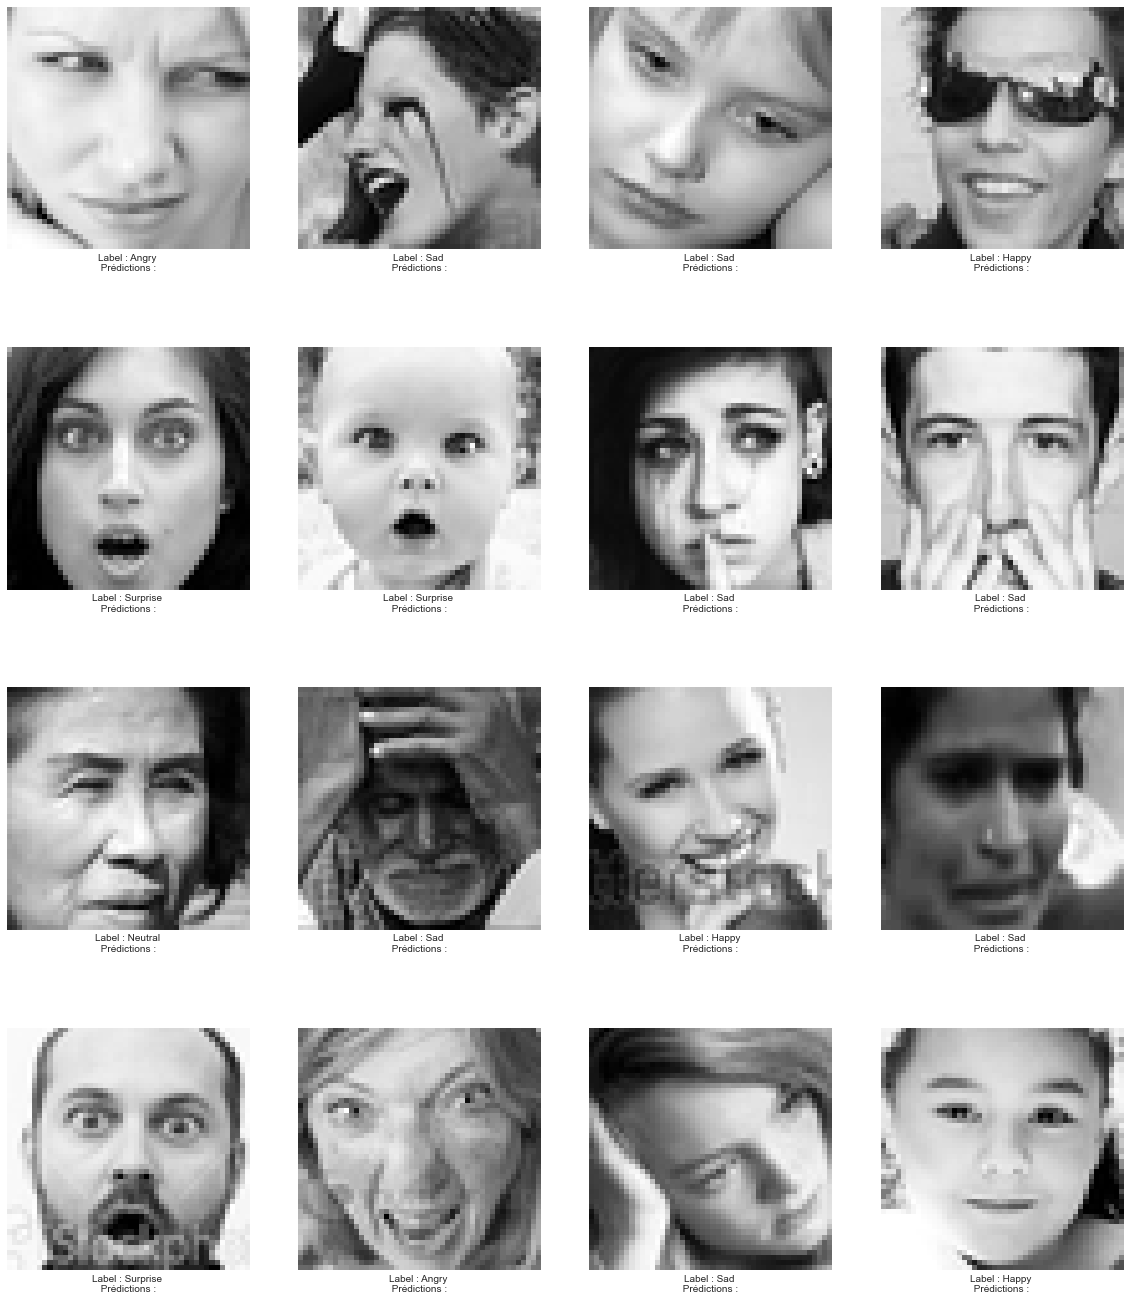

In [9]:
randomExempleTest(Xval_FER,yval_FER,labels,liste, labels_pred)

#### Votre analyse et résultats ici:

<font color=magenta>
    
##### Exemple (évaluation sans étiquettes):
| Ensemble | AR index | MI score | Homo | Completeness | V-measure | F-M score |
|----------|----------|----------|------|--------------|-----------|-----------|
| App      | 0.02     | X.XX     | .... |              |           | X.XXXXXXX |
| Val      | 0.03     | X.XX     | .... |              |           | X.XXXXXXX |
| Test     | 0.09     | X.XX     | .... |              |           | X.XXXXXXX |


##### Exemple (évaluation avec étiquettes):
| Ensemble | Sillouette | C-H score | D-B index |
|----------|------------|-----------|-----------|
| App      | 0.026767   | XXXXX     | X.XXXXXXX |
| Val      | 0.036767   | XXXXX     | X.XXXXXXX |
| Test     | 0.096677   | XXXXX     | X.XXXXXXX |

</font>    

# Partie Final: Conclusion

##### À faire (SVM et SVR):

1. Décrivez la méthode de normalisation de données utilisée.
2. Présentez brièvement la méthode que vous avez utilisée afin de trouver le meilleur modèle SVM. Quels ont été vos résultats ? Quels sont les impacts des hyperparamètres et leur utilité respective?
3. Globalement, prenant en compte les trois TPs, quel type d’approche recommanderiez-vous pour les ensembles de données FER et FG-NET et dans quelles conditions (par exemple, mais non exhaustif, le nombre de données privilégié, les hyperparamètres, le temps de calcul, le matériel nécessaire, les scores de performance)? Discutez des performances que vous avez obtenues entre tous les modèles d’apprentissage. 
4. Formulez quelques pistes d’amélioration des classificateurs.<br>

<font color=magenta>
    
##### À faire (Combinaison de modèles):
1. Présentez la conception de votre solution reposant sur la théorie des ensembles. Présentez ici le diagramme nécessaire afin de présenter convenablement votre combinaison de modèles. Faites une discussion expliquant vos décisions de conception.
2. Est-ce que la combinaison de modèles a apporté des améliorations dans les performances? Comparer la combinaison de modèles avec les modèles individuels.
    
    
##### À faire (Regroupement):    
1. Présentez vos conclusions sur les algorithmes de regroupement. Sont-ils vraiment utiles? Ont-ils produit des résultats cohérents? Est-ce que c’est facile à analyser les sorties (groupes) et d'en tirer des conclusions sur quelles étiquettes assigner à ces groupes?
    
</font>    

### Partie Final: Résultats et résponses:

#### Votre réponse ici:

1.1

Pour la normalisation nous avons utilisé un pipeline avec PCA :

Pour le pipeline utilisé, nous effectuons une normalisation des données avant de passer par le PCA car celui-ci est affeté par la variance des données. Ensuite nous effectuons encore une fois une normalisation car ces données vont etre utilisés avec un modèle SVM qui lui aussi est affecté par la variance des données.

Pour l'amélioration du modele via les hyperparamètres :

Nous avons essayé d'utiliser GridSearchCV afin d'optimiser les modèles mais ceci prennait beacoup du temps à cause des méthodes que GridSearchCV utilise pour faire la validation. Ceci prend beacoup de temps de calcul. Nous avons decidé de faire cette optimisation sans l'aide de GridSearchCV.
Pour cela nous avons essayé différentes combinaisons de paramètres qui paraissaient intéréssantes.

En analysant les résultats pour les primitives HOG et la couche deep CNN, nous remarquons que le meillleur résultat à été le modèle SVM pour les primitives **HOG** avec une réduction PCA à 40 composantes, un kernel **RBF** et les paramètres **C=100** et **gamma=0.0001**. Ce modèle a donné les pourcentages d'erreur suivants:

- **60.7624%** d'erreur dans l'ensemble d'apprentissage
- **58.8953%** d'erreur dans l'ensemble de validation
- **59.1308%** d'erreur dans l'ensemble de test

1.2

On observe alors que le meilleur modèle apres une recherche exhaustive des parametres a donné comme résultat un MSE pour les données de Xtrain de 16.4 et un MSE pour les données de test de 119.8. Ce sont déjà des résultats plus performants que le réseau CNN du laboratoire #2 donc on peut dire que, soit que le réseaux CNN du laboratoire #2 peut être personalisé encore plus, soit en ajoutant plus de couches convolutives ou bien en ajoutant du Dropout et en gardant le même nombre de couches denses pour faire la classification. Ou bien, on peut utilisér la sortie de cette convolution dans le modèle SVM optimisé et obtenir un resultat assez satisfaisant. Finalement, il faut tenir en compte que le temps d'execution du modèle SVM peut être plus grand que celui d'un CNN et aussi, ce dernier peut être executé plus rapidement à l'aide des cartes graphiques (GPU) ce qui peut améliorer le temps d'execution et la performance generale du modèle.

En analysant les résultats obtenus par la première méthode (boucle for et resultats dans fichier *scores_rbf.csv*), nous constatons les faits suivants:
* Avec une valeur de C très petite et des valeurs gamma < 1, la valeur d'epsilon qui performait le mieux était 10. Parcontre, lorsque gamma était >= 1, les valeurs d'epsilon < 1 ont mieux performé cette fois.
* Tourjours avec un valeur de C petite et si on augmente gamma graduellement, la valeur d'epsilon égale à 10 continuait de performer le mieux avec un MSE plus petit que les autres évaluations.
* Avec C = 1, les valeurs de gamma = 1 et epsilon = 0.01 ont le mieux performé.
* Avec C = 10, les valeurs de gamma = 10 et epsilon = 1 ont mieux performé sur l'ensemble d'apprentissage mais le résultat n'a pas améliore dans l'ensemble de test, on commence a remarquer alors du surentrainement du modèle.
* Donc pour C = 10, le modèle qui a mieux performe tout en évitant de tomber sur le surentrainement a été le modèle avec les parametres: **C = 1, gamma = 0.1 et epsilon = 10** avec une difference de **0.7874** points seulement entre l'ensemble d'apprentissage et l'ensemble de test.

*Modèle SVM avec kernel RBF et paramètres: C = 1, gamma = 0.1 et epsilon = 10*  
MSE Apprentissage: 152.1100  
MSE Test: 152.8974

* Pour les valeurs de C = 100 et 256, on a remarqué souvent que le modèle était surentrainé lorsqu'on augmentait la valeur de gamma.


Finalement, les classificateurs SVM sont très performants lorsque les données ont une certaine linéarité et lorsque on peut trouver d'une facon relativement simple des valeurs de C, d'ordre et gamme, qui permettent de donner un bon résultat. Cependant, il existe d'autres algorithmes qui sont plus performants et qui donnent un meilleur résultat tels que XGboost, ou des réseaux neuronaux profonds, et ceci avec un temps d'execution plus petit que celui des modèles SVM.

Nous avons remarqué au cours des différents laboratoires que pour effectuer de l'analyse d'image il était nécéssaire de créer des primitives en appliquant différents filtres ce qui augmente considérablement le nombre de features. Alors les temps d'apprentissage devienne très long sur nos machine. La matériel nécéssaire pour bien traiter un tel problème doit être très performant.

2.


En conslusion, les ensembles Bagging sont des ensembles qui permettent d'avoir un effet de levier lors de l'apprentissage. Ceci, en permettant de spécifier le modèle de base à utiliser, le nombre d'estimateurs voulus, le nombre d'echantillons à prendre du dataset X et le nombre de features à utiliser. Ce type d'ensemble permet de moyenner la precision des estimateurs afin d'obtenir un resultat plus generalisé. Donc il peut etre interessant d'utiliser ce modèle lorsque nous avons un ensemble de données qui n'est pas très representatif ou lorsqu'on a pas beacoup des données disponibles pour l'entrainement et validation. Par contre, un modèle individuel peut rester aussi très performant si nous avons assez des données et si elles sont bien pretraités.

D'un autre côté, pour les ensembles Boosting, tel qu'AdaboostClassifier, ce type ensemble utilise des arbres de décision faibles, c'est-à-dire, qui ont une precision et efficacité faible (juste un peu mieux qu'un estimateur au hasard). Ce qui est different est le fait que ce type d'ensemble utilise la descente de gradient pour mettre à jour les poids au début faibles en incrementant le poids pour les classes plus difficiles à predire et en diminuant le poids des classes plus faciles, donc ceci permet à cet ensemble de se concentrer sur les patrons les plus difficiles à trouver à l'interieur des données. Alors, AdaboostClassifier peut être utilisé dans des modèles ou l'ensemble des données et très diverse et n'est pas équilibré afin de donner plus d'importance aux classes plus difficiles de prédire.


3.

Les algorithmes de regroupement n'ont pas permis d'effectuer de réelles conclusions pour notre cas d'utilisation. Les données étant très peu séparée, nous l'avions vu en effectuant des manipulations PCA sur les données dans les TP précédents, il est difficile de créer des clusters indépendants.
De plus, on remarque que même si on précise que l'on souhaite avoir 7 clusters correspondants aux émotions, les clusters crées n'ont en réalité par l'air de se faire en corrélation avec les émotions. Les clusters ont l'air d'avoir tendance à regrouper d'autres groupe plus évidents à voir : couleur du fond, luminosité,  formes, etc.
Il en devient difficile d'attribuer les étiquettes ensuites.

Finalement, dans certains cas les groupes n'étaient pas toujours très cohérent. 
Un simple algorithme de clustering paraît faible pour réaliser une telle classification d'image.
Le clustering est plutôt utile pour de l'analyse de données 1D.